In [1]:
import pandas as pd
import numpy as np
import yaml
import matplotlib.pyplot as plt

import catboost as cb
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator
from typing import Dict, List
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import json
import shap

### Overview
- tuned catboost model
- tuned xgboost model
- tuned random forest model
    - feature selection (use some default package)
- benchmark the performance on cross validation
- final model prediction

In [35]:
with open('../config.yaml', 'r') as file:
    feature_dic = yaml.safe_load(file)
target = feature_dic["target"]
cat_encoding_features = feature_dic["cat_encoding_features"]
cat_feature_encoding = feature_dic["cat_feature_encoding"]
num_features = feature_dic["num_features"]
cat_features = feature_dic["cat_features"]

In [183]:
df_train = pd.read_csv("../data/raw/train.csv")
df_test = pd.read_csv("../data/raw/test.csv")
df_train_engineered = pd.read_csv("../data/processed/train_engineered.csv")
df_test_engineered = pd.read_csv("../data/processed/test_engineered.csv")

In [40]:
df_train_engineered[cat_feature_encoding+[target]].corr()

price_count_make_fill  price_count_make_model  \
price_count_make_fill                     1.000000                0.393132   
price_count_make_model                    0.393132                1.000000   
price_count_type_of_vehicle              -0.027547                0.038788   
price_count_transmission                  0.037808               -0.013917   
price_count_fuel_type                    -0.046682               -0.033448   
make_fill_jse_encode                     -0.086860               -0.185307   
make_model_jse_encode                    -0.131639               -0.170918   
type_of_vehicle_jse_encode               -0.117564               -0.219383   
transmission_jse_encode                   0.038262               -0.013925   
fuel_type_jse_encode                      0.091971               -0.015494   
price                                    -0.135757               -0.078648   

                             price_count_type_of_vehicle  \
price_count_make_fill                          -0.027547   
price_count_make_model                          0.038788   
price_count_type_of_vehicle                     1.000000   
price_count_transmission                        0.463581   
price_count_fuel_type                           0.466990   
make_fill_jse_encode                            0.280191   
make_model_jse_encode                           0.184264   
type_of_vehicle_jse_encode                      0.437711   
transmission_jse_encode                         0.463061   
fuel_type_jse_encode                            0.518852   
price                                           0.126832   

                             price_count_transmission  price_count_fuel_type  \
price_count_make_fill                        0.037808              -0.046682   
price_count_make_model                      -0.013917              -0.033448   
price_count_type_of_vehicle                  0.463581               0.466990   
price_count_transmission                     1.000000               0.412900   
price_count_fuel_type                        0.412900               1.000000   
make_fill_jse_encode                         0.206757               0.184689   
make_model_jse_encode                        0.142063               0.113368   
type_of_vehicle_jse_encode                   0.223900               0.301088   
transmission_jse_encode                      0.998923               0.412045   
fuel_type_jse_encode                         0.504255               0.512928   
price                                        0.105916               0.065908   

                             make_fill_jse_encode  make_model_jse_encode  \
price_count_make_fill                   -0.086860              -0.131639   
price_count_make_model                  -0.185307              -0.170918   
price_count_type_of_vehicle              0.280191               0.184264   
price_count_transmission                 0.206757               0.142063   
price_count_fuel_type                    0.184689               0.113368   
make_fill_jse_encode                     1.000000               0.620624   
make_model_jse_encode                    0.620624               1.000000   
type_of_vehicle_jse_encode               0.572663               0.488296   
transmission_jse_encode                  0.206666               0.141299   
fuel_type_jse_encode                     0.173165               0.171092   
price                                    0.545469               0.715732   

                             type_of_vehicle_jse_encode  \
price_count_make_fill                         -0.117564   
price_count_make_model                        -0.219383   
price_count_type_of_vehicle                    0.437711   
price_count_transmission                       0.223900   
price_count_fuel_type                          0.301088   
make_fill_jse_encode                           0.572663   
make_model_jse_encode                          0.488296   
type_of_vehicle_jse_encod

# Model functions

In [6]:
class CategoricalBoostRegressor():
    def __init__(
        self, estimator: BaseEstimator, features: List[str], target: str, cat_features_loc: List[int]
    ):
        self.model = estimator
        self.features = features
        self.target = target
        self.cat_features_loc = cat_features_loc

    def _create_data_pool(self, df_train: pd.DataFrame, df_test: pd.DataFrame):
        train_x = df_train[self.features]
        train_y = df_train[self.target]
        train_pool = Pool(data=train_x, label=train_y, cat_features=self.cat_features_loc)

        test_x = df_test[self.features]
        test_y = df_test[self.target]
        test_pool = Pool(data=test_x, label=test_y, cat_features=self.cat_features_loc)
        return train_pool, test_pool

    def train(self, df_train: pd.DataFrame, df_test: pd.DataFrame=None, stage = "train"):
        if stage == "train":
            train_pool, test_pool = self._create_data_pool(df_train, df_test)
            self.model.fit(train_pool, eval_set=test_pool, use_best_model=True)
        elif stage == "test":
            train_x = df_train[self.features]
            train_y = df_train[self.target]
            train_pool = Pool(data=train_x, label=train_y, cat_features=self.cat_features_loc)
            self.model.fit(train_pool)
            
    def evaluate(self, df_test: pd.DataFrame):
        prediction = self.predict(df_test)
        actual = df_test[self.target]

        return compute_metrics_collection(actual, prediction)

    def predict(self, df: pd.DataFrame):
        return self.model.predict(df[self.features].values)
    
    def get_params(self):
        return self.model.get_params()


def compute_metrics_collection(actual, prediction):
    return  mean_squared_error(actual, prediction, squared=False)


In [7]:
class SklearnRegressor():
    def __init__(
        self, estimator: BaseEstimator, features: List[str], target: str,
    ):
        self.model = estimator
        self.features = features
        self.target = target

    def train(self, df_train: pd.DataFrame, df_test: pd.DataFrame=None, stage = "train"):
        if stage == "train":
            self.model.fit(df_train[self.features].values, df_train[self.target].values,
                          eval_set=[(df_test[self.features].values, df_test[self.target].values)])
        elif stage == "test":
            self.model.fit(df_train[self.features].values, df_train[self.target].values)

    def evaluate(self, df_test: pd.DataFrame):
        prediction = self.predict(df_test)
        actual = df_test[self.target]

        return compute_metrics_collection(actual, prediction)

    def predict(self, df: pd.DataFrame):
        return self.model.predict(df[self.features].values)
    
    def get_params(self):
        return self.model.get_params()

In [25]:
def hp_tuning(hp_name, val_ls, param_dic, features, target, model_type, df, cat_features_loc=None):
    
    kf = KFold(n_splits = 5, shuffle = True, random_state = 2)
    loss = []
    df_selected = df[features+[target]]

    for i in val_ls:
        print (f"training {hp_name} = {i}")
        param_dic[hp_name] = i
        kf_index = kf.split(df_selected)
        append_loss = kf_predict(kf_index, param_dic, features, target, model_type, df, cat_features_loc)
        
        
        loss = loss + [(i, val[0], val[1]) for val in append_loss]
    
    with open(f'../models/{model_type}/{hp_name}.json', 'w') as f:
        json.dump(loss, f)
    
    return loss
        

def kf_predict(kf_index, param_dic, features, target, model_type, df_selected, cat_features_loc=None):
    loss = []
    for train_index, test_index in kf_index:
        train, test = df_selected.iloc[train_index], df_selected.iloc[test_index]
        if model_type == "catboost":
            estimator = CatBoostRegressor(**param_dic)
            model = CategoricalBoostRegressor(estimator, features, target, cat_features_loc)
            model.train(train, test)
        elif model_type == "xgboost":
            estimator = XGBRegressor(**param_dic)
            model = SklearnRegressor(estimator, features, target)
            model.train(train, test)
        elif model_type == "random forest":
            estimator = RandomForestRegressor(**param_dic)
            model = SklearnRegressor(estimator, features, target)
            model.train(train, stage='test')
                
        y_test_pred = model.predict(test[features])
        y_train_pred = model.predict(train[features])
        loss.append((compute_metrics_collection(train[target], y_train_pred), 
                     compute_metrics_collection(test[target], y_test_pred)))
    return loss
        
    

In [9]:
def plot_result(result, hp_name):
    plt.scatter([i[0] for i in result],[i[1] for i in result], label = 'train') 
    plt.scatter([i[0] for i in result],[i[2] for i in result], label = 'test')
    plt.legend()
    plt.title(hp_name)
    plt.show()

In [65]:
train, test = train_test_split(df_train_engineered, test_size = 0.2, random_state=2)

# Catboost

In [66]:
catboost_features = num_features + cat_features
catboost_features_with_target = catboost_features + [target]
df_selected_catboost = df_train_engineered[catboost_features_with_target]
cat_features_loc = [df_selected_catboost.columns.get_loc(col) for col in cat_features]
train_catboost = train[catboost_features_with_target]
test_catboost = test[catboost_features_with_target]

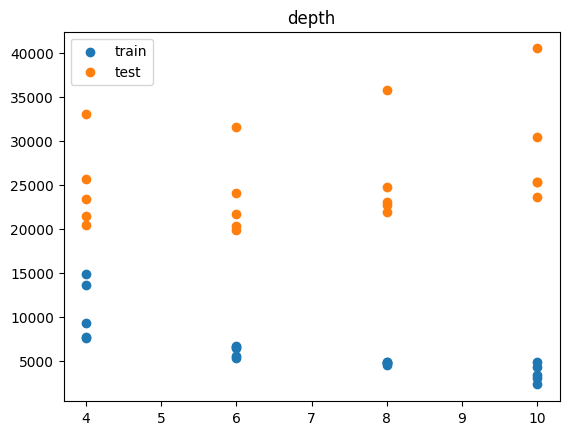

In [61]:
# choose depth = 6 for next step
param_dic = {
    "iterations": 1000,
    "random_state": 10,
    "loss_function": "RMSE",
    "eval_metric": "RMSE",
    "verbose": False,
    "early_stopping_rounds": 15,
    "learning_rate": 0.1,
}
result = hp_tuning('depth', 
                   [4,6,8,10], 
                   param_dic, 
                   catboost_features, 
                   target, 
                   "catboost",
                   df_selected_catboost,
                   cat_features_loc)
plot_result(result, "depth")

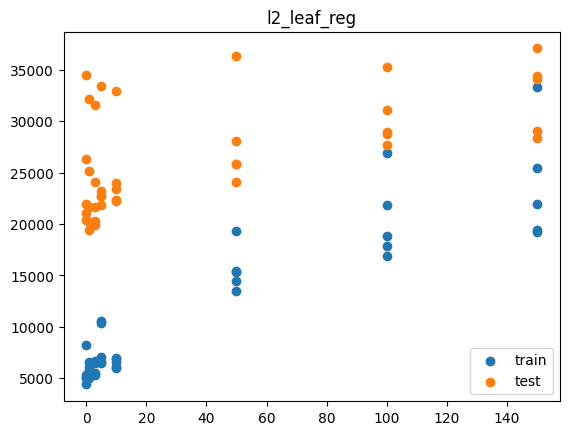

In [65]:
param_dic = {
    "iterations": 1000,
    "random_state": 10,
    "loss_function": "RMSE",
    "eval_metric": "RMSE",
    "verbose": False,
    "early_stopping_rounds": 15,
    "learning_rate": 0.1,
    'depth': 6
}
result = hp_tuning('l2_leaf_reg', 
                   [1, 0, 3,5,10,50,100,150], 
                   param_dic, 
                   catboost_features, 
                   target, 
                   "catboost",
                   df_selected_catboost,
                   cat_features_loc)
plot_result(result, "l2_leaf_reg")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

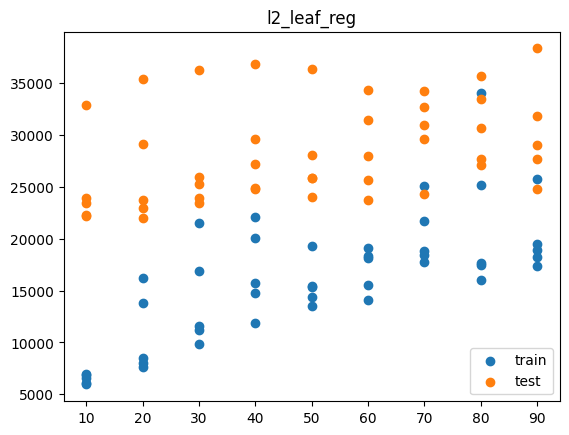

In [66]:
# choose l2_leaf_reg = 10 for next step
result = hp_tuning('l2_leaf_reg', 
                   [10,20,30,40,50,60,70,80,90], 
                   param_dic, 
                   catboost_features, 
                   target, 
                   "catboost",
                   df_selected_catboost,
                   cat_features_loc)
plot_result(result, "l2_leaf_reg")

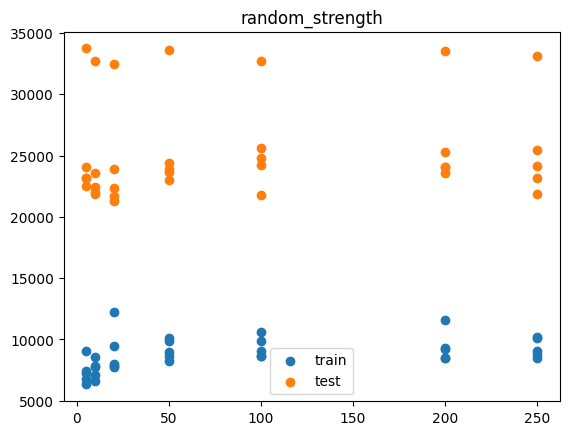

In [80]:
# choose random_strength = 10 for next step
param_dic = {
    "iterations": 1000,
    "random_state": 10,
    "loss_function": "RMSE",
    "eval_metric": "RMSE",
    "verbose": False,
    "early_stopping_rounds": 15,
    "learning_rate": 0.1,
    'depth': 6,
    "l2_leaf_reg":10,
}
result = hp_tuning('random_strength', 
                   [5,10,20,50,100,200,250], 
                   param_dic, 
                   catboost_features, 
                   target, 
                   "catboost",
                   df_selected_catboost,
                   cat_features_loc)
plot_result(result, "random_strength")

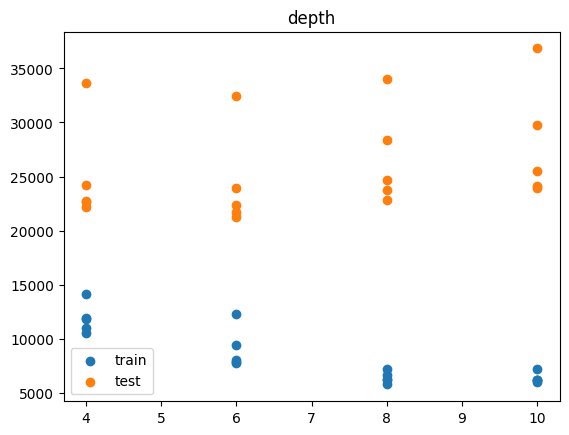

In [82]:
# 6 is still the most suitable value after tuning
param_dic = {
    "iterations": 1000,
    "random_state": 10,
    "loss_function": "RMSE",
    "eval_metric": "RMSE",
    "verbose": False,
    "early_stopping_rounds": 15,
    "learning_rate": 0.1,
    "l2_leaf_reg":10,
    "random_strength":20
}
result = hp_tuning('depth', 
                   [4,6,8,10], 
                   param_dic, 
                   catboost_features, 
                   target, 
                   "catboost",
                   df_selected_catboost,
                   cat_features_loc)
plot_result(result, "depth")

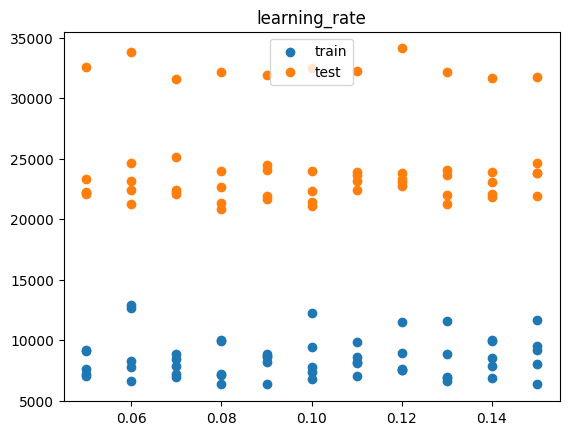

In [84]:
# learning_rate = 0.08
param_dic = {
    "iterations": 2000,
    "random_state": 10,
    "loss_function": "RMSE",
    "eval_metric": "RMSE",
    "verbose": False,
    "early_stopping_rounds": 15,
    "l2_leaf_reg":10,
    "random_strength":20, 
    "depth":6
}
result = hp_tuning('learning_rate', 
                   [0.05,0.06,0.07,0.08,0.09, 0.1,0.11,0.12,0.13,0.14,0.15], 
                   param_dic, 
                   catboost_features, 
                   target, 
                   "catboost",
                   df_selected_catboost,
                   cat_features_loc)
plot_result(result, "learning_rate")

catboost:

- "iterations": 2000,
- "random_state": 10,
- "loss_function": "RMSE",
- "eval_metric": "RMSE",
- "verbose": False,
- "early_stopping_rounds": 15,
- "l2_leaf_reg":10,
- "random_strength":20, 
- "depth":6
- "learning_rate": 0.08

In [68]:
train_x = train_catboost[catboost_features]
train_y = train_catboost[target]
test_x = test_catboost[catboost_features]
test_y = test_catboost[target]
params = {
"iterations": 2000,
"random_state": 10,
"loss_function": "RMSE",
"eval_metric": "RMSE",
"verbose": True,
"early_stopping_rounds": 15,
"l2_leaf_reg":10,
"random_strength":20, 
"depth":6,
"learning_rate": 0.08
}
catboost_estimator = CatBoostRegressor(**params)
model = CategoricalBoostRegressor(catboost_estimator, 
                                  catboost_features, 
                                  target, 
                                  cat_features_loc)
model.train(train_catboost, test_catboost, stage="train")

0:	learn: 128180.4660612	test: 129319.4378900	best: 129319.4378900 (0)	total: 64.2ms	remaining: 2m 8s
1:	learn: 122181.1584153	test: 123683.3174083	best: 123683.3174083 (1)	total: 86.9ms	remaining: 1m 26s
2:	learn: 118065.4794113	test: 120114.9905343	best: 120114.9905343 (2)	total: 104ms	remaining: 1m 9s
3:	learn: 113385.0898350	test: 115833.4794602	best: 115833.4794602 (3)	total: 125ms	remaining: 1m 2s
4:	learn: 108296.3841513	test: 111065.8829069	best: 111065.8829069 (4)	total: 146ms	remaining: 58.1s
5:	learn: 104232.3665059	test: 107903.2604489	best: 107903.2604489 (5)	total: 162ms	remaining: 53.9s
6:	learn: 100761.3896079	test: 104856.3395272	best: 104856.3395272 (6)	total: 184ms	remaining: 52.5s
7:	learn: 97448.2001509	test: 102134.0949447	best: 102134.0949447 (7)	total: 196ms	remaining: 48.8s
8:	learn: 93549.4590851	test: 98524.5960375	best: 98524.5960375 (8)	total: 210ms	remaining: 46.5s
9:	learn: 90402.2712194	test: 95859.1203593	best: 95859.1203593 (9)	total: 224ms	remaining: 

95:	learn: 35628.4966748	test: 45773.7737909	best: 45773.7737909 (95)	total: 1.06s	remaining: 21.1s
96:	learn: 35459.5474620	test: 45743.6315978	best: 45743.6315978 (96)	total: 1.07s	remaining: 21s
97:	learn: 35432.9438029	test: 45721.9208404	best: 45721.9208404 (97)	total: 1.08s	remaining: 20.9s
98:	learn: 35364.6275324	test: 45669.2011379	best: 45669.2011379 (98)	total: 1.09s	remaining: 20.9s
99:	learn: 35203.8634830	test: 45618.6970572	best: 45618.6970572 (99)	total: 1.09s	remaining: 20.8s
100:	learn: 35185.6201657	test: 45603.3083449	best: 45603.3083449 (100)	total: 1.1s	remaining: 20.8s
101:	learn: 35040.6852540	test: 45393.7788273	best: 45393.7788273 (101)	total: 1.12s	remaining: 20.8s
102:	learn: 34906.8603094	test: 45287.1030040	best: 45287.1030040 (102)	total: 1.13s	remaining: 20.7s
103:	learn: 34555.5657429	test: 45055.8126229	best: 45055.8126229 (103)	total: 1.13s	remaining: 20.7s
104:	learn: 34549.8837271	test: 45052.6755995	best: 45052.6755995 (104)	total: 1.14s	remaining:

180:	learn: 27118.4319716	test: 39644.9057728	best: 39644.9057728 (180)	total: 1.88s	remaining: 18.8s
181:	learn: 26936.8858247	test: 39480.1787010	best: 39480.1787010 (181)	total: 1.88s	remaining: 18.8s
182:	learn: 26846.3382325	test: 39398.9046605	best: 39398.9046605 (182)	total: 1.89s	remaining: 18.8s
183:	learn: 26835.7961740	test: 39392.0266079	best: 39392.0266079 (183)	total: 1.9s	remaining: 18.7s
184:	learn: 26828.1226174	test: 39394.2276009	best: 39392.0266079 (183)	total: 1.91s	remaining: 18.7s
185:	learn: 26813.2405920	test: 39396.3671711	best: 39392.0266079 (183)	total: 1.91s	remaining: 18.6s
186:	learn: 26801.4233644	test: 39396.6629359	best: 39392.0266079 (183)	total: 1.92s	remaining: 18.6s
187:	learn: 26789.7881474	test: 39396.9135149	best: 39392.0266079 (183)	total: 1.92s	remaining: 18.5s
188:	learn: 26757.8262205	test: 39390.0401782	best: 39390.0401782 (188)	total: 1.93s	remaining: 18.5s
189:	learn: 26746.4263564	test: 39390.5946579	best: 39390.0401782 (188)	total: 1.94

283:	learn: 20468.3265714	test: 36323.2532776	best: 36323.2532776 (283)	total: 2.67s	remaining: 16.1s
284:	learn: 20435.5127292	test: 36299.3833590	best: 36299.3833590 (284)	total: 2.68s	remaining: 16.1s
285:	learn: 20331.3454145	test: 36249.3397608	best: 36249.3397608 (285)	total: 2.69s	remaining: 16.1s
286:	learn: 20252.0652289	test: 36237.9136722	best: 36237.9136722 (286)	total: 2.7s	remaining: 16.1s
287:	learn: 20201.4066580	test: 36205.9953409	best: 36205.9953409 (287)	total: 2.7s	remaining: 16.1s
288:	learn: 20120.9124340	test: 36176.8419463	best: 36176.8419463 (288)	total: 2.71s	remaining: 16.1s
289:	learn: 20117.7535757	test: 36178.5967750	best: 36176.8419463 (288)	total: 2.72s	remaining: 16s
290:	learn: 20106.8240531	test: 36182.2342171	best: 36176.8419463 (288)	total: 2.73s	remaining: 16s
291:	learn: 20103.7760966	test: 36181.9857459	best: 36176.8419463 (288)	total: 2.74s	remaining: 16s
292:	learn: 20025.5751024	test: 36145.7286550	best: 36145.7286550 (292)	total: 2.75s	remai

384:	learn: 17053.2626481	test: 35442.6931374	best: 35442.6931374 (384)	total: 3.47s	remaining: 14.5s
385:	learn: 17016.4990443	test: 35403.3757743	best: 35403.3757743 (385)	total: 3.48s	remaining: 14.5s
386:	learn: 16961.3044804	test: 35369.0423350	best: 35369.0423350 (386)	total: 3.49s	remaining: 14.5s
387:	learn: 16957.8058260	test: 35368.6316889	best: 35368.6316889 (387)	total: 3.49s	remaining: 14.5s
388:	learn: 16955.8947544	test: 35367.4021788	best: 35367.4021788 (388)	total: 3.5s	remaining: 14.5s
389:	learn: 16919.3185866	test: 35366.9643158	best: 35366.9643158 (389)	total: 3.51s	remaining: 14.5s
390:	learn: 16885.6185360	test: 35362.6293252	best: 35362.6293252 (390)	total: 3.52s	remaining: 14.5s
391:	learn: 16878.2143917	test: 35366.1285647	best: 35362.6293252 (390)	total: 3.53s	remaining: 14.5s
392:	learn: 16829.9410503	test: 35373.8350086	best: 35362.6293252 (390)	total: 3.54s	remaining: 14.5s
393:	learn: 16768.4913694	test: 35347.8823645	best: 35347.8823645 (393)	total: 3.54

In [69]:
model.model.tree_count_

419

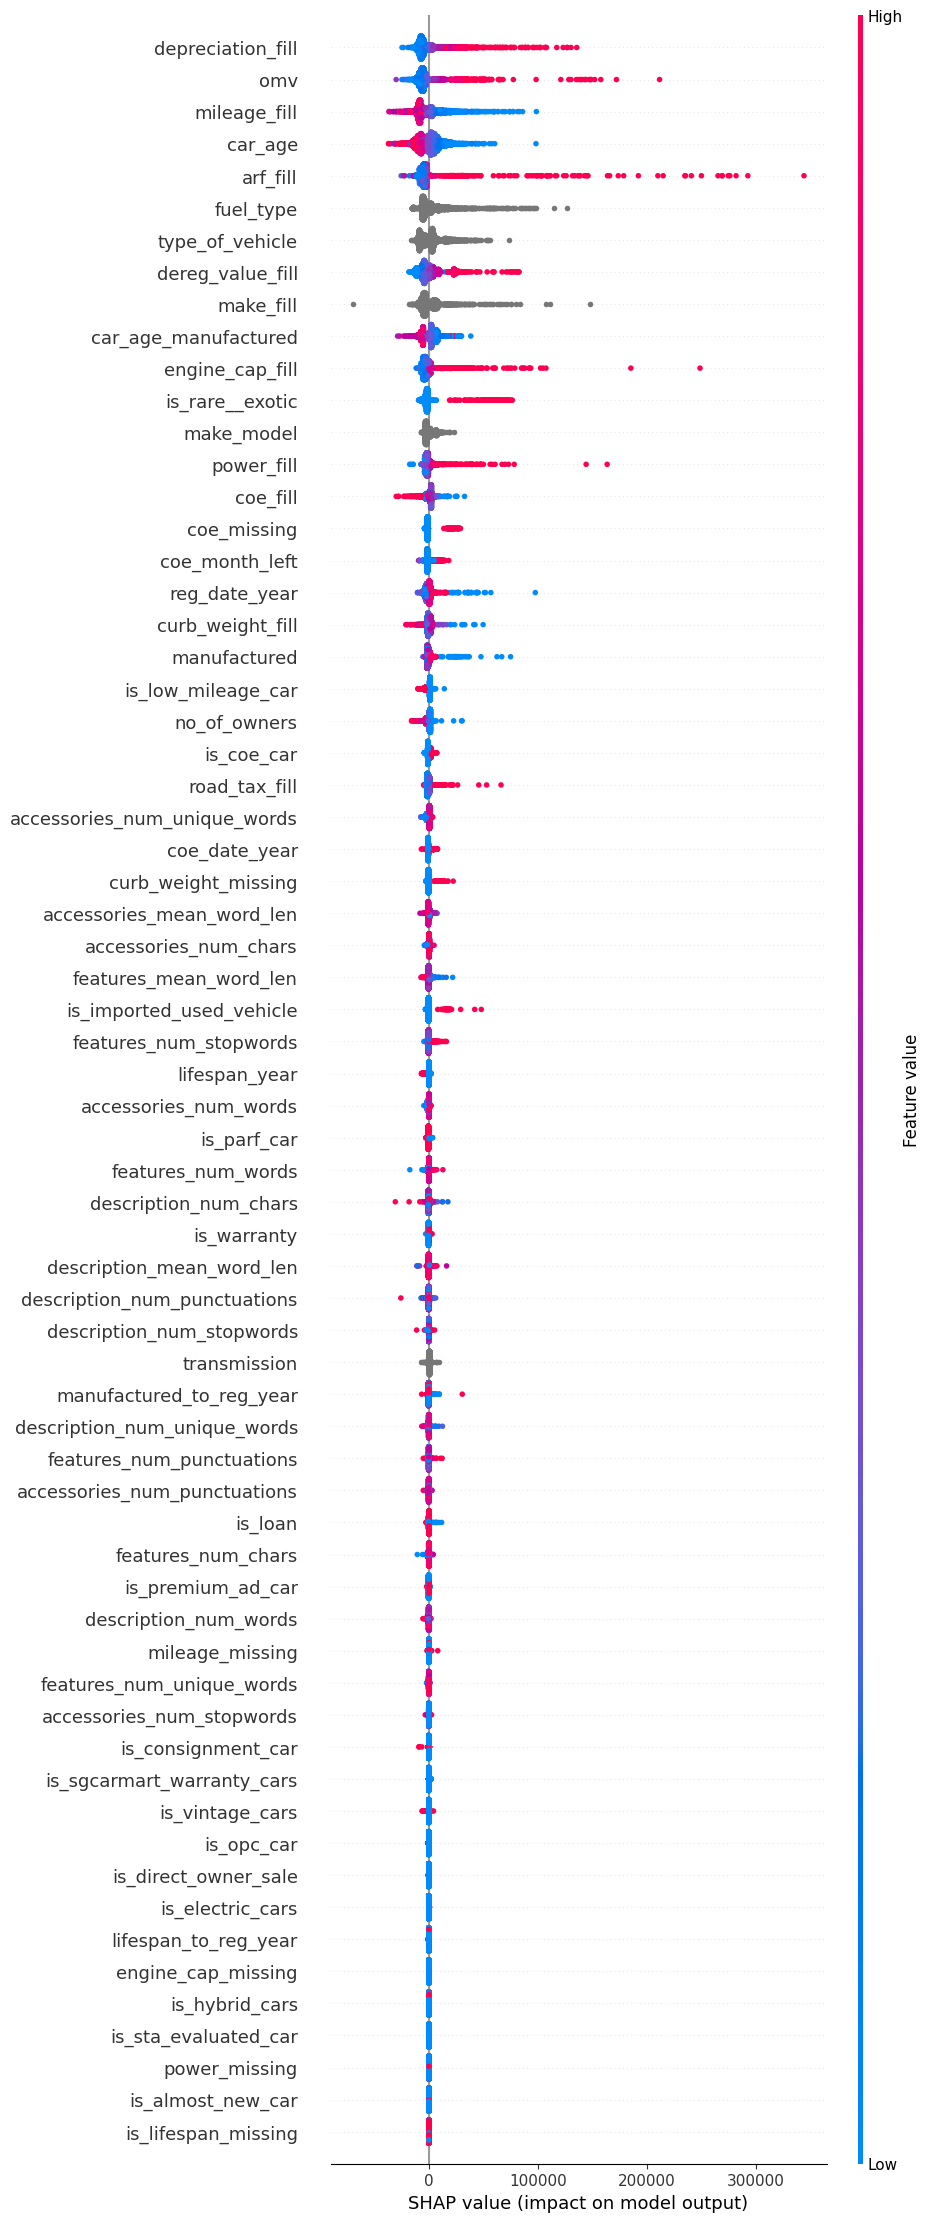

In [70]:
test_pool = Pool(data=test_x, label=test_y, cat_features=cat_features_loc)
shap_values = model.model.get_feature_importance(test_pool, type="ShapValues")
shap_values = shap_values[:,:-1]

shap.summary_plot(shap_values, test_x, max_display = test_x.shape[1]) 

In [13]:
params = {
"iterations": 360,
"random_state": 10,
"loss_function": "RMSE",
"eval_metric": "RMSE",
"verbose": True,
"early_stopping_rounds": 15,
"l2_leaf_reg":10,
"random_strength":20, 
"depth":6,
"learning_rate": 0.08
}
catboost_estimator = CatBoostRegressor(**params)
catboost_model = CategoricalBoostRegressor(catboost_estimator, 
                                           catboost_features, 
                                           target, 
                                           cat_features_loc)
catboost_model.train(df_selected_catboost, stage="test")

0:	learn: 129169.3842853	total: 12.9ms	remaining: 4.62s
1:	learn: 123935.1189965	total: 23.5ms	remaining: 4.21s
2:	learn: 119845.1440203	total: 35.6ms	remaining: 4.23s
3:	learn: 115978.0857902	total: 44.8ms	remaining: 3.99s
4:	learn: 112173.8380467	total: 54.8ms	remaining: 3.89s
5:	learn: 108289.0867375	total: 62.3ms	remaining: 3.68s
6:	learn: 104948.6458395	total: 71.7ms	remaining: 3.61s
7:	learn: 100198.3089864	total: 79.9ms	remaining: 3.52s
8:	learn: 97693.5757883	total: 88.1ms	remaining: 3.43s
9:	learn: 95088.7734840	total: 95.3ms	remaining: 3.33s
10:	learn: 92189.6849896	total: 104ms	remaining: 3.3s
11:	learn: 88694.2173206	total: 111ms	remaining: 3.23s
12:	learn: 85846.2038824	total: 119ms	remaining: 3.18s
13:	learn: 84214.8628174	total: 128ms	remaining: 3.15s
14:	learn: 81489.5365997	total: 137ms	remaining: 3.15s
15:	learn: 79210.1204705	total: 144ms	remaining: 3.09s
16:	learn: 76527.5352672	total: 152ms	remaining: 3.08s
17:	learn: 75063.2838169	total: 160ms	remaining: 3.04s
18:

156:	learn: 28858.3456397	total: 1.42s	remaining: 1.83s
157:	learn: 28673.5224547	total: 1.43s	remaining: 1.83s
158:	learn: 28578.8764331	total: 1.44s	remaining: 1.82s
159:	learn: 28380.6155523	total: 1.45s	remaining: 1.81s
160:	learn: 28308.5254570	total: 1.46s	remaining: 1.8s
161:	learn: 28226.8490232	total: 1.47s	remaining: 1.8s
162:	learn: 28146.6927256	total: 1.48s	remaining: 1.78s
163:	learn: 28071.3568450	total: 1.49s	remaining: 1.78s
164:	learn: 27901.6878423	total: 1.5s	remaining: 1.77s
165:	learn: 27681.4291975	total: 1.51s	remaining: 1.76s
166:	learn: 27604.1914994	total: 1.51s	remaining: 1.75s
167:	learn: 27528.3503720	total: 1.53s	remaining: 1.74s
168:	learn: 27305.7014887	total: 1.53s	remaining: 1.73s
169:	learn: 27165.2697304	total: 1.54s	remaining: 1.73s
170:	learn: 26923.8204451	total: 1.55s	remaining: 1.72s
171:	learn: 26854.8524218	total: 1.56s	remaining: 1.71s
172:	learn: 26661.4495661	total: 1.57s	remaining: 1.7s
173:	learn: 26493.4107856	total: 1.58s	remaining: 1.

313:	learn: 18868.3803266	total: 2.8s	remaining: 411ms
314:	learn: 18863.6139306	total: 2.81s	remaining: 402ms
315:	learn: 18858.4833455	total: 2.82s	remaining: 393ms
316:	learn: 18855.9765565	total: 2.83s	remaining: 384ms
317:	learn: 18791.7045300	total: 2.84s	remaining: 375ms
318:	learn: 18787.1169323	total: 2.85s	remaining: 366ms
319:	learn: 18769.6092964	total: 2.86s	remaining: 357ms
320:	learn: 18765.0910140	total: 2.87s	remaining: 348ms
321:	learn: 18748.8870773	total: 2.88s	remaining: 340ms
322:	learn: 18736.2057729	total: 2.88s	remaining: 330ms
323:	learn: 18723.9354875	total: 2.89s	remaining: 321ms
324:	learn: 18652.5068442	total: 2.9s	remaining: 312ms
325:	learn: 18648.1233782	total: 2.91s	remaining: 303ms
326:	learn: 18628.4770656	total: 2.92s	remaining: 294ms
327:	learn: 18611.0223101	total: 2.92s	remaining: 285ms
328:	learn: 18554.0226828	total: 2.93s	remaining: 276ms
329:	learn: 18492.3585067	total: 2.94s	remaining: 268ms
330:	learn: 18448.1849541	total: 2.95s	remaining: 

# XGboost

In [16]:
num_model_var = num_features + cat_encoding_features + cat_feature_encoding

training max_depth = 4
[0]	validation_0-rmse:159701
[1]	validation_0-rmse:145986
[2]	validation_0-rmse:134045
[3]	validation_0-rmse:123031
[4]	validation_0-rmse:113147
[5]	validation_0-rmse:104272
[6]	validation_0-rmse:96402.6
[7]	validation_0-rmse:89338.8
[8]	validation_0-rmse:83092
[9]	validation_0-rmse:77365.7
[10]	validation_0-rmse:72448.2
[11]	validation_0-rmse:67984.8
[12]	validation_0-rmse:64110.2
[13]	validation_0-rmse:60769.8
[14]	validation_0-rmse:57899.8
[15]	validation_0-rmse:55001.1
[16]	validation_0-rmse:52600.9
[17]	validation_0-rmse:50560.8
[18]	validation_0-rmse:48948.6
[19]	validation_0-rmse:47181.9
[20]	validation_0-rmse:45615.9
[21]	validation_0-rmse:44352.5
[22]	validation_0-rmse:43216
[23]	validation_0-rmse:42283.2
[24]	validation_0-rmse:41415.1
[25]	validation_0-rmse:40599.3
[26]	validation_0-rmse:39922.5
[27]	validation_0-rmse:39360.4
[28]	validation_0-rmse:38851.8
[29]	validation_0-rmse:38550.5
[30]	validation_0-rmse:38317.8
[31]	validation_0-rmse:38020.3
[32]	

[261]	validation_0-rmse:32389.4
[262]	validation_0-rmse:32389.6
[263]	validation_0-rmse:32383.8
[264]	validation_0-rmse:32384.6
[265]	validation_0-rmse:32374.9
[266]	validation_0-rmse:32376.7
[267]	validation_0-rmse:32372.4
[268]	validation_0-rmse:32375.4
[269]	validation_0-rmse:32374.5
[270]	validation_0-rmse:32372.9
[271]	validation_0-rmse:32360
[272]	validation_0-rmse:32347.5
[273]	validation_0-rmse:32341.1
[274]	validation_0-rmse:32341.2
[275]	validation_0-rmse:32333.3
[276]	validation_0-rmse:32322.1
[277]	validation_0-rmse:32303
[278]	validation_0-rmse:32290.9
[279]	validation_0-rmse:32270.4
[280]	validation_0-rmse:32273.5
[281]	validation_0-rmse:32269.7
[282]	validation_0-rmse:32265.4
[283]	validation_0-rmse:32256
[284]	validation_0-rmse:32247.6
[285]	validation_0-rmse:32247.3
[286]	validation_0-rmse:32238.9
[287]	validation_0-rmse:32247.6
[288]	validation_0-rmse:32247.1
[289]	validation_0-rmse:32245.6
[290]	validation_0-rmse:32244.2
[291]	validation_0-rmse:32238.5
[292]	validati

[20]	validation_0-rmse:46251.5
[21]	validation_0-rmse:44910.6
[22]	validation_0-rmse:43535.3
[23]	validation_0-rmse:41665.3
[24]	validation_0-rmse:40156.8
[25]	validation_0-rmse:38641.5
[26]	validation_0-rmse:37361
[27]	validation_0-rmse:36238.6
[28]	validation_0-rmse:35787.9
[29]	validation_0-rmse:34905.1
[30]	validation_0-rmse:34443.4
[31]	validation_0-rmse:34028.4
[32]	validation_0-rmse:33399.6
[33]	validation_0-rmse:33125.2
[34]	validation_0-rmse:32630.4
[35]	validation_0-rmse:32235
[36]	validation_0-rmse:31719
[37]	validation_0-rmse:31229.4
[38]	validation_0-rmse:30783.8
[39]	validation_0-rmse:30410.2
[40]	validation_0-rmse:30109
[41]	validation_0-rmse:29800.4
[42]	validation_0-rmse:29554.6
[43]	validation_0-rmse:29247.6
[44]	validation_0-rmse:28941
[45]	validation_0-rmse:28753.8
[46]	validation_0-rmse:28598.2
[47]	validation_0-rmse:28490.2
[48]	validation_0-rmse:28281.2
[49]	validation_0-rmse:28024.6
[50]	validation_0-rmse:27870.3
[51]	validation_0-rmse:27805.2
[52]	validation_0-

[281]	validation_0-rmse:23381.9
[282]	validation_0-rmse:23381
[283]	validation_0-rmse:23377.1
[284]	validation_0-rmse:23384.9
[285]	validation_0-rmse:23380.5
[286]	validation_0-rmse:23390.3
[287]	validation_0-rmse:23384.4
[288]	validation_0-rmse:23375.3
[289]	validation_0-rmse:23370.7
[290]	validation_0-rmse:23363.4
[291]	validation_0-rmse:23358.2
[292]	validation_0-rmse:23358.4
[293]	validation_0-rmse:23357
[294]	validation_0-rmse:23356.6
[295]	validation_0-rmse:23359.4
[296]	validation_0-rmse:23351
[297]	validation_0-rmse:23346.7
[298]	validation_0-rmse:23342.3
[299]	validation_0-rmse:23339
[300]	validation_0-rmse:23333.7
[301]	validation_0-rmse:23325.2
[302]	validation_0-rmse:23326.2
[303]	validation_0-rmse:23326.5
[304]	validation_0-rmse:23321.4
[305]	validation_0-rmse:23317
[306]	validation_0-rmse:23315.3
[307]	validation_0-rmse:23319.8
[308]	validation_0-rmse:23312.7
[309]	validation_0-rmse:23305.8
[310]	validation_0-rmse:23300.1
[311]	validation_0-rmse:23305.2
[312]	validation_0

[41]	validation_0-rmse:30219.2
[42]	validation_0-rmse:30113
[43]	validation_0-rmse:29985.1
[44]	validation_0-rmse:29814.9
[45]	validation_0-rmse:29719.4
[46]	validation_0-rmse:29648.9
[47]	validation_0-rmse:29618
[48]	validation_0-rmse:29647.3
[49]	validation_0-rmse:29650.4
[50]	validation_0-rmse:29638.8
[51]	validation_0-rmse:29548.5
[52]	validation_0-rmse:29473.5
[53]	validation_0-rmse:29515.9
[54]	validation_0-rmse:29491.7
[55]	validation_0-rmse:29541.3
[56]	validation_0-rmse:29433.5
[57]	validation_0-rmse:29380.3
[58]	validation_0-rmse:29278.3
[59]	validation_0-rmse:29232.4
[60]	validation_0-rmse:29219.2
[61]	validation_0-rmse:29144
[62]	validation_0-rmse:29090.4
[63]	validation_0-rmse:28938.8
[64]	validation_0-rmse:28873
[65]	validation_0-rmse:28857.7
[66]	validation_0-rmse:28876.8
[67]	validation_0-rmse:28885.5
[68]	validation_0-rmse:28731.1
[69]	validation_0-rmse:28707.6
[70]	validation_0-rmse:28655.5
[71]	validation_0-rmse:28685.4
[72]	validation_0-rmse:28680.6
[73]	validation_

[301]	validation_0-rmse:25603.5
[302]	validation_0-rmse:25599
[303]	validation_0-rmse:25588.3
[304]	validation_0-rmse:25584.8
[305]	validation_0-rmse:25581.8
[306]	validation_0-rmse:25583.2
[307]	validation_0-rmse:25578.2
[308]	validation_0-rmse:25595.7
[309]	validation_0-rmse:25601.8
[310]	validation_0-rmse:25601.5
[311]	validation_0-rmse:25595.1
[312]	validation_0-rmse:25590.4
[313]	validation_0-rmse:25577.1
[314]	validation_0-rmse:25567.7
[315]	validation_0-rmse:25561.2
[316]	validation_0-rmse:25559.1
[317]	validation_0-rmse:25557.6
[318]	validation_0-rmse:25549
[319]	validation_0-rmse:25542.1
[320]	validation_0-rmse:25523.2
[321]	validation_0-rmse:25525.4
[322]	validation_0-rmse:25526.9
[323]	validation_0-rmse:25530.1
[324]	validation_0-rmse:25534.2
[325]	validation_0-rmse:25523.8
[326]	validation_0-rmse:25523.4
[327]	validation_0-rmse:25525.1
[328]	validation_0-rmse:25521.8
[329]	validation_0-rmse:25527.5
[330]	validation_0-rmse:25526.7
[331]	validation_0-rmse:25518.7
[332]	valida

[61]	validation_0-rmse:25336.4
[62]	validation_0-rmse:25312.8
[63]	validation_0-rmse:25243.9
[64]	validation_0-rmse:25202.7
[65]	validation_0-rmse:25175.4
[66]	validation_0-rmse:25154.3
[67]	validation_0-rmse:25116.2
[68]	validation_0-rmse:25071.5
[69]	validation_0-rmse:25084.7
[70]	validation_0-rmse:25046
[71]	validation_0-rmse:24986.3
[72]	validation_0-rmse:25016
[73]	validation_0-rmse:24953.7
[74]	validation_0-rmse:24928.6
[75]	validation_0-rmse:24875
[76]	validation_0-rmse:24819.5
[77]	validation_0-rmse:24790.8
[78]	validation_0-rmse:24772.7
[79]	validation_0-rmse:24747.8
[80]	validation_0-rmse:24700.4
[81]	validation_0-rmse:24660.2
[82]	validation_0-rmse:24643.4
[83]	validation_0-rmse:24610.4
[84]	validation_0-rmse:24623.7
[85]	validation_0-rmse:24596.8
[86]	validation_0-rmse:24538.6
[87]	validation_0-rmse:24514.2
[88]	validation_0-rmse:24494.2
[89]	validation_0-rmse:24448
[90]	validation_0-rmse:24408.4
[91]	validation_0-rmse:24368.4
[92]	validation_0-rmse:24331.8
[93]	validation_

[320]	validation_0-rmse:22106.2
[321]	validation_0-rmse:22103.1
[322]	validation_0-rmse:22097.7
[323]	validation_0-rmse:22089.3
[324]	validation_0-rmse:22083.7
[325]	validation_0-rmse:22062.8
[326]	validation_0-rmse:22066.4
[327]	validation_0-rmse:22059.4
[328]	validation_0-rmse:22049.3
[329]	validation_0-rmse:22057.6
[330]	validation_0-rmse:22057.4
[331]	validation_0-rmse:22053
[332]	validation_0-rmse:22046.5
[333]	validation_0-rmse:22041
[334]	validation_0-rmse:22040.6
[335]	validation_0-rmse:22045.2
[336]	validation_0-rmse:22046.5
[337]	validation_0-rmse:22039.1
[338]	validation_0-rmse:22039.3
[339]	validation_0-rmse:22037.8
[340]	validation_0-rmse:22034.8
[341]	validation_0-rmse:22035.3
[342]	validation_0-rmse:22023.7
[343]	validation_0-rmse:22016.2
[344]	validation_0-rmse:22013
[345]	validation_0-rmse:22005.6
[346]	validation_0-rmse:22011.5
[347]	validation_0-rmse:22019.7
[348]	validation_0-rmse:22017.8
[349]	validation_0-rmse:22010
[350]	validation_0-rmse:22015.1
[351]	validation

[81]	validation_0-rmse:26752.7
[82]	validation_0-rmse:26701
[83]	validation_0-rmse:26681.7
[84]	validation_0-rmse:26635.9
[85]	validation_0-rmse:26610.8
[86]	validation_0-rmse:26572
[87]	validation_0-rmse:26522.2
[88]	validation_0-rmse:26466.4
[89]	validation_0-rmse:26453.3
[90]	validation_0-rmse:26437.5
[91]	validation_0-rmse:26436.2
[92]	validation_0-rmse:26409.5
[93]	validation_0-rmse:26381.8
[94]	validation_0-rmse:26306.3
[95]	validation_0-rmse:26273.7
[96]	validation_0-rmse:26249.1
[97]	validation_0-rmse:26234.7
[98]	validation_0-rmse:26217
[99]	validation_0-rmse:26192.5
[100]	validation_0-rmse:26158.3
[101]	validation_0-rmse:26159.7
[102]	validation_0-rmse:26127
[103]	validation_0-rmse:26148.9
[104]	validation_0-rmse:26120.1
[105]	validation_0-rmse:26075.2
[106]	validation_0-rmse:26057.9
[107]	validation_0-rmse:26036.6
[108]	validation_0-rmse:26013.8
[109]	validation_0-rmse:25990.9
[110]	validation_0-rmse:25967.5
[111]	validation_0-rmse:25943.1
[112]	validation_0-rmse:25909.4
[11

[341]	validation_0-rmse:23957.8
[342]	validation_0-rmse:23963.8
[343]	validation_0-rmse:23965.9
[344]	validation_0-rmse:23956.7
[345]	validation_0-rmse:23954
[346]	validation_0-rmse:23952.5
[347]	validation_0-rmse:23945.6
[348]	validation_0-rmse:23944.9
[349]	validation_0-rmse:23941.8
[350]	validation_0-rmse:23944.9
[351]	validation_0-rmse:23939.6
[352]	validation_0-rmse:23931
[353]	validation_0-rmse:23927.4
[354]	validation_0-rmse:23930.2
[355]	validation_0-rmse:23920.2
[356]	validation_0-rmse:23927.1
[357]	validation_0-rmse:23923.7
[358]	validation_0-rmse:23915.5
[359]	validation_0-rmse:23926.2
[360]	validation_0-rmse:23926.8
[361]	validation_0-rmse:23926.1
[362]	validation_0-rmse:23924.9
[363]	validation_0-rmse:23922.1
[364]	validation_0-rmse:23921.1
[365]	validation_0-rmse:23916.4
[366]	validation_0-rmse:23911.9
[367]	validation_0-rmse:23904.1
[368]	validation_0-rmse:23901.6
[369]	validation_0-rmse:23899.3
[370]	validation_0-rmse:23896
[371]	validation_0-rmse:23883.5
[372]	validati

[102]	validation_0-rmse:33564.3
[103]	validation_0-rmse:33562.9
[104]	validation_0-rmse:33551.1
[105]	validation_0-rmse:33550.7
[106]	validation_0-rmse:33545.9
[107]	validation_0-rmse:33547.4
[108]	validation_0-rmse:33552.7
[109]	validation_0-rmse:33540
[110]	validation_0-rmse:33517.6
[111]	validation_0-rmse:33521.6
[112]	validation_0-rmse:33525.9
[113]	validation_0-rmse:33516.9
[114]	validation_0-rmse:33522.3
[115]	validation_0-rmse:33532.1
[116]	validation_0-rmse:33526.8
[117]	validation_0-rmse:33536.9
[118]	validation_0-rmse:33529.4
[119]	validation_0-rmse:33527.9
[120]	validation_0-rmse:33537.7
[121]	validation_0-rmse:33529.8
[122]	validation_0-rmse:33533.1
[123]	validation_0-rmse:33554.8
[124]	validation_0-rmse:33544
[125]	validation_0-rmse:33539.7
[126]	validation_0-rmse:33534.4
[127]	validation_0-rmse:33530.8
[128]	validation_0-rmse:33527.8
[129]	validation_0-rmse:33535.5
[130]	validation_0-rmse:33541.4
[131]	validation_0-rmse:33545.5
[132]	validation_0-rmse:33537.9
[133]	valida

[360]	validation_0-rmse:33292.4
[361]	validation_0-rmse:33292.5
[362]	validation_0-rmse:33293.2
[363]	validation_0-rmse:33292.1
[364]	validation_0-rmse:33291.8
[365]	validation_0-rmse:33296.7
[366]	validation_0-rmse:33296.9
[367]	validation_0-rmse:33295.9
[368]	validation_0-rmse:33296
[369]	validation_0-rmse:33294.9
[370]	validation_0-rmse:33294.9
[371]	validation_0-rmse:33293.8
[372]	validation_0-rmse:33295.4
[373]	validation_0-rmse:33296.1
[374]	validation_0-rmse:33295
[375]	validation_0-rmse:33295
[376]	validation_0-rmse:33294.8
[377]	validation_0-rmse:33295
[378]	validation_0-rmse:33294.3
[379]	validation_0-rmse:33294.3
[380]	validation_0-rmse:33294.5
[381]	validation_0-rmse:33292.4
[382]	validation_0-rmse:33289.7
[383]	validation_0-rmse:33290
[384]	validation_0-rmse:33288.2
[385]	validation_0-rmse:33287.8
[386]	validation_0-rmse:33288.4
[387]	validation_0-rmse:33288.5
[388]	validation_0-rmse:33287.9
[389]	validation_0-rmse:33286.8
[390]	validation_0-rmse:33284.5
[391]	validation_0

[122]	validation_0-rmse:25283.4
[123]	validation_0-rmse:25279.9
[124]	validation_0-rmse:25254.6
[125]	validation_0-rmse:25253.4
[126]	validation_0-rmse:25226.7
[127]	validation_0-rmse:25207.3
[128]	validation_0-rmse:25210.2
[129]	validation_0-rmse:25202.1
[130]	validation_0-rmse:25198.9
[131]	validation_0-rmse:25203.2
[132]	validation_0-rmse:25199.8
[133]	validation_0-rmse:25169.8
[134]	validation_0-rmse:25177
[135]	validation_0-rmse:25174.7
[136]	validation_0-rmse:25177
[137]	validation_0-rmse:25176.5
[138]	validation_0-rmse:25179
[139]	validation_0-rmse:25174
[140]	validation_0-rmse:25160.4
[141]	validation_0-rmse:25163.6
[142]	validation_0-rmse:25164.3
[143]	validation_0-rmse:25160.5
[144]	validation_0-rmse:25147.4
[145]	validation_0-rmse:25128.5
[146]	validation_0-rmse:25124.2
[147]	validation_0-rmse:25122.4
[148]	validation_0-rmse:25114.1
[149]	validation_0-rmse:25113.2
[150]	validation_0-rmse:25109.8
[151]	validation_0-rmse:25101.7
[152]	validation_0-rmse:25082.5
[153]	validation

[380]	validation_0-rmse:24700.6
[381]	validation_0-rmse:24700.3
[382]	validation_0-rmse:24701.6
[383]	validation_0-rmse:24700.8
[384]	validation_0-rmse:24700.1
[385]	validation_0-rmse:24699.2
[386]	validation_0-rmse:24699.4
[387]	validation_0-rmse:24698.6
[388]	validation_0-rmse:24698.8
[389]	validation_0-rmse:24698.2
[390]	validation_0-rmse:24697.2
[391]	validation_0-rmse:24695.8
[392]	validation_0-rmse:24693.8
[393]	validation_0-rmse:24693.4
[394]	validation_0-rmse:24693.2
[395]	validation_0-rmse:24692.6
[396]	validation_0-rmse:24691.8
[397]	validation_0-rmse:24691.8
[398]	validation_0-rmse:24691
[399]	validation_0-rmse:24690.4
[400]	validation_0-rmse:24689.9
[401]	validation_0-rmse:24690.6
[402]	validation_0-rmse:24690.1
[403]	validation_0-rmse:24689.4
[404]	validation_0-rmse:24689.9
[405]	validation_0-rmse:24689.7
[406]	validation_0-rmse:24689.8
[407]	validation_0-rmse:24690.9
[408]	validation_0-rmse:24690.8
[409]	validation_0-rmse:24689.5
[410]	validation_0-rmse:24688.2
[411]	vali

[141]	validation_0-rmse:24368.2
[142]	validation_0-rmse:24367.3
[143]	validation_0-rmse:24360.2
[144]	validation_0-rmse:24358.3
[145]	validation_0-rmse:24347.3
[146]	validation_0-rmse:24351.7
[147]	validation_0-rmse:24348.9
[148]	validation_0-rmse:24346.5
[149]	validation_0-rmse:24333.7
[150]	validation_0-rmse:24322.4
[151]	validation_0-rmse:24314.2
[152]	validation_0-rmse:24308.6
[153]	validation_0-rmse:24312.7
[154]	validation_0-rmse:24306.9
[155]	validation_0-rmse:24305.3
[156]	validation_0-rmse:24308.4
[157]	validation_0-rmse:24305.4
[158]	validation_0-rmse:24290.9
[159]	validation_0-rmse:24291
[160]	validation_0-rmse:24282.1
[161]	validation_0-rmse:24278.1
[162]	validation_0-rmse:24274.5
[163]	validation_0-rmse:24273
[164]	validation_0-rmse:24265.3
[165]	validation_0-rmse:24268.7
[166]	validation_0-rmse:24258.9
[167]	validation_0-rmse:24258.8
[168]	validation_0-rmse:24252.1
[169]	validation_0-rmse:24245
[170]	validation_0-rmse:24235.7
[171]	validation_0-rmse:24233
[172]	validation

[399]	validation_0-rmse:23885.3
[400]	validation_0-rmse:23884.7
[401]	validation_0-rmse:23883.2
[402]	validation_0-rmse:23880.1
[403]	validation_0-rmse:23877.5
[404]	validation_0-rmse:23875.7
[405]	validation_0-rmse:23874.6
[406]	validation_0-rmse:23870
[407]	validation_0-rmse:23869.8
[408]	validation_0-rmse:23869
[409]	validation_0-rmse:23867.4
[410]	validation_0-rmse:23866.3
[411]	validation_0-rmse:23868.3
[412]	validation_0-rmse:23869.6
[413]	validation_0-rmse:23869.8
[414]	validation_0-rmse:23870.1
[415]	validation_0-rmse:23870.8
[416]	validation_0-rmse:23869.5
[417]	validation_0-rmse:23867.8
[418]	validation_0-rmse:23867.3
[419]	validation_0-rmse:23867
[420]	validation_0-rmse:23867
[421]	validation_0-rmse:23868.3
[422]	validation_0-rmse:23867.9
[423]	validation_0-rmse:23866.6
[424]	validation_0-rmse:23867.5
[425]	validation_0-rmse:23864.3
[426]	validation_0-rmse:23863.9
[427]	validation_0-rmse:23861.3
[428]	validation_0-rmse:23861.2
[429]	validation_0-rmse:23860.2
[430]	validation

[160]	validation_0-rmse:20443.7
[161]	validation_0-rmse:20438.4
[162]	validation_0-rmse:20423.1
[163]	validation_0-rmse:20421
[164]	validation_0-rmse:20417.1
[165]	validation_0-rmse:20415.3
[166]	validation_0-rmse:20410.5
[167]	validation_0-rmse:20406.7
[168]	validation_0-rmse:20415.1
[169]	validation_0-rmse:20410.6
[170]	validation_0-rmse:20409.5
[171]	validation_0-rmse:20410.1
[172]	validation_0-rmse:20404.7
[173]	validation_0-rmse:20399.9
[174]	validation_0-rmse:20398.5
[175]	validation_0-rmse:20395.5
[176]	validation_0-rmse:20392.6
[177]	validation_0-rmse:20393.1
[178]	validation_0-rmse:20382.7
[179]	validation_0-rmse:20380.9
[180]	validation_0-rmse:20374.6
[181]	validation_0-rmse:20372.4
[182]	validation_0-rmse:20370.4
[183]	validation_0-rmse:20366.9
[184]	validation_0-rmse:20362.6
[185]	validation_0-rmse:20362.3
[186]	validation_0-rmse:20357.9
[187]	validation_0-rmse:20358.6
[188]	validation_0-rmse:20355
[189]	validation_0-rmse:20360
[190]	validation_0-rmse:20357.4
[191]	validati

[418]	validation_0-rmse:20223.5
[419]	validation_0-rmse:20221.4
[420]	validation_0-rmse:20221.7
[421]	validation_0-rmse:20221.4
[422]	validation_0-rmse:20221
[423]	validation_0-rmse:20217.4
[424]	validation_0-rmse:20217.4
[425]	validation_0-rmse:20216.9
[426]	validation_0-rmse:20217.4
[427]	validation_0-rmse:20217.4
[428]	validation_0-rmse:20217.4
[429]	validation_0-rmse:20216.8
[430]	validation_0-rmse:20216.1
[431]	validation_0-rmse:20214.3
[432]	validation_0-rmse:20214.5
[433]	validation_0-rmse:20212.4
[434]	validation_0-rmse:20213.1
[435]	validation_0-rmse:20213
[436]	validation_0-rmse:20212.9
[437]	validation_0-rmse:20212.9
[438]	validation_0-rmse:20213.1
[439]	validation_0-rmse:20213.1
[440]	validation_0-rmse:20213.1
[441]	validation_0-rmse:20212.1
[442]	validation_0-rmse:20211.2
[443]	validation_0-rmse:20211
[444]	validation_0-rmse:20211.2
[445]	validation_0-rmse:20211
[446]	validation_0-rmse:20211.6
[447]	validation_0-rmse:20212.1
[448]	validation_0-rmse:20210.3
[449]	validation

[180]	validation_0-rmse:22796
[181]	validation_0-rmse:22791.8
[182]	validation_0-rmse:22790.9
[183]	validation_0-rmse:22784.8
[184]	validation_0-rmse:22785.1
[185]	validation_0-rmse:22770.5
[186]	validation_0-rmse:22764
[187]	validation_0-rmse:22767.4
[188]	validation_0-rmse:22761.7
[189]	validation_0-rmse:22760.1
[190]	validation_0-rmse:22750.1
[191]	validation_0-rmse:22751.8
[192]	validation_0-rmse:22749.9
[193]	validation_0-rmse:22742.7
[194]	validation_0-rmse:22739.1
[195]	validation_0-rmse:22736.7
[196]	validation_0-rmse:22732.5
[197]	validation_0-rmse:22735.5
[198]	validation_0-rmse:22735.4
[199]	validation_0-rmse:22735.8
[200]	validation_0-rmse:22734.7
[201]	validation_0-rmse:22728
[202]	validation_0-rmse:22726.9
[203]	validation_0-rmse:22725.8
[204]	validation_0-rmse:22727.3
[205]	validation_0-rmse:22727.4
[206]	validation_0-rmse:22721.5
[207]	validation_0-rmse:22713.1
[208]	validation_0-rmse:22706.7
[209]	validation_0-rmse:22703.9
[210]	validation_0-rmse:22708
[211]	validation

[438]	validation_0-rmse:22573.9
[439]	validation_0-rmse:22573.5
[440]	validation_0-rmse:22573.8
[441]	validation_0-rmse:22573.4
[442]	validation_0-rmse:22573.9
[443]	validation_0-rmse:22574.1
[444]	validation_0-rmse:22575.6
[445]	validation_0-rmse:22576.2
[446]	validation_0-rmse:22576.5
[447]	validation_0-rmse:22575.7
[448]	validation_0-rmse:22576.1
[449]	validation_0-rmse:22576
[450]	validation_0-rmse:22576.7
[451]	validation_0-rmse:22575.3
[452]	validation_0-rmse:22574.6
[453]	validation_0-rmse:22574.8
[454]	validation_0-rmse:22572.1
[455]	validation_0-rmse:22571.1
[456]	validation_0-rmse:22571.3
[457]	validation_0-rmse:22572
[458]	validation_0-rmse:22572.3
[459]	validation_0-rmse:22571.6
[460]	validation_0-rmse:22571.5
[461]	validation_0-rmse:22571.3
[462]	validation_0-rmse:22571.8
[463]	validation_0-rmse:22571.8
[464]	validation_0-rmse:22573
[465]	validation_0-rmse:22573.8
[466]	validation_0-rmse:22573.5
[467]	validation_0-rmse:22573.5
[468]	validation_0-rmse:22573.6
[469]	validati

[199]	validation_0-rmse:35301.2
[200]	validation_0-rmse:35300.3
[201]	validation_0-rmse:35299.6
[202]	validation_0-rmse:35301.6
[203]	validation_0-rmse:35300.4
[204]	validation_0-rmse:35300.5
[205]	validation_0-rmse:35300.4
[206]	validation_0-rmse:35298.1
[207]	validation_0-rmse:35296.6
[208]	validation_0-rmse:35295.6
[209]	validation_0-rmse:35295.3
[210]	validation_0-rmse:35296
[211]	validation_0-rmse:35296.1
[212]	validation_0-rmse:35295
[213]	validation_0-rmse:35294.7
[214]	validation_0-rmse:35294.5
[215]	validation_0-rmse:35294.4
[216]	validation_0-rmse:35294.9
[217]	validation_0-rmse:35296.1
[218]	validation_0-rmse:35296.4
[219]	validation_0-rmse:35297.4
[220]	validation_0-rmse:35297.9
[221]	validation_0-rmse:35298.1
[222]	validation_0-rmse:35298.1
[223]	validation_0-rmse:35296.7
[224]	validation_0-rmse:35295.9
[225]	validation_0-rmse:35296.3
[226]	validation_0-rmse:35296.5
[227]	validation_0-rmse:35296.8
[228]	validation_0-rmse:35297.8
[229]	validation_0-rmse:35297.4
[230]	valida

[458]	validation_0-rmse:35289.5
[459]	validation_0-rmse:35289.6
[460]	validation_0-rmse:35289.7
[461]	validation_0-rmse:35289.7
[462]	validation_0-rmse:35289.9
[463]	validation_0-rmse:35290
[464]	validation_0-rmse:35290.1
[465]	validation_0-rmse:35290.1
[466]	validation_0-rmse:35290
[467]	validation_0-rmse:35290
[468]	validation_0-rmse:35290
[469]	validation_0-rmse:35290.1
[470]	validation_0-rmse:35289.9
[471]	validation_0-rmse:35289.8
[472]	validation_0-rmse:35289.8
[473]	validation_0-rmse:35289.8
[474]	validation_0-rmse:35289.6
[475]	validation_0-rmse:35289.6
[476]	validation_0-rmse:35289.6
[477]	validation_0-rmse:35289.6
[478]	validation_0-rmse:35289.6
[479]	validation_0-rmse:35289.5
[480]	validation_0-rmse:35289.3
[481]	validation_0-rmse:35289.3
[482]	validation_0-rmse:35289.1
[483]	validation_0-rmse:35289.2
[484]	validation_0-rmse:35289.3
[485]	validation_0-rmse:35289.6
[486]	validation_0-rmse:35289.6
[487]	validation_0-rmse:35289.6
[488]	validation_0-rmse:35289.7
[489]	validation

[220]	validation_0-rmse:25639.4
[221]	validation_0-rmse:25637.9
[222]	validation_0-rmse:25637.5
[223]	validation_0-rmse:25637.8
[224]	validation_0-rmse:25638.5
[225]	validation_0-rmse:25638.3
[226]	validation_0-rmse:25637
[227]	validation_0-rmse:25636.3
[228]	validation_0-rmse:25636.1
[229]	validation_0-rmse:25635.5
[230]	validation_0-rmse:25635.6
[231]	validation_0-rmse:25635.1
[232]	validation_0-rmse:25635.6
[233]	validation_0-rmse:25635.2
[234]	validation_0-rmse:25635.4
[235]	validation_0-rmse:25635.6
[236]	validation_0-rmse:25635.4
[237]	validation_0-rmse:25632
[238]	validation_0-rmse:25631.5
[239]	validation_0-rmse:25631.3
[240]	validation_0-rmse:25629.4
[241]	validation_0-rmse:25629.2
[242]	validation_0-rmse:25629.1
[243]	validation_0-rmse:25629.8
[244]	validation_0-rmse:25630.1
[245]	validation_0-rmse:25630.5
[246]	validation_0-rmse:25630.3
[247]	validation_0-rmse:25630.5
[248]	validation_0-rmse:25629.4
[249]	validation_0-rmse:25629.9
[250]	validation_0-rmse:25629.9
[251]	valida

[478]	validation_0-rmse:25607.5
[479]	validation_0-rmse:25607.5
[480]	validation_0-rmse:25607.5
[481]	validation_0-rmse:25607.5
[482]	validation_0-rmse:25607.4
[483]	validation_0-rmse:25607.3
[484]	validation_0-rmse:25607.4
[485]	validation_0-rmse:25607.4
[486]	validation_0-rmse:25607.4
[487]	validation_0-rmse:25607.4
[488]	validation_0-rmse:25607.4
[489]	validation_0-rmse:25607.4
[490]	validation_0-rmse:25607.2
[491]	validation_0-rmse:25607.1
[492]	validation_0-rmse:25607.1
[493]	validation_0-rmse:25607.2
[494]	validation_0-rmse:25607.2
[495]	validation_0-rmse:25607.3
[496]	validation_0-rmse:25607.4
[497]	validation_0-rmse:25607.6
[498]	validation_0-rmse:25607.1
[499]	validation_0-rmse:25607
[0]	validation_0-rmse:154242
[1]	validation_0-rmse:140027
[2]	validation_0-rmse:127540
[3]	validation_0-rmse:115679
[4]	validation_0-rmse:105669
[5]	validation_0-rmse:96731.7
[6]	validation_0-rmse:88527.7
[7]	validation_0-rmse:81149.7
[8]	validation_0-rmse:74288
[9]	validation_0-rmse:68448.8
[10]	

[239]	validation_0-rmse:24911.6
[240]	validation_0-rmse:24910.8
[241]	validation_0-rmse:24910.3
[242]	validation_0-rmse:24910.7
[243]	validation_0-rmse:24909.8
[244]	validation_0-rmse:24909.6
[245]	validation_0-rmse:24908.9
[246]	validation_0-rmse:24909.2
[247]	validation_0-rmse:24908
[248]	validation_0-rmse:24906.9
[249]	validation_0-rmse:24906.6
[250]	validation_0-rmse:24906.7
[251]	validation_0-rmse:24906.2
[252]	validation_0-rmse:24905.8
[253]	validation_0-rmse:24904.7
[254]	validation_0-rmse:24904.2
[255]	validation_0-rmse:24904.2
[256]	validation_0-rmse:24904.2
[257]	validation_0-rmse:24904.2
[258]	validation_0-rmse:24904.1
[259]	validation_0-rmse:24904
[260]	validation_0-rmse:24904.5
[261]	validation_0-rmse:24904.3
[262]	validation_0-rmse:24903.9
[263]	validation_0-rmse:24903.2
[264]	validation_0-rmse:24903.5
[265]	validation_0-rmse:24902.8
[266]	validation_0-rmse:24903.6
[267]	validation_0-rmse:24903.5
[268]	validation_0-rmse:24902.7
[269]	validation_0-rmse:24902.3
[270]	valida

[497]	validation_0-rmse:24887.2
[498]	validation_0-rmse:24887.4
[499]	validation_0-rmse:24887.3
[0]	validation_0-rmse:159820
[1]	validation_0-rmse:144923
[2]	validation_0-rmse:131407
[3]	validation_0-rmse:119474
[4]	validation_0-rmse:108325
[5]	validation_0-rmse:98009.7
[6]	validation_0-rmse:88774.9
[7]	validation_0-rmse:80552.1
[8]	validation_0-rmse:73905.7
[9]	validation_0-rmse:67586.7
[10]	validation_0-rmse:61788.2
[11]	validation_0-rmse:56529.9
[12]	validation_0-rmse:51895.2
[13]	validation_0-rmse:48022.4
[14]	validation_0-rmse:44667.9
[15]	validation_0-rmse:41464.6
[16]	validation_0-rmse:38708.1
[17]	validation_0-rmse:36449.5
[18]	validation_0-rmse:34251.1
[19]	validation_0-rmse:32312.3
[20]	validation_0-rmse:30729.8
[21]	validation_0-rmse:29350.3
[22]	validation_0-rmse:28138.6
[23]	validation_0-rmse:27203.8
[24]	validation_0-rmse:26351.4
[25]	validation_0-rmse:25550.5
[26]	validation_0-rmse:24913.7
[27]	validation_0-rmse:24301.8
[28]	validation_0-rmse:23764.7
[29]	validation_0-rm

[258]	validation_0-rmse:21257.8
[259]	validation_0-rmse:21257.9
[260]	validation_0-rmse:21258
[261]	validation_0-rmse:21257.5
[262]	validation_0-rmse:21256.6
[263]	validation_0-rmse:21256.6
[264]	validation_0-rmse:21256.1
[265]	validation_0-rmse:21256.7
[266]	validation_0-rmse:21256.8
[267]	validation_0-rmse:21256.6
[268]	validation_0-rmse:21256.9
[269]	validation_0-rmse:21256.4
[270]	validation_0-rmse:21256.5
[271]	validation_0-rmse:21256.6
[272]	validation_0-rmse:21256.2
[273]	validation_0-rmse:21255.9
[274]	validation_0-rmse:21256.2
[275]	validation_0-rmse:21256.4
[276]	validation_0-rmse:21257
[277]	validation_0-rmse:21257.6
[278]	validation_0-rmse:21257.3
[279]	validation_0-rmse:21257.7
[280]	validation_0-rmse:21258.2
[281]	validation_0-rmse:21258.1
[282]	validation_0-rmse:21258.1
[283]	validation_0-rmse:21258.8
[284]	validation_0-rmse:21257.7
[285]	validation_0-rmse:21258.3
[286]	validation_0-rmse:21258.8
[287]	validation_0-rmse:21258.7
[288]	validation_0-rmse:21258.8
[289]	valida

[17]	validation_0-rmse:40375.9
[18]	validation_0-rmse:38642.2
[19]	validation_0-rmse:36909.3
[20]	validation_0-rmse:35304.3
[21]	validation_0-rmse:34101
[22]	validation_0-rmse:32837.8
[23]	validation_0-rmse:31856
[24]	validation_0-rmse:30836.2
[25]	validation_0-rmse:30077.6
[26]	validation_0-rmse:29369.6
[27]	validation_0-rmse:28977.5
[28]	validation_0-rmse:28441.2
[29]	validation_0-rmse:27982.3
[30]	validation_0-rmse:27725.4
[31]	validation_0-rmse:27295.4
[32]	validation_0-rmse:27015.3
[33]	validation_0-rmse:26902.6
[34]	validation_0-rmse:26575.1
[35]	validation_0-rmse:26472.1
[36]	validation_0-rmse:26388.7
[37]	validation_0-rmse:26258.8
[38]	validation_0-rmse:26200.6
[39]	validation_0-rmse:26087.2
[40]	validation_0-rmse:26002.2
[41]	validation_0-rmse:25945.8
[42]	validation_0-rmse:25905.2
[43]	validation_0-rmse:25817.4
[44]	validation_0-rmse:25784.1
[45]	validation_0-rmse:25741.5
[46]	validation_0-rmse:25709.4
[47]	validation_0-rmse:25705.5
[48]	validation_0-rmse:25658.9
[49]	validat

[277]	validation_0-rmse:24612.6
[278]	validation_0-rmse:24612.3
[279]	validation_0-rmse:24612.1
[280]	validation_0-rmse:24612.4
[281]	validation_0-rmse:24612.2
[282]	validation_0-rmse:24611.3
[283]	validation_0-rmse:24611
[284]	validation_0-rmse:24610.5
[285]	validation_0-rmse:24609.6
[286]	validation_0-rmse:24609.7
[287]	validation_0-rmse:24610.4
[288]	validation_0-rmse:24610.5
[289]	validation_0-rmse:24610.4
[290]	validation_0-rmse:24610.7
[291]	validation_0-rmse:24610.8
[292]	validation_0-rmse:24611
[293]	validation_0-rmse:24611.1
[294]	validation_0-rmse:24611.2
[295]	validation_0-rmse:24611.4
[296]	validation_0-rmse:24611.1
[297]	validation_0-rmse:24611.1
[298]	validation_0-rmse:24611
[299]	validation_0-rmse:24610.6
[300]	validation_0-rmse:24609.8
[301]	validation_0-rmse:24608.5
[302]	validation_0-rmse:24608.2
[303]	validation_0-rmse:24608.1
[304]	validation_0-rmse:24607.2
[305]	validation_0-rmse:24606.9
[306]	validation_0-rmse:24607
[307]	validation_0-rmse:24606.8
[308]	validation

[36]	validation_0-rmse:36620.6
[37]	validation_0-rmse:36507.8
[38]	validation_0-rmse:36434
[39]	validation_0-rmse:36419.8
[40]	validation_0-rmse:36356.6
[41]	validation_0-rmse:36248.8
[42]	validation_0-rmse:36231.7
[43]	validation_0-rmse:36211.6
[44]	validation_0-rmse:36191.8
[45]	validation_0-rmse:36120.1
[46]	validation_0-rmse:36077.6
[47]	validation_0-rmse:36049.7
[48]	validation_0-rmse:36035.6
[49]	validation_0-rmse:36004.2
[50]	validation_0-rmse:35967.6
[51]	validation_0-rmse:35944.9
[52]	validation_0-rmse:35921.1
[53]	validation_0-rmse:35899.3
[54]	validation_0-rmse:35900.4
[55]	validation_0-rmse:35867.1
[56]	validation_0-rmse:35863
[57]	validation_0-rmse:35867.8
[58]	validation_0-rmse:35852.8
[59]	validation_0-rmse:35794.5
[60]	validation_0-rmse:35798
[61]	validation_0-rmse:35774.2
[62]	validation_0-rmse:35770.7
[63]	validation_0-rmse:35761.6
[64]	validation_0-rmse:35758.5
[65]	validation_0-rmse:35753.5
[66]	validation_0-rmse:35751.4
[67]	validation_0-rmse:35749.1
[68]	validatio

[296]	validation_0-rmse:35672.6
[297]	validation_0-rmse:35672.6
[298]	validation_0-rmse:35672.7
[299]	validation_0-rmse:35672.7
[300]	validation_0-rmse:35672.6
[301]	validation_0-rmse:35672.6
[302]	validation_0-rmse:35672.6
[303]	validation_0-rmse:35672.5
[304]	validation_0-rmse:35672.6
[305]	validation_0-rmse:35672.6
[306]	validation_0-rmse:35672.7
[307]	validation_0-rmse:35672.7
[308]	validation_0-rmse:35672.7
[309]	validation_0-rmse:35672.7
[310]	validation_0-rmse:35672.7
[311]	validation_0-rmse:35672.7
[312]	validation_0-rmse:35672.6
[313]	validation_0-rmse:35672.6
[314]	validation_0-rmse:35672.6
[315]	validation_0-rmse:35672.7
[316]	validation_0-rmse:35672.8
[317]	validation_0-rmse:35672.8
[318]	validation_0-rmse:35672.9
[319]	validation_0-rmse:35672.9
[320]	validation_0-rmse:35673
[321]	validation_0-rmse:35673
[322]	validation_0-rmse:35672.9
[323]	validation_0-rmse:35672.9
[324]	validation_0-rmse:35673
[325]	validation_0-rmse:35673.2
[326]	validation_0-rmse:35673.1
[327]	validati

[56]	validation_0-rmse:27038.5
[57]	validation_0-rmse:27014.8
[58]	validation_0-rmse:27019.7
[59]	validation_0-rmse:26998.3
[60]	validation_0-rmse:26960.8
[61]	validation_0-rmse:26929.7
[62]	validation_0-rmse:26908.5
[63]	validation_0-rmse:26911.1
[64]	validation_0-rmse:26918.5
[65]	validation_0-rmse:26928.9
[66]	validation_0-rmse:26941.2
[67]	validation_0-rmse:26941.9
[68]	validation_0-rmse:26948.9
[69]	validation_0-rmse:26952.7
[70]	validation_0-rmse:26959.1
[71]	validation_0-rmse:26979.3
[72]	validation_0-rmse:26994.8
[73]	validation_0-rmse:27001.8
[74]	validation_0-rmse:27011.1
[75]	validation_0-rmse:27003.1
[76]	validation_0-rmse:27016.9
[77]	validation_0-rmse:27026
[78]	validation_0-rmse:26995.3
[79]	validation_0-rmse:26998.4
[80]	validation_0-rmse:27010.8
[81]	validation_0-rmse:27019.4
[82]	validation_0-rmse:27023.4
[83]	validation_0-rmse:27032.8
[84]	validation_0-rmse:27043.3
[85]	validation_0-rmse:27052.7
[86]	validation_0-rmse:27060.8
[87]	validation_0-rmse:27042.3
[88]	valid

[315]	validation_0-rmse:26952.2
[316]	validation_0-rmse:26952.2
[317]	validation_0-rmse:26952.2
[318]	validation_0-rmse:26952.2
[319]	validation_0-rmse:26952.1
[320]	validation_0-rmse:26952.1
[321]	validation_0-rmse:26952
[322]	validation_0-rmse:26951.8
[323]	validation_0-rmse:26951.7
[324]	validation_0-rmse:26952
[325]	validation_0-rmse:26951.9
[326]	validation_0-rmse:26951.9
[327]	validation_0-rmse:26951.8
[328]	validation_0-rmse:26951.7
[329]	validation_0-rmse:26951.7
[330]	validation_0-rmse:26951.7
[331]	validation_0-rmse:26951.7
[332]	validation_0-rmse:26951.8
[333]	validation_0-rmse:26951.8
[334]	validation_0-rmse:26951.7
[335]	validation_0-rmse:26951.4
[336]	validation_0-rmse:26950.9
[337]	validation_0-rmse:26950.9
[338]	validation_0-rmse:26951.1
[339]	validation_0-rmse:26951.1
[340]	validation_0-rmse:26951
[341]	validation_0-rmse:26951.1
[342]	validation_0-rmse:26950.9
[343]	validation_0-rmse:26950.9
[344]	validation_0-rmse:26950.9
[345]	validation_0-rmse:26950.9
[346]	validati

[76]	validation_0-rmse:25844.7
[77]	validation_0-rmse:25840
[78]	validation_0-rmse:25835.1
[79]	validation_0-rmse:25829.3
[80]	validation_0-rmse:25824.6
[81]	validation_0-rmse:25818.7
[82]	validation_0-rmse:25815.2
[83]	validation_0-rmse:25811.8
[84]	validation_0-rmse:25807
[85]	validation_0-rmse:25805.5
[86]	validation_0-rmse:25799.2
[87]	validation_0-rmse:25793.7
[88]	validation_0-rmse:25791.3
[89]	validation_0-rmse:25787.9
[90]	validation_0-rmse:25783.3
[91]	validation_0-rmse:25782.7
[92]	validation_0-rmse:25781
[93]	validation_0-rmse:25779.2
[94]	validation_0-rmse:25777.1
[95]	validation_0-rmse:25773.3
[96]	validation_0-rmse:25772.4
[97]	validation_0-rmse:25773.4
[98]	validation_0-rmse:25771.1
[99]	validation_0-rmse:25770.8
[100]	validation_0-rmse:25768.9
[101]	validation_0-rmse:25767.3
[102]	validation_0-rmse:25767.3
[103]	validation_0-rmse:25765.1
[104]	validation_0-rmse:25764.8
[105]	validation_0-rmse:25761.2
[106]	validation_0-rmse:25759.9
[107]	validation_0-rmse:25759.6
[108]	

[335]	validation_0-rmse:25709.1
[336]	validation_0-rmse:25709.1
[337]	validation_0-rmse:25709.1
[338]	validation_0-rmse:25709.1
[339]	validation_0-rmse:25709
[340]	validation_0-rmse:25709
[341]	validation_0-rmse:25708.8
[342]	validation_0-rmse:25708.8
[343]	validation_0-rmse:25708.8
[344]	validation_0-rmse:25708.8
[345]	validation_0-rmse:25708.7
[346]	validation_0-rmse:25708.7
[347]	validation_0-rmse:25708.7
[348]	validation_0-rmse:25708.7
[349]	validation_0-rmse:25708.8
[350]	validation_0-rmse:25708.9
[351]	validation_0-rmse:25708.9
[352]	validation_0-rmse:25708.9
[353]	validation_0-rmse:25708.9
[354]	validation_0-rmse:25708.8
[355]	validation_0-rmse:25708.8
[356]	validation_0-rmse:25708.8
[357]	validation_0-rmse:25708.7
[358]	validation_0-rmse:25708.8
[359]	validation_0-rmse:25708.7
[360]	validation_0-rmse:25708.6
[361]	validation_0-rmse:25708.6
[362]	validation_0-rmse:25708.7
[363]	validation_0-rmse:25708.7
[364]	validation_0-rmse:25708.8
[365]	validation_0-rmse:25708.7
[366]	valida

[96]	validation_0-rmse:21871.6
[97]	validation_0-rmse:21872.3
[98]	validation_0-rmse:21870.9
[99]	validation_0-rmse:21872
[100]	validation_0-rmse:21871.9
[101]	validation_0-rmse:21872.4
[102]	validation_0-rmse:21874.3
[103]	validation_0-rmse:21874.6
[104]	validation_0-rmse:21875.4
[105]	validation_0-rmse:21876
[106]	validation_0-rmse:21877.8
[107]	validation_0-rmse:21877.8
[108]	validation_0-rmse:21878
[109]	validation_0-rmse:21878.7
[110]	validation_0-rmse:21879.7
[111]	validation_0-rmse:21879.8
[112]	validation_0-rmse:21879.6
[113]	validation_0-rmse:21878.6
[114]	validation_0-rmse:21879
[115]	validation_0-rmse:21878.4
[116]	validation_0-rmse:21878.9
[117]	validation_0-rmse:21878.7
[118]	validation_0-rmse:21879.6
[119]	validation_0-rmse:21878.4
[120]	validation_0-rmse:21879.8
[121]	validation_0-rmse:21878.8
[122]	validation_0-rmse:21878.3
[123]	validation_0-rmse:21879.6
[124]	validation_0-rmse:21879.1
[125]	validation_0-rmse:21876.9
[126]	validation_0-rmse:21876.6
[127]	validation_0-r

[354]	validation_0-rmse:21851.1
[355]	validation_0-rmse:21851.2
[356]	validation_0-rmse:21851.3
[357]	validation_0-rmse:21851.1
[358]	validation_0-rmse:21851.2
[359]	validation_0-rmse:21851.1
[360]	validation_0-rmse:21851.1
[361]	validation_0-rmse:21851.1
[362]	validation_0-rmse:21851.1
[363]	validation_0-rmse:21851.1
[364]	validation_0-rmse:21851.1
[365]	validation_0-rmse:21851.1
[366]	validation_0-rmse:21851.1
[367]	validation_0-rmse:21851.1
[368]	validation_0-rmse:21851.3
[369]	validation_0-rmse:21851.3
[370]	validation_0-rmse:21851.2
[371]	validation_0-rmse:21851.3
[372]	validation_0-rmse:21851.3
[373]	validation_0-rmse:21851.2
[374]	validation_0-rmse:21851.2
[375]	validation_0-rmse:21851.2
[376]	validation_0-rmse:21851.2
[377]	validation_0-rmse:21851.2
[378]	validation_0-rmse:21851.2
[379]	validation_0-rmse:21851.2
[380]	validation_0-rmse:21851.3
[381]	validation_0-rmse:21851.2
[382]	validation_0-rmse:21851.1
[383]	validation_0-rmse:21851.1
[384]	validation_0-rmse:21851.1
[385]	va

[115]	validation_0-rmse:24125.7
[116]	validation_0-rmse:24125.6
[117]	validation_0-rmse:24125.1
[118]	validation_0-rmse:24123.1
[119]	validation_0-rmse:24122.7
[120]	validation_0-rmse:24122.8
[121]	validation_0-rmse:24122.5
[122]	validation_0-rmse:24121.1
[123]	validation_0-rmse:24121.1
[124]	validation_0-rmse:24118.6
[125]	validation_0-rmse:24117.8
[126]	validation_0-rmse:24116.4
[127]	validation_0-rmse:24116
[128]	validation_0-rmse:24115
[129]	validation_0-rmse:24113.8
[130]	validation_0-rmse:24112
[131]	validation_0-rmse:24112.2
[132]	validation_0-rmse:24111.7
[133]	validation_0-rmse:24110.2
[134]	validation_0-rmse:24109.4
[135]	validation_0-rmse:24107.8
[136]	validation_0-rmse:24107.7
[137]	validation_0-rmse:24107.4
[138]	validation_0-rmse:24105.6
[139]	validation_0-rmse:24104.3
[140]	validation_0-rmse:24104
[141]	validation_0-rmse:24103.4
[142]	validation_0-rmse:24101.8
[143]	validation_0-rmse:24100.8
[144]	validation_0-rmse:24098.6
[145]	validation_0-rmse:24097.6
[146]	validation

[373]	validation_0-rmse:24081.5
[374]	validation_0-rmse:24081.6
[375]	validation_0-rmse:24081.5
[376]	validation_0-rmse:24081.6
[377]	validation_0-rmse:24081.5
[378]	validation_0-rmse:24081.5
[379]	validation_0-rmse:24081.5
[380]	validation_0-rmse:24081.5
[381]	validation_0-rmse:24081.2
[382]	validation_0-rmse:24081.2
[383]	validation_0-rmse:24081.1
[384]	validation_0-rmse:24081.2
[385]	validation_0-rmse:24081.2
[386]	validation_0-rmse:24081
[387]	validation_0-rmse:24081
[388]	validation_0-rmse:24080.8
[389]	validation_0-rmse:24080.8
[390]	validation_0-rmse:24080.8
[391]	validation_0-rmse:24080.8
[392]	validation_0-rmse:24080.9
[393]	validation_0-rmse:24080.8
[394]	validation_0-rmse:24080.9
[395]	validation_0-rmse:24080.8
[396]	validation_0-rmse:24080.9
[397]	validation_0-rmse:24080.9
[398]	validation_0-rmse:24081
[399]	validation_0-rmse:24081
[400]	validation_0-rmse:24080.9
[401]	validation_0-rmse:24080.9
[402]	validation_0-rmse:24080.8
[403]	validation_0-rmse:24080.8
[404]	validation

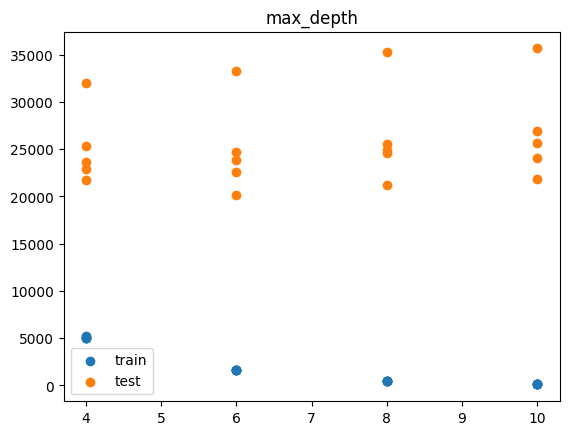

In [42]:
# max_depth = 4
xgboost_param_dic = {
    "max_depth": 6,
    "learning_rate": 0.1,
    "min_child_weight": 0,
    "colsample_bytree": 0.7,
    "n_estimators": 500,
    "early_stopping_rounds": 5,
    "verbose": False,
    "eval_metric": "rmse"}
result = hp_tuning('max_depth', 
                   [4,6,8,10], 
                   xgboost_param_dic, 
                   num_model_var, 
                   target, 
                   "xgboost",
                   df_train_engineered)
plot_result(result, "max_depth")

training reg_lambda = 2
[0]	validation_0-rmse:159760
[1]	validation_0-rmse:145843
[2]	validation_0-rmse:134063
[3]	validation_0-rmse:123216
[4]	validation_0-rmse:113813
[5]	validation_0-rmse:105064
[6]	validation_0-rmse:96955.5
[7]	validation_0-rmse:90327
[8]	validation_0-rmse:84162.2
[9]	validation_0-rmse:78430.9
[10]	validation_0-rmse:73499.1
[11]	validation_0-rmse:68894.2
[12]	validation_0-rmse:64910.6
[13]	validation_0-rmse:61483.3
[14]	validation_0-rmse:58552.3
[15]	validation_0-rmse:55719.8
[16]	validation_0-rmse:53182
[17]	validation_0-rmse:51061.9
[18]	validation_0-rmse:49106
[19]	validation_0-rmse:47411
[20]	validation_0-rmse:45888.9
[21]	validation_0-rmse:44658
[22]	validation_0-rmse:43626.9
[23]	validation_0-rmse:42524.8
[24]	validation_0-rmse:41731.1
[25]	validation_0-rmse:40845.6
[26]	validation_0-rmse:40065.7
[27]	validation_0-rmse:39572.5
[28]	validation_0-rmse:39120.7
[29]	validation_0-rmse:38744.5
[30]	validation_0-rmse:38398.8
[31]	validation_0-rmse:38039.7
[32]	valid

[261]	validation_0-rmse:32777.4
[262]	validation_0-rmse:32765.8
[263]	validation_0-rmse:32768
[264]	validation_0-rmse:32759.5
[265]	validation_0-rmse:32752.4
[266]	validation_0-rmse:32753.5
[267]	validation_0-rmse:32750
[268]	validation_0-rmse:32748.4
[269]	validation_0-rmse:32750.1
[270]	validation_0-rmse:32742
[271]	validation_0-rmse:32738.8
[272]	validation_0-rmse:32733.8
[273]	validation_0-rmse:32732.6
[274]	validation_0-rmse:32719.4
[275]	validation_0-rmse:32723.1
[276]	validation_0-rmse:32726.4
[277]	validation_0-rmse:32726.3
[278]	validation_0-rmse:32716.2
[279]	validation_0-rmse:32708.8
[280]	validation_0-rmse:32709.3
[281]	validation_0-rmse:32706
[282]	validation_0-rmse:32697.4
[283]	validation_0-rmse:32685.9
[284]	validation_0-rmse:32691.4
[285]	validation_0-rmse:32688.7
[286]	validation_0-rmse:32693.2
[287]	validation_0-rmse:32694.5
[288]	validation_0-rmse:32690.2
[289]	validation_0-rmse:32695.6
[290]	validation_0-rmse:32687.8
[291]	validation_0-rmse:32680.9
[292]	validation

[20]	validation_0-rmse:48666.5
[21]	validation_0-rmse:47134.8
[22]	validation_0-rmse:45780.9
[23]	validation_0-rmse:44746
[24]	validation_0-rmse:43491.6
[25]	validation_0-rmse:42149.1
[26]	validation_0-rmse:41112
[27]	validation_0-rmse:39914
[28]	validation_0-rmse:39460.6
[29]	validation_0-rmse:38784.2
[30]	validation_0-rmse:38198
[31]	validation_0-rmse:37946.7
[32]	validation_0-rmse:37278.6
[33]	validation_0-rmse:37053
[34]	validation_0-rmse:36540.5
[35]	validation_0-rmse:36085.1
[36]	validation_0-rmse:35376.7
[37]	validation_0-rmse:35180.5
[38]	validation_0-rmse:34553.6
[39]	validation_0-rmse:33972.4
[40]	validation_0-rmse:33882.6
[41]	validation_0-rmse:33794.3
[42]	validation_0-rmse:33631.8
[43]	validation_0-rmse:33563.9
[44]	validation_0-rmse:33159.5
[45]	validation_0-rmse:32731.2
[46]	validation_0-rmse:32355.2
[47]	validation_0-rmse:32040.9
[48]	validation_0-rmse:31966.9
[49]	validation_0-rmse:31980
[50]	validation_0-rmse:31733.5
[51]	validation_0-rmse:31731.5
[52]	validation_0-rm

[281]	validation_0-rmse:25732.7
[282]	validation_0-rmse:25721.1
[283]	validation_0-rmse:25713.9
[284]	validation_0-rmse:25684.5
[285]	validation_0-rmse:25679.1
[286]	validation_0-rmse:25685.6
[287]	validation_0-rmse:25683.5
[288]	validation_0-rmse:25687.4
[289]	validation_0-rmse:25685.9
[290]	validation_0-rmse:25678.8
[291]	validation_0-rmse:25697.2
[292]	validation_0-rmse:25690.1
[293]	validation_0-rmse:25706.2
[294]	validation_0-rmse:25705.8
[295]	validation_0-rmse:25705.3
[296]	validation_0-rmse:25715.9
[297]	validation_0-rmse:25707.6
[298]	validation_0-rmse:25693.3
[299]	validation_0-rmse:25688.9
[300]	validation_0-rmse:25666
[301]	validation_0-rmse:25663
[302]	validation_0-rmse:25662.6
[303]	validation_0-rmse:25658.5
[304]	validation_0-rmse:25643.2
[305]	validation_0-rmse:25646.6
[306]	validation_0-rmse:25651.5
[307]	validation_0-rmse:25650.1
[308]	validation_0-rmse:25647.9
[309]	validation_0-rmse:25659.7
[310]	validation_0-rmse:25651.1
[311]	validation_0-rmse:25626.4
[312]	valida

[40]	validation_0-rmse:30248.5
[41]	validation_0-rmse:30189.4
[42]	validation_0-rmse:30046
[43]	validation_0-rmse:29918.4
[44]	validation_0-rmse:29795.6
[45]	validation_0-rmse:29715.9
[46]	validation_0-rmse:29549
[47]	validation_0-rmse:29429.1
[48]	validation_0-rmse:29352
[49]	validation_0-rmse:29271.7
[50]	validation_0-rmse:29377.8
[51]	validation_0-rmse:29338.4
[52]	validation_0-rmse:29261.1
[53]	validation_0-rmse:29164.2
[54]	validation_0-rmse:29079.3
[55]	validation_0-rmse:29032.9
[56]	validation_0-rmse:28869.1
[57]	validation_0-rmse:28842.5
[58]	validation_0-rmse:28907.4
[59]	validation_0-rmse:28862
[60]	validation_0-rmse:28807.9
[61]	validation_0-rmse:28830.3
[62]	validation_0-rmse:28782.5
[63]	validation_0-rmse:28719.1
[64]	validation_0-rmse:28681.2
[65]	validation_0-rmse:28634.1
[66]	validation_0-rmse:28548.4
[67]	validation_0-rmse:28444.3
[68]	validation_0-rmse:28418
[69]	validation_0-rmse:28387.3
[70]	validation_0-rmse:28346
[71]	validation_0-rmse:28311.2
[72]	validation_0-rm

[300]	validation_0-rmse:25326.5
[301]	validation_0-rmse:25325.7
[302]	validation_0-rmse:25320.9
[303]	validation_0-rmse:25318.3
[304]	validation_0-rmse:25317.2
[305]	validation_0-rmse:25313
[306]	validation_0-rmse:25317.7
[307]	validation_0-rmse:25307.5
[308]	validation_0-rmse:25316.5
[309]	validation_0-rmse:25319.7
[310]	validation_0-rmse:25304.4
[311]	validation_0-rmse:25301.3
[312]	validation_0-rmse:25304
[313]	validation_0-rmse:25279.3
[314]	validation_0-rmse:25279.8
[315]	validation_0-rmse:25262.9
[316]	validation_0-rmse:25268.5
[317]	validation_0-rmse:25266.2
[318]	validation_0-rmse:25253.7
[319]	validation_0-rmse:25248.2
[320]	validation_0-rmse:25238
[321]	validation_0-rmse:25234.5
[322]	validation_0-rmse:25231.1
[323]	validation_0-rmse:25224.7
[324]	validation_0-rmse:25224.6
[325]	validation_0-rmse:25221.4
[326]	validation_0-rmse:25207.2
[327]	validation_0-rmse:25204.7
[328]	validation_0-rmse:25198.2
[329]	validation_0-rmse:25192.1
[330]	validation_0-rmse:25187.7
[331]	validati

[60]	validation_0-rmse:25042.5
[61]	validation_0-rmse:25022.7
[62]	validation_0-rmse:24990.2
[63]	validation_0-rmse:24934.8
[64]	validation_0-rmse:24906.6
[65]	validation_0-rmse:24873.1
[66]	validation_0-rmse:24836.6
[67]	validation_0-rmse:24815.3
[68]	validation_0-rmse:24784.5
[69]	validation_0-rmse:24759.8
[70]	validation_0-rmse:24759.2
[71]	validation_0-rmse:24718.4
[72]	validation_0-rmse:24655.4
[73]	validation_0-rmse:24605.4
[74]	validation_0-rmse:24564.2
[75]	validation_0-rmse:24550.1
[76]	validation_0-rmse:24557
[77]	validation_0-rmse:24527.6
[78]	validation_0-rmse:24443.2
[79]	validation_0-rmse:24415.4
[80]	validation_0-rmse:24417.6
[81]	validation_0-rmse:24361.3
[82]	validation_0-rmse:24323.7
[83]	validation_0-rmse:24305.8
[84]	validation_0-rmse:24267.9
[85]	validation_0-rmse:24247.8
[86]	validation_0-rmse:24199.5
[87]	validation_0-rmse:24151.6
[88]	validation_0-rmse:24134
[89]	validation_0-rmse:24095.3
[90]	validation_0-rmse:24082.3
[91]	validation_0-rmse:24062.1
[92]	validat

[320]	validation_0-rmse:21970.1
[321]	validation_0-rmse:21977.5
[322]	validation_0-rmse:21973.6
[323]	validation_0-rmse:21962.3
[324]	validation_0-rmse:21955.1
[325]	validation_0-rmse:21945.7
[326]	validation_0-rmse:21944.4
[327]	validation_0-rmse:21933.2
[328]	validation_0-rmse:21930.9
[329]	validation_0-rmse:21930.4
[330]	validation_0-rmse:21913.7
[331]	validation_0-rmse:21920.6
[332]	validation_0-rmse:21915.3
[333]	validation_0-rmse:21906.2
[334]	validation_0-rmse:21898.1
[335]	validation_0-rmse:21887.7
[336]	validation_0-rmse:21883.8
[337]	validation_0-rmse:21885.6
[338]	validation_0-rmse:21877.1
[339]	validation_0-rmse:21869.7
[340]	validation_0-rmse:21873.8
[341]	validation_0-rmse:21878.8
[342]	validation_0-rmse:21883.6
[343]	validation_0-rmse:21879
[344]	validation_0-rmse:21881.7
[345]	validation_0-rmse:21885.8
[346]	validation_0-rmse:21886.1
[347]	validation_0-rmse:21884.7
[348]	validation_0-rmse:21887.8
[349]	validation_0-rmse:21886.9
[350]	validation_0-rmse:21891.4
[351]	vali

[80]	validation_0-rmse:26600.1
[81]	validation_0-rmse:26589.6
[82]	validation_0-rmse:26566.5
[83]	validation_0-rmse:26545.1
[84]	validation_0-rmse:26420.2
[85]	validation_0-rmse:26373.8
[86]	validation_0-rmse:26309
[87]	validation_0-rmse:26290.1
[88]	validation_0-rmse:26213.6
[89]	validation_0-rmse:26180.2
[90]	validation_0-rmse:26170.4
[91]	validation_0-rmse:26183.6
[92]	validation_0-rmse:26145.8
[93]	validation_0-rmse:26106.7
[94]	validation_0-rmse:26039.5
[95]	validation_0-rmse:26026.3
[96]	validation_0-rmse:25971
[97]	validation_0-rmse:25971.8
[98]	validation_0-rmse:25939.6
[99]	validation_0-rmse:25930.1
[100]	validation_0-rmse:25893.4
[101]	validation_0-rmse:25852.2
[102]	validation_0-rmse:25841.8
[103]	validation_0-rmse:25839.4
[104]	validation_0-rmse:25831.4
[105]	validation_0-rmse:25771.2
[106]	validation_0-rmse:25732.4
[107]	validation_0-rmse:25721.1
[108]	validation_0-rmse:25709.3
[109]	validation_0-rmse:25692.8
[110]	validation_0-rmse:25694.8
[111]	validation_0-rmse:25663.8


[339]	validation_0-rmse:23913.9
[340]	validation_0-rmse:23886.3
[341]	validation_0-rmse:23883.6
[342]	validation_0-rmse:23878
[343]	validation_0-rmse:23876.3
[344]	validation_0-rmse:23880.9
[345]	validation_0-rmse:23876.1
[346]	validation_0-rmse:23874.5
[347]	validation_0-rmse:23872.3
[348]	validation_0-rmse:23869
[349]	validation_0-rmse:23856.5
[350]	validation_0-rmse:23854.6
[351]	validation_0-rmse:23852.3
[352]	validation_0-rmse:23847.8
[353]	validation_0-rmse:23840.4
[354]	validation_0-rmse:23844.8
[355]	validation_0-rmse:23850.8
[356]	validation_0-rmse:23834.1
[357]	validation_0-rmse:23834.7
[358]	validation_0-rmse:23828.6
[359]	validation_0-rmse:23822.4
[360]	validation_0-rmse:23812.8
[361]	validation_0-rmse:23804.2
[362]	validation_0-rmse:23799
[363]	validation_0-rmse:23801
[364]	validation_0-rmse:23800.2
[365]	validation_0-rmse:23793
[366]	validation_0-rmse:23781
[367]	validation_0-rmse:23776.6
[368]	validation_0-rmse:23765.5
[369]	validation_0-rmse:23762.6
[370]	validation_0-r

[100]	validation_0-rmse:33244.4
[101]	validation_0-rmse:33223.7
[102]	validation_0-rmse:33195.9
[103]	validation_0-rmse:33189.9
[104]	validation_0-rmse:33192.1
[105]	validation_0-rmse:33158.3
[106]	validation_0-rmse:33114
[107]	validation_0-rmse:33113.7
[108]	validation_0-rmse:33080.5
[109]	validation_0-rmse:33020.7
[110]	validation_0-rmse:33003
[111]	validation_0-rmse:32978.8
[112]	validation_0-rmse:32943.4
[113]	validation_0-rmse:32924.5
[114]	validation_0-rmse:32909.8
[115]	validation_0-rmse:32882.7
[116]	validation_0-rmse:32861.8
[117]	validation_0-rmse:32863.6
[118]	validation_0-rmse:32850.6
[119]	validation_0-rmse:32831.4
[120]	validation_0-rmse:32814.7
[121]	validation_0-rmse:32790.9
[122]	validation_0-rmse:32788.6
[123]	validation_0-rmse:32787.2
[124]	validation_0-rmse:32763
[125]	validation_0-rmse:32747.6
[126]	validation_0-rmse:32737.4
[127]	validation_0-rmse:32722.5
[128]	validation_0-rmse:32662
[129]	validation_0-rmse:32645.3
[130]	validation_0-rmse:32638.5
[131]	validation

[358]	validation_0-rmse:31382.3
[359]	validation_0-rmse:31390.2
[360]	validation_0-rmse:31393.7
[361]	validation_0-rmse:31394.1
[362]	validation_0-rmse:31386.8
[363]	validation_0-rmse:31385.8
[364]	validation_0-rmse:31384.5
[365]	validation_0-rmse:31386.1
[366]	validation_0-rmse:31381.2
[367]	validation_0-rmse:31385.6
[368]	validation_0-rmse:31382.4
[369]	validation_0-rmse:31374.5
[370]	validation_0-rmse:31388.6
[371]	validation_0-rmse:31390.4
[372]	validation_0-rmse:31387.7
[373]	validation_0-rmse:31374.1
[374]	validation_0-rmse:31368.5
[375]	validation_0-rmse:31367.6
[376]	validation_0-rmse:31366.3
[377]	validation_0-rmse:31361.1
[378]	validation_0-rmse:31347.9
[379]	validation_0-rmse:31360.9
[380]	validation_0-rmse:31364.5
[381]	validation_0-rmse:31367.4
[382]	validation_0-rmse:31361
[383]	validation_0-rmse:31362.3
[384]	validation_0-rmse:31359.2
[385]	validation_0-rmse:31361.4
[386]	validation_0-rmse:31356.4
[387]	validation_0-rmse:31345.1
[388]	validation_0-rmse:31338.1
[389]	vali

[120]	validation_0-rmse:29401.6
[121]	validation_0-rmse:29340.8
[122]	validation_0-rmse:29332.7
[123]	validation_0-rmse:29349.3
[124]	validation_0-rmse:29281.8
[125]	validation_0-rmse:29198.3
[126]	validation_0-rmse:29178.8
[127]	validation_0-rmse:29163
[128]	validation_0-rmse:29143.6
[129]	validation_0-rmse:29111.2
[130]	validation_0-rmse:29023
[131]	validation_0-rmse:28982.8
[132]	validation_0-rmse:28929.9
[133]	validation_0-rmse:28919.4
[134]	validation_0-rmse:28901.8
[135]	validation_0-rmse:28881.4
[136]	validation_0-rmse:28801.5
[137]	validation_0-rmse:28799.7
[138]	validation_0-rmse:28780.7
[139]	validation_0-rmse:28763.1
[140]	validation_0-rmse:28746.6
[141]	validation_0-rmse:28727
[142]	validation_0-rmse:28706.3
[143]	validation_0-rmse:28649.9
[144]	validation_0-rmse:28616.6
[145]	validation_0-rmse:28548.8
[146]	validation_0-rmse:28530.3
[147]	validation_0-rmse:28532.6
[148]	validation_0-rmse:28514.1
[149]	validation_0-rmse:28500.1
[150]	validation_0-rmse:28477.6
[151]	validati

[378]	validation_0-rmse:26036.8
[379]	validation_0-rmse:26037.2
[380]	validation_0-rmse:26029
[381]	validation_0-rmse:26042.5
[382]	validation_0-rmse:26040.9
[383]	validation_0-rmse:25999.4
[384]	validation_0-rmse:25987.5
[385]	validation_0-rmse:25982.5
[386]	validation_0-rmse:25983.2
[387]	validation_0-rmse:25982.5
[388]	validation_0-rmse:25988.3
[389]	validation_0-rmse:25985
[390]	validation_0-rmse:25986.3
[391]	validation_0-rmse:25982.5
[392]	validation_0-rmse:25984.5
[393]	validation_0-rmse:25984.2
[394]	validation_0-rmse:25978.7
[395]	validation_0-rmse:25979
[396]	validation_0-rmse:25980.4
[397]	validation_0-rmse:25968.9
[398]	validation_0-rmse:25969.1
[399]	validation_0-rmse:25967.2
[400]	validation_0-rmse:25961
[401]	validation_0-rmse:25945.1
[402]	validation_0-rmse:25948
[403]	validation_0-rmse:25935.9
[404]	validation_0-rmse:25932.1
[405]	validation_0-rmse:25913.8
[406]	validation_0-rmse:25906.5
[407]	validation_0-rmse:25911.1
[408]	validation_0-rmse:25911.7
[409]	validation_0

[140]	validation_0-rmse:28422.8
[141]	validation_0-rmse:28422.7
[142]	validation_0-rmse:28410.6
[143]	validation_0-rmse:28408.6
[144]	validation_0-rmse:28395.6
[145]	validation_0-rmse:28362.7
[146]	validation_0-rmse:28306.5
[147]	validation_0-rmse:28288
[148]	validation_0-rmse:28310.2
[149]	validation_0-rmse:28332.4
[150]	validation_0-rmse:28273.3
[151]	validation_0-rmse:28261.5
[152]	validation_0-rmse:28241.8
[153]	validation_0-rmse:28222.7
[154]	validation_0-rmse:28213.8
[155]	validation_0-rmse:28193
[156]	validation_0-rmse:28175.2
[157]	validation_0-rmse:28163.5
[158]	validation_0-rmse:28128.3
[159]	validation_0-rmse:28083.7
[160]	validation_0-rmse:28080.7
[161]	validation_0-rmse:28054.7
[162]	validation_0-rmse:28021.7
[163]	validation_0-rmse:28010.6
[164]	validation_0-rmse:27991.3
[165]	validation_0-rmse:27967.4
[166]	validation_0-rmse:27957.6
[167]	validation_0-rmse:27942.2
[168]	validation_0-rmse:27940.6
[169]	validation_0-rmse:27952.1
[170]	validation_0-rmse:27946.9
[171]	valida

[398]	validation_0-rmse:26641.7
[399]	validation_0-rmse:26640.5
[400]	validation_0-rmse:26639
[401]	validation_0-rmse:26639.3
[402]	validation_0-rmse:26643.7
[403]	validation_0-rmse:26639.6
[404]	validation_0-rmse:26638.7
[405]	validation_0-rmse:26631.1
[406]	validation_0-rmse:26620.9
[407]	validation_0-rmse:26609.7
[408]	validation_0-rmse:26610.8
[409]	validation_0-rmse:26595.5
[410]	validation_0-rmse:26594
[411]	validation_0-rmse:26602.9
[412]	validation_0-rmse:26596.6
[413]	validation_0-rmse:26588.1
[414]	validation_0-rmse:26589.4
[415]	validation_0-rmse:26592.9
[416]	validation_0-rmse:26593.1
[417]	validation_0-rmse:26589.1
[418]	validation_0-rmse:26585.8
[419]	validation_0-rmse:26587.7
[420]	validation_0-rmse:26589.3
[421]	validation_0-rmse:26593.1
[422]	validation_0-rmse:26596.5
[423]	validation_0-rmse:26605
[424]	validation_0-rmse:26607.9
[425]	validation_0-rmse:26599.5
[426]	validation_0-rmse:26594.7
[427]	validation_0-rmse:26587
[428]	validation_0-rmse:26586.9
[429]	validation

[160]	validation_0-rmse:22876
[161]	validation_0-rmse:22851.8
[162]	validation_0-rmse:22836.2
[163]	validation_0-rmse:22820
[164]	validation_0-rmse:22785.1
[165]	validation_0-rmse:22762.5
[166]	validation_0-rmse:22781.5
[167]	validation_0-rmse:22778.8
[168]	validation_0-rmse:22776.5
[169]	validation_0-rmse:22762.4
[170]	validation_0-rmse:22757.2
[171]	validation_0-rmse:22717.3
[172]	validation_0-rmse:22727.1
[173]	validation_0-rmse:22720.6
[174]	validation_0-rmse:22698.7
[175]	validation_0-rmse:22706.6
[176]	validation_0-rmse:22704
[177]	validation_0-rmse:22697.3
[178]	validation_0-rmse:22705.4
[179]	validation_0-rmse:22708.1
[180]	validation_0-rmse:22680
[181]	validation_0-rmse:22684.7
[182]	validation_0-rmse:22666.5
[183]	validation_0-rmse:22651.8
[184]	validation_0-rmse:22647.4
[185]	validation_0-rmse:22628.4
[186]	validation_0-rmse:22608.3
[187]	validation_0-rmse:22589.4
[188]	validation_0-rmse:22580.3
[189]	validation_0-rmse:22567.6
[190]	validation_0-rmse:22554.1
[191]	validation

[418]	validation_0-rmse:21728.7
[419]	validation_0-rmse:21723
[420]	validation_0-rmse:21720.1
[421]	validation_0-rmse:21715
[422]	validation_0-rmse:21725.1
[423]	validation_0-rmse:21740.1
[424]	validation_0-rmse:21739.1
[425]	validation_0-rmse:21737.3
[426]	validation_0-rmse:21737.8
[427]	validation_0-rmse:21733.4
[428]	validation_0-rmse:21738.6
[429]	validation_0-rmse:21740.1
[430]	validation_0-rmse:21739.1
[431]	validation_0-rmse:21749
[432]	validation_0-rmse:21746.9
[433]	validation_0-rmse:21751.9
[434]	validation_0-rmse:21751.4
[435]	validation_0-rmse:21746.4
[436]	validation_0-rmse:21748.5
[437]	validation_0-rmse:21749.1
[438]	validation_0-rmse:21758
[439]	validation_0-rmse:21752.3
[440]	validation_0-rmse:21744.1
[441]	validation_0-rmse:21743.8
[442]	validation_0-rmse:21736.1
[443]	validation_0-rmse:21729.7
[444]	validation_0-rmse:21725.1
[445]	validation_0-rmse:21726.8
[446]	validation_0-rmse:21728.3
[447]	validation_0-rmse:21732
[448]	validation_0-rmse:21728.1
[449]	validation_0

[180]	validation_0-rmse:25890
[181]	validation_0-rmse:25876.8
[182]	validation_0-rmse:25871.3
[183]	validation_0-rmse:25867.7
[184]	validation_0-rmse:25861.9
[185]	validation_0-rmse:25862.7
[186]	validation_0-rmse:25833.5
[187]	validation_0-rmse:25831
[188]	validation_0-rmse:25824.2
[189]	validation_0-rmse:25814
[190]	validation_0-rmse:25776.3
[191]	validation_0-rmse:25744.6
[192]	validation_0-rmse:25731.8
[193]	validation_0-rmse:25719.2
[194]	validation_0-rmse:25707.5
[195]	validation_0-rmse:25666.2
[196]	validation_0-rmse:25654.8
[197]	validation_0-rmse:25631.9
[198]	validation_0-rmse:25616.2
[199]	validation_0-rmse:25614
[200]	validation_0-rmse:25608.6
[201]	validation_0-rmse:25617.7
[202]	validation_0-rmse:25603.4
[203]	validation_0-rmse:25605.4
[204]	validation_0-rmse:25597
[205]	validation_0-rmse:25592.9
[206]	validation_0-rmse:25594.5
[207]	validation_0-rmse:25577.4
[208]	validation_0-rmse:25557.7
[209]	validation_0-rmse:25545
[210]	validation_0-rmse:25517.4
[211]	validation_0-r

[439]	validation_0-rmse:24398
[440]	validation_0-rmse:24401
[441]	validation_0-rmse:24399.7
[442]	validation_0-rmse:24396
[443]	validation_0-rmse:24394.6
[444]	validation_0-rmse:24393.3
[445]	validation_0-rmse:24388.6
[446]	validation_0-rmse:24383.6
[447]	validation_0-rmse:24383.5
[448]	validation_0-rmse:24372.9
[449]	validation_0-rmse:24375.9
[450]	validation_0-rmse:24369.7
[451]	validation_0-rmse:24369.9
[452]	validation_0-rmse:24371.2
[453]	validation_0-rmse:24370.6
[454]	validation_0-rmse:24376.1
[455]	validation_0-rmse:24368.2
[456]	validation_0-rmse:24365.3
[457]	validation_0-rmse:24360.3
[458]	validation_0-rmse:24359.4
[459]	validation_0-rmse:24359.4
[460]	validation_0-rmse:24359
[461]	validation_0-rmse:24348.6
[462]	validation_0-rmse:24347.8
[463]	validation_0-rmse:24353
[464]	validation_0-rmse:24351.1
[465]	validation_0-rmse:24347.5
[466]	validation_0-rmse:24346.7
[467]	validation_0-rmse:24346.4
[468]	validation_0-rmse:24350.5
[469]	validation_0-rmse:24345.7
[470]	validation_0

[200]	validation_0-rmse:30263.1
[201]	validation_0-rmse:30255.7
[202]	validation_0-rmse:30258.3
[203]	validation_0-rmse:30232.2
[204]	validation_0-rmse:30221
[205]	validation_0-rmse:30221.8
[206]	validation_0-rmse:30204.9
[207]	validation_0-rmse:30202
[208]	validation_0-rmse:30189.3
[209]	validation_0-rmse:30181.8
[210]	validation_0-rmse:30159.3
[211]	validation_0-rmse:30161.9
[212]	validation_0-rmse:30165.4
[213]	validation_0-rmse:30148.6
[214]	validation_0-rmse:30143.1
[215]	validation_0-rmse:30149.9
[216]	validation_0-rmse:30150.1
[217]	validation_0-rmse:30149.6
[218]	validation_0-rmse:30141.1
[219]	validation_0-rmse:30131
[220]	validation_0-rmse:30145.7
[221]	validation_0-rmse:30147.3
[222]	validation_0-rmse:30145
[223]	validation_0-rmse:30147.3
[224]	validation_0-rmse:30158.6
[225]	validation_0-rmse:30158.2
[226]	validation_0-rmse:30150.7
[227]	validation_0-rmse:30147.1
[228]	validation_0-rmse:30150.1
[229]	validation_0-rmse:30138.1
[230]	validation_0-rmse:30129.4
[231]	validation

[458]	validation_0-rmse:29547.7
[459]	validation_0-rmse:29541.2
[460]	validation_0-rmse:29540.4
[461]	validation_0-rmse:29535
[462]	validation_0-rmse:29532.4
[463]	validation_0-rmse:29525
[464]	validation_0-rmse:29536.1
[465]	validation_0-rmse:29536.3
[466]	validation_0-rmse:29529.4
[467]	validation_0-rmse:29522.2
[468]	validation_0-rmse:29522.1
[469]	validation_0-rmse:29510.7
[470]	validation_0-rmse:29519.7
[471]	validation_0-rmse:29516.7
[472]	validation_0-rmse:29524
[473]	validation_0-rmse:29515.4
[474]	validation_0-rmse:29514.1
[475]	validation_0-rmse:29513
[476]	validation_0-rmse:29508
[477]	validation_0-rmse:29513.1
[478]	validation_0-rmse:29518.8
[479]	validation_0-rmse:29519.1
[480]	validation_0-rmse:29518
[481]	validation_0-rmse:29509.4
[482]	validation_0-rmse:29509.7
[483]	validation_0-rmse:29505.8
[484]	validation_0-rmse:29501.4
[485]	validation_0-rmse:29509.6
[486]	validation_0-rmse:29512.1
[487]	validation_0-rmse:29511.1
[488]	validation_0-rmse:29508
[489]	validation_0-rms

[220]	validation_0-rmse:31564.6
[221]	validation_0-rmse:31531.1
[222]	validation_0-rmse:31565.8
[223]	validation_0-rmse:31562.4
[224]	validation_0-rmse:31562.2
[225]	validation_0-rmse:31576.9
[226]	validation_0-rmse:31595
[227]	validation_0-rmse:31571.1
[228]	validation_0-rmse:31572
[229]	validation_0-rmse:31563.3
[230]	validation_0-rmse:31547.3
[231]	validation_0-rmse:31536.2
[232]	validation_0-rmse:31489.6
[233]	validation_0-rmse:31466.6
[234]	validation_0-rmse:31461.5
[235]	validation_0-rmse:31437.8
[236]	validation_0-rmse:31431.8
[237]	validation_0-rmse:31435.3
[238]	validation_0-rmse:31411
[239]	validation_0-rmse:31408.9
[240]	validation_0-rmse:31439.8
[241]	validation_0-rmse:31442.9
[242]	validation_0-rmse:31424.2
[243]	validation_0-rmse:31399.7
[244]	validation_0-rmse:31384.4
[245]	validation_0-rmse:31375.2
[246]	validation_0-rmse:31360.5
[247]	validation_0-rmse:31337.9
[248]	validation_0-rmse:31304.9
[249]	validation_0-rmse:31300.1
[250]	validation_0-rmse:31289.1
[251]	validati

[478]	validation_0-rmse:29602.5
[479]	validation_0-rmse:29603.4
[480]	validation_0-rmse:29603.8
[481]	validation_0-rmse:29602.8
[482]	validation_0-rmse:29604
[483]	validation_0-rmse:29586.7
[484]	validation_0-rmse:29553.7
[485]	validation_0-rmse:29558.7
[486]	validation_0-rmse:29558.1
[487]	validation_0-rmse:29560
[488]	validation_0-rmse:29536.6
[489]	validation_0-rmse:29536.5
[490]	validation_0-rmse:29534.9
[491]	validation_0-rmse:29496.3
[492]	validation_0-rmse:29486.9
[493]	validation_0-rmse:29485.6
[494]	validation_0-rmse:29486.2
[495]	validation_0-rmse:29485
[496]	validation_0-rmse:29482.8
[497]	validation_0-rmse:29478.8
[498]	validation_0-rmse:29478.1
[499]	validation_0-rmse:29477
[0]	validation_0-rmse:154617
[1]	validation_0-rmse:141237
[2]	validation_0-rmse:129411
[3]	validation_0-rmse:118837
[4]	validation_0-rmse:109106
[5]	validation_0-rmse:100222
[6]	validation_0-rmse:92031.6
[7]	validation_0-rmse:85322
[8]	validation_0-rmse:79432.1
[9]	validation_0-rmse:74161.8
[10]	validat

[240]	validation_0-rmse:26360
[241]	validation_0-rmse:26347.3
[242]	validation_0-rmse:26357.7
[243]	validation_0-rmse:26344.9
[244]	validation_0-rmse:26329.8
[245]	validation_0-rmse:26324.7
[246]	validation_0-rmse:26314.3
[247]	validation_0-rmse:26308.1
[248]	validation_0-rmse:26301.8
[249]	validation_0-rmse:26284.1
[250]	validation_0-rmse:26279.1
[251]	validation_0-rmse:26272.6
[252]	validation_0-rmse:26269.8
[253]	validation_0-rmse:26265.4
[254]	validation_0-rmse:26244.9
[255]	validation_0-rmse:26244.5
[256]	validation_0-rmse:26246.9
[257]	validation_0-rmse:26222.8
[258]	validation_0-rmse:26209.7
[259]	validation_0-rmse:26196
[260]	validation_0-rmse:26163.6
[261]	validation_0-rmse:26135.3
[262]	validation_0-rmse:26126.4
[263]	validation_0-rmse:26111.6
[264]	validation_0-rmse:26098.6
[265]	validation_0-rmse:26090
[266]	validation_0-rmse:26088.5
[267]	validation_0-rmse:26070.7
[268]	validation_0-rmse:26065.3
[269]	validation_0-rmse:26056.2
[270]	validation_0-rmse:26041.5
[271]	validati

[498]	validation_0-rmse:25408.9
[499]	validation_0-rmse:25405.4
[0]	validation_0-rmse:161483
[1]	validation_0-rmse:147609
[2]	validation_0-rmse:135249
[3]	validation_0-rmse:124223
[4]	validation_0-rmse:113958
[5]	validation_0-rmse:104703
[6]	validation_0-rmse:96597.5
[7]	validation_0-rmse:89256.5
[8]	validation_0-rmse:82898.6
[9]	validation_0-rmse:77238.8
[10]	validation_0-rmse:72141.8
[11]	validation_0-rmse:67442.5
[12]	validation_0-rmse:63199
[13]	validation_0-rmse:59253.5
[14]	validation_0-rmse:55580.1
[15]	validation_0-rmse:52348.3
[16]	validation_0-rmse:49575.4
[17]	validation_0-rmse:47110.8
[18]	validation_0-rmse:44992.9
[19]	validation_0-rmse:42964.3
[20]	validation_0-rmse:41102.9
[21]	validation_0-rmse:39367.6
[22]	validation_0-rmse:38153.6
[23]	validation_0-rmse:36715.3
[24]	validation_0-rmse:35442.9
[25]	validation_0-rmse:34253.7
[26]	validation_0-rmse:33272.6
[27]	validation_0-rmse:32326.4
[28]	validation_0-rmse:31606.2
[29]	validation_0-rmse:31134.9
[30]	validation_0-rmse:3

[260]	validation_0-rmse:22423.4
[261]	validation_0-rmse:22409.8
[262]	validation_0-rmse:22409.8
[263]	validation_0-rmse:22394
[264]	validation_0-rmse:22388.8
[265]	validation_0-rmse:22400
[266]	validation_0-rmse:22405
[267]	validation_0-rmse:22396.6
[268]	validation_0-rmse:22387.6
[269]	validation_0-rmse:22383.2
[270]	validation_0-rmse:22366.8
[271]	validation_0-rmse:22366.4
[272]	validation_0-rmse:22354.7
[273]	validation_0-rmse:22369.6
[274]	validation_0-rmse:22348.3
[275]	validation_0-rmse:22325.4
[276]	validation_0-rmse:22326.7
[277]	validation_0-rmse:22323.7
[278]	validation_0-rmse:22324.7
[279]	validation_0-rmse:22320.3
[280]	validation_0-rmse:22309.7
[281]	validation_0-rmse:22303.6
[282]	validation_0-rmse:22291.4
[283]	validation_0-rmse:22285.9
[284]	validation_0-rmse:22277.5
[285]	validation_0-rmse:22264.7
[286]	validation_0-rmse:22238.9
[287]	validation_0-rmse:22235.7
[288]	validation_0-rmse:22238.6
[289]	validation_0-rmse:22221.9
[290]	validation_0-rmse:22216.2
[291]	validati

[19]	validation_0-rmse:45429
[20]	validation_0-rmse:43831.8
[21]	validation_0-rmse:42519.3
[22]	validation_0-rmse:41371.8
[23]	validation_0-rmse:40402.4
[24]	validation_0-rmse:39508.1
[25]	validation_0-rmse:38679.6
[26]	validation_0-rmse:37970.9
[27]	validation_0-rmse:37357.7
[28]	validation_0-rmse:36743.6
[29]	validation_0-rmse:36195.3
[30]	validation_0-rmse:35700.8
[31]	validation_0-rmse:35211.8
[32]	validation_0-rmse:34852.9
[33]	validation_0-rmse:34471.8
[34]	validation_0-rmse:34036.1
[35]	validation_0-rmse:33706.6
[36]	validation_0-rmse:33331.7
[37]	validation_0-rmse:32985.8
[38]	validation_0-rmse:32702.6
[39]	validation_0-rmse:32402.7
[40]	validation_0-rmse:32173.3
[41]	validation_0-rmse:31908.4
[42]	validation_0-rmse:31673.5
[43]	validation_0-rmse:31419.7
[44]	validation_0-rmse:31223.8
[45]	validation_0-rmse:30994.4
[46]	validation_0-rmse:30786.3
[47]	validation_0-rmse:30645.1
[48]	validation_0-rmse:30549
[49]	validation_0-rmse:30371.9
[50]	validation_0-rmse:30318.4
[51]	validat

[280]	validation_0-rmse:24805.4
[281]	validation_0-rmse:24801.3
[282]	validation_0-rmse:24789.9
[283]	validation_0-rmse:24790
[284]	validation_0-rmse:24768.9
[285]	validation_0-rmse:24757.6
[286]	validation_0-rmse:24750.5
[287]	validation_0-rmse:24738.1
[288]	validation_0-rmse:24720.5
[289]	validation_0-rmse:24720.2
[290]	validation_0-rmse:24711.9
[291]	validation_0-rmse:24695.2
[292]	validation_0-rmse:24679.1
[293]	validation_0-rmse:24674.1
[294]	validation_0-rmse:24657.3
[295]	validation_0-rmse:24649.9
[296]	validation_0-rmse:24640.2
[297]	validation_0-rmse:24643.9
[298]	validation_0-rmse:24639.8
[299]	validation_0-rmse:24627.5
[300]	validation_0-rmse:24640.4
[301]	validation_0-rmse:24638.9
[302]	validation_0-rmse:24633.4
[303]	validation_0-rmse:24637.2
[304]	validation_0-rmse:24628.6
[305]	validation_0-rmse:24625.8
[306]	validation_0-rmse:24612.8
[307]	validation_0-rmse:24593.3
[308]	validation_0-rmse:24570.4
[309]	validation_0-rmse:24571.4
[310]	validation_0-rmse:24560.4
[311]	vali

[39]	validation_0-rmse:36681.9
[40]	validation_0-rmse:36450
[41]	validation_0-rmse:36225.5
[42]	validation_0-rmse:35979.7
[43]	validation_0-rmse:35854.9
[44]	validation_0-rmse:35766.9
[45]	validation_0-rmse:35556.1
[46]	validation_0-rmse:35438.5
[47]	validation_0-rmse:35312.3
[48]	validation_0-rmse:35181
[49]	validation_0-rmse:35108.4
[50]	validation_0-rmse:34986.1
[51]	validation_0-rmse:34915
[52]	validation_0-rmse:34811.6
[53]	validation_0-rmse:34765.7
[54]	validation_0-rmse:34737.2
[55]	validation_0-rmse:34710
[56]	validation_0-rmse:34644.9
[57]	validation_0-rmse:34606.1
[58]	validation_0-rmse:34593.3
[59]	validation_0-rmse:34585.5
[60]	validation_0-rmse:34537.9
[61]	validation_0-rmse:34513.1
[62]	validation_0-rmse:34506.1
[63]	validation_0-rmse:34465.7
[64]	validation_0-rmse:34443
[65]	validation_0-rmse:34310.8
[66]	validation_0-rmse:34250.5
[67]	validation_0-rmse:34189.4
[68]	validation_0-rmse:34173.6
[69]	validation_0-rmse:34163.5
[70]	validation_0-rmse:34158
[71]	validation_0-rm

[299]	validation_0-rmse:30875.7
[300]	validation_0-rmse:30868.2
[301]	validation_0-rmse:30865.6
[302]	validation_0-rmse:30870.2
[303]	validation_0-rmse:30885.4
[304]	validation_0-rmse:30885.7
[305]	validation_0-rmse:30883.1
[306]	validation_0-rmse:30883.5
[307]	validation_0-rmse:30879.6
[308]	validation_0-rmse:30876.5
[309]	validation_0-rmse:30868.9
[310]	validation_0-rmse:30858.8
[311]	validation_0-rmse:30852.9
[312]	validation_0-rmse:30852.8
[313]	validation_0-rmse:30849.5
[314]	validation_0-rmse:30855.3
[315]	validation_0-rmse:30834.9
[316]	validation_0-rmse:30819.9
[317]	validation_0-rmse:30818
[318]	validation_0-rmse:30817.4
[319]	validation_0-rmse:30815.3
[320]	validation_0-rmse:30811.7
[321]	validation_0-rmse:30817.1
[322]	validation_0-rmse:30811.1
[323]	validation_0-rmse:30804.2
[324]	validation_0-rmse:30794.2
[325]	validation_0-rmse:30794.8
[326]	validation_0-rmse:30790.5
[327]	validation_0-rmse:30779.4
[328]	validation_0-rmse:30777.2
[329]	validation_0-rmse:30777.8
[330]	vali

[60]	validation_0-rmse:40464.6
[61]	validation_0-rmse:40211.1
[62]	validation_0-rmse:40142.2
[63]	validation_0-rmse:40041.7
[64]	validation_0-rmse:39878.4
[65]	validation_0-rmse:39707.1
[66]	validation_0-rmse:39462.1
[67]	validation_0-rmse:39438.3
[68]	validation_0-rmse:39381.2
[69]	validation_0-rmse:39296.2
[70]	validation_0-rmse:39222.6
[71]	validation_0-rmse:39136.8
[72]	validation_0-rmse:39117.5
[73]	validation_0-rmse:39076.4
[74]	validation_0-rmse:39038.6
[75]	validation_0-rmse:38837.6
[76]	validation_0-rmse:38782.1
[77]	validation_0-rmse:38775.9
[78]	validation_0-rmse:38696.5
[79]	validation_0-rmse:38649.8
[80]	validation_0-rmse:38607.5
[81]	validation_0-rmse:38559.1
[82]	validation_0-rmse:38445.9
[83]	validation_0-rmse:38352.9
[84]	validation_0-rmse:38341.4
[85]	validation_0-rmse:38293.9
[86]	validation_0-rmse:38217.1
[87]	validation_0-rmse:38122.2
[88]	validation_0-rmse:38097.6
[89]	validation_0-rmse:38074.4
[90]	validation_0-rmse:38068
[91]	validation_0-rmse:38001.7
[92]	valid

[319]	validation_0-rmse:30249.3
[320]	validation_0-rmse:30246.4
[321]	validation_0-rmse:30231.7
[322]	validation_0-rmse:30220.6
[323]	validation_0-rmse:30205.9
[324]	validation_0-rmse:30217.3
[325]	validation_0-rmse:30213.3
[326]	validation_0-rmse:30217.2
[327]	validation_0-rmse:30226.8
[328]	validation_0-rmse:30231.1
[329]	validation_0-rmse:30201.3
[330]	validation_0-rmse:30196.8
[331]	validation_0-rmse:30172.3
[332]	validation_0-rmse:30173.7
[333]	validation_0-rmse:30159.6
[334]	validation_0-rmse:30163.1
[335]	validation_0-rmse:30138.5
[336]	validation_0-rmse:30127.7
[337]	validation_0-rmse:30104.1
[338]	validation_0-rmse:30087.5
[339]	validation_0-rmse:30090.8
[340]	validation_0-rmse:30085
[341]	validation_0-rmse:30073.2
[342]	validation_0-rmse:30022.2
[343]	validation_0-rmse:30024.8
[344]	validation_0-rmse:30020.8
[345]	validation_0-rmse:30018.9
[346]	validation_0-rmse:29989.3
[347]	validation_0-rmse:29991
[348]	validation_0-rmse:30000
[349]	validation_0-rmse:29963
[350]	validation

[80]	validation_0-rmse:28821.7
[81]	validation_0-rmse:28840.6
[82]	validation_0-rmse:28789.5
[83]	validation_0-rmse:28815.9
[84]	validation_0-rmse:28786.3
[85]	validation_0-rmse:28744.7
[86]	validation_0-rmse:28721.9
[87]	validation_0-rmse:28688.3
[88]	validation_0-rmse:28699.4
[89]	validation_0-rmse:28678.2
[90]	validation_0-rmse:28670.4
[91]	validation_0-rmse:28677.5
[92]	validation_0-rmse:28653.9
[93]	validation_0-rmse:28661.7
[94]	validation_0-rmse:28637.7
[95]	validation_0-rmse:28600.9
[96]	validation_0-rmse:28564.9
[97]	validation_0-rmse:28536.8
[98]	validation_0-rmse:28559.1
[99]	validation_0-rmse:28547.4
[100]	validation_0-rmse:28513.2
[101]	validation_0-rmse:28436.2
[102]	validation_0-rmse:28436.1
[103]	validation_0-rmse:28395.1
[104]	validation_0-rmse:28346.9
[105]	validation_0-rmse:28308.8
[106]	validation_0-rmse:28312.6
[107]	validation_0-rmse:28301.6
[108]	validation_0-rmse:28264.5
[109]	validation_0-rmse:28240.1
[110]	validation_0-rmse:28217.8
[111]	validation_0-rmse:2820

[339]	validation_0-rmse:25686.6
[340]	validation_0-rmse:25699
[341]	validation_0-rmse:25699.1
[342]	validation_0-rmse:25689.5
[343]	validation_0-rmse:25682.9
[344]	validation_0-rmse:25680.6
[345]	validation_0-rmse:25675.8
[346]	validation_0-rmse:25665.7
[347]	validation_0-rmse:25678.4
[348]	validation_0-rmse:25671
[349]	validation_0-rmse:25668.6
[350]	validation_0-rmse:25654.4
[351]	validation_0-rmse:25650.5
[352]	validation_0-rmse:25641.9
[353]	validation_0-rmse:25647.7
[354]	validation_0-rmse:25657.8
[355]	validation_0-rmse:25652.7
[356]	validation_0-rmse:25648.8
[357]	validation_0-rmse:25642
[358]	validation_0-rmse:25626.4
[359]	validation_0-rmse:25626.3
[360]	validation_0-rmse:25612.7
[361]	validation_0-rmse:25612.7
[362]	validation_0-rmse:25607.7
[363]	validation_0-rmse:25601.7
[364]	validation_0-rmse:25597.5
[365]	validation_0-rmse:25592.6
[366]	validation_0-rmse:25599.4
[367]	validation_0-rmse:25606.4
[368]	validation_0-rmse:25591.4
[369]	validation_0-rmse:25579.3
[370]	validati

[101]	validation_0-rmse:25040.4
[102]	validation_0-rmse:25030.9
[103]	validation_0-rmse:25001.4
[104]	validation_0-rmse:24992.8
[105]	validation_0-rmse:25004.1
[106]	validation_0-rmse:25007.1
[107]	validation_0-rmse:24998.8
[108]	validation_0-rmse:25014.9
[109]	validation_0-rmse:25020
[110]	validation_0-rmse:24991.9
[111]	validation_0-rmse:24988.2
[112]	validation_0-rmse:24985.3
[113]	validation_0-rmse:24995.4
[114]	validation_0-rmse:24966.8
[115]	validation_0-rmse:24990.4
[116]	validation_0-rmse:25008
[117]	validation_0-rmse:25055.8
[118]	validation_0-rmse:25039.7
[119]	validation_0-rmse:25024.4
[120]	validation_0-rmse:25026.4
[121]	validation_0-rmse:25039.7
[122]	validation_0-rmse:25054.8
[123]	validation_0-rmse:25056.9
[124]	validation_0-rmse:25058.2
[125]	validation_0-rmse:25072.1
[126]	validation_0-rmse:25093.9
[127]	validation_0-rmse:25097
[128]	validation_0-rmse:25118.5
[129]	validation_0-rmse:25124.1
[130]	validation_0-rmse:25104
[131]	validation_0-rmse:25118.6
[132]	validation

[360]	validation_0-rmse:24718.5
[361]	validation_0-rmse:24718.5
[362]	validation_0-rmse:24718.3
[363]	validation_0-rmse:24707.3
[364]	validation_0-rmse:24706
[365]	validation_0-rmse:24695.3
[366]	validation_0-rmse:24684.2
[367]	validation_0-rmse:24683
[368]	validation_0-rmse:24671
[369]	validation_0-rmse:24669.1
[370]	validation_0-rmse:24659.1
[371]	validation_0-rmse:24658.3
[372]	validation_0-rmse:24673
[373]	validation_0-rmse:24679
[374]	validation_0-rmse:24680.2
[375]	validation_0-rmse:24663.3
[376]	validation_0-rmse:24658.2
[377]	validation_0-rmse:24656.5
[378]	validation_0-rmse:24634.2
[379]	validation_0-rmse:24631.6
[380]	validation_0-rmse:24632.8
[381]	validation_0-rmse:24630.2
[382]	validation_0-rmse:24645.2
[383]	validation_0-rmse:24646.6
[384]	validation_0-rmse:24646.8
[385]	validation_0-rmse:24640
[386]	validation_0-rmse:24641.5
[387]	validation_0-rmse:24661.5
[388]	validation_0-rmse:24652.2
[389]	validation_0-rmse:24650.5
[390]	validation_0-rmse:24645.3
[391]	validation_0-r

[122]	validation_0-rmse:29549.2
[123]	validation_0-rmse:29536.6
[124]	validation_0-rmse:29518.8
[125]	validation_0-rmse:29476.9
[126]	validation_0-rmse:29457.8
[127]	validation_0-rmse:29449
[128]	validation_0-rmse:29429.7
[129]	validation_0-rmse:29406.1
[130]	validation_0-rmse:29389
[131]	validation_0-rmse:29375.1
[132]	validation_0-rmse:29360
[133]	validation_0-rmse:29342.3
[134]	validation_0-rmse:29335.5
[135]	validation_0-rmse:29303.8
[136]	validation_0-rmse:29254
[137]	validation_0-rmse:29215.1
[138]	validation_0-rmse:29180.6
[139]	validation_0-rmse:29169.9
[140]	validation_0-rmse:29160
[141]	validation_0-rmse:29141.7
[142]	validation_0-rmse:29127.9
[143]	validation_0-rmse:29106.8
[144]	validation_0-rmse:29102.8
[145]	validation_0-rmse:29088.6
[146]	validation_0-rmse:29079.7
[147]	validation_0-rmse:29071.9
[148]	validation_0-rmse:29036.9
[149]	validation_0-rmse:29024.7
[150]	validation_0-rmse:29026.1
[151]	validation_0-rmse:29003.6
[152]	validation_0-rmse:28983.3
[153]	validation_0

[380]	validation_0-rmse:26608.1
[381]	validation_0-rmse:26601.9
[382]	validation_0-rmse:26595.1
[383]	validation_0-rmse:26592.8
[384]	validation_0-rmse:26589
[385]	validation_0-rmse:26584.5
[386]	validation_0-rmse:26583.8
[387]	validation_0-rmse:26579.4
[388]	validation_0-rmse:26579.1
[389]	validation_0-rmse:26569.1
[390]	validation_0-rmse:26568.8
[391]	validation_0-rmse:26564.4
[392]	validation_0-rmse:26563.8
[393]	validation_0-rmse:26551.9
[394]	validation_0-rmse:26548.7
[395]	validation_0-rmse:26548.3
[396]	validation_0-rmse:26547.6
[397]	validation_0-rmse:26541.9
[398]	validation_0-rmse:26541.4
[399]	validation_0-rmse:26527.5
[400]	validation_0-rmse:26523.3
[401]	validation_0-rmse:26544
[402]	validation_0-rmse:26537.5
[403]	validation_0-rmse:26529
[404]	validation_0-rmse:26512
[405]	validation_0-rmse:26488.7
[406]	validation_0-rmse:26478.4
[407]	validation_0-rmse:26474.1
[408]	validation_0-rmse:26467.6
[409]	validation_0-rmse:26471.7
[410]	validation_0-rmse:26466.7
[411]	validation

[141]	validation_0-rmse:35975.2
[142]	validation_0-rmse:35964.3
[143]	validation_0-rmse:35950.7
[144]	validation_0-rmse:35961.1
[145]	validation_0-rmse:35969.9
[146]	validation_0-rmse:35968.4
[147]	validation_0-rmse:35971
[148]	validation_0-rmse:35976.7
[149]	validation_0-rmse:35967.6
[150]	validation_0-rmse:35914.6
[151]	validation_0-rmse:35914.7
[152]	validation_0-rmse:35868.5
[153]	validation_0-rmse:35855.9
[154]	validation_0-rmse:35801.7
[155]	validation_0-rmse:35795.4
[156]	validation_0-rmse:35790.9
[157]	validation_0-rmse:35767.9
[158]	validation_0-rmse:35767.5
[159]	validation_0-rmse:35745.5
[160]	validation_0-rmse:35726.8
[161]	validation_0-rmse:35712.3
[162]	validation_0-rmse:35689.7
[163]	validation_0-rmse:35691.3
[164]	validation_0-rmse:35689.7
[165]	validation_0-rmse:35638.9
[166]	validation_0-rmse:35637.8
[167]	validation_0-rmse:35655
[168]	validation_0-rmse:35641.7
[169]	validation_0-rmse:35640.9
[170]	validation_0-rmse:35598.1
[171]	validation_0-rmse:35610
[172]	validati

[399]	validation_0-rmse:34812.6
[400]	validation_0-rmse:34829.4
[401]	validation_0-rmse:34831.7
[402]	validation_0-rmse:34831.1
[403]	validation_0-rmse:34835.9
[404]	validation_0-rmse:34848.3
[405]	validation_0-rmse:34836.5
[406]	validation_0-rmse:34831.8
[407]	validation_0-rmse:34835.4
[408]	validation_0-rmse:34838.2
[409]	validation_0-rmse:34836.2
[410]	validation_0-rmse:34828.9
[411]	validation_0-rmse:34830.2
[412]	validation_0-rmse:34825
[413]	validation_0-rmse:34821.1
[414]	validation_0-rmse:34813.5
[415]	validation_0-rmse:34813.4
[416]	validation_0-rmse:34806.4
[417]	validation_0-rmse:34795.6
[418]	validation_0-rmse:34786.8
[419]	validation_0-rmse:34785.4
[420]	validation_0-rmse:34786.8
[421]	validation_0-rmse:34800.9
[422]	validation_0-rmse:34787.9
[423]	validation_0-rmse:34789.3
[424]	validation_0-rmse:34782.9
[425]	validation_0-rmse:34785.5
[426]	validation_0-rmse:34783.1
[427]	validation_0-rmse:34777.4
[428]	validation_0-rmse:34770.6
[429]	validation_0-rmse:34767.2
[430]	vali

[161]	validation_0-rmse:34748.5
[162]	validation_0-rmse:34687.3
[163]	validation_0-rmse:34623.4
[164]	validation_0-rmse:34611.6
[165]	validation_0-rmse:34547.5
[166]	validation_0-rmse:34525.3
[167]	validation_0-rmse:34468.6
[168]	validation_0-rmse:34420.8
[169]	validation_0-rmse:34401.8
[170]	validation_0-rmse:34360.6
[171]	validation_0-rmse:34257.9
[172]	validation_0-rmse:34183.7
[173]	validation_0-rmse:34153.9
[174]	validation_0-rmse:34136.8
[175]	validation_0-rmse:34102.6
[176]	validation_0-rmse:34076.1
[177]	validation_0-rmse:34042.5
[178]	validation_0-rmse:34027.2
[179]	validation_0-rmse:33940.6
[180]	validation_0-rmse:33893.6
[181]	validation_0-rmse:33888.4
[182]	validation_0-rmse:33852.7
[183]	validation_0-rmse:33798.4
[184]	validation_0-rmse:33793.9
[185]	validation_0-rmse:33758.1
[186]	validation_0-rmse:33746.9
[187]	validation_0-rmse:33676.5
[188]	validation_0-rmse:33659.9
[189]	validation_0-rmse:33592.6
[190]	validation_0-rmse:33571.6
[191]	validation_0-rmse:33547.2
[192]	va

[419]	validation_0-rmse:28735.6
[420]	validation_0-rmse:28720.5
[421]	validation_0-rmse:28697.9
[422]	validation_0-rmse:28692.5
[423]	validation_0-rmse:28690
[424]	validation_0-rmse:28689.3
[425]	validation_0-rmse:28689.9
[426]	validation_0-rmse:28688.8
[427]	validation_0-rmse:28690.2
[428]	validation_0-rmse:28661.6
[429]	validation_0-rmse:28640.6
[430]	validation_0-rmse:28638.2
[431]	validation_0-rmse:28639.9
[432]	validation_0-rmse:28635.9
[433]	validation_0-rmse:28611.8
[434]	validation_0-rmse:28611.8
[435]	validation_0-rmse:28613.5
[436]	validation_0-rmse:28618
[437]	validation_0-rmse:28606.4
[438]	validation_0-rmse:28606.7
[439]	validation_0-rmse:28568.9
[440]	validation_0-rmse:28569.6
[441]	validation_0-rmse:28555.6
[442]	validation_0-rmse:28548.2
[443]	validation_0-rmse:28547.6
[444]	validation_0-rmse:28548.6
[445]	validation_0-rmse:28550.3
[446]	validation_0-rmse:28558.7
[447]	validation_0-rmse:28551.1
[448]	validation_0-rmse:28548.3
[449]	validation_0-rmse:28549
[450]	validati

[181]	validation_0-rmse:26234.3
[182]	validation_0-rmse:26222.4
[183]	validation_0-rmse:26212.5
[184]	validation_0-rmse:26198.8
[185]	validation_0-rmse:26196.9
[186]	validation_0-rmse:26189.6
[187]	validation_0-rmse:26172.3
[188]	validation_0-rmse:26170.3
[189]	validation_0-rmse:26164.2
[190]	validation_0-rmse:26144.2
[191]	validation_0-rmse:26163.7
[192]	validation_0-rmse:26153.3
[193]	validation_0-rmse:26137
[194]	validation_0-rmse:26120.6
[195]	validation_0-rmse:26138.7
[196]	validation_0-rmse:26156.6
[197]	validation_0-rmse:26151.3
[198]	validation_0-rmse:26146.1
[199]	validation_0-rmse:26137.3
[200]	validation_0-rmse:26124.4
[201]	validation_0-rmse:26124.8
[202]	validation_0-rmse:26107.1
[203]	validation_0-rmse:26103
[204]	validation_0-rmse:26118
[205]	validation_0-rmse:26106.8
[206]	validation_0-rmse:26081
[207]	validation_0-rmse:26066.9
[208]	validation_0-rmse:26053
[209]	validation_0-rmse:26059.2
[210]	validation_0-rmse:26066.5
[211]	validation_0-rmse:26036.1
[212]	validation_0

[440]	validation_0-rmse:24743
[441]	validation_0-rmse:24743.8
[442]	validation_0-rmse:24742.9
[443]	validation_0-rmse:24732.9
[444]	validation_0-rmse:24709.4
[445]	validation_0-rmse:24712.6
[446]	validation_0-rmse:24705.9
[447]	validation_0-rmse:24679
[448]	validation_0-rmse:24669.5
[449]	validation_0-rmse:24662.8
[450]	validation_0-rmse:24655.2
[451]	validation_0-rmse:24659
[452]	validation_0-rmse:24652.5
[453]	validation_0-rmse:24653.9
[454]	validation_0-rmse:24624
[455]	validation_0-rmse:24610.5
[456]	validation_0-rmse:24605.4
[457]	validation_0-rmse:24593
[458]	validation_0-rmse:24575.8
[459]	validation_0-rmse:24574.1
[460]	validation_0-rmse:24569.9
[461]	validation_0-rmse:24567.6
[462]	validation_0-rmse:24567.5
[463]	validation_0-rmse:24578.2
[464]	validation_0-rmse:24577.6
[465]	validation_0-rmse:24571.2
[466]	validation_0-rmse:24569.6
[467]	validation_0-rmse:24557.6
[468]	validation_0-rmse:24550.8
[469]	validation_0-rmse:24541.4
[470]	validation_0-rmse:24550.6
[471]	validation_0

[202]	validation_0-rmse:24427.1
[203]	validation_0-rmse:24439.4
[204]	validation_0-rmse:24435.3
[205]	validation_0-rmse:24426.7
[206]	validation_0-rmse:24435.2
[207]	validation_0-rmse:24430.5
[208]	validation_0-rmse:24434.9
[209]	validation_0-rmse:24410.5
[210]	validation_0-rmse:24380.8
[211]	validation_0-rmse:24387.9
[212]	validation_0-rmse:24378.1
[213]	validation_0-rmse:24375
[214]	validation_0-rmse:24386.8
[215]	validation_0-rmse:24396.3
[216]	validation_0-rmse:24408.1
[217]	validation_0-rmse:24389.1
[218]	validation_0-rmse:24387.4
[219]	validation_0-rmse:24402.2
[220]	validation_0-rmse:24400.9
[221]	validation_0-rmse:24406.8
[222]	validation_0-rmse:24393.9
[223]	validation_0-rmse:24380.2
[224]	validation_0-rmse:24375.2
[225]	validation_0-rmse:24377.4
[226]	validation_0-rmse:24376.1
[227]	validation_0-rmse:24402.1
[228]	validation_0-rmse:24389.1
[229]	validation_0-rmse:24397.1
[230]	validation_0-rmse:24399.1
[231]	validation_0-rmse:24402.9
[232]	validation_0-rmse:24406.1
[233]	vali

[460]	validation_0-rmse:24355.2
[461]	validation_0-rmse:24356.8
[462]	validation_0-rmse:24355.3
[463]	validation_0-rmse:24356.7
[464]	validation_0-rmse:24356.9
[465]	validation_0-rmse:24350.7
[466]	validation_0-rmse:24342.8
[467]	validation_0-rmse:24348.6
[468]	validation_0-rmse:24337.9
[469]	validation_0-rmse:24335.3
[470]	validation_0-rmse:24328
[471]	validation_0-rmse:24330
[472]	validation_0-rmse:24336.5
[473]	validation_0-rmse:24338.8
[474]	validation_0-rmse:24333.6
[475]	validation_0-rmse:24328.8
[476]	validation_0-rmse:24335.3
[477]	validation_0-rmse:24335.3
[478]	validation_0-rmse:24334.9
[479]	validation_0-rmse:24324.5
[480]	validation_0-rmse:24311.9
[481]	validation_0-rmse:24314.9
[482]	validation_0-rmse:24316.8
[483]	validation_0-rmse:24316.8
[484]	validation_0-rmse:24304.1
[485]	validation_0-rmse:24294.8
[486]	validation_0-rmse:24282.5
[487]	validation_0-rmse:24285.7
[488]	validation_0-rmse:24288.5
[489]	validation_0-rmse:24277
[490]	validation_0-rmse:24277.1
[491]	validati

[221]	validation_0-rmse:29177.6
[222]	validation_0-rmse:29180.1
[223]	validation_0-rmse:29172.2
[224]	validation_0-rmse:29163.9
[225]	validation_0-rmse:29163.9
[226]	validation_0-rmse:29157.2
[227]	validation_0-rmse:29155
[228]	validation_0-rmse:29146.6
[229]	validation_0-rmse:29136.4
[230]	validation_0-rmse:29117.9
[231]	validation_0-rmse:29115.1
[232]	validation_0-rmse:29118.1
[233]	validation_0-rmse:29109.2
[234]	validation_0-rmse:29095.3
[235]	validation_0-rmse:29090.1
[236]	validation_0-rmse:29086
[237]	validation_0-rmse:29081
[238]	validation_0-rmse:29073.4
[239]	validation_0-rmse:29072.6
[240]	validation_0-rmse:29055.8
[241]	validation_0-rmse:29048.8
[242]	validation_0-rmse:29041.1
[243]	validation_0-rmse:29041.9
[244]	validation_0-rmse:29037.8
[245]	validation_0-rmse:29008.9
[246]	validation_0-rmse:29003.1
[247]	validation_0-rmse:29000.4
[248]	validation_0-rmse:28990.8
[249]	validation_0-rmse:28983.7
[250]	validation_0-rmse:28982.4
[251]	validation_0-rmse:28962.1
[252]	validati

[479]	validation_0-rmse:27546.3
[480]	validation_0-rmse:27530.4
[481]	validation_0-rmse:27529.2
[482]	validation_0-rmse:27520.4
[483]	validation_0-rmse:27522.9
[484]	validation_0-rmse:27522.6
[485]	validation_0-rmse:27509.3
[486]	validation_0-rmse:27506.6
[487]	validation_0-rmse:27500
[488]	validation_0-rmse:27502.1
[489]	validation_0-rmse:27500.5
[490]	validation_0-rmse:27495.8
[491]	validation_0-rmse:27491.2
[492]	validation_0-rmse:27486.8
[493]	validation_0-rmse:27479.8
[494]	validation_0-rmse:27477.2
[495]	validation_0-rmse:27475.4
[496]	validation_0-rmse:27451.5
[497]	validation_0-rmse:27437.9
[498]	validation_0-rmse:27438.9
[499]	validation_0-rmse:27430.8


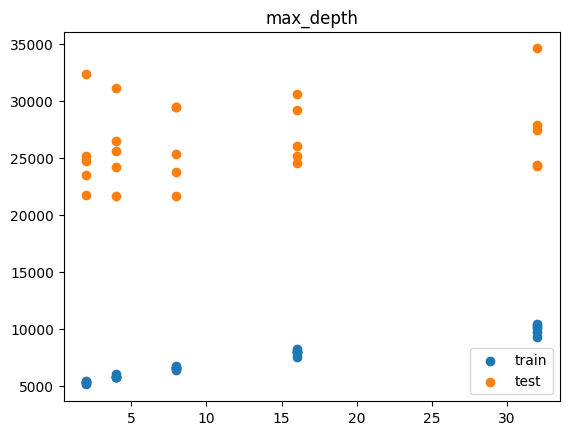

In [43]:
# reg_lambda = 8
xgboost_param_dic = {
    "max_depth": 4,
    "learning_rate": 0.1,
    "min_child_weight": 0,
    "colsample_bytree": 0.7,
    "n_estimators": 500,
    "early_stopping_rounds": 5,
    "verbose": False,
    "eval_metric": "rmse"}
result = hp_tuning('reg_lambda', 
                   [2, 4, 8, 16, 32], 
                   xgboost_param_dic, 
                   num_model_var, 
                   target, 
                   "xgboost",
                   df_train_engineered)
plot_result(result, "reg_lambda")

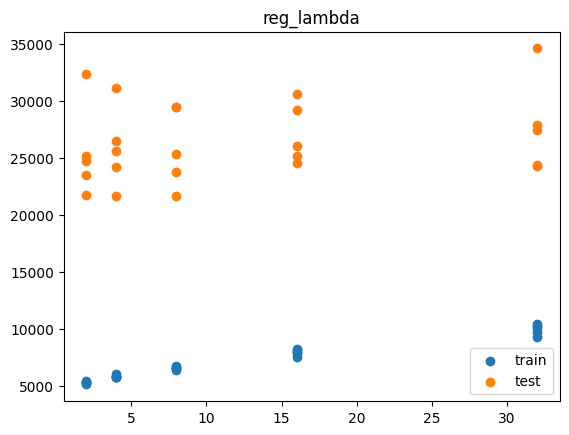

In [44]:
plot_result(result, "reg_lambda")

In [45]:
# min_child_weight = 100
xgboost_param_dic = {
    "max_depth": 4,
    "learning_rate": 0.1,
    "colsample_bytree": 0.7,
    "n_estimators": 500,
    "early_stopping_rounds": 5,
    "verbose": False,
    "eval_metric": "rmse",
    "reg_lambda": 8}
result = hp_tuning('min_child_weight', 
                   [0, 100, 200, 300, 400], 
                   xgboost_param_dic, 
                   num_model_var, 
                   target, 
                   "xgboost",
                   df_train_engineered)

training min_child_weight = 0
[0]	validation_0-rmse:160607
[1]	validation_0-rmse:147829
[2]	validation_0-rmse:135942
[3]	validation_0-rmse:125489
[4]	validation_0-rmse:115709
[5]	validation_0-rmse:106938
[6]	validation_0-rmse:99189
[7]	validation_0-rmse:91938.4
[8]	validation_0-rmse:86035
[9]	validation_0-rmse:80399.9
[10]	validation_0-rmse:75552.6
[11]	validation_0-rmse:71091
[12]	validation_0-rmse:67105.6
[13]	validation_0-rmse:63729
[14]	validation_0-rmse:60777.5
[15]	validation_0-rmse:57562.7
[16]	validation_0-rmse:54551.6
[17]	validation_0-rmse:51787.5
[18]	validation_0-rmse:49893.3
[19]	validation_0-rmse:47766.2
[20]	validation_0-rmse:46139
[21]	validation_0-rmse:44655.6
[22]	validation_0-rmse:43113.1
[23]	validation_0-rmse:41878.9
[24]	validation_0-rmse:41080.2
[25]	validation_0-rmse:39948.5
[26]	validation_0-rmse:38922.5
[27]	validation_0-rmse:38042.4
[28]	validation_0-rmse:37597.1
[29]	validation_0-rmse:37182.7
[30]	validation_0-rmse:36760.2
[31]	validation_0-rmse:36383.7
[32]

[261]	validation_0-rmse:29927.1
[262]	validation_0-rmse:29917.3
[263]	validation_0-rmse:29916.2
[264]	validation_0-rmse:29927.2
[265]	validation_0-rmse:29921.2
[266]	validation_0-rmse:29922.9
[267]	validation_0-rmse:29915.5
[268]	validation_0-rmse:29907.7
[269]	validation_0-rmse:29915.9
[270]	validation_0-rmse:29922.3
[271]	validation_0-rmse:29914.8
[272]	validation_0-rmse:29903.1
[273]	validation_0-rmse:29897.3
[274]	validation_0-rmse:29893.6
[275]	validation_0-rmse:29899.1
[276]	validation_0-rmse:29897.2
[277]	validation_0-rmse:29891.5
[278]	validation_0-rmse:29891.9
[279]	validation_0-rmse:29889.4
[280]	validation_0-rmse:29895.2
[281]	validation_0-rmse:29890
[282]	validation_0-rmse:29887.3
[283]	validation_0-rmse:29874.5
[284]	validation_0-rmse:29855
[285]	validation_0-rmse:29846.6
[286]	validation_0-rmse:29851
[287]	validation_0-rmse:29853.3
[288]	validation_0-rmse:29865.9
[289]	validation_0-rmse:29864.2
[290]	validation_0-rmse:29855.2
[291]	validation_0-rmse:29859.8
[292]	validati

[20]	validation_0-rmse:59024.7
[21]	validation_0-rmse:57172.1
[22]	validation_0-rmse:55469.6
[23]	validation_0-rmse:54064.9
[24]	validation_0-rmse:53132.6
[25]	validation_0-rmse:51901.4
[26]	validation_0-rmse:50842.4
[27]	validation_0-rmse:49932
[28]	validation_0-rmse:49083
[29]	validation_0-rmse:48259.3
[30]	validation_0-rmse:47460.3
[31]	validation_0-rmse:46668.8
[32]	validation_0-rmse:45859
[33]	validation_0-rmse:45248.1
[34]	validation_0-rmse:44810.2
[35]	validation_0-rmse:44290.7
[36]	validation_0-rmse:43761
[37]	validation_0-rmse:43283.2
[38]	validation_0-rmse:42820
[39]	validation_0-rmse:42411.7
[40]	validation_0-rmse:42165.8
[41]	validation_0-rmse:41981.6
[42]	validation_0-rmse:41616.6
[43]	validation_0-rmse:41426.2
[44]	validation_0-rmse:41298.8
[45]	validation_0-rmse:41232.3
[46]	validation_0-rmse:40918.2
[47]	validation_0-rmse:40582.5
[48]	validation_0-rmse:40507.3
[49]	validation_0-rmse:40190.1
[50]	validation_0-rmse:39885.6
[51]	validation_0-rmse:39814.8
[52]	validation_0-

[280]	validation_0-rmse:30802.7
[281]	validation_0-rmse:30795.7
[282]	validation_0-rmse:30781.2
[283]	validation_0-rmse:30775.6
[284]	validation_0-rmse:30794.8
[285]	validation_0-rmse:30791
[286]	validation_0-rmse:30781.9
[287]	validation_0-rmse:30757.2
[288]	validation_0-rmse:30748.4
[289]	validation_0-rmse:30751.1
[290]	validation_0-rmse:30735.5
[291]	validation_0-rmse:30695.4
[292]	validation_0-rmse:30692.4
[293]	validation_0-rmse:30688.6
[294]	validation_0-rmse:30683.1
[295]	validation_0-rmse:30686.8
[296]	validation_0-rmse:30666.5
[297]	validation_0-rmse:30661
[298]	validation_0-rmse:30645.6
[299]	validation_0-rmse:30595.5
[300]	validation_0-rmse:30566.6
[301]	validation_0-rmse:30562.9
[302]	validation_0-rmse:30560.4
[303]	validation_0-rmse:30565.7
[304]	validation_0-rmse:30565.5
[305]	validation_0-rmse:30553.4
[306]	validation_0-rmse:30559.1
[307]	validation_0-rmse:30558.3
[308]	validation_0-rmse:30539.5
[309]	validation_0-rmse:30535.1
[310]	validation_0-rmse:30540
[311]	validati

[40]	validation_0-rmse:31359.4
[41]	validation_0-rmse:31089
[42]	validation_0-rmse:31035.9
[43]	validation_0-rmse:30870.7
[44]	validation_0-rmse:30788.1
[45]	validation_0-rmse:30686.4
[46]	validation_0-rmse:30539.4
[47]	validation_0-rmse:30467.6
[48]	validation_0-rmse:30344.8
[49]	validation_0-rmse:30232.7
[50]	validation_0-rmse:30061.5
[51]	validation_0-rmse:29945.3
[52]	validation_0-rmse:29857.3
[53]	validation_0-rmse:29894.3
[54]	validation_0-rmse:29789.5
[55]	validation_0-rmse:29764.9
[56]	validation_0-rmse:29738.7
[57]	validation_0-rmse:29655.9
[58]	validation_0-rmse:29596.3
[59]	validation_0-rmse:29553.6
[60]	validation_0-rmse:29495.3
[61]	validation_0-rmse:29407.6
[62]	validation_0-rmse:29370.7
[63]	validation_0-rmse:29362.4
[64]	validation_0-rmse:29347.1
[65]	validation_0-rmse:29270.5
[66]	validation_0-rmse:29239.3
[67]	validation_0-rmse:29240.2
[68]	validation_0-rmse:29196.5
[69]	validation_0-rmse:29142.7
[70]	validation_0-rmse:29122.5
[71]	validation_0-rmse:29127.3
[72]	valid

[300]	validation_0-rmse:25971.6
[301]	validation_0-rmse:25963.7
[302]	validation_0-rmse:25958.6
[303]	validation_0-rmse:25941.9
[304]	validation_0-rmse:25912.7
[305]	validation_0-rmse:25905.4
[306]	validation_0-rmse:25861.9
[307]	validation_0-rmse:25859.1
[308]	validation_0-rmse:25847.9
[309]	validation_0-rmse:25833.4
[310]	validation_0-rmse:25836.5
[311]	validation_0-rmse:25823.6
[312]	validation_0-rmse:25826.8
[313]	validation_0-rmse:25828.9
[314]	validation_0-rmse:25834.9
[315]	validation_0-rmse:25840.6
[316]	validation_0-rmse:25852.7
[317]	validation_0-rmse:25850.5
[318]	validation_0-rmse:25847.5
[319]	validation_0-rmse:25841.3
[320]	validation_0-rmse:25842.7
[321]	validation_0-rmse:25834.8
[322]	validation_0-rmse:25834.4
[323]	validation_0-rmse:25828.2
[324]	validation_0-rmse:25823.4
[325]	validation_0-rmse:25819.7
[326]	validation_0-rmse:25807.1
[327]	validation_0-rmse:25796.3
[328]	validation_0-rmse:25795.1
[329]	validation_0-rmse:25789.3
[330]	validation_0-rmse:25788.1
[331]	va

[60]	validation_0-rmse:25942.8
[61]	validation_0-rmse:25886.3
[62]	validation_0-rmse:25836.1
[63]	validation_0-rmse:25796.3
[64]	validation_0-rmse:25777.4
[65]	validation_0-rmse:25767
[66]	validation_0-rmse:25749.9
[67]	validation_0-rmse:25689.8
[68]	validation_0-rmse:25658.2
[69]	validation_0-rmse:25616.9
[70]	validation_0-rmse:25568.4
[71]	validation_0-rmse:25532.7
[72]	validation_0-rmse:25542.9
[73]	validation_0-rmse:25504.9
[74]	validation_0-rmse:25498.8
[75]	validation_0-rmse:25447.1
[76]	validation_0-rmse:25423.2
[77]	validation_0-rmse:25410.9
[78]	validation_0-rmse:25362.7
[79]	validation_0-rmse:25349
[80]	validation_0-rmse:25320
[81]	validation_0-rmse:25276.6
[82]	validation_0-rmse:25290.4
[83]	validation_0-rmse:25271.3
[84]	validation_0-rmse:25261.6
[85]	validation_0-rmse:25212.9
[86]	validation_0-rmse:25219.8
[87]	validation_0-rmse:25164.8
[88]	validation_0-rmse:25049.3
[89]	validation_0-rmse:24948.9
[90]	validation_0-rmse:24882.3
[91]	validation_0-rmse:24841.6
[92]	validatio

[320]	validation_0-rmse:22117.5
[321]	validation_0-rmse:22114.4
[322]	validation_0-rmse:22112.2
[323]	validation_0-rmse:22108.4
[324]	validation_0-rmse:22103.3
[325]	validation_0-rmse:22106.6
[326]	validation_0-rmse:22120.8
[327]	validation_0-rmse:22116.8
[328]	validation_0-rmse:22099.8
[329]	validation_0-rmse:22099
[330]	validation_0-rmse:22092.5
[331]	validation_0-rmse:22082.3
[332]	validation_0-rmse:22080.4
[333]	validation_0-rmse:22080.3
[334]	validation_0-rmse:22078.9
[335]	validation_0-rmse:22064
[336]	validation_0-rmse:22060.3
[337]	validation_0-rmse:22066.5
[338]	validation_0-rmse:22080
[339]	validation_0-rmse:22068.8
[340]	validation_0-rmse:22060.3
[341]	validation_0-rmse:22056.9
[342]	validation_0-rmse:22049.5
[343]	validation_0-rmse:22049.2
[344]	validation_0-rmse:22039.1
[345]	validation_0-rmse:22038.3
[346]	validation_0-rmse:22029.5
[347]	validation_0-rmse:22021.4
[348]	validation_0-rmse:22032.5
[349]	validation_0-rmse:22033.5
[350]	validation_0-rmse:22026.7
[351]	validati

[81]	validation_0-rmse:28508.8
[82]	validation_0-rmse:28489.4
[83]	validation_0-rmse:28450
[84]	validation_0-rmse:28387.3
[85]	validation_0-rmse:28352.8
[86]	validation_0-rmse:28282.8
[87]	validation_0-rmse:28165.4
[88]	validation_0-rmse:28148
[89]	validation_0-rmse:28115.1
[90]	validation_0-rmse:28088.1
[91]	validation_0-rmse:28022.2
[92]	validation_0-rmse:28014.8
[93]	validation_0-rmse:27973.1
[94]	validation_0-rmse:27965.2
[95]	validation_0-rmse:27913.6
[96]	validation_0-rmse:27867
[97]	validation_0-rmse:27850.2
[98]	validation_0-rmse:27755
[99]	validation_0-rmse:27749.3
[100]	validation_0-rmse:27713.7
[101]	validation_0-rmse:27690.1
[102]	validation_0-rmse:27679.9
[103]	validation_0-rmse:27673.8
[104]	validation_0-rmse:27673.3
[105]	validation_0-rmse:27652.6
[106]	validation_0-rmse:27636.3
[107]	validation_0-rmse:27621
[108]	validation_0-rmse:27578.1
[109]	validation_0-rmse:27561.1
[110]	validation_0-rmse:27548
[111]	validation_0-rmse:27528.8
[112]	validation_0-rmse:27525.2
[113]	v

[340]	validation_0-rmse:24417.4
[341]	validation_0-rmse:24409.9
[342]	validation_0-rmse:24413.8
[343]	validation_0-rmse:24407.1
[344]	validation_0-rmse:24403.6
[345]	validation_0-rmse:24400.6
[346]	validation_0-rmse:24394.9
[347]	validation_0-rmse:24395.1
[348]	validation_0-rmse:24396.1
[349]	validation_0-rmse:24398.9
[350]	validation_0-rmse:24386.1
[351]	validation_0-rmse:24381.9
[352]	validation_0-rmse:24380.2
[353]	validation_0-rmse:24378.8
[354]	validation_0-rmse:24371.2
[355]	validation_0-rmse:24355.7
[356]	validation_0-rmse:24347.8
[357]	validation_0-rmse:24338.3
[358]	validation_0-rmse:24342.6
[359]	validation_0-rmse:24337.5
[360]	validation_0-rmse:24337.7
[361]	validation_0-rmse:24333.5
[362]	validation_0-rmse:24329.1
[363]	validation_0-rmse:24327.6
[364]	validation_0-rmse:24322.5
[365]	validation_0-rmse:24310.5
[366]	validation_0-rmse:24303.1
[367]	validation_0-rmse:24301.9
[368]	validation_0-rmse:24295.3
[369]	validation_0-rmse:24295.3
[370]	validation_0-rmse:24290.5
[371]	va

[101]	validation_0-rmse:40060.7
[102]	validation_0-rmse:39916.4
[103]	validation_0-rmse:39993.8
[104]	validation_0-rmse:39859.6
[105]	validation_0-rmse:39860.2
[106]	validation_0-rmse:39830.1
[107]	validation_0-rmse:39824.8
[108]	validation_0-rmse:39814.4
[109]	validation_0-rmse:39786.3
[110]	validation_0-rmse:39736.2
[111]	validation_0-rmse:39697.4
[112]	validation_0-rmse:39683.2
[113]	validation_0-rmse:39573.4
[114]	validation_0-rmse:39548.3
[115]	validation_0-rmse:39500.3
[116]	validation_0-rmse:39420.7
[117]	validation_0-rmse:39257.7
[118]	validation_0-rmse:39263.1
[119]	validation_0-rmse:39210.8
[120]	validation_0-rmse:39241.1
[121]	validation_0-rmse:39180
[122]	validation_0-rmse:39178.9
[123]	validation_0-rmse:39173.6
[124]	validation_0-rmse:39237.1
[125]	validation_0-rmse:39196.6
[126]	validation_0-rmse:39178.4
[127]	validation_0-rmse:39153.6
[128]	validation_0-rmse:39233.2
[129]	validation_0-rmse:39127.9
[130]	validation_0-rmse:39123.7
[131]	validation_0-rmse:39027.1
[132]	vali

[359]	validation_0-rmse:37623.3
[360]	validation_0-rmse:37579.4
[361]	validation_0-rmse:37573.7
[362]	validation_0-rmse:37587.1
[363]	validation_0-rmse:37591.4
[364]	validation_0-rmse:37585.5
[365]	validation_0-rmse:37587
[366]	validation_0-rmse:37618.1
[367]	validation_0-rmse:37656.2
[368]	validation_0-rmse:37642.8
[369]	validation_0-rmse:37603.1
[370]	validation_0-rmse:37600.5
[371]	validation_0-rmse:37604.2
[372]	validation_0-rmse:37615.7
[373]	validation_0-rmse:37622.7
[374]	validation_0-rmse:37603.7
[375]	validation_0-rmse:37600.4
[376]	validation_0-rmse:37591
[377]	validation_0-rmse:37585.6
[378]	validation_0-rmse:37564.5
[379]	validation_0-rmse:37606.6
[380]	validation_0-rmse:37606
[381]	validation_0-rmse:37586.2
[382]	validation_0-rmse:37544
[383]	validation_0-rmse:37527.9
[384]	validation_0-rmse:37525.2
[385]	validation_0-rmse:37566.9
[386]	validation_0-rmse:37605.4
[387]	validation_0-rmse:37568
[388]	validation_0-rmse:37556.7
[389]	validation_0-rmse:37583.7
[390]	validation_0

[121]	validation_0-rmse:46211.9
[122]	validation_0-rmse:46144.4
[123]	validation_0-rmse:46097.9
[124]	validation_0-rmse:46046
[125]	validation_0-rmse:45978.5
[126]	validation_0-rmse:45857.2
[127]	validation_0-rmse:45766
[128]	validation_0-rmse:45687.5
[129]	validation_0-rmse:45618
[130]	validation_0-rmse:45501.7
[131]	validation_0-rmse:45430.6
[132]	validation_0-rmse:45332.2
[133]	validation_0-rmse:45293.2
[134]	validation_0-rmse:45208.4
[135]	validation_0-rmse:45144.5
[136]	validation_0-rmse:45105.5
[137]	validation_0-rmse:45056.3
[138]	validation_0-rmse:44990.7
[139]	validation_0-rmse:44952.8
[140]	validation_0-rmse:44878.1
[141]	validation_0-rmse:44825.7
[142]	validation_0-rmse:44757.5
[143]	validation_0-rmse:44762.1
[144]	validation_0-rmse:44717.1
[145]	validation_0-rmse:44653.3
[146]	validation_0-rmse:44602
[147]	validation_0-rmse:44568.9
[148]	validation_0-rmse:44513.2
[149]	validation_0-rmse:44398.4
[150]	validation_0-rmse:44333.7
[151]	validation_0-rmse:44288.3
[152]	validation

[379]	validation_0-rmse:35699.1
[380]	validation_0-rmse:35663.8
[381]	validation_0-rmse:35639.5
[382]	validation_0-rmse:35584
[383]	validation_0-rmse:35565.3
[384]	validation_0-rmse:35615.7
[385]	validation_0-rmse:35603.3
[386]	validation_0-rmse:35574
[387]	validation_0-rmse:35555.2
[388]	validation_0-rmse:35542.7
[389]	validation_0-rmse:35525.4
[390]	validation_0-rmse:35503.4
[391]	validation_0-rmse:35550.1
[392]	validation_0-rmse:35503.6
[393]	validation_0-rmse:35486.7
[394]	validation_0-rmse:35374.7
[395]	validation_0-rmse:35367.4
[396]	validation_0-rmse:35310.6
[397]	validation_0-rmse:35286.1
[398]	validation_0-rmse:35271
[399]	validation_0-rmse:35241.2
[400]	validation_0-rmse:35199.4
[401]	validation_0-rmse:35176.3
[402]	validation_0-rmse:35150.6
[403]	validation_0-rmse:35142.4
[404]	validation_0-rmse:35129.8
[405]	validation_0-rmse:35109.5
[406]	validation_0-rmse:35060.1
[407]	validation_0-rmse:35037.4
[408]	validation_0-rmse:35061.1
[409]	validation_0-rmse:35045.2
[410]	validati

[140]	validation_0-rmse:34965.3
[141]	validation_0-rmse:34863
[142]	validation_0-rmse:34927.2
[143]	validation_0-rmse:34872.1
[144]	validation_0-rmse:34929.7
[145]	validation_0-rmse:34667.5
[146]	validation_0-rmse:34698.7
[147]	validation_0-rmse:34595.5
[148]	validation_0-rmse:34628.4
[149]	validation_0-rmse:34550.5
[150]	validation_0-rmse:34609.1
[151]	validation_0-rmse:34538.1
[152]	validation_0-rmse:34579.6
[153]	validation_0-rmse:34455.7
[154]	validation_0-rmse:34409.1
[155]	validation_0-rmse:34443.5
[156]	validation_0-rmse:34426.5
[157]	validation_0-rmse:34454.1
[158]	validation_0-rmse:34459.8
[159]	validation_0-rmse:34360.9
[160]	validation_0-rmse:34387.8
[161]	validation_0-rmse:34295.6
[162]	validation_0-rmse:34343.7
[163]	validation_0-rmse:34247.8
[164]	validation_0-rmse:34260.1
[165]	validation_0-rmse:34290.6
[166]	validation_0-rmse:34219.3
[167]	validation_0-rmse:34270.1
[168]	validation_0-rmse:34164.5
[169]	validation_0-rmse:34140.3
[170]	validation_0-rmse:34200.6
[171]	vali

[398]	validation_0-rmse:30067.9
[399]	validation_0-rmse:30050.3
[400]	validation_0-rmse:30067.3
[401]	validation_0-rmse:30069.8
[402]	validation_0-rmse:30035.5
[403]	validation_0-rmse:29972
[404]	validation_0-rmse:29990
[405]	validation_0-rmse:29999.4
[406]	validation_0-rmse:29966.9
[407]	validation_0-rmse:29971.2
[408]	validation_0-rmse:29949.4
[409]	validation_0-rmse:29950.1
[410]	validation_0-rmse:29929.2
[411]	validation_0-rmse:29936.4
[412]	validation_0-rmse:29933.9
[413]	validation_0-rmse:29908.5
[414]	validation_0-rmse:29854
[415]	validation_0-rmse:29865.5
[416]	validation_0-rmse:29825.8
[417]	validation_0-rmse:29822.2
[418]	validation_0-rmse:29838.2
[419]	validation_0-rmse:29801.4
[420]	validation_0-rmse:29768.2
[421]	validation_0-rmse:29786.9
[422]	validation_0-rmse:29786.3
[423]	validation_0-rmse:29775.5
[424]	validation_0-rmse:29784.6
[425]	validation_0-rmse:29749.2
[426]	validation_0-rmse:29725.8
[427]	validation_0-rmse:29680.1
[428]	validation_0-rmse:29688.1
[429]	validati

[160]	validation_0-rmse:30254.1
[161]	validation_0-rmse:30195.2
[162]	validation_0-rmse:30116.4
[163]	validation_0-rmse:30090.3
[164]	validation_0-rmse:30018.1
[165]	validation_0-rmse:30011.9
[166]	validation_0-rmse:29951.7
[167]	validation_0-rmse:29908.5
[168]	validation_0-rmse:29880.2
[169]	validation_0-rmse:29815.1
[170]	validation_0-rmse:29790.3
[171]	validation_0-rmse:29757.5
[172]	validation_0-rmse:29747.7
[173]	validation_0-rmse:29473.1
[174]	validation_0-rmse:29394.3
[175]	validation_0-rmse:29329.4
[176]	validation_0-rmse:29315.4
[177]	validation_0-rmse:29302.6
[178]	validation_0-rmse:29290.4
[179]	validation_0-rmse:29251.2
[180]	validation_0-rmse:29207.5
[181]	validation_0-rmse:29210.2
[182]	validation_0-rmse:29177
[183]	validation_0-rmse:29149.3
[184]	validation_0-rmse:29133.7
[185]	validation_0-rmse:29126.2
[186]	validation_0-rmse:29068.2
[187]	validation_0-rmse:29047.9
[188]	validation_0-rmse:29030.3
[189]	validation_0-rmse:29018.3
[190]	validation_0-rmse:28981.3
[191]	vali

[418]	validation_0-rmse:26042.6
[419]	validation_0-rmse:26014.1
[420]	validation_0-rmse:26009.4
[421]	validation_0-rmse:26015.9
[422]	validation_0-rmse:26024.2
[423]	validation_0-rmse:26008.4
[424]	validation_0-rmse:26019.8
[425]	validation_0-rmse:25992.3
[426]	validation_0-rmse:25994
[427]	validation_0-rmse:26011.1
[428]	validation_0-rmse:26020.1
[429]	validation_0-rmse:26012.5
[430]	validation_0-rmse:25995.9
[431]	validation_0-rmse:25971.7
[432]	validation_0-rmse:25967.2
[433]	validation_0-rmse:25954.2
[434]	validation_0-rmse:25962.7
[435]	validation_0-rmse:25949.6
[436]	validation_0-rmse:25958.7
[437]	validation_0-rmse:25936.6
[438]	validation_0-rmse:25953.2
[439]	validation_0-rmse:25982
[440]	validation_0-rmse:25990.2
[441]	validation_0-rmse:25946.1
[442]	validation_0-rmse:25948.1
[443]	validation_0-rmse:25926.9
[444]	validation_0-rmse:25949.8
[445]	validation_0-rmse:25933.6
[446]	validation_0-rmse:25929.2
[447]	validation_0-rmse:25927
[448]	validation_0-rmse:25923.7
[449]	validati

[180]	validation_0-rmse:37361.5
[181]	validation_0-rmse:37366.5
[182]	validation_0-rmse:37324.8
[183]	validation_0-rmse:37334.5
[184]	validation_0-rmse:37298.9
[185]	validation_0-rmse:37318.5
[186]	validation_0-rmse:37280.6
[187]	validation_0-rmse:37272.2
[188]	validation_0-rmse:37221.6
[189]	validation_0-rmse:37204
[190]	validation_0-rmse:37187.8
[191]	validation_0-rmse:37149.6
[192]	validation_0-rmse:37134.8
[193]	validation_0-rmse:37096.9
[194]	validation_0-rmse:36982.1
[195]	validation_0-rmse:36975.2
[196]	validation_0-rmse:36938.1
[197]	validation_0-rmse:36934
[198]	validation_0-rmse:36866
[199]	validation_0-rmse:36857.9
[200]	validation_0-rmse:36842.7
[201]	validation_0-rmse:36796.2
[202]	validation_0-rmse:36790.7
[203]	validation_0-rmse:36760.4
[204]	validation_0-rmse:36755
[205]	validation_0-rmse:36626.2
[206]	validation_0-rmse:36593.5
[207]	validation_0-rmse:36600.8
[208]	validation_0-rmse:36525.3
[209]	validation_0-rmse:36493.5
[210]	validation_0-rmse:36495.1
[211]	validation

[439]	validation_0-rmse:31967.8
[440]	validation_0-rmse:31966.9
[441]	validation_0-rmse:31948.7
[442]	validation_0-rmse:31951.3
[443]	validation_0-rmse:31932.1
[444]	validation_0-rmse:31913.3
[445]	validation_0-rmse:31907.1
[446]	validation_0-rmse:31890.7
[447]	validation_0-rmse:31876.2
[448]	validation_0-rmse:31871.1
[449]	validation_0-rmse:31867.7
[450]	validation_0-rmse:31865.7
[451]	validation_0-rmse:31865.4
[452]	validation_0-rmse:31832.3
[453]	validation_0-rmse:31830.4
[454]	validation_0-rmse:31830.3
[455]	validation_0-rmse:31810.5
[456]	validation_0-rmse:31798.7
[457]	validation_0-rmse:31797.1
[458]	validation_0-rmse:31802.6
[459]	validation_0-rmse:31795.1
[460]	validation_0-rmse:31790.6
[461]	validation_0-rmse:31771.1
[462]	validation_0-rmse:31781.3
[463]	validation_0-rmse:31776.7
[464]	validation_0-rmse:31770.8
[465]	validation_0-rmse:31767.5
[466]	validation_0-rmse:31755.6
[467]	validation_0-rmse:31743.2
[468]	validation_0-rmse:31745.9
[469]	validation_0-rmse:31729.8
[470]	va

[200]	validation_0-rmse:44590.3
[201]	validation_0-rmse:44516.4
[202]	validation_0-rmse:44578.9
[203]	validation_0-rmse:44509.7
[204]	validation_0-rmse:44546.4
[205]	validation_0-rmse:44461.9
[206]	validation_0-rmse:44508.4
[207]	validation_0-rmse:44433.6
[208]	validation_0-rmse:44473.2
[209]	validation_0-rmse:44403.7
[210]	validation_0-rmse:44452.1
[211]	validation_0-rmse:44376.8
[212]	validation_0-rmse:44425.5
[213]	validation_0-rmse:44360.6
[214]	validation_0-rmse:44447.9
[215]	validation_0-rmse:44368.7
[216]	validation_0-rmse:44412.2
[217]	validation_0-rmse:44332.9
[218]	validation_0-rmse:44401.6
[219]	validation_0-rmse:44328.5
[220]	validation_0-rmse:44385.5
[221]	validation_0-rmse:44308.9
[222]	validation_0-rmse:44373
[223]	validation_0-rmse:44312.4
[224]	validation_0-rmse:44338.1
[225]	validation_0-rmse:44286
[226]	validation_0-rmse:44362.2
[227]	validation_0-rmse:44282.2
[228]	validation_0-rmse:44320.8
[229]	validation_0-rmse:44247.4
[230]	validation_0-rmse:44299.7
[231]	valida

[459]	validation_0-rmse:41604.9
[460]	validation_0-rmse:41640.7
[461]	validation_0-rmse:41614.4
[462]	validation_0-rmse:41596
[463]	validation_0-rmse:41600.5
[464]	validation_0-rmse:41571.5
[465]	validation_0-rmse:41585.9
[466]	validation_0-rmse:41585.1
[467]	validation_0-rmse:41581.7
[468]	validation_0-rmse:41557.4
[469]	validation_0-rmse:41502.9
[470]	validation_0-rmse:41508
[471]	validation_0-rmse:41482.1
[472]	validation_0-rmse:41480
[473]	validation_0-rmse:41510.3
[474]	validation_0-rmse:41499.8
[475]	validation_0-rmse:41516.4
[476]	validation_0-rmse:41494.7
[477]	validation_0-rmse:41487
[478]	validation_0-rmse:41470
[479]	validation_0-rmse:41413.3
[480]	validation_0-rmse:41415.3
[481]	validation_0-rmse:41397.7
[482]	validation_0-rmse:41431
[483]	validation_0-rmse:41410.1
[484]	validation_0-rmse:41411.1
[485]	validation_0-rmse:41424
[486]	validation_0-rmse:41398.6
[487]	validation_0-rmse:41420.6
[488]	validation_0-rmse:41356.4
[489]	validation_0-rmse:41331.8
[490]	validation_0-rms

[220]	validation_0-rmse:49057.7
[221]	validation_0-rmse:49024.6
[222]	validation_0-rmse:48933.3
[223]	validation_0-rmse:48886.3
[224]	validation_0-rmse:48872.7
[225]	validation_0-rmse:48813.4
[226]	validation_0-rmse:48766.8
[227]	validation_0-rmse:48721.7
[228]	validation_0-rmse:48679.5
[229]	validation_0-rmse:48633.3
[230]	validation_0-rmse:48587.5
[231]	validation_0-rmse:48539.7
[232]	validation_0-rmse:48496.6
[233]	validation_0-rmse:48441.5
[234]	validation_0-rmse:48347.3
[235]	validation_0-rmse:48281.9
[236]	validation_0-rmse:48238.1
[237]	validation_0-rmse:48063.7
[238]	validation_0-rmse:47959.7
[239]	validation_0-rmse:47916.7
[240]	validation_0-rmse:47881.2
[241]	validation_0-rmse:47836
[242]	validation_0-rmse:47799.9
[243]	validation_0-rmse:47755.5
[244]	validation_0-rmse:47708.5
[245]	validation_0-rmse:47688.8
[246]	validation_0-rmse:47644.8
[247]	validation_0-rmse:47599.5
[248]	validation_0-rmse:47488.5
[249]	validation_0-rmse:47456.1
[250]	validation_0-rmse:47403.6
[251]	vali

[478]	validation_0-rmse:39607
[479]	validation_0-rmse:39553.6
[480]	validation_0-rmse:39538.8
[481]	validation_0-rmse:39527.9
[482]	validation_0-rmse:39494
[483]	validation_0-rmse:39474
[484]	validation_0-rmse:39460.5
[485]	validation_0-rmse:39446.1
[486]	validation_0-rmse:39425.3
[487]	validation_0-rmse:39397.1
[488]	validation_0-rmse:39377
[489]	validation_0-rmse:39350.9
[490]	validation_0-rmse:39333.1
[491]	validation_0-rmse:39310.2
[492]	validation_0-rmse:39266.9
[493]	validation_0-rmse:39247.7
[494]	validation_0-rmse:39223.7
[495]	validation_0-rmse:39199.1
[496]	validation_0-rmse:39172.6
[497]	validation_0-rmse:39182.4
[498]	validation_0-rmse:39117.1
[499]	validation_0-rmse:39102.8
[0]	validation_0-rmse:154467
[1]	validation_0-rmse:141018
[2]	validation_0-rmse:128749
[3]	validation_0-rmse:117647
[4]	validation_0-rmse:107903
[5]	validation_0-rmse:99186.8
[6]	validation_0-rmse:91578
[7]	validation_0-rmse:84813.2
[8]	validation_0-rmse:78740.9
[9]	validation_0-rmse:73762.8
[10]	valida

[239]	validation_0-rmse:38252.5
[240]	validation_0-rmse:38282.2
[241]	validation_0-rmse:38231.1
[242]	validation_0-rmse:38282.7
[243]	validation_0-rmse:38223.9
[244]	validation_0-rmse:38251.7
[245]	validation_0-rmse:38186.3
[246]	validation_0-rmse:38215.4
[247]	validation_0-rmse:38173.1
[248]	validation_0-rmse:38227.3
[249]	validation_0-rmse:38165.8
[250]	validation_0-rmse:38069.4
[251]	validation_0-rmse:38123
[252]	validation_0-rmse:38140.7
[253]	validation_0-rmse:38065.9
[254]	validation_0-rmse:38080.6
[255]	validation_0-rmse:38016
[256]	validation_0-rmse:38062.6
[257]	validation_0-rmse:37994.2
[258]	validation_0-rmse:38045.8
[259]	validation_0-rmse:37996.3
[260]	validation_0-rmse:38034.1
[261]	validation_0-rmse:37981.1
[262]	validation_0-rmse:38042.7
[263]	validation_0-rmse:38003.6
[264]	validation_0-rmse:38004.2
[265]	validation_0-rmse:38053.4
[266]	validation_0-rmse:37995.1
[267]	validation_0-rmse:38048.6
[268]	validation_0-rmse:37995.6
[269]	validation_0-rmse:38026
[270]	validati

[497]	validation_0-rmse:35146
[498]	validation_0-rmse:35127
[499]	validation_0-rmse:35142.2
[0]	validation_0-rmse:161708
[1]	validation_0-rmse:148478
[2]	validation_0-rmse:136403
[3]	validation_0-rmse:125891
[4]	validation_0-rmse:116533
[5]	validation_0-rmse:108200
[6]	validation_0-rmse:100595
[7]	validation_0-rmse:93962.8
[8]	validation_0-rmse:88130.5
[9]	validation_0-rmse:83086
[10]	validation_0-rmse:78600
[11]	validation_0-rmse:74666.7
[12]	validation_0-rmse:71250.1
[13]	validation_0-rmse:67927.9
[14]	validation_0-rmse:65275.5
[15]	validation_0-rmse:62792.7
[16]	validation_0-rmse:60628.9
[17]	validation_0-rmse:58796.9
[18]	validation_0-rmse:57196.8
[19]	validation_0-rmse:55887.6
[20]	validation_0-rmse:54743.8
[21]	validation_0-rmse:53511.5
[22]	validation_0-rmse:52581.9
[23]	validation_0-rmse:51644.6
[24]	validation_0-rmse:50977.3
[25]	validation_0-rmse:49895
[26]	validation_0-rmse:49328.2
[27]	validation_0-rmse:48817.4
[28]	validation_0-rmse:48314.5
[29]	validation_0-rmse:47942.6
[

[259]	validation_0-rmse:30599.6
[260]	validation_0-rmse:30586.9
[261]	validation_0-rmse:30551.8
[262]	validation_0-rmse:30537.9
[263]	validation_0-rmse:30507.6
[264]	validation_0-rmse:30480.7
[265]	validation_0-rmse:30446.1
[266]	validation_0-rmse:30400.2
[267]	validation_0-rmse:30398.5
[268]	validation_0-rmse:30350.9
[269]	validation_0-rmse:30346.8
[270]	validation_0-rmse:30305.2
[271]	validation_0-rmse:30284.1
[272]	validation_0-rmse:30249.6
[273]	validation_0-rmse:30186.7
[274]	validation_0-rmse:30145.8
[275]	validation_0-rmse:30140.1
[276]	validation_0-rmse:30113.8
[277]	validation_0-rmse:30097.2
[278]	validation_0-rmse:30061.3
[279]	validation_0-rmse:30039
[280]	validation_0-rmse:30010.1
[281]	validation_0-rmse:29992.6
[282]	validation_0-rmse:29960
[283]	validation_0-rmse:29922
[284]	validation_0-rmse:29718
[285]	validation_0-rmse:29659
[286]	validation_0-rmse:29649.3
[287]	validation_0-rmse:29577.7
[288]	validation_0-rmse:29544.3
[289]	validation_0-rmse:29493
[290]	validation_0-r

[18]	validation_0-rmse:55970.5
[19]	validation_0-rmse:55026.6
[20]	validation_0-rmse:54248.6
[21]	validation_0-rmse:53230.9
[22]	validation_0-rmse:52706.8
[23]	validation_0-rmse:51924.6
[24]	validation_0-rmse:51353.2
[25]	validation_0-rmse:51050.9
[26]	validation_0-rmse:50506.6
[27]	validation_0-rmse:50142.7
[28]	validation_0-rmse:49826
[29]	validation_0-rmse:49687.4
[30]	validation_0-rmse:49410.3
[31]	validation_0-rmse:49206.6
[32]	validation_0-rmse:48764.8
[33]	validation_0-rmse:48694.4
[34]	validation_0-rmse:48487.1
[35]	validation_0-rmse:48369.9
[36]	validation_0-rmse:48069.4
[37]	validation_0-rmse:48005.5
[38]	validation_0-rmse:47922.2
[39]	validation_0-rmse:47884.3
[40]	validation_0-rmse:47786.1
[41]	validation_0-rmse:47714.7
[42]	validation_0-rmse:47579.9
[43]	validation_0-rmse:47333.8
[44]	validation_0-rmse:47266.1
[45]	validation_0-rmse:47173.2
[46]	validation_0-rmse:47137.6
[47]	validation_0-rmse:47107
[48]	validation_0-rmse:46801.9
[49]	validation_0-rmse:46785.1
[50]	validat

[278]	validation_0-rmse:39091.9
[279]	validation_0-rmse:39004.4
[280]	validation_0-rmse:38989.1
[281]	validation_0-rmse:38965.3
[282]	validation_0-rmse:38964.8
[283]	validation_0-rmse:38948.8
[284]	validation_0-rmse:38942.6
[285]	validation_0-rmse:38924.3
[286]	validation_0-rmse:38863.7
[287]	validation_0-rmse:38857.6
[288]	validation_0-rmse:38722.7
[289]	validation_0-rmse:38697
[290]	validation_0-rmse:38673.6
[291]	validation_0-rmse:38658.6
[292]	validation_0-rmse:38639.5
[293]	validation_0-rmse:38623.7
[294]	validation_0-rmse:38612.2
[295]	validation_0-rmse:38603.5
[296]	validation_0-rmse:38594.8
[297]	validation_0-rmse:38583.3
[298]	validation_0-rmse:38571.6
[299]	validation_0-rmse:38574.7
[300]	validation_0-rmse:38533.4
[301]	validation_0-rmse:38507.1
[302]	validation_0-rmse:38516.4
[303]	validation_0-rmse:38498.4
[304]	validation_0-rmse:38487.3
[305]	validation_0-rmse:38448.3
[306]	validation_0-rmse:38434.7
[307]	validation_0-rmse:38430.8
[308]	validation_0-rmse:38416.8
[309]	vali

[37]	validation_0-rmse:60802.1
[38]	validation_0-rmse:60553.1
[39]	validation_0-rmse:60348.3
[40]	validation_0-rmse:60179.2
[41]	validation_0-rmse:60180.1
[42]	validation_0-rmse:59996.4
[43]	validation_0-rmse:59831.7
[44]	validation_0-rmse:59611.1
[45]	validation_0-rmse:59413.1
[46]	validation_0-rmse:59422.9
[47]	validation_0-rmse:59261.4
[48]	validation_0-rmse:59281.5
[49]	validation_0-rmse:59151
[50]	validation_0-rmse:59155.4
[51]	validation_0-rmse:58989
[52]	validation_0-rmse:58852.8
[53]	validation_0-rmse:58714.6
[54]	validation_0-rmse:58727.8
[55]	validation_0-rmse:58744.4
[56]	validation_0-rmse:58610.1
[57]	validation_0-rmse:58353.6
[58]	validation_0-rmse:58355.1
[59]	validation_0-rmse:58238.8
[60]	validation_0-rmse:58270.4
[61]	validation_0-rmse:58161.2
[62]	validation_0-rmse:58053
[63]	validation_0-rmse:58055.3
[64]	validation_0-rmse:57749.2
[65]	validation_0-rmse:57640.3
[66]	validation_0-rmse:57536.2
[67]	validation_0-rmse:57533.8
[68]	validation_0-rmse:57435
[69]	validation_

[297]	validation_0-rmse:48554.9
[298]	validation_0-rmse:48581.5
[299]	validation_0-rmse:48465.2
[300]	validation_0-rmse:48480.7
[301]	validation_0-rmse:48449.1
[302]	validation_0-rmse:48477.5
[303]	validation_0-rmse:48429.7
[304]	validation_0-rmse:48370.2
[305]	validation_0-rmse:48368
[306]	validation_0-rmse:48323.9
[307]	validation_0-rmse:48354.5
[308]	validation_0-rmse:48309.2
[309]	validation_0-rmse:48204.5
[310]	validation_0-rmse:48233.1
[311]	validation_0-rmse:48220.6
[312]	validation_0-rmse:48177.2
[313]	validation_0-rmse:48140.6
[314]	validation_0-rmse:48107
[315]	validation_0-rmse:48123.8
[316]	validation_0-rmse:48148.6
[317]	validation_0-rmse:48104.2
[318]	validation_0-rmse:48057.1
[319]	validation_0-rmse:48031.7
[320]	validation_0-rmse:47983.7
[321]	validation_0-rmse:48013.1
[322]	validation_0-rmse:47951.6
[323]	validation_0-rmse:47917.7
[324]	validation_0-rmse:47918.6
[325]	validation_0-rmse:47888.4
[326]	validation_0-rmse:47917.2
[327]	validation_0-rmse:47918.2
[328]	valida

[58]	validation_0-rmse:68713.8
[59]	validation_0-rmse:68570.2
[60]	validation_0-rmse:68445.6
[61]	validation_0-rmse:68344.1
[62]	validation_0-rmse:68308.4
[63]	validation_0-rmse:68211.1
[64]	validation_0-rmse:67953
[65]	validation_0-rmse:67846.4
[66]	validation_0-rmse:67616
[67]	validation_0-rmse:67511.5
[68]	validation_0-rmse:67123.5
[69]	validation_0-rmse:66899.3
[70]	validation_0-rmse:66795.7
[71]	validation_0-rmse:66686.2
[72]	validation_0-rmse:66491.4
[73]	validation_0-rmse:66398.2
[74]	validation_0-rmse:66098.1
[75]	validation_0-rmse:65887.3
[76]	validation_0-rmse:65764.1
[77]	validation_0-rmse:65663.6
[78]	validation_0-rmse:65570.8
[79]	validation_0-rmse:65473.5
[80]	validation_0-rmse:65234.8
[81]	validation_0-rmse:65018.8
[82]	validation_0-rmse:64942.9
[83]	validation_0-rmse:64688.1
[84]	validation_0-rmse:64589.6
[85]	validation_0-rmse:64504.5
[86]	validation_0-rmse:64416.3
[87]	validation_0-rmse:64235.2
[88]	validation_0-rmse:64013.5
[89]	validation_0-rmse:63917.1
[90]	validat

[317]	validation_0-rmse:48980.6
[318]	validation_0-rmse:48950.3
[319]	validation_0-rmse:48902.1
[320]	validation_0-rmse:48895.9
[321]	validation_0-rmse:48859.9
[322]	validation_0-rmse:48832.6
[323]	validation_0-rmse:48716.4
[324]	validation_0-rmse:48665.5
[325]	validation_0-rmse:48647.1
[326]	validation_0-rmse:48613.5
[327]	validation_0-rmse:48584.3
[328]	validation_0-rmse:48537.9
[329]	validation_0-rmse:48438.1
[330]	validation_0-rmse:48416.2
[331]	validation_0-rmse:48387.8
[332]	validation_0-rmse:48356.5
[333]	validation_0-rmse:48239.4
[334]	validation_0-rmse:48246.9
[335]	validation_0-rmse:48222.3
[336]	validation_0-rmse:48190.4
[337]	validation_0-rmse:48167.1
[338]	validation_0-rmse:48137.6
[339]	validation_0-rmse:48100.4
[340]	validation_0-rmse:48065.2
[341]	validation_0-rmse:48036.6
[342]	validation_0-rmse:48007.4
[343]	validation_0-rmse:47974.2
[344]	validation_0-rmse:47946.9
[345]	validation_0-rmse:47913.6
[346]	validation_0-rmse:47907.7
[347]	validation_0-rmse:47877.3
[348]	va

[78]	validation_0-rmse:43940.5
[79]	validation_0-rmse:43756.4
[80]	validation_0-rmse:43876.5
[81]	validation_0-rmse:43918.4
[82]	validation_0-rmse:43698.9
[83]	validation_0-rmse:43675.4
[84]	validation_0-rmse:43720.6
[85]	validation_0-rmse:43691.2
[86]	validation_0-rmse:43736.9
[87]	validation_0-rmse:43556.4
[88]	validation_0-rmse:43658.7
[89]	validation_0-rmse:43629.4
[90]	validation_0-rmse:43694.2
[91]	validation_0-rmse:43628.7
[92]	validation_0-rmse:43660.4
[93]	validation_0-rmse:43524.2
[94]	validation_0-rmse:43613.4
[95]	validation_0-rmse:43372.3
[96]	validation_0-rmse:43173.9
[97]	validation_0-rmse:43217.6
[98]	validation_0-rmse:43140.8
[99]	validation_0-rmse:43239.6
[100]	validation_0-rmse:43087.1
[101]	validation_0-rmse:43120.7
[102]	validation_0-rmse:43103.8
[103]	validation_0-rmse:42961.5
[104]	validation_0-rmse:43003.6
[105]	validation_0-rmse:42921.1
[106]	validation_0-rmse:42961
[107]	validation_0-rmse:42904.4
[108]	validation_0-rmse:42962.9
[109]	validation_0-rmse:42868.2


[337]	validation_0-rmse:39430.1
[338]	validation_0-rmse:39402.3
[339]	validation_0-rmse:39428.7
[340]	validation_0-rmse:39370.7
[341]	validation_0-rmse:39406.7
[342]	validation_0-rmse:39357.9
[343]	validation_0-rmse:39383.5
[344]	validation_0-rmse:39360.6
[345]	validation_0-rmse:39389
[346]	validation_0-rmse:39345.8
[347]	validation_0-rmse:39385.8
[348]	validation_0-rmse:39376.1
[349]	validation_0-rmse:39347.5
[350]	validation_0-rmse:39330.3
[351]	validation_0-rmse:39368.2
[352]	validation_0-rmse:39247.2
[353]	validation_0-rmse:39287.9
[354]	validation_0-rmse:39258
[355]	validation_0-rmse:39279.8
[356]	validation_0-rmse:39260.3
[357]	validation_0-rmse:39299.5
[358]	validation_0-rmse:39243.3
[359]	validation_0-rmse:39266.4
[360]	validation_0-rmse:39214.5
[361]	validation_0-rmse:39206.9
[362]	validation_0-rmse:39148.6
[363]	validation_0-rmse:39177
[364]	validation_0-rmse:39132
[365]	validation_0-rmse:39170.6
[366]	validation_0-rmse:39147.9
[367]	validation_0-rmse:39184.3
[368]	validation

[99]	validation_0-rmse:45267.1
[100]	validation_0-rmse:45210
[101]	validation_0-rmse:45168.7
[102]	validation_0-rmse:45127.7
[103]	validation_0-rmse:45027
[104]	validation_0-rmse:44999.5
[105]	validation_0-rmse:44952.8
[106]	validation_0-rmse:44946.4
[107]	validation_0-rmse:44914.8
[108]	validation_0-rmse:44781.4
[109]	validation_0-rmse:44616.5
[110]	validation_0-rmse:44570.6
[111]	validation_0-rmse:44388.5
[112]	validation_0-rmse:44338.5
[113]	validation_0-rmse:44227.4
[114]	validation_0-rmse:44184.2
[115]	validation_0-rmse:44120.9
[116]	validation_0-rmse:43985.6
[117]	validation_0-rmse:43880.1
[118]	validation_0-rmse:43830.7
[119]	validation_0-rmse:43788.6
[120]	validation_0-rmse:43742
[121]	validation_0-rmse:43684.7
[122]	validation_0-rmse:43676.5
[123]	validation_0-rmse:43610.9
[124]	validation_0-rmse:43580
[125]	validation_0-rmse:43507.3
[126]	validation_0-rmse:43283.8
[127]	validation_0-rmse:43204.4
[128]	validation_0-rmse:43085.4
[129]	validation_0-rmse:43042.7
[130]	validation_

[357]	validation_0-rmse:34035.1
[358]	validation_0-rmse:34002.1
[359]	validation_0-rmse:33993.6
[360]	validation_0-rmse:33980.1
[361]	validation_0-rmse:33956.3
[362]	validation_0-rmse:33964.9
[363]	validation_0-rmse:33923.8
[364]	validation_0-rmse:33913.7
[365]	validation_0-rmse:33883.3
[366]	validation_0-rmse:33873.9
[367]	validation_0-rmse:33835.1
[368]	validation_0-rmse:33845.2
[369]	validation_0-rmse:33828.8
[370]	validation_0-rmse:33814.6
[371]	validation_0-rmse:33785.8
[372]	validation_0-rmse:33759.6
[373]	validation_0-rmse:33743.2
[374]	validation_0-rmse:33737
[375]	validation_0-rmse:33730.9
[376]	validation_0-rmse:33712.1
[377]	validation_0-rmse:33674.9
[378]	validation_0-rmse:33672.7
[379]	validation_0-rmse:33633.2
[380]	validation_0-rmse:33631.7
[381]	validation_0-rmse:33598.9
[382]	validation_0-rmse:33590.4
[383]	validation_0-rmse:33555.8
[384]	validation_0-rmse:33545
[385]	validation_0-rmse:33522.5
[386]	validation_0-rmse:33524.5
[387]	validation_0-rmse:33511.7
[388]	valida

[119]	validation_0-rmse:46633.8
[120]	validation_0-rmse:46565.1
[121]	validation_0-rmse:46498.8
[122]	validation_0-rmse:46484.6
[123]	validation_0-rmse:46395.3
[124]	validation_0-rmse:46375.8
[125]	validation_0-rmse:46261.3
[126]	validation_0-rmse:46230.7
[127]	validation_0-rmse:46201
[128]	validation_0-rmse:46171.5
[129]	validation_0-rmse:46154.6
[130]	validation_0-rmse:46058.4
[131]	validation_0-rmse:46029.1
[132]	validation_0-rmse:46022.2
[133]	validation_0-rmse:45910.8
[134]	validation_0-rmse:45853.1
[135]	validation_0-rmse:45825.9
[136]	validation_0-rmse:45782.2
[137]	validation_0-rmse:45746.8
[138]	validation_0-rmse:45741.3
[139]	validation_0-rmse:45683.7
[140]	validation_0-rmse:45606.3
[141]	validation_0-rmse:45575
[142]	validation_0-rmse:45584.9
[143]	validation_0-rmse:45557.1
[144]	validation_0-rmse:45524.2
[145]	validation_0-rmse:45459.8
[146]	validation_0-rmse:45375.2
[147]	validation_0-rmse:45280.2
[148]	validation_0-rmse:45249.8
[149]	validation_0-rmse:45205.8
[150]	valida

[377]	validation_0-rmse:39846.6
[378]	validation_0-rmse:39834.9
[379]	validation_0-rmse:39807.1
[380]	validation_0-rmse:39798.4
[381]	validation_0-rmse:39786.5
[382]	validation_0-rmse:39783.2
[383]	validation_0-rmse:39779.2
[384]	validation_0-rmse:39770.9
[385]	validation_0-rmse:39754.6
[386]	validation_0-rmse:39742.7
[387]	validation_0-rmse:39733.2
[388]	validation_0-rmse:39724.2
[389]	validation_0-rmse:39703.9
[390]	validation_0-rmse:39702
[391]	validation_0-rmse:39686.3
[392]	validation_0-rmse:39681
[393]	validation_0-rmse:39665.1
[394]	validation_0-rmse:39661.8
[395]	validation_0-rmse:39650.4
[396]	validation_0-rmse:39655.1
[397]	validation_0-rmse:39644.4
[398]	validation_0-rmse:39646.9
[399]	validation_0-rmse:39633.4
[400]	validation_0-rmse:39621.3
[401]	validation_0-rmse:39606.2
[402]	validation_0-rmse:39583.7
[403]	validation_0-rmse:39570.9
[404]	validation_0-rmse:39545.7
[405]	validation_0-rmse:39534.8
[406]	validation_0-rmse:39526.2
[407]	validation_0-rmse:39511.2
[408]	valida

[137]	validation_0-rmse:56956.9
[138]	validation_0-rmse:56867.2
[139]	validation_0-rmse:56820.4
[140]	validation_0-rmse:56818.8
[141]	validation_0-rmse:56734.3
[142]	validation_0-rmse:56743.7
[143]	validation_0-rmse:56754.4
[144]	validation_0-rmse:56673.7
[145]	validation_0-rmse:56654.7
[146]	validation_0-rmse:56672
[147]	validation_0-rmse:56624.8
[148]	validation_0-rmse:56547.6
[149]	validation_0-rmse:56482.7
[150]	validation_0-rmse:56417.7
[151]	validation_0-rmse:56331.1
[152]	validation_0-rmse:56325.3
[153]	validation_0-rmse:56264.8
[154]	validation_0-rmse:56175.3
[155]	validation_0-rmse:56109.3
[156]	validation_0-rmse:56045.3
[157]	validation_0-rmse:55988.6
[158]	validation_0-rmse:56005.1
[159]	validation_0-rmse:55940.6
[160]	validation_0-rmse:55948.9
[161]	validation_0-rmse:55883.6
[162]	validation_0-rmse:55900.2
[163]	validation_0-rmse:55833
[164]	validation_0-rmse:55851.9
[165]	validation_0-rmse:55774.3
[166]	validation_0-rmse:55787.2
[167]	validation_0-rmse:55726.5
[168]	valida

[395]	validation_0-rmse:49096.7
[396]	validation_0-rmse:49064.5
[397]	validation_0-rmse:49076.4
[398]	validation_0-rmse:49037.1
[399]	validation_0-rmse:49068.4
[400]	validation_0-rmse:49026.7
[401]	validation_0-rmse:49064.3
[402]	validation_0-rmse:49043.9
[403]	validation_0-rmse:49047.6
[404]	validation_0-rmse:49046.8
[405]	validation_0-rmse:49025
[406]	validation_0-rmse:49049.2
[407]	validation_0-rmse:48982.8
[408]	validation_0-rmse:48944.7
[409]	validation_0-rmse:48968.9
[410]	validation_0-rmse:48926.3
[411]	validation_0-rmse:48954.7
[412]	validation_0-rmse:48925.2
[413]	validation_0-rmse:48960.8
[414]	validation_0-rmse:48919.9
[415]	validation_0-rmse:48837.4
[416]	validation_0-rmse:48862.8
[417]	validation_0-rmse:48825.2
[418]	validation_0-rmse:48854.2
[419]	validation_0-rmse:48827.3
[420]	validation_0-rmse:48796.3
[421]	validation_0-rmse:48745.2
[422]	validation_0-rmse:48764.9
[423]	validation_0-rmse:48768.8
[424]	validation_0-rmse:48730.7
[425]	validation_0-rmse:48755.2
[426]	vali

[156]	validation_0-rmse:65232.4
[157]	validation_0-rmse:65171.5
[158]	validation_0-rmse:65110
[159]	validation_0-rmse:65058.4
[160]	validation_0-rmse:65004.1
[161]	validation_0-rmse:64958.9
[162]	validation_0-rmse:64903.8
[163]	validation_0-rmse:64646.3
[164]	validation_0-rmse:64608.7
[165]	validation_0-rmse:64550.8
[166]	validation_0-rmse:64491.7
[167]	validation_0-rmse:64431.3
[168]	validation_0-rmse:64381.3
[169]	validation_0-rmse:64190.2
[170]	validation_0-rmse:64133.3
[171]	validation_0-rmse:64078.9
[172]	validation_0-rmse:64022.9
[173]	validation_0-rmse:63976.5
[174]	validation_0-rmse:63918.3
[175]	validation_0-rmse:63867.7
[176]	validation_0-rmse:63801.8
[177]	validation_0-rmse:63747.4
[178]	validation_0-rmse:63687.6
[179]	validation_0-rmse:63642.3
[180]	validation_0-rmse:63585.9
[181]	validation_0-rmse:63528.4
[182]	validation_0-rmse:63479.9
[183]	validation_0-rmse:63426.1
[184]	validation_0-rmse:63380.9
[185]	validation_0-rmse:63341.3
[186]	validation_0-rmse:63287
[187]	valida

[414]	validation_0-rmse:53757.6
[415]	validation_0-rmse:53732.7
[416]	validation_0-rmse:53708.5
[417]	validation_0-rmse:53676.9
[418]	validation_0-rmse:53559.6
[419]	validation_0-rmse:53557.8
[420]	validation_0-rmse:53528.4
[421]	validation_0-rmse:53498.8
[422]	validation_0-rmse:53470.7
[423]	validation_0-rmse:53408.8
[424]	validation_0-rmse:53378
[425]	validation_0-rmse:53353.6
[426]	validation_0-rmse:53327.6
[427]	validation_0-rmse:53300
[428]	validation_0-rmse:53182
[429]	validation_0-rmse:53154.8
[430]	validation_0-rmse:53053.5
[431]	validation_0-rmse:53061.2
[432]	validation_0-rmse:53029.6
[433]	validation_0-rmse:52989.1
[434]	validation_0-rmse:52875.8
[435]	validation_0-rmse:52883.8
[436]	validation_0-rmse:52860.4
[437]	validation_0-rmse:52836
[438]	validation_0-rmse:52803.9
[439]	validation_0-rmse:52776.7
[440]	validation_0-rmse:52753.5
[441]	validation_0-rmse:52731
[442]	validation_0-rmse:52703.6
[443]	validation_0-rmse:52683.3
[444]	validation_0-rmse:52667.7
[445]	validation_0

[176]	validation_0-rmse:43446.1
[177]	validation_0-rmse:43493.8
[178]	validation_0-rmse:43446.4
[179]	validation_0-rmse:43502.5
[180]	validation_0-rmse:43415.4
[181]	validation_0-rmse:43466.2
[182]	validation_0-rmse:43439.5
[183]	validation_0-rmse:43409.6
[184]	validation_0-rmse:43346.7
[185]	validation_0-rmse:43341.5
[186]	validation_0-rmse:43314.9
[187]	validation_0-rmse:43226.6
[188]	validation_0-rmse:43282.7
[189]	validation_0-rmse:43249.8
[190]	validation_0-rmse:43285.8
[191]	validation_0-rmse:43217.3
[192]	validation_0-rmse:43256.9
[193]	validation_0-rmse:43208.9
[194]	validation_0-rmse:43233.9
[195]	validation_0-rmse:43202.4
[196]	validation_0-rmse:43242.6
[197]	validation_0-rmse:43262.6
[198]	validation_0-rmse:43214.5
[199]	validation_0-rmse:43188.9
[200]	validation_0-rmse:43116.2
[201]	validation_0-rmse:43152.3
[202]	validation_0-rmse:43095.4
[203]	validation_0-rmse:43159
[204]	validation_0-rmse:43102
[205]	validation_0-rmse:43162.1
[206]	validation_0-rmse:43145.3
[207]	valida

[435]	validation_0-rmse:41184.6
[436]	validation_0-rmse:41211
[437]	validation_0-rmse:41203.3
[438]	validation_0-rmse:41173.1
[439]	validation_0-rmse:41198.3
[440]	validation_0-rmse:41217.3
[441]	validation_0-rmse:41216.4
[442]	validation_0-rmse:41235.2
[443]	validation_0-rmse:41190.5
[444]	validation_0-rmse:41155.4
[445]	validation_0-rmse:41128.3
[446]	validation_0-rmse:41130.1
[447]	validation_0-rmse:41110.5
[448]	validation_0-rmse:41136.4
[449]	validation_0-rmse:41166.3
[450]	validation_0-rmse:41151.7
[451]	validation_0-rmse:41133.2
[452]	validation_0-rmse:41127.1
[453]	validation_0-rmse:41076.7
[454]	validation_0-rmse:41094.7
[455]	validation_0-rmse:41088.1
[456]	validation_0-rmse:41117.2
[457]	validation_0-rmse:41086.4
[458]	validation_0-rmse:41087.7
[459]	validation_0-rmse:41049.5
[460]	validation_0-rmse:41069.6
[461]	validation_0-rmse:41045.7
[462]	validation_0-rmse:41072.7
[463]	validation_0-rmse:41054.5
[464]	validation_0-rmse:41079.9
[465]	validation_0-rmse:41044.6
[466]	vali

[196]	validation_0-rmse:47087.2
[197]	validation_0-rmse:47032.4
[198]	validation_0-rmse:47005.5
[199]	validation_0-rmse:46979.2
[200]	validation_0-rmse:46937
[201]	validation_0-rmse:46918.3
[202]	validation_0-rmse:46876
[203]	validation_0-rmse:46842.5
[204]	validation_0-rmse:46801.2
[205]	validation_0-rmse:46781.6
[206]	validation_0-rmse:46745.4
[207]	validation_0-rmse:46644.1
[208]	validation_0-rmse:46618.1
[209]	validation_0-rmse:46577.6
[210]	validation_0-rmse:46559.7
[211]	validation_0-rmse:46542.8
[212]	validation_0-rmse:46514.1
[213]	validation_0-rmse:46467.9
[214]	validation_0-rmse:46411.7
[215]	validation_0-rmse:46311.9
[216]	validation_0-rmse:46300.7
[217]	validation_0-rmse:46071.1
[218]	validation_0-rmse:45995.9
[219]	validation_0-rmse:45975
[220]	validation_0-rmse:45935.9
[221]	validation_0-rmse:45875.8
[222]	validation_0-rmse:45851.9
[223]	validation_0-rmse:45846
[224]	validation_0-rmse:45738.8
[225]	validation_0-rmse:45734.2
[226]	validation_0-rmse:45646.2
[227]	validation

[455]	validation_0-rmse:38745
[456]	validation_0-rmse:38722.5
[457]	validation_0-rmse:38713.4
[458]	validation_0-rmse:38684.6
[459]	validation_0-rmse:38651
[460]	validation_0-rmse:38641
[461]	validation_0-rmse:38617
[462]	validation_0-rmse:38596.8
[463]	validation_0-rmse:38543.4
[464]	validation_0-rmse:38504.2
[465]	validation_0-rmse:38495.5
[466]	validation_0-rmse:38488.3
[467]	validation_0-rmse:38487.3
[468]	validation_0-rmse:38441.4
[469]	validation_0-rmse:38428.5
[470]	validation_0-rmse:38377.3
[471]	validation_0-rmse:38374.5
[472]	validation_0-rmse:38329
[473]	validation_0-rmse:38320.3
[474]	validation_0-rmse:38240.2
[475]	validation_0-rmse:38228.5
[476]	validation_0-rmse:38213.6
[477]	validation_0-rmse:38212
[478]	validation_0-rmse:38191.4
[479]	validation_0-rmse:38191.4
[480]	validation_0-rmse:38191
[481]	validation_0-rmse:38170.5
[482]	validation_0-rmse:38144.4
[483]	validation_0-rmse:38142
[484]	validation_0-rmse:38119.8
[485]	validation_0-rmse:38114.4
[486]	validation_0-rmse:

[217]	validation_0-rmse:48636.5
[218]	validation_0-rmse:48639.7
[219]	validation_0-rmse:48637.4
[220]	validation_0-rmse:48624.7
[221]	validation_0-rmse:48525.8
[222]	validation_0-rmse:48513.1
[223]	validation_0-rmse:48517.8
[224]	validation_0-rmse:48448.7
[225]	validation_0-rmse:48437.5
[226]	validation_0-rmse:48418.7
[227]	validation_0-rmse:48410.6
[228]	validation_0-rmse:48381.2
[229]	validation_0-rmse:48362.1
[230]	validation_0-rmse:48347
[231]	validation_0-rmse:48338.8
[232]	validation_0-rmse:48287.9
[233]	validation_0-rmse:48289.9
[234]	validation_0-rmse:48273.8
[235]	validation_0-rmse:48235.9
[236]	validation_0-rmse:48227
[237]	validation_0-rmse:48220.2
[238]	validation_0-rmse:48220.3
[239]	validation_0-rmse:48185.5
[240]	validation_0-rmse:48172.6
[241]	validation_0-rmse:48145.7
[242]	validation_0-rmse:48143.9
[243]	validation_0-rmse:48122.7
[244]	validation_0-rmse:48101.1
[245]	validation_0-rmse:48089.9
[246]	validation_0-rmse:48039.1
[247]	validation_0-rmse:48028
[248]	validati

[475]	validation_0-rmse:43800.2
[476]	validation_0-rmse:43797
[477]	validation_0-rmse:43802
[478]	validation_0-rmse:43788.8
[479]	validation_0-rmse:43759.6
[480]	validation_0-rmse:43731.5
[481]	validation_0-rmse:43731.6
[482]	validation_0-rmse:43734.1
[483]	validation_0-rmse:43723.6
[484]	validation_0-rmse:43712.5
[485]	validation_0-rmse:43710.8
[486]	validation_0-rmse:43701
[487]	validation_0-rmse:43686.5
[488]	validation_0-rmse:43682.1
[489]	validation_0-rmse:43666.6
[490]	validation_0-rmse:43657.2
[491]	validation_0-rmse:43641.4
[492]	validation_0-rmse:43631.9
[493]	validation_0-rmse:43604.7
[494]	validation_0-rmse:43592.3
[495]	validation_0-rmse:43573.2
[496]	validation_0-rmse:43562
[497]	validation_0-rmse:43552.7
[498]	validation_0-rmse:43535.6
[499]	validation_0-rmse:43530.3


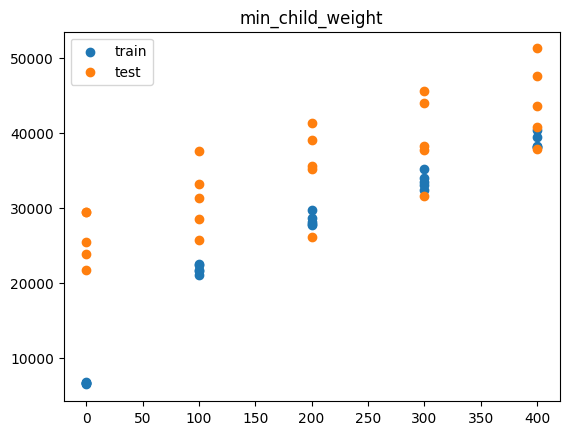

In [46]:
plot_result(result, "min_child_weight")

In [50]:
# colsample_bytree = 0.5
xgboost_param_dic = {
    "max_depth": 4,
    "learning_rate": 0.1,
    "colsample_bytree": 0.7,
    "n_estimators": 500,
    "early_stopping_rounds": 5,
    "verbose": False,
    "eval_metric": "rmse",
    "reg_lambda": 8,
    "min_child_weight": 100}
result = hp_tuning('colsample_bytree', 
                   [0.2,0.5,0.7,0.9], 
                   xgboost_param_dic, 
                   num_model_var, 
                   target, 
                   "xgboost",
                   df_train_engineered)

training colsample_bytree = 0.2
[0]	validation_0-rmse:162778
[1]	validation_0-rmse:150011
[2]	validation_0-rmse:138690
[3]	validation_0-rmse:128323
[4]	validation_0-rmse:120290
[5]	validation_0-rmse:112341
[6]	validation_0-rmse:106007
[7]	validation_0-rmse:99885.4
[8]	validation_0-rmse:94049.5
[9]	validation_0-rmse:89311.9
[10]	validation_0-rmse:86171.2
[11]	validation_0-rmse:82513.8
[12]	validation_0-rmse:79515.6
[13]	validation_0-rmse:77597.5
[14]	validation_0-rmse:74567.8
[15]	validation_0-rmse:72214
[16]	validation_0-rmse:69350.3
[17]	validation_0-rmse:66592.4
[18]	validation_0-rmse:64756.5
[19]	validation_0-rmse:62822.9
[20]	validation_0-rmse:61277.3
[21]	validation_0-rmse:60610.1
[22]	validation_0-rmse:59378.2
[23]	validation_0-rmse:57835
[24]	validation_0-rmse:56922.7
[25]	validation_0-rmse:56159.5
[26]	validation_0-rmse:55033.4
[27]	validation_0-rmse:54216.2
[28]	validation_0-rmse:53400.4
[29]	validation_0-rmse:53065.6
[30]	validation_0-rmse:52468.3
[31]	validation_0-rmse:51964

[261]	validation_0-rmse:37127
[262]	validation_0-rmse:37137.3
[263]	validation_0-rmse:37139.3
[264]	validation_0-rmse:37120.4
[265]	validation_0-rmse:37123.4
[266]	validation_0-rmse:37089.9
[267]	validation_0-rmse:37101.3
[268]	validation_0-rmse:37100.4
[269]	validation_0-rmse:37065.1
[270]	validation_0-rmse:37074.1
[271]	validation_0-rmse:37081.3
[272]	validation_0-rmse:37085.9
[273]	validation_0-rmse:37112.8
[274]	validation_0-rmse:37144.7
[275]	validation_0-rmse:37141.9
[276]	validation_0-rmse:37120.5
[277]	validation_0-rmse:37106.3
[278]	validation_0-rmse:37113.2
[279]	validation_0-rmse:37073.7
[280]	validation_0-rmse:37048.4
[281]	validation_0-rmse:37053.6
[282]	validation_0-rmse:37120.1
[283]	validation_0-rmse:37163.2
[284]	validation_0-rmse:37159.9
[285]	validation_0-rmse:37133.9
[286]	validation_0-rmse:37108.3
[287]	validation_0-rmse:37138.7
[288]	validation_0-rmse:37123.3
[289]	validation_0-rmse:37134.9
[290]	validation_0-rmse:37161.2
[291]	validation_0-rmse:37169.6
[292]	vali

[20]	validation_0-rmse:76172.4
[21]	validation_0-rmse:75188.4
[22]	validation_0-rmse:74120.6
[23]	validation_0-rmse:72696.9
[24]	validation_0-rmse:71918.6
[25]	validation_0-rmse:70349.6
[26]	validation_0-rmse:69364.3
[27]	validation_0-rmse:68789.4
[28]	validation_0-rmse:68249.2
[29]	validation_0-rmse:67779.7
[30]	validation_0-rmse:67145.3
[31]	validation_0-rmse:66141.9
[32]	validation_0-rmse:65699.4
[33]	validation_0-rmse:64989.1
[34]	validation_0-rmse:64620.3
[35]	validation_0-rmse:64114.6
[36]	validation_0-rmse:63546.2
[37]	validation_0-rmse:63284.2
[38]	validation_0-rmse:63026.5
[39]	validation_0-rmse:62787.8
[40]	validation_0-rmse:62571.9
[41]	validation_0-rmse:62296.6
[42]	validation_0-rmse:62092.9
[43]	validation_0-rmse:61777.8
[44]	validation_0-rmse:61472.3
[45]	validation_0-rmse:61107.3
[46]	validation_0-rmse:60947.7
[47]	validation_0-rmse:60746.6
[48]	validation_0-rmse:60515.6
[49]	validation_0-rmse:60374.2
[50]	validation_0-rmse:60096.1
[51]	validation_0-rmse:59876.1
[52]	val

[280]	validation_0-rmse:41177.9
[281]	validation_0-rmse:41156.4
[282]	validation_0-rmse:41110.2
[283]	validation_0-rmse:41041.4
[284]	validation_0-rmse:40965.1
[285]	validation_0-rmse:40925.8
[286]	validation_0-rmse:40897.6
[287]	validation_0-rmse:40880.9
[288]	validation_0-rmse:40863.8
[289]	validation_0-rmse:40837.2
[290]	validation_0-rmse:40788.2
[291]	validation_0-rmse:40657.6
[292]	validation_0-rmse:40630.1
[293]	validation_0-rmse:40587.2
[294]	validation_0-rmse:40573.7
[295]	validation_0-rmse:40560.1
[296]	validation_0-rmse:40532.6
[297]	validation_0-rmse:40516.4
[298]	validation_0-rmse:40492.5
[299]	validation_0-rmse:40380.9
[300]	validation_0-rmse:40361.1
[301]	validation_0-rmse:40309.7
[302]	validation_0-rmse:40290.3
[303]	validation_0-rmse:40282.4
[304]	validation_0-rmse:40188.3
[305]	validation_0-rmse:40165.3
[306]	validation_0-rmse:40131.2
[307]	validation_0-rmse:40088
[308]	validation_0-rmse:40043.8
[309]	validation_0-rmse:40020.8
[310]	validation_0-rmse:39988
[311]	valida

[41]	validation_0-rmse:33737.2
[42]	validation_0-rmse:33833
[43]	validation_0-rmse:33566.5
[44]	validation_0-rmse:33579.4
[45]	validation_0-rmse:33493.6
[46]	validation_0-rmse:33470.6
[47]	validation_0-rmse:33362.7
[48]	validation_0-rmse:33382.4
[49]	validation_0-rmse:33345.6
[50]	validation_0-rmse:33173.7
[51]	validation_0-rmse:33187.9
[52]	validation_0-rmse:33098.8
[53]	validation_0-rmse:32972.8
[54]	validation_0-rmse:33004.4
[55]	validation_0-rmse:32939.7
[56]	validation_0-rmse:32900.1
[57]	validation_0-rmse:32950.2
[58]	validation_0-rmse:32706.2
[59]	validation_0-rmse:32709.5
[60]	validation_0-rmse:32708.8
[61]	validation_0-rmse:32598.5
[62]	validation_0-rmse:32596.4
[63]	validation_0-rmse:32454.6
[64]	validation_0-rmse:32490.1
[65]	validation_0-rmse:32452.9
[66]	validation_0-rmse:32457.5
[67]	validation_0-rmse:32479.1
[68]	validation_0-rmse:32376.4
[69]	validation_0-rmse:32349.7
[70]	validation_0-rmse:32303.9
[71]	validation_0-rmse:32357.8
[72]	validation_0-rmse:32267.7
[73]	valid

[301]	validation_0-rmse:27867.8
[302]	validation_0-rmse:27880.1
[303]	validation_0-rmse:27875.9
[304]	validation_0-rmse:27871.9
[305]	validation_0-rmse:27859.4
[306]	validation_0-rmse:27882
[307]	validation_0-rmse:27844.2
[308]	validation_0-rmse:27850.9
[309]	validation_0-rmse:27861.2
[310]	validation_0-rmse:27854.5
[311]	validation_0-rmse:27855
[312]	validation_0-rmse:27816.7
[313]	validation_0-rmse:27826.1
[314]	validation_0-rmse:27816.4
[315]	validation_0-rmse:27767.5
[316]	validation_0-rmse:27760.1
[317]	validation_0-rmse:27718
[318]	validation_0-rmse:27704.1
[319]	validation_0-rmse:27680.6
[320]	validation_0-rmse:27678.2
[321]	validation_0-rmse:27678.5
[322]	validation_0-rmse:27669.1
[323]	validation_0-rmse:27681.1
[324]	validation_0-rmse:27676.1
[325]	validation_0-rmse:27693.6
[326]	validation_0-rmse:27672.8
[327]	validation_0-rmse:27661.9
[328]	validation_0-rmse:27664.3
[329]	validation_0-rmse:27655
[330]	validation_0-rmse:27676.8
[331]	validation_0-rmse:27676.8
[332]	validation

[62]	validation_0-rmse:38241.6
[63]	validation_0-rmse:38051.5
[64]	validation_0-rmse:37826.3
[65]	validation_0-rmse:37695.6
[66]	validation_0-rmse:37587.4
[67]	validation_0-rmse:37501.2
[68]	validation_0-rmse:37388.3
[69]	validation_0-rmse:37347.2
[70]	validation_0-rmse:37266.5
[71]	validation_0-rmse:37222.3
[72]	validation_0-rmse:37087.3
[73]	validation_0-rmse:36997.4
[74]	validation_0-rmse:36931
[75]	validation_0-rmse:36869.2
[76]	validation_0-rmse:36684.9
[77]	validation_0-rmse:36555.2
[78]	validation_0-rmse:36396.1
[79]	validation_0-rmse:36263
[80]	validation_0-rmse:36176.6
[81]	validation_0-rmse:36121.5
[82]	validation_0-rmse:35976.6
[83]	validation_0-rmse:35852.3
[84]	validation_0-rmse:35822.1
[85]	validation_0-rmse:35674.5
[86]	validation_0-rmse:35594.6
[87]	validation_0-rmse:35461
[88]	validation_0-rmse:35383
[89]	validation_0-rmse:35300.8
[90]	validation_0-rmse:35218.7
[91]	validation_0-rmse:35122.4
[92]	validation_0-rmse:35011
[93]	validation_0-rmse:34900.5
[94]	validation_0-

[321]	validation_0-rmse:27156.8
[322]	validation_0-rmse:27133.9
[323]	validation_0-rmse:27127.6
[324]	validation_0-rmse:27109.5
[325]	validation_0-rmse:27104.9
[326]	validation_0-rmse:27097.4
[327]	validation_0-rmse:27087.8
[328]	validation_0-rmse:27086.3
[329]	validation_0-rmse:27075.2
[330]	validation_0-rmse:27066.9
[331]	validation_0-rmse:27068.3
[332]	validation_0-rmse:27068.9
[333]	validation_0-rmse:27061
[334]	validation_0-rmse:27033
[335]	validation_0-rmse:27007.7
[336]	validation_0-rmse:27003.7
[337]	validation_0-rmse:26988.9
[338]	validation_0-rmse:26997.2
[339]	validation_0-rmse:26951
[340]	validation_0-rmse:26947.8
[341]	validation_0-rmse:26947.5
[342]	validation_0-rmse:26943.7
[343]	validation_0-rmse:26941.6
[344]	validation_0-rmse:26937.1
[345]	validation_0-rmse:26912.3
[346]	validation_0-rmse:26891.8
[347]	validation_0-rmse:26857.8
[348]	validation_0-rmse:26864.8
[349]	validation_0-rmse:26868.2
[350]	validation_0-rmse:26843.1
[351]	validation_0-rmse:26816.7
[352]	validati

[82]	validation_0-rmse:41737.8
[83]	validation_0-rmse:41708.9
[84]	validation_0-rmse:41658.7
[85]	validation_0-rmse:41614.7
[86]	validation_0-rmse:41506.4
[87]	validation_0-rmse:41348.9
[88]	validation_0-rmse:41329.8
[89]	validation_0-rmse:41318.9
[90]	validation_0-rmse:41227.5
[91]	validation_0-rmse:41188.4
[92]	validation_0-rmse:41045.8
[93]	validation_0-rmse:40908.9
[94]	validation_0-rmse:40899.5
[95]	validation_0-rmse:40885
[96]	validation_0-rmse:40816.4
[97]	validation_0-rmse:40735.5
[98]	validation_0-rmse:40752.8
[99]	validation_0-rmse:40738.3
[100]	validation_0-rmse:40657.6
[101]	validation_0-rmse:40635.3
[102]	validation_0-rmse:40561.3
[103]	validation_0-rmse:40516.1
[104]	validation_0-rmse:40435.5
[105]	validation_0-rmse:40336.7
[106]	validation_0-rmse:40228.5
[107]	validation_0-rmse:40168.4
[108]	validation_0-rmse:40143.4
[109]	validation_0-rmse:40077.7
[110]	validation_0-rmse:40076.6
[111]	validation_0-rmse:40061.4
[112]	validation_0-rmse:40018.3
[113]	validation_0-rmse:3992

[340]	validation_0-rmse:33375
[341]	validation_0-rmse:33360.8
[342]	validation_0-rmse:33332.8
[343]	validation_0-rmse:33329.4
[344]	validation_0-rmse:33301.4
[345]	validation_0-rmse:33301.2
[346]	validation_0-rmse:33303.1
[347]	validation_0-rmse:33295.5
[348]	validation_0-rmse:33289.4
[349]	validation_0-rmse:33277.7
[350]	validation_0-rmse:33259.3
[351]	validation_0-rmse:33248.8
[352]	validation_0-rmse:33204.2
[353]	validation_0-rmse:33195.3
[354]	validation_0-rmse:33190.8
[355]	validation_0-rmse:33157.2
[356]	validation_0-rmse:33133.8
[357]	validation_0-rmse:33124.8
[358]	validation_0-rmse:33102.2
[359]	validation_0-rmse:33083.1
[360]	validation_0-rmse:33070.2
[361]	validation_0-rmse:33051.6
[362]	validation_0-rmse:33055.9
[363]	validation_0-rmse:33038
[364]	validation_0-rmse:32976.7
[365]	validation_0-rmse:32965.6
[366]	validation_0-rmse:32971.5
[367]	validation_0-rmse:32967
[368]	validation_0-rmse:32957.9
[369]	validation_0-rmse:32955.3
[370]	validation_0-rmse:32962
[371]	validation

[101]	validation_0-rmse:39426
[102]	validation_0-rmse:39310
[103]	validation_0-rmse:39322.1
[104]	validation_0-rmse:39375.3
[105]	validation_0-rmse:39205.1
[106]	validation_0-rmse:39274
[107]	validation_0-rmse:39281.4
[108]	validation_0-rmse:39252.2
[109]	validation_0-rmse:39125.3
[110]	validation_0-rmse:39185.3
[111]	validation_0-rmse:39149.6
[112]	validation_0-rmse:39050
[113]	validation_0-rmse:39159.1
[114]	validation_0-rmse:39011.9
[115]	validation_0-rmse:39041
[116]	validation_0-rmse:38937.5
[117]	validation_0-rmse:39001.5
[118]	validation_0-rmse:38943
[119]	validation_0-rmse:38772.3
[120]	validation_0-rmse:38747.4
[121]	validation_0-rmse:38834.5
[122]	validation_0-rmse:38805.5
[123]	validation_0-rmse:38708.3
[124]	validation_0-rmse:38752.1
[125]	validation_0-rmse:38694.1
[126]	validation_0-rmse:38640.8
[127]	validation_0-rmse:38615.2
[128]	validation_0-rmse:38617.4
[129]	validation_0-rmse:38568.6
[130]	validation_0-rmse:38575.7
[131]	validation_0-rmse:38490.7
[132]	validation_0-r

[359]	validation_0-rmse:36651.2
[360]	validation_0-rmse:36642.3
[361]	validation_0-rmse:36628.6
[362]	validation_0-rmse:36605.2
[363]	validation_0-rmse:36589.1
[364]	validation_0-rmse:36591.7
[365]	validation_0-rmse:36585.5
[366]	validation_0-rmse:36585.6
[367]	validation_0-rmse:36579.1
[368]	validation_0-rmse:36563.3
[369]	validation_0-rmse:36588.9
[370]	validation_0-rmse:36571.1
[371]	validation_0-rmse:36566.6
[372]	validation_0-rmse:36566.2
[373]	validation_0-rmse:36557.9
[374]	validation_0-rmse:36558.5
[375]	validation_0-rmse:36558.8
[376]	validation_0-rmse:36544.6
[377]	validation_0-rmse:36525.6
[378]	validation_0-rmse:36532.7
[379]	validation_0-rmse:36512.8
[380]	validation_0-rmse:36516.6
[381]	validation_0-rmse:36507.3
[382]	validation_0-rmse:36493.6
[383]	validation_0-rmse:36486.8
[384]	validation_0-rmse:36506
[385]	validation_0-rmse:36499.9
[386]	validation_0-rmse:36517.2
[387]	validation_0-rmse:36552.6
[388]	validation_0-rmse:36547.4
[389]	validation_0-rmse:36577.6
[390]	vali

[121]	validation_0-rmse:46348
[122]	validation_0-rmse:46285.1
[123]	validation_0-rmse:46207.3
[124]	validation_0-rmse:46115.7
[125]	validation_0-rmse:46065.7
[126]	validation_0-rmse:45989.1
[127]	validation_0-rmse:45859.3
[128]	validation_0-rmse:45785.7
[129]	validation_0-rmse:45734.2
[130]	validation_0-rmse:45660.5
[131]	validation_0-rmse:45619.8
[132]	validation_0-rmse:45510.1
[133]	validation_0-rmse:45461.7
[134]	validation_0-rmse:45437.9
[135]	validation_0-rmse:45311
[136]	validation_0-rmse:45236.7
[137]	validation_0-rmse:45197.7
[138]	validation_0-rmse:45125.5
[139]	validation_0-rmse:45067.2
[140]	validation_0-rmse:44998
[141]	validation_0-rmse:44950.2
[142]	validation_0-rmse:44881.4
[143]	validation_0-rmse:44833.5
[144]	validation_0-rmse:44785.6
[145]	validation_0-rmse:44746.2
[146]	validation_0-rmse:44686.9
[147]	validation_0-rmse:44641.5
[148]	validation_0-rmse:44560.4
[149]	validation_0-rmse:44501
[150]	validation_0-rmse:44435.3
[151]	validation_0-rmse:44391.6
[152]	validation

[379]	validation_0-rmse:35707.8
[380]	validation_0-rmse:35650.5
[381]	validation_0-rmse:35636.3
[382]	validation_0-rmse:35623
[383]	validation_0-rmse:35584.8
[384]	validation_0-rmse:35488.3
[385]	validation_0-rmse:35513.5
[386]	validation_0-rmse:35497.9
[387]	validation_0-rmse:35482.8
[388]	validation_0-rmse:35438.2
[389]	validation_0-rmse:35493
[390]	validation_0-rmse:35453.1
[391]	validation_0-rmse:35432.9
[392]	validation_0-rmse:35341.5
[393]	validation_0-rmse:35333
[394]	validation_0-rmse:35307.9
[395]	validation_0-rmse:35293.9
[396]	validation_0-rmse:35270.9
[397]	validation_0-rmse:35251.4
[398]	validation_0-rmse:35243.4
[399]	validation_0-rmse:35233
[400]	validation_0-rmse:35215.8
[401]	validation_0-rmse:35197.6
[402]	validation_0-rmse:35177.6
[403]	validation_0-rmse:35164.1
[404]	validation_0-rmse:35148.5
[405]	validation_0-rmse:35129.6
[406]	validation_0-rmse:35093.7
[407]	validation_0-rmse:35040.8
[408]	validation_0-rmse:34997
[409]	validation_0-rmse:34973.1
[410]	validation_0

[141]	validation_0-rmse:33711.3
[142]	validation_0-rmse:33775.1
[143]	validation_0-rmse:33681
[144]	validation_0-rmse:33695.4
[145]	validation_0-rmse:33665
[146]	validation_0-rmse:33701.9
[147]	validation_0-rmse:33734.1
[148]	validation_0-rmse:33625.4
[149]	validation_0-rmse:33665.2
[150]	validation_0-rmse:33648.6
[151]	validation_0-rmse:33676.9
[152]	validation_0-rmse:33678.7
[153]	validation_0-rmse:33583.7
[154]	validation_0-rmse:33568.4
[155]	validation_0-rmse:33611.1
[156]	validation_0-rmse:33578.7
[157]	validation_0-rmse:33455.7
[158]	validation_0-rmse:33492
[159]	validation_0-rmse:33513.9
[160]	validation_0-rmse:33447.2
[161]	validation_0-rmse:33449.6
[162]	validation_0-rmse:33389.8
[163]	validation_0-rmse:33438.8
[164]	validation_0-rmse:33335.2
[165]	validation_0-rmse:33371.1
[166]	validation_0-rmse:33392.9
[167]	validation_0-rmse:33420.3
[168]	validation_0-rmse:33338.3
[169]	validation_0-rmse:33298.5
[170]	validation_0-rmse:33315.6
[171]	validation_0-rmse:33238.6
[172]	validati

[399]	validation_0-rmse:29483
[400]	validation_0-rmse:29488
[401]	validation_0-rmse:29472.4
[402]	validation_0-rmse:29482
[403]	validation_0-rmse:29459.6
[404]	validation_0-rmse:29434.2
[405]	validation_0-rmse:29451.9
[406]	validation_0-rmse:29450.1
[407]	validation_0-rmse:29414.5
[408]	validation_0-rmse:29395.6
[409]	validation_0-rmse:29410.8
[410]	validation_0-rmse:29367.3
[411]	validation_0-rmse:29396.9
[412]	validation_0-rmse:29373.6
[413]	validation_0-rmse:29374.2
[414]	validation_0-rmse:29296
[415]	validation_0-rmse:29312.7
[416]	validation_0-rmse:29295.3
[417]	validation_0-rmse:29259.1
[418]	validation_0-rmse:29240.6
[419]	validation_0-rmse:29250.7
[420]	validation_0-rmse:29223.8
[421]	validation_0-rmse:29141.5
[422]	validation_0-rmse:29117.1
[423]	validation_0-rmse:29093.5
[424]	validation_0-rmse:29109.9
[425]	validation_0-rmse:29084.1
[426]	validation_0-rmse:29021.4
[427]	validation_0-rmse:29037.3
[428]	validation_0-rmse:29046.4
[429]	validation_0-rmse:29039.7
[430]	validation

[160]	validation_0-rmse:30294.8
[161]	validation_0-rmse:30278.7
[162]	validation_0-rmse:30195.6
[163]	validation_0-rmse:30124.6
[164]	validation_0-rmse:30098.6
[165]	validation_0-rmse:30008.4
[166]	validation_0-rmse:29952.8
[167]	validation_0-rmse:29936.2
[168]	validation_0-rmse:29922.7
[169]	validation_0-rmse:29900.9
[170]	validation_0-rmse:29872.5
[171]	validation_0-rmse:29829.4
[172]	validation_0-rmse:29798.8
[173]	validation_0-rmse:29732.1
[174]	validation_0-rmse:29746.6
[175]	validation_0-rmse:29704.7
[176]	validation_0-rmse:29702.6
[177]	validation_0-rmse:29679.8
[178]	validation_0-rmse:29675.4
[179]	validation_0-rmse:29646.5
[180]	validation_0-rmse:29644.9
[181]	validation_0-rmse:29648.2
[182]	validation_0-rmse:29650.8
[183]	validation_0-rmse:29630.8
[184]	validation_0-rmse:29559.7
[185]	validation_0-rmse:29508.9
[186]	validation_0-rmse:29505.3
[187]	validation_0-rmse:29505.9
[188]	validation_0-rmse:29445.4
[189]	validation_0-rmse:29401.5
[190]	validation_0-rmse:29371.4
[191]	va

[418]	validation_0-rmse:25999.3
[419]	validation_0-rmse:25970.2
[420]	validation_0-rmse:25965.2
[421]	validation_0-rmse:25967.2
[422]	validation_0-rmse:25954.8
[423]	validation_0-rmse:25943.6
[424]	validation_0-rmse:25960.5
[425]	validation_0-rmse:25976.7
[426]	validation_0-rmse:25977.3
[427]	validation_0-rmse:25967.2
[428]	validation_0-rmse:25957.8
[429]	validation_0-rmse:25945
[430]	validation_0-rmse:25960.8
[431]	validation_0-rmse:25949.4
[432]	validation_0-rmse:25922.5
[433]	validation_0-rmse:25925
[434]	validation_0-rmse:25934
[435]	validation_0-rmse:25912.1
[436]	validation_0-rmse:25924.3
[437]	validation_0-rmse:25944.4
[438]	validation_0-rmse:25946.7
[439]	validation_0-rmse:25947.4
[440]	validation_0-rmse:25932
[441]	validation_0-rmse:25920.4
[442]	validation_0-rmse:25932.3
[443]	validation_0-rmse:25939.5
[444]	validation_0-rmse:25917.7
[445]	validation_0-rmse:25894.5
[446]	validation_0-rmse:25888.8
[447]	validation_0-rmse:25877.3
[448]	validation_0-rmse:25886.2
[449]	validation

[180]	validation_0-rmse:37058.8
[181]	validation_0-rmse:37018.6
[182]	validation_0-rmse:37015.5
[183]	validation_0-rmse:36978.4
[184]	validation_0-rmse:36990
[185]	validation_0-rmse:36941.5
[186]	validation_0-rmse:36919.4
[187]	validation_0-rmse:36776
[188]	validation_0-rmse:36731.5
[189]	validation_0-rmse:36714.7
[190]	validation_0-rmse:36673
[191]	validation_0-rmse:36672.3
[192]	validation_0-rmse:36623.3
[193]	validation_0-rmse:36632.4
[194]	validation_0-rmse:36590
[195]	validation_0-rmse:36578.7
[196]	validation_0-rmse:36538
[197]	validation_0-rmse:36541.4
[198]	validation_0-rmse:36500.4
[199]	validation_0-rmse:36501.2
[200]	validation_0-rmse:36394.3
[201]	validation_0-rmse:36356.7
[202]	validation_0-rmse:36345.7
[203]	validation_0-rmse:36317.3
[204]	validation_0-rmse:36297.3
[205]	validation_0-rmse:36277.4
[206]	validation_0-rmse:36279.4
[207]	validation_0-rmse:36238.9
[208]	validation_0-rmse:36238.2
[209]	validation_0-rmse:36193.7
[210]	validation_0-rmse:36155
[211]	validation_0-r

[438]	validation_0-rmse:32126.2
[439]	validation_0-rmse:32114.8
[440]	validation_0-rmse:32115.9
[441]	validation_0-rmse:32108.2
[442]	validation_0-rmse:32091.8
[443]	validation_0-rmse:32092
[444]	validation_0-rmse:32102.6
[445]	validation_0-rmse:32079.3
[446]	validation_0-rmse:32066.4
[447]	validation_0-rmse:32057.5
[448]	validation_0-rmse:32059.6
[449]	validation_0-rmse:32050.6
[450]	validation_0-rmse:32029.6
[451]	validation_0-rmse:32000.4
[452]	validation_0-rmse:31950
[453]	validation_0-rmse:31954
[454]	validation_0-rmse:31945.5
[455]	validation_0-rmse:31955.5
[456]	validation_0-rmse:31943.6
[457]	validation_0-rmse:31939.7
[458]	validation_0-rmse:31948.4
[459]	validation_0-rmse:31934.3
[460]	validation_0-rmse:31933.1
[461]	validation_0-rmse:31930.5
[462]	validation_0-rmse:31923
[463]	validation_0-rmse:31908.8
[464]	validation_0-rmse:31894.9
[465]	validation_0-rmse:31892.1
[466]	validation_0-rmse:31885.4
[467]	validation_0-rmse:31836.9
[468]	validation_0-rmse:31844.5
[469]	validation

[199]	validation_0-rmse:38286.3
[200]	validation_0-rmse:38275.9
[201]	validation_0-rmse:38254.1
[202]	validation_0-rmse:38171.2
[203]	validation_0-rmse:38240
[204]	validation_0-rmse:38247.5
[205]	validation_0-rmse:38240.8
[206]	validation_0-rmse:38232.7
[207]	validation_0-rmse:38224.3
[208]	validation_0-rmse:38160.4
[209]	validation_0-rmse:38155
[210]	validation_0-rmse:38135.1
[211]	validation_0-rmse:38145.2
[212]	validation_0-rmse:38107.9
[213]	validation_0-rmse:38125.8
[214]	validation_0-rmse:38094
[215]	validation_0-rmse:38143.4
[216]	validation_0-rmse:38073
[217]	validation_0-rmse:38128.8
[218]	validation_0-rmse:38099.2
[219]	validation_0-rmse:38133.6
[220]	validation_0-rmse:38134.2
[221]	validation_0-rmse:38109.4
[222]	validation_0-rmse:38166.3
[223]	validation_0-rmse:38109.4
[224]	validation_0-rmse:38089.9
[225]	validation_0-rmse:38164.5
[226]	validation_0-rmse:38049
[227]	validation_0-rmse:38107.9
[228]	validation_0-rmse:38068.9
[229]	validation_0-rmse:37963.4
[230]	validation_0

[458]	validation_0-rmse:37534.6
[459]	validation_0-rmse:37529.6
[460]	validation_0-rmse:37529.5
[461]	validation_0-rmse:37520.5
[462]	validation_0-rmse:37519
[463]	validation_0-rmse:37518.8
[464]	validation_0-rmse:37511.3
[465]	validation_0-rmse:37507.3
[466]	validation_0-rmse:37512.9
[467]	validation_0-rmse:37504.9
[468]	validation_0-rmse:37534.4
[469]	validation_0-rmse:37567.5
[470]	validation_0-rmse:37561.2
[471]	validation_0-rmse:37542.4
[472]	validation_0-rmse:37554.7
[473]	validation_0-rmse:37543.2
[474]	validation_0-rmse:37569.9
[475]	validation_0-rmse:37561.6
[476]	validation_0-rmse:37581.1
[477]	validation_0-rmse:37570.8
[478]	validation_0-rmse:37561.4
[479]	validation_0-rmse:37585.6
[480]	validation_0-rmse:37580.5
[481]	validation_0-rmse:37558.4
[482]	validation_0-rmse:37584.9
[483]	validation_0-rmse:37562.6
[484]	validation_0-rmse:37562.4
[485]	validation_0-rmse:37596.6
[486]	validation_0-rmse:37596.2
[487]	validation_0-rmse:37592.2
[488]	validation_0-rmse:37582.9
[489]	vali

[220]	validation_0-rmse:40952.8
[221]	validation_0-rmse:40918.5
[222]	validation_0-rmse:40865.9
[223]	validation_0-rmse:40800.7
[224]	validation_0-rmse:40771.9
[225]	validation_0-rmse:40739.8
[226]	validation_0-rmse:40686.4
[227]	validation_0-rmse:40651.6
[228]	validation_0-rmse:40621
[229]	validation_0-rmse:40604.4
[230]	validation_0-rmse:40557.2
[231]	validation_0-rmse:40472.7
[232]	validation_0-rmse:40442.3
[233]	validation_0-rmse:40187.8
[234]	validation_0-rmse:40188.2
[235]	validation_0-rmse:40135.8
[236]	validation_0-rmse:40100.7
[237]	validation_0-rmse:40091.1
[238]	validation_0-rmse:40034.6
[239]	validation_0-rmse:39996.4
[240]	validation_0-rmse:39947.2
[241]	validation_0-rmse:39920.4
[242]	validation_0-rmse:39883.4
[243]	validation_0-rmse:39858.6
[244]	validation_0-rmse:39826.2
[245]	validation_0-rmse:39787.2
[246]	validation_0-rmse:39742.5
[247]	validation_0-rmse:39717.2
[248]	validation_0-rmse:39685.1
[249]	validation_0-rmse:39666
[250]	validation_0-rmse:39633.1
[251]	valida

[477]	validation_0-rmse:33648.2
[478]	validation_0-rmse:33639.3
[479]	validation_0-rmse:33592.1
[480]	validation_0-rmse:33582.6
[481]	validation_0-rmse:33545.6
[482]	validation_0-rmse:33517.4
[483]	validation_0-rmse:33532.5
[484]	validation_0-rmse:33530.1
[485]	validation_0-rmse:33523.7
[486]	validation_0-rmse:33501.1
[487]	validation_0-rmse:33478.2
[488]	validation_0-rmse:33459.4
[489]	validation_0-rmse:33422.6
[490]	validation_0-rmse:33418.5
[491]	validation_0-rmse:33399
[492]	validation_0-rmse:33389.9
[493]	validation_0-rmse:33327.9
[494]	validation_0-rmse:33297.1
[495]	validation_0-rmse:33288.5
[496]	validation_0-rmse:33307.5
[497]	validation_0-rmse:33291.2
[498]	validation_0-rmse:33270.2
[499]	validation_0-rmse:33237.6
[0]	validation_0-rmse:154623
[1]	validation_0-rmse:141284
[2]	validation_0-rmse:128670
[3]	validation_0-rmse:117949
[4]	validation_0-rmse:107789
[5]	validation_0-rmse:99035.1
[6]	validation_0-rmse:90911.5
[7]	validation_0-rmse:83664.5
[8]	validation_0-rmse:77765.8
[

[239]	validation_0-rmse:32607
[240]	validation_0-rmse:32620.1
[241]	validation_0-rmse:32628
[242]	validation_0-rmse:32573
[243]	validation_0-rmse:32575.2
[244]	validation_0-rmse:32515
[245]	validation_0-rmse:32526.9
[246]	validation_0-rmse:32500
[247]	validation_0-rmse:32529
[248]	validation_0-rmse:32485.1
[249]	validation_0-rmse:32492.1
[250]	validation_0-rmse:32464.4
[251]	validation_0-rmse:32500.7
[252]	validation_0-rmse:32405.4
[253]	validation_0-rmse:32417.1
[254]	validation_0-rmse:32402.3
[255]	validation_0-rmse:32326.8
[256]	validation_0-rmse:32334.8
[257]	validation_0-rmse:32188.9
[258]	validation_0-rmse:32196.5
[259]	validation_0-rmse:32186.2
[260]	validation_0-rmse:32231.4
[261]	validation_0-rmse:32209.4
[262]	validation_0-rmse:32253.1
[263]	validation_0-rmse:32203.4
[264]	validation_0-rmse:32226.6
[265]	validation_0-rmse:32213.7
[266]	validation_0-rmse:32092.6
[267]	validation_0-rmse:32100.2
[268]	validation_0-rmse:32031
[269]	validation_0-rmse:32045.9
[270]	validation_0-rms

[497]	validation_0-rmse:28466.1
[498]	validation_0-rmse:28445.2
[499]	validation_0-rmse:28466.5
[0]	validation_0-rmse:161558
[1]	validation_0-rmse:148015
[2]	validation_0-rmse:135769
[3]	validation_0-rmse:124766
[4]	validation_0-rmse:114854
[5]	validation_0-rmse:105957
[6]	validation_0-rmse:98219.3
[7]	validation_0-rmse:91239.6
[8]	validation_0-rmse:85312.8
[9]	validation_0-rmse:79902.7
[10]	validation_0-rmse:75202.1
[11]	validation_0-rmse:70976.2
[12]	validation_0-rmse:67106.1
[13]	validation_0-rmse:63744.7
[14]	validation_0-rmse:61006.5
[15]	validation_0-rmse:58191.6
[16]	validation_0-rmse:55727.2
[17]	validation_0-rmse:53669.9
[18]	validation_0-rmse:51880.9
[19]	validation_0-rmse:50248.7
[20]	validation_0-rmse:48749.1
[21]	validation_0-rmse:47575.9
[22]	validation_0-rmse:46527.1
[23]	validation_0-rmse:45715.3
[24]	validation_0-rmse:44938.7
[25]	validation_0-rmse:44169
[26]	validation_0-rmse:43493.6
[27]	validation_0-rmse:42916.7
[28]	validation_0-rmse:42342.2
[29]	validation_0-rmse:

[259]	validation_0-rmse:27415.9
[260]	validation_0-rmse:27374
[261]	validation_0-rmse:27361.1
[262]	validation_0-rmse:27348.4
[263]	validation_0-rmse:27358.9
[264]	validation_0-rmse:27323.7
[265]	validation_0-rmse:27329.2
[266]	validation_0-rmse:27312.3
[267]	validation_0-rmse:27307.5
[268]	validation_0-rmse:27330.9
[269]	validation_0-rmse:27283.4
[270]	validation_0-rmse:27272.9
[271]	validation_0-rmse:27274.7
[272]	validation_0-rmse:27246.7
[273]	validation_0-rmse:27240.2
[274]	validation_0-rmse:27214.5
[275]	validation_0-rmse:27211.1
[276]	validation_0-rmse:27159.1
[277]	validation_0-rmse:27109.1
[278]	validation_0-rmse:27113.4
[279]	validation_0-rmse:27122.9
[280]	validation_0-rmse:27076
[281]	validation_0-rmse:27088.9
[282]	validation_0-rmse:27082.7
[283]	validation_0-rmse:27083.1
[284]	validation_0-rmse:27101.8
[285]	validation_0-rmse:27104.9
[286]	validation_0-rmse:27065.7
[287]	validation_0-rmse:27061
[288]	validation_0-rmse:27007.3
[289]	validation_0-rmse:26999.1
[290]	validati

[18]	validation_0-rmse:52036
[19]	validation_0-rmse:50953.8
[20]	validation_0-rmse:50048.5
[21]	validation_0-rmse:49214
[22]	validation_0-rmse:48588.6
[23]	validation_0-rmse:47832.9
[24]	validation_0-rmse:47357.6
[25]	validation_0-rmse:47023.4
[26]	validation_0-rmse:46468
[27]	validation_0-rmse:46194.1
[28]	validation_0-rmse:45863.7
[29]	validation_0-rmse:45734.9
[30]	validation_0-rmse:45475.5
[31]	validation_0-rmse:45333
[32]	validation_0-rmse:45199.8
[33]	validation_0-rmse:45061.2
[34]	validation_0-rmse:44868.4
[35]	validation_0-rmse:44750.3
[36]	validation_0-rmse:44491.2
[37]	validation_0-rmse:44434.9
[38]	validation_0-rmse:44323.6
[39]	validation_0-rmse:44286.6
[40]	validation_0-rmse:44113.4
[41]	validation_0-rmse:44081.9
[42]	validation_0-rmse:43983.9
[43]	validation_0-rmse:43889.2
[44]	validation_0-rmse:43841.4
[45]	validation_0-rmse:43705.5
[46]	validation_0-rmse:43650
[47]	validation_0-rmse:43610.6
[48]	validation_0-rmse:43584.5
[49]	validation_0-rmse:43524.4
[50]	validation_0-

[279]	validation_0-rmse:35054.4
[280]	validation_0-rmse:35055.4
[281]	validation_0-rmse:35037.6
[282]	validation_0-rmse:35018.2
[283]	validation_0-rmse:35011.4
[284]	validation_0-rmse:34996.4
[285]	validation_0-rmse:34975.7
[286]	validation_0-rmse:34904.6
[287]	validation_0-rmse:34862
[288]	validation_0-rmse:34847.3
[289]	validation_0-rmse:34824
[290]	validation_0-rmse:34819.4
[291]	validation_0-rmse:34803.9
[292]	validation_0-rmse:34743.7
[293]	validation_0-rmse:34703.3
[294]	validation_0-rmse:34662.3
[295]	validation_0-rmse:34652.1
[296]	validation_0-rmse:34618.9
[297]	validation_0-rmse:34552.2
[298]	validation_0-rmse:34529
[299]	validation_0-rmse:34520.7
[300]	validation_0-rmse:34421.4
[301]	validation_0-rmse:34387.2
[302]	validation_0-rmse:34397.3
[303]	validation_0-rmse:34387.4
[304]	validation_0-rmse:34371.7
[305]	validation_0-rmse:34364.5
[306]	validation_0-rmse:34346.9
[307]	validation_0-rmse:34341.6
[308]	validation_0-rmse:34308.9
[309]	validation_0-rmse:34287.1
[310]	validati

[38]	validation_0-rmse:43911.1
[39]	validation_0-rmse:43812.2
[40]	validation_0-rmse:43722.7
[41]	validation_0-rmse:43607
[42]	validation_0-rmse:43318.3
[43]	validation_0-rmse:43135.6
[44]	validation_0-rmse:43087.8
[45]	validation_0-rmse:42835.1
[46]	validation_0-rmse:42564.6
[47]	validation_0-rmse:42408.7
[48]	validation_0-rmse:42395.1
[49]	validation_0-rmse:42236.7
[50]	validation_0-rmse:42197.9
[51]	validation_0-rmse:42084.5
[52]	validation_0-rmse:42020.1
[53]	validation_0-rmse:41817.6
[54]	validation_0-rmse:41910.6
[55]	validation_0-rmse:41718.3
[56]	validation_0-rmse:41591.5
[57]	validation_0-rmse:41599.2
[58]	validation_0-rmse:41675.4
[59]	validation_0-rmse:41506.3
[60]	validation_0-rmse:41593.6
[61]	validation_0-rmse:41443.5
[62]	validation_0-rmse:41436.7
[63]	validation_0-rmse:41161.9
[64]	validation_0-rmse:41235.3
[65]	validation_0-rmse:41209.2
[66]	validation_0-rmse:41207.2
[67]	validation_0-rmse:41044.9
[68]	validation_0-rmse:41134
[69]	validation_0-rmse:41095.4
[70]	validat

[298]	validation_0-rmse:37586.3
[299]	validation_0-rmse:37573.6
[300]	validation_0-rmse:37564.5
[301]	validation_0-rmse:37509.9
[302]	validation_0-rmse:37544.6
[303]	validation_0-rmse:37586.9
[304]	validation_0-rmse:37601.1
[305]	validation_0-rmse:37581.6
[306]	validation_0-rmse:37621.6
[307]	validation_0-rmse:37596.5
[308]	validation_0-rmse:37575.3
[309]	validation_0-rmse:37494.8
[310]	validation_0-rmse:37531.7
[311]	validation_0-rmse:37538.8
[312]	validation_0-rmse:37535.9
[313]	validation_0-rmse:37527.4
[314]	validation_0-rmse:37513.7
[315]	validation_0-rmse:37517.1
[316]	validation_0-rmse:37494.7
[317]	validation_0-rmse:37533.9
[318]	validation_0-rmse:37587.5
[319]	validation_0-rmse:37573.6
[320]	validation_0-rmse:37512.5
[321]	validation_0-rmse:37515.5
[322]	validation_0-rmse:37542.2
[323]	validation_0-rmse:37513.8
[324]	validation_0-rmse:37514.5
[325]	validation_0-rmse:37487.7
[326]	validation_0-rmse:37484.4
[327]	validation_0-rmse:37472.1
[328]	validation_0-rmse:37491
[329]	vali

[59]	validation_0-rmse:53214.2
[60]	validation_0-rmse:53111.5
[61]	validation_0-rmse:52951.3
[62]	validation_0-rmse:52847.8
[63]	validation_0-rmse:52732.7
[64]	validation_0-rmse:52471.3
[65]	validation_0-rmse:52371.9
[66]	validation_0-rmse:52260.7
[67]	validation_0-rmse:52147
[68]	validation_0-rmse:52039.6
[69]	validation_0-rmse:51886.6
[70]	validation_0-rmse:51767.9
[71]	validation_0-rmse:51694.5
[72]	validation_0-rmse:51606.1
[73]	validation_0-rmse:51501.1
[74]	validation_0-rmse:51360
[75]	validation_0-rmse:50938.8
[76]	validation_0-rmse:50848.4
[77]	validation_0-rmse:50766.5
[78]	validation_0-rmse:50663.7
[79]	validation_0-rmse:50513.1
[80]	validation_0-rmse:50429.8
[81]	validation_0-rmse:50371
[82]	validation_0-rmse:50276.5
[83]	validation_0-rmse:50172.8
[84]	validation_0-rmse:50103.6
[85]	validation_0-rmse:49988.4
[86]	validation_0-rmse:49900.8
[87]	validation_0-rmse:49830
[88]	validation_0-rmse:49644.4
[89]	validation_0-rmse:49554.9
[90]	validation_0-rmse:49465.2
[91]	validation_

[318]	validation_0-rmse:37298.3
[319]	validation_0-rmse:37240.4
[320]	validation_0-rmse:37269.5
[321]	validation_0-rmse:37249.9
[322]	validation_0-rmse:37190.1
[323]	validation_0-rmse:37158.5
[324]	validation_0-rmse:37152.5
[325]	validation_0-rmse:37109.1
[326]	validation_0-rmse:37080.5
[327]	validation_0-rmse:37035.6
[328]	validation_0-rmse:37016.7
[329]	validation_0-rmse:36953.2
[330]	validation_0-rmse:36911.1
[331]	validation_0-rmse:36877.3
[332]	validation_0-rmse:36849.9
[333]	validation_0-rmse:36808
[334]	validation_0-rmse:36789
[335]	validation_0-rmse:36761.1
[336]	validation_0-rmse:36790.1
[337]	validation_0-rmse:36606.2
[338]	validation_0-rmse:36575.3
[339]	validation_0-rmse:36580.7
[340]	validation_0-rmse:36605.6
[341]	validation_0-rmse:36578.8
[342]	validation_0-rmse:36559.2
[343]	validation_0-rmse:36528.3
[344]	validation_0-rmse:36509.8
[345]	validation_0-rmse:36489.9
[346]	validation_0-rmse:36471.8
[347]	validation_0-rmse:36452
[348]	validation_0-rmse:36418
[349]	validation

[78]	validation_0-rmse:35096.8
[79]	validation_0-rmse:34894.2
[80]	validation_0-rmse:35002.9
[81]	validation_0-rmse:34915.6
[82]	validation_0-rmse:34914.6
[83]	validation_0-rmse:34758.4
[84]	validation_0-rmse:34857
[85]	validation_0-rmse:34919.8
[86]	validation_0-rmse:34804.2
[87]	validation_0-rmse:34909.2
[88]	validation_0-rmse:34712.8
[89]	validation_0-rmse:34825.8
[90]	validation_0-rmse:34872.1
[91]	validation_0-rmse:34781.1
[92]	validation_0-rmse:34877.1
[93]	validation_0-rmse:34751.6
[94]	validation_0-rmse:34814.8
[95]	validation_0-rmse:34715.1
[96]	validation_0-rmse:34640.4
[97]	validation_0-rmse:34692.2
[98]	validation_0-rmse:34605.3
[99]	validation_0-rmse:34680.2
[100]	validation_0-rmse:34726.7
[101]	validation_0-rmse:34655.1
[102]	validation_0-rmse:34721.9
[103]	validation_0-rmse:34581.7
[104]	validation_0-rmse:34542.5
[105]	validation_0-rmse:34588.5
[106]	validation_0-rmse:34465.1
[107]	validation_0-rmse:34534.8
[108]	validation_0-rmse:34412.1
[109]	validation_0-rmse:34489.4


[337]	validation_0-rmse:30434.1
[338]	validation_0-rmse:30450.7
[339]	validation_0-rmse:30447.8
[340]	validation_0-rmse:30397.7
[341]	validation_0-rmse:30350.7
[342]	validation_0-rmse:30365.3
[343]	validation_0-rmse:30360.4
[344]	validation_0-rmse:30371.2
[345]	validation_0-rmse:30345.7
[346]	validation_0-rmse:30369.6
[347]	validation_0-rmse:30352.6
[348]	validation_0-rmse:30361.6
[349]	validation_0-rmse:30352.7
[350]	validation_0-rmse:30326.5
[351]	validation_0-rmse:30295.5
[352]	validation_0-rmse:30310.2
[353]	validation_0-rmse:30303.2
[354]	validation_0-rmse:30245.8
[355]	validation_0-rmse:30196.2
[356]	validation_0-rmse:30145.4
[357]	validation_0-rmse:30157.6
[358]	validation_0-rmse:30133.8
[359]	validation_0-rmse:30141.7
[360]	validation_0-rmse:30133.2
[361]	validation_0-rmse:30155.5
[362]	validation_0-rmse:30144.6
[363]	validation_0-rmse:30095
[364]	validation_0-rmse:30085.7
[365]	validation_0-rmse:30059.4
[366]	validation_0-rmse:30061.4
[367]	validation_0-rmse:30022.9
[368]	vali

[98]	validation_0-rmse:33620.5
[99]	validation_0-rmse:33551.6
[100]	validation_0-rmse:33469.9
[101]	validation_0-rmse:33443.9
[102]	validation_0-rmse:33403.8
[103]	validation_0-rmse:33269.1
[104]	validation_0-rmse:33250.2
[105]	validation_0-rmse:33210.6
[106]	validation_0-rmse:33095.5
[107]	validation_0-rmse:33019.4
[108]	validation_0-rmse:32976.7
[109]	validation_0-rmse:32966.6
[110]	validation_0-rmse:32920.7
[111]	validation_0-rmse:32843.7
[112]	validation_0-rmse:32814.8
[113]	validation_0-rmse:32789
[114]	validation_0-rmse:32731.2
[115]	validation_0-rmse:32698
[116]	validation_0-rmse:32661.5
[117]	validation_0-rmse:32659.4
[118]	validation_0-rmse:32612.9
[119]	validation_0-rmse:32537.1
[120]	validation_0-rmse:32504.4
[121]	validation_0-rmse:32426.2
[122]	validation_0-rmse:32413.7
[123]	validation_0-rmse:32378
[124]	validation_0-rmse:32344.4
[125]	validation_0-rmse:32248.8
[126]	validation_0-rmse:32186.4
[127]	validation_0-rmse:32154.5
[128]	validation_0-rmse:32130.5
[129]	validation

[356]	validation_0-rmse:26466.1
[357]	validation_0-rmse:26452.4
[358]	validation_0-rmse:26448.1
[359]	validation_0-rmse:26428.6
[360]	validation_0-rmse:26424.7
[361]	validation_0-rmse:26410.8
[362]	validation_0-rmse:26418.3
[363]	validation_0-rmse:26387.2
[364]	validation_0-rmse:26395.8
[365]	validation_0-rmse:26405.1
[366]	validation_0-rmse:26372.5
[367]	validation_0-rmse:26376.1
[368]	validation_0-rmse:26374
[369]	validation_0-rmse:26370
[370]	validation_0-rmse:26358.4
[371]	validation_0-rmse:26329.4
[372]	validation_0-rmse:26294.1
[373]	validation_0-rmse:26284.5
[374]	validation_0-rmse:26291.5
[375]	validation_0-rmse:26281.3
[376]	validation_0-rmse:26289.2
[377]	validation_0-rmse:26267.3
[378]	validation_0-rmse:26272.6
[379]	validation_0-rmse:26249.4
[380]	validation_0-rmse:26211.7
[381]	validation_0-rmse:26191.6
[382]	validation_0-rmse:26181.8
[383]	validation_0-rmse:26164.9
[384]	validation_0-rmse:26180
[385]	validation_0-rmse:26171.6
[386]	validation_0-rmse:26182.9
[387]	validati

[118]	validation_0-rmse:39707.7
[119]	validation_0-rmse:39648.4
[120]	validation_0-rmse:39607
[121]	validation_0-rmse:39608
[122]	validation_0-rmse:39554.5
[123]	validation_0-rmse:39572.4
[124]	validation_0-rmse:39505.8
[125]	validation_0-rmse:39466.4
[126]	validation_0-rmse:39402.2
[127]	validation_0-rmse:39421
[128]	validation_0-rmse:39356.4
[129]	validation_0-rmse:39362.1
[130]	validation_0-rmse:39313.6
[131]	validation_0-rmse:39338.1
[132]	validation_0-rmse:39240.1
[133]	validation_0-rmse:39217.9
[134]	validation_0-rmse:39175.2
[135]	validation_0-rmse:39170.2
[136]	validation_0-rmse:39105.5
[137]	validation_0-rmse:39113.1
[138]	validation_0-rmse:39062.2
[139]	validation_0-rmse:39039.8
[140]	validation_0-rmse:38934.2
[141]	validation_0-rmse:38909.6
[142]	validation_0-rmse:38770.4
[143]	validation_0-rmse:38754.7
[144]	validation_0-rmse:38766.4
[145]	validation_0-rmse:38713.3
[146]	validation_0-rmse:38720
[147]	validation_0-rmse:38670.1
[148]	validation_0-rmse:38659.8
[149]	validation

[376]	validation_0-rmse:33065.7
[377]	validation_0-rmse:33046.9
[378]	validation_0-rmse:33038.8
[379]	validation_0-rmse:33030.2
[380]	validation_0-rmse:33024.8
[381]	validation_0-rmse:33023.5
[382]	validation_0-rmse:33025.3
[383]	validation_0-rmse:33024.8
[384]	validation_0-rmse:33016
[385]	validation_0-rmse:33017.2
[386]	validation_0-rmse:33010.8
[387]	validation_0-rmse:33003.9
[388]	validation_0-rmse:32957.8
[389]	validation_0-rmse:32938.6
[390]	validation_0-rmse:32918.3
[391]	validation_0-rmse:32899.3
[392]	validation_0-rmse:32897.5
[393]	validation_0-rmse:32889.8
[394]	validation_0-rmse:32850.9
[395]	validation_0-rmse:32851.1
[396]	validation_0-rmse:32845
[397]	validation_0-rmse:32830.9
[398]	validation_0-rmse:32787.1
[399]	validation_0-rmse:32749.6
[400]	validation_0-rmse:32740.8
[401]	validation_0-rmse:32710.6
[402]	validation_0-rmse:32686.7
[403]	validation_0-rmse:32662.6
[404]	validation_0-rmse:32609.6
[405]	validation_0-rmse:32587.5
[406]	validation_0-rmse:32564.5
[407]	valida

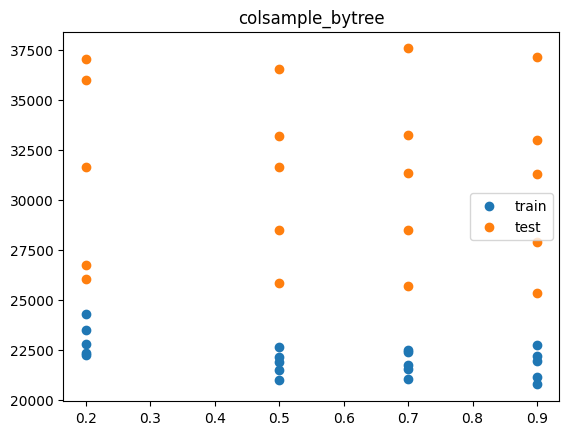

In [51]:
plot_result(result, "colsample_bytree")

In [52]:
xgboost_param_dic = {
    "max_depth": 4,
    "learning_rate": 0.1,
    "colsample_bytree": 0.5,
    "n_estimators": 500,
    "early_stopping_rounds": 5,
    "verbose": False,
    "eval_metric": "rmse",
    "reg_lambda": 8,
    "min_child_weight": 100}
result = hp_tuning('max_depth', 
                   [4,6,8,10], 
                   xgboost_param_dic, 
                   num_model_var, 
                   target, 
                   "xgboost",
                   df_train_engineered)

training max_depth = 4
[0]	validation_0-rmse:160847
[1]	validation_0-rmse:148329
[2]	validation_0-rmse:137045
[3]	validation_0-rmse:126891
[4]	validation_0-rmse:117867
[5]	validation_0-rmse:109870
[6]	validation_0-rmse:102558
[7]	validation_0-rmse:95821.2
[8]	validation_0-rmse:90045.4
[9]	validation_0-rmse:84993.6
[10]	validation_0-rmse:80546.1
[11]	validation_0-rmse:76686.8
[12]	validation_0-rmse:73323.5
[13]	validation_0-rmse:70141.6
[14]	validation_0-rmse:67177.8
[15]	validation_0-rmse:64390.2
[16]	validation_0-rmse:61874.1
[17]	validation_0-rmse:59649.8
[18]	validation_0-rmse:57697.9
[19]	validation_0-rmse:55978.6
[20]	validation_0-rmse:54522.3
[21]	validation_0-rmse:53093.5
[22]	validation_0-rmse:52064
[23]	validation_0-rmse:50930.5
[24]	validation_0-rmse:49949
[25]	validation_0-rmse:49091
[26]	validation_0-rmse:48323.8
[27]	validation_0-rmse:47772.2
[28]	validation_0-rmse:47104.5
[29]	validation_0-rmse:46693.2
[30]	validation_0-rmse:46115.1
[31]	validation_0-rmse:45720.2
[32]	val

[261]	validation_0-rmse:36983.2
[262]	validation_0-rmse:36936.8
[263]	validation_0-rmse:36943.5
[264]	validation_0-rmse:36943.5
[265]	validation_0-rmse:36955.5
[266]	validation_0-rmse:37005
[267]	validation_0-rmse:37060.2
[268]	validation_0-rmse:37049.8
[269]	validation_0-rmse:36962.1
[270]	validation_0-rmse:37017.6
[271]	validation_0-rmse:36999.8
[272]	validation_0-rmse:36945.9
[273]	validation_0-rmse:36934.1
[274]	validation_0-rmse:36931.8
[275]	validation_0-rmse:36974.1
[276]	validation_0-rmse:36931.8
[277]	validation_0-rmse:36978.8
[278]	validation_0-rmse:36962.9
[279]	validation_0-rmse:36912.8
[280]	validation_0-rmse:36956
[281]	validation_0-rmse:36957.3
[282]	validation_0-rmse:37011.2
[283]	validation_0-rmse:36989.9
[284]	validation_0-rmse:36980.6
[285]	validation_0-rmse:36967
[286]	validation_0-rmse:36952.5
[287]	validation_0-rmse:36931.4
[288]	validation_0-rmse:36941.5
[289]	validation_0-rmse:36930.1
[290]	validation_0-rmse:36977.3
[291]	validation_0-rmse:36936.7
[292]	validati

[20]	validation_0-rmse:68486.9
[21]	validation_0-rmse:67236.1
[22]	validation_0-rmse:66169.9
[23]	validation_0-rmse:65212.1
[24]	validation_0-rmse:64386.3
[25]	validation_0-rmse:63606.6
[26]	validation_0-rmse:62965.6
[27]	validation_0-rmse:62380
[28]	validation_0-rmse:61710
[29]	validation_0-rmse:60770.7
[30]	validation_0-rmse:60365.6
[31]	validation_0-rmse:59957.4
[32]	validation_0-rmse:59622
[33]	validation_0-rmse:59261.9
[34]	validation_0-rmse:58948.2
[35]	validation_0-rmse:58231.7
[36]	validation_0-rmse:57992.9
[37]	validation_0-rmse:57694.6
[38]	validation_0-rmse:57452.1
[39]	validation_0-rmse:57250.5
[40]	validation_0-rmse:57011.7
[41]	validation_0-rmse:56475.6
[42]	validation_0-rmse:56254.4
[43]	validation_0-rmse:56103.8
[44]	validation_0-rmse:55968.7
[45]	validation_0-rmse:55728.1
[46]	validation_0-rmse:55493.4
[47]	validation_0-rmse:55298.7
[48]	validation_0-rmse:55128.3
[49]	validation_0-rmse:54969.6
[50]	validation_0-rmse:54833.3
[51]	validation_0-rmse:54674
[52]	validation_

[281]	validation_0-rmse:38452.5
[282]	validation_0-rmse:38425
[283]	validation_0-rmse:38411.4
[284]	validation_0-rmse:38351.4
[285]	validation_0-rmse:38318.5
[286]	validation_0-rmse:38348.4
[287]	validation_0-rmse:38309
[288]	validation_0-rmse:38280.1
[289]	validation_0-rmse:38257.5
[290]	validation_0-rmse:38284.6
[291]	validation_0-rmse:38295.2
[292]	validation_0-rmse:38264.3
[293]	validation_0-rmse:38236.3
[294]	validation_0-rmse:38206.8
[295]	validation_0-rmse:38169.6
[296]	validation_0-rmse:38146.1
[297]	validation_0-rmse:38089.9
[298]	validation_0-rmse:38056.1
[299]	validation_0-rmse:38030.7
[300]	validation_0-rmse:38010.3
[301]	validation_0-rmse:37980.6
[302]	validation_0-rmse:37974
[303]	validation_0-rmse:37876.1
[304]	validation_0-rmse:37835.6
[305]	validation_0-rmse:37791
[306]	validation_0-rmse:37729
[307]	validation_0-rmse:37703.8
[308]	validation_0-rmse:37674.1
[309]	validation_0-rmse:37638.3
[310]	validation_0-rmse:37615.8
[311]	validation_0-rmse:37597.6
[312]	validation_0

[41]	validation_0-rmse:35484.9
[42]	validation_0-rmse:35537.1
[43]	validation_0-rmse:35394.6
[44]	validation_0-rmse:35446.2
[45]	validation_0-rmse:35288.1
[46]	validation_0-rmse:35296.9
[47]	validation_0-rmse:35247.3
[48]	validation_0-rmse:35306.3
[49]	validation_0-rmse:35213.2
[50]	validation_0-rmse:35260.4
[51]	validation_0-rmse:35202.8
[52]	validation_0-rmse:35057.1
[53]	validation_0-rmse:34859.9
[54]	validation_0-rmse:34974.9
[55]	validation_0-rmse:35034.3
[56]	validation_0-rmse:34908.2
[57]	validation_0-rmse:35008.8
[58]	validation_0-rmse:34962.9
[59]	validation_0-rmse:35032.5
[60]	validation_0-rmse:34917.8
[61]	validation_0-rmse:34967.7
[62]	validation_0-rmse:34986.8
[63]	validation_0-rmse:35088
[64]	validation_0-rmse:35122.1
[65]	validation_0-rmse:34938.2
[66]	validation_0-rmse:35023
[67]	validation_0-rmse:34937.1
[68]	validation_0-rmse:35042.2
[69]	validation_0-rmse:34949.8
[70]	validation_0-rmse:34860.5
[71]	validation_0-rmse:34916.7
[72]	validation_0-rmse:34952.3
[73]	validat

[301]	validation_0-rmse:30924.6
[302]	validation_0-rmse:30893.1
[303]	validation_0-rmse:30847.1
[304]	validation_0-rmse:30878.7
[305]	validation_0-rmse:30864.8
[306]	validation_0-rmse:30869.9
[307]	validation_0-rmse:30872.7
[308]	validation_0-rmse:30885.4
[309]	validation_0-rmse:30856.9
[310]	validation_0-rmse:30864.8
[311]	validation_0-rmse:30842.2
[312]	validation_0-rmse:30792.5
[313]	validation_0-rmse:30788.4
[314]	validation_0-rmse:30798.4
[315]	validation_0-rmse:30807.2
[316]	validation_0-rmse:30798.3
[317]	validation_0-rmse:30788.1
[318]	validation_0-rmse:30712.1
[319]	validation_0-rmse:30670
[320]	validation_0-rmse:30614.4
[321]	validation_0-rmse:30635.3
[322]	validation_0-rmse:30637.4
[323]	validation_0-rmse:30604.2
[324]	validation_0-rmse:30613.2
[325]	validation_0-rmse:30603
[326]	validation_0-rmse:30521.2
[327]	validation_0-rmse:30503.1
[328]	validation_0-rmse:30498
[329]	validation_0-rmse:30451.9
[330]	validation_0-rmse:30454.6
[331]	validation_0-rmse:30439.8
[332]	validati

[62]	validation_0-rmse:36018.2
[63]	validation_0-rmse:35916.6
[64]	validation_0-rmse:35686.5
[65]	validation_0-rmse:35610.7
[66]	validation_0-rmse:35575.9
[67]	validation_0-rmse:35465
[68]	validation_0-rmse:35428.1
[69]	validation_0-rmse:35393.7
[70]	validation_0-rmse:35328.7
[71]	validation_0-rmse:35287.7
[72]	validation_0-rmse:35122.3
[73]	validation_0-rmse:35054.2
[74]	validation_0-rmse:34881.4
[75]	validation_0-rmse:34792.7
[76]	validation_0-rmse:34683.4
[77]	validation_0-rmse:34558.9
[78]	validation_0-rmse:34515.1
[79]	validation_0-rmse:34482.4
[80]	validation_0-rmse:34351.4
[81]	validation_0-rmse:34252.5
[82]	validation_0-rmse:34177.7
[83]	validation_0-rmse:34037.6
[84]	validation_0-rmse:33968.2
[85]	validation_0-rmse:33908.5
[86]	validation_0-rmse:33865.4
[87]	validation_0-rmse:33730.3
[88]	validation_0-rmse:33604.1
[89]	validation_0-rmse:33562.1
[90]	validation_0-rmse:33509.1
[91]	validation_0-rmse:33465.5
[92]	validation_0-rmse:33441
[93]	validation_0-rmse:33399.8
[94]	validat

[321]	validation_0-rmse:26841.8
[322]	validation_0-rmse:26832.6
[323]	validation_0-rmse:26824
[324]	validation_0-rmse:26828.7
[325]	validation_0-rmse:26797
[326]	validation_0-rmse:26790.9
[327]	validation_0-rmse:26762
[328]	validation_0-rmse:26767.1
[329]	validation_0-rmse:26765.4
[330]	validation_0-rmse:26758.4
[331]	validation_0-rmse:26765.5
[332]	validation_0-rmse:26731.7
[333]	validation_0-rmse:26729.9
[334]	validation_0-rmse:26705.7
[335]	validation_0-rmse:26710
[336]	validation_0-rmse:26687
[337]	validation_0-rmse:26688.1
[338]	validation_0-rmse:26691.7
[339]	validation_0-rmse:26665.5
[340]	validation_0-rmse:26658.9
[341]	validation_0-rmse:26640.5
[342]	validation_0-rmse:26638.3
[343]	validation_0-rmse:26613.6
[344]	validation_0-rmse:26634.3
[345]	validation_0-rmse:26613.4
[346]	validation_0-rmse:26567.2
[347]	validation_0-rmse:26568
[348]	validation_0-rmse:26570.1
[349]	validation_0-rmse:26547.4
[350]	validation_0-rmse:26542.7
[351]	validation_0-rmse:26516.8
[352]	validation_0-r

[82]	validation_0-rmse:41074.8
[83]	validation_0-rmse:40896.4
[84]	validation_0-rmse:40822.2
[85]	validation_0-rmse:40812.9
[86]	validation_0-rmse:40730.9
[87]	validation_0-rmse:40657.9
[88]	validation_0-rmse:40651.6
[89]	validation_0-rmse:40610
[90]	validation_0-rmse:40613.2
[91]	validation_0-rmse:40552.8
[92]	validation_0-rmse:40415.8
[93]	validation_0-rmse:40389.5
[94]	validation_0-rmse:40306.1
[95]	validation_0-rmse:40291.1
[96]	validation_0-rmse:40217.9
[97]	validation_0-rmse:40144.8
[98]	validation_0-rmse:40127.7
[99]	validation_0-rmse:40062.4
[100]	validation_0-rmse:39939.3
[101]	validation_0-rmse:39920.2
[102]	validation_0-rmse:39908.2
[103]	validation_0-rmse:39824.2
[104]	validation_0-rmse:39810.2
[105]	validation_0-rmse:39744.7
[106]	validation_0-rmse:39609.2
[107]	validation_0-rmse:39594.1
[108]	validation_0-rmse:39541.8
[109]	validation_0-rmse:39536.7
[110]	validation_0-rmse:39477.1
[111]	validation_0-rmse:39489.7
[112]	validation_0-rmse:39503.2
[113]	validation_0-rmse:3943

[341]	validation_0-rmse:33497.7
[342]	validation_0-rmse:33482.8
[343]	validation_0-rmse:33438.3
[344]	validation_0-rmse:33430.7
[345]	validation_0-rmse:33440.1
[346]	validation_0-rmse:33434.3
[347]	validation_0-rmse:33425
[348]	validation_0-rmse:33427.4
[349]	validation_0-rmse:33445.7
[350]	validation_0-rmse:33395.1
[351]	validation_0-rmse:33393.4
[352]	validation_0-rmse:33378.2
[353]	validation_0-rmse:33339.8
[354]	validation_0-rmse:33286.9
[355]	validation_0-rmse:33280
[356]	validation_0-rmse:33258.4
[357]	validation_0-rmse:33248.3
[358]	validation_0-rmse:33196.2
[359]	validation_0-rmse:33180.7
[360]	validation_0-rmse:33171
[361]	validation_0-rmse:33165.4
[362]	validation_0-rmse:33136.4
[363]	validation_0-rmse:33112.8
[364]	validation_0-rmse:33076.9
[365]	validation_0-rmse:33051.2
[366]	validation_0-rmse:33057.3
[367]	validation_0-rmse:33035
[368]	validation_0-rmse:33025.7
[369]	validation_0-rmse:33006.2
[370]	validation_0-rmse:33002.3
[371]	validation_0-rmse:32980.8
[372]	validation

[102]	validation_0-rmse:38699.1
[103]	validation_0-rmse:38654.2
[104]	validation_0-rmse:38757.7
[105]	validation_0-rmse:38595.2
[106]	validation_0-rmse:38657.2
[107]	validation_0-rmse:38625.8
[108]	validation_0-rmse:38695.8
[109]	validation_0-rmse:38589.2
[110]	validation_0-rmse:38566.1
[111]	validation_0-rmse:38537.7
[112]	validation_0-rmse:38524.8
[113]	validation_0-rmse:38465.9
[114]	validation_0-rmse:38516.4
[115]	validation_0-rmse:38529.1
[116]	validation_0-rmse:38439.9
[117]	validation_0-rmse:38396.3
[118]	validation_0-rmse:38377.5
[119]	validation_0-rmse:38328.9
[120]	validation_0-rmse:38307.5
[121]	validation_0-rmse:38411
[122]	validation_0-rmse:38232.5
[123]	validation_0-rmse:38342.7
[124]	validation_0-rmse:38387.4
[125]	validation_0-rmse:38285.4
[126]	validation_0-rmse:38199
[127]	validation_0-rmse:38254.6
[128]	validation_0-rmse:38110
[129]	validation_0-rmse:38178.9
[130]	validation_0-rmse:38157.7
[131]	validation_0-rmse:38227.5
[132]	validation_0-rmse:38134.9
[133]	validati

[361]	validation_0-rmse:37108.5
[362]	validation_0-rmse:37088.7
[363]	validation_0-rmse:37051.6
[364]	validation_0-rmse:37056.2
[365]	validation_0-rmse:37026.1
[366]	validation_0-rmse:37019
[367]	validation_0-rmse:37012.7
[368]	validation_0-rmse:37008.9
[369]	validation_0-rmse:37043.9
[370]	validation_0-rmse:37037.3
[371]	validation_0-rmse:37019.4
[372]	validation_0-rmse:37025.9
[373]	validation_0-rmse:37012.3
[374]	validation_0-rmse:37021.4
[375]	validation_0-rmse:37017.6
[376]	validation_0-rmse:37007.2
[377]	validation_0-rmse:36989.9
[378]	validation_0-rmse:36992.4
[379]	validation_0-rmse:36980.2
[380]	validation_0-rmse:36979.6
[381]	validation_0-rmse:37012.1
[382]	validation_0-rmse:36994.5
[383]	validation_0-rmse:37037.5
[384]	validation_0-rmse:37050.5
[385]	validation_0-rmse:37027.1
[386]	validation_0-rmse:37050
[387]	validation_0-rmse:37083.7
[388]	validation_0-rmse:37070.9
[389]	validation_0-rmse:37054.8
[390]	validation_0-rmse:37085.4
[391]	validation_0-rmse:37051.5
[392]	valida

[123]	validation_0-rmse:46656
[124]	validation_0-rmse:46582.6
[125]	validation_0-rmse:46519.4
[126]	validation_0-rmse:46447.9
[127]	validation_0-rmse:46388.6
[128]	validation_0-rmse:46299.1
[129]	validation_0-rmse:46246.6
[130]	validation_0-rmse:46115
[131]	validation_0-rmse:46040.1
[132]	validation_0-rmse:45964.9
[133]	validation_0-rmse:45922.9
[134]	validation_0-rmse:45893.5
[135]	validation_0-rmse:45825.8
[136]	validation_0-rmse:45688.9
[137]	validation_0-rmse:45607.1
[138]	validation_0-rmse:45545.4
[139]	validation_0-rmse:45480.3
[140]	validation_0-rmse:45184
[141]	validation_0-rmse:45129.7
[142]	validation_0-rmse:45095.1
[143]	validation_0-rmse:45033.6
[144]	validation_0-rmse:44973.5
[145]	validation_0-rmse:44891.1
[146]	validation_0-rmse:44852.3
[147]	validation_0-rmse:44721.1
[148]	validation_0-rmse:44649.9
[149]	validation_0-rmse:44555.5
[150]	validation_0-rmse:44492.3
[151]	validation_0-rmse:44460.6
[152]	validation_0-rmse:44412.3
[153]	validation_0-rmse:44372.6
[154]	validati

[381]	validation_0-rmse:35036.2
[382]	validation_0-rmse:35022.4
[383]	validation_0-rmse:35003.4
[384]	validation_0-rmse:34965.1
[385]	validation_0-rmse:34940.3
[386]	validation_0-rmse:34926
[387]	validation_0-rmse:34966.4
[388]	validation_0-rmse:34930.6
[389]	validation_0-rmse:34947.5
[390]	validation_0-rmse:34829.3
[391]	validation_0-rmse:34810.7
[392]	validation_0-rmse:34775.4
[393]	validation_0-rmse:34754.8
[394]	validation_0-rmse:34721.6
[395]	validation_0-rmse:34700.3
[396]	validation_0-rmse:34681.6
[397]	validation_0-rmse:34634.4
[398]	validation_0-rmse:34614.7
[399]	validation_0-rmse:34600.4
[400]	validation_0-rmse:34579.6
[401]	validation_0-rmse:34548.1
[402]	validation_0-rmse:34511.5
[403]	validation_0-rmse:34506.3
[404]	validation_0-rmse:34490.8
[405]	validation_0-rmse:34459.4
[406]	validation_0-rmse:34418.5
[407]	validation_0-rmse:34405.5
[408]	validation_0-rmse:34374.1
[409]	validation_0-rmse:34334.4
[410]	validation_0-rmse:34320.8
[411]	validation_0-rmse:34285.8
[412]	vali

[142]	validation_0-rmse:32753
[143]	validation_0-rmse:32682.2
[144]	validation_0-rmse:32712.9
[145]	validation_0-rmse:32660.4
[146]	validation_0-rmse:32679
[147]	validation_0-rmse:32732.2
[148]	validation_0-rmse:32632.2
[149]	validation_0-rmse:32620.2
[150]	validation_0-rmse:32611.3
[151]	validation_0-rmse:32570
[152]	validation_0-rmse:32606.7
[153]	validation_0-rmse:32627.9
[154]	validation_0-rmse:32569.3
[155]	validation_0-rmse:32622.3
[156]	validation_0-rmse:32562.2
[157]	validation_0-rmse:32604.3
[158]	validation_0-rmse:32504.8
[159]	validation_0-rmse:32504.9
[160]	validation_0-rmse:32413.9
[161]	validation_0-rmse:32439.9
[162]	validation_0-rmse:32326.8
[163]	validation_0-rmse:32363.7
[164]	validation_0-rmse:32280.2
[165]	validation_0-rmse:32314
[166]	validation_0-rmse:32258.1
[167]	validation_0-rmse:32300
[168]	validation_0-rmse:32261.8
[169]	validation_0-rmse:32224.1
[170]	validation_0-rmse:32260.5
[171]	validation_0-rmse:32222.7
[172]	validation_0-rmse:32276.2
[173]	validation_0

[400]	validation_0-rmse:28526.4
[401]	validation_0-rmse:28544.7
[402]	validation_0-rmse:28496.8
[403]	validation_0-rmse:28515.3
[404]	validation_0-rmse:28488.9
[405]	validation_0-rmse:28431.3
[406]	validation_0-rmse:28389.5
[407]	validation_0-rmse:28408.7
[408]	validation_0-rmse:28370.3
[409]	validation_0-rmse:28379.1
[410]	validation_0-rmse:28345
[411]	validation_0-rmse:28364.3
[412]	validation_0-rmse:28336.9
[413]	validation_0-rmse:28338.5
[414]	validation_0-rmse:28309.4
[415]	validation_0-rmse:28304.6
[416]	validation_0-rmse:28273.6
[417]	validation_0-rmse:28278.5
[418]	validation_0-rmse:28283.6
[419]	validation_0-rmse:28286
[420]	validation_0-rmse:28273.3
[421]	validation_0-rmse:28298.3
[422]	validation_0-rmse:28246.9
[423]	validation_0-rmse:28267.2
[424]	validation_0-rmse:28288.7
[425]	validation_0-rmse:28266.2
[426]	validation_0-rmse:28271.9
[427]	validation_0-rmse:28244.6
[428]	validation_0-rmse:28188.6
[429]	validation_0-rmse:28165.2
[430]	validation_0-rmse:28187.9
[431]	valida

[162]	validation_0-rmse:28927.8
[163]	validation_0-rmse:28858.8
[164]	validation_0-rmse:28825.2
[165]	validation_0-rmse:28816.8
[166]	validation_0-rmse:28768.8
[167]	validation_0-rmse:28759.8
[168]	validation_0-rmse:28716.7
[169]	validation_0-rmse:28699.1
[170]	validation_0-rmse:28685
[171]	validation_0-rmse:28645.2
[172]	validation_0-rmse:28621
[173]	validation_0-rmse:28571.5
[174]	validation_0-rmse:28572.2
[175]	validation_0-rmse:28562.9
[176]	validation_0-rmse:28544.7
[177]	validation_0-rmse:28467.6
[178]	validation_0-rmse:28465
[179]	validation_0-rmse:28404.2
[180]	validation_0-rmse:28403.8
[181]	validation_0-rmse:28404
[182]	validation_0-rmse:28373.7
[183]	validation_0-rmse:28349.8
[184]	validation_0-rmse:28368.4
[185]	validation_0-rmse:28366.7
[186]	validation_0-rmse:28289
[187]	validation_0-rmse:28284.6
[188]	validation_0-rmse:28219.5
[189]	validation_0-rmse:28200.4
[190]	validation_0-rmse:28177.6
[191]	validation_0-rmse:28175
[192]	validation_0-rmse:28157.5
[193]	validation_0-r

[420]	validation_0-rmse:25090.2
[421]	validation_0-rmse:25091.1
[422]	validation_0-rmse:25084.8
[423]	validation_0-rmse:25075.8
[424]	validation_0-rmse:25094.7
[425]	validation_0-rmse:25074.9
[426]	validation_0-rmse:25079
[427]	validation_0-rmse:25067.6
[428]	validation_0-rmse:25072.2
[429]	validation_0-rmse:25054.3
[430]	validation_0-rmse:25053.3
[431]	validation_0-rmse:25059.3
[432]	validation_0-rmse:25065.2
[433]	validation_0-rmse:25061.8
[434]	validation_0-rmse:25088.1
[435]	validation_0-rmse:25066.7
[436]	validation_0-rmse:25032.7
[437]	validation_0-rmse:25022.4
[438]	validation_0-rmse:25024.4
[439]	validation_0-rmse:25021.2
[440]	validation_0-rmse:25034
[441]	validation_0-rmse:25003.9
[442]	validation_0-rmse:25002.7
[443]	validation_0-rmse:24977.8
[444]	validation_0-rmse:24970.1
[445]	validation_0-rmse:24969.6
[446]	validation_0-rmse:24956.9
[447]	validation_0-rmse:24941.8
[448]	validation_0-rmse:24950
[449]	validation_0-rmse:24957
[450]	validation_0-rmse:24969.1
[451]	validation

[182]	validation_0-rmse:36634.4
[183]	validation_0-rmse:36596.4
[184]	validation_0-rmse:36583.8
[185]	validation_0-rmse:36541.5
[186]	validation_0-rmse:36545.7
[187]	validation_0-rmse:36535.8
[188]	validation_0-rmse:36478.5
[189]	validation_0-rmse:36457.7
[190]	validation_0-rmse:36460
[191]	validation_0-rmse:36459
[192]	validation_0-rmse:36431.1
[193]	validation_0-rmse:36414.3
[194]	validation_0-rmse:36366.6
[195]	validation_0-rmse:36333
[196]	validation_0-rmse:36327.2
[197]	validation_0-rmse:36290.8
[198]	validation_0-rmse:36288.8
[199]	validation_0-rmse:36251.2
[200]	validation_0-rmse:36227.4
[201]	validation_0-rmse:36192.1
[202]	validation_0-rmse:36186.4
[203]	validation_0-rmse:36198.7
[204]	validation_0-rmse:36098
[205]	validation_0-rmse:36057.8
[206]	validation_0-rmse:36054.7
[207]	validation_0-rmse:36015.1
[208]	validation_0-rmse:36008.4
[209]	validation_0-rmse:35966.7
[210]	validation_0-rmse:35953.8
[211]	validation_0-rmse:35975.1
[212]	validation_0-rmse:35951.9
[213]	validation

[440]	validation_0-rmse:31928.5
[441]	validation_0-rmse:31908.5
[442]	validation_0-rmse:31911.5
[443]	validation_0-rmse:31905.5
[444]	validation_0-rmse:31899.3
[445]	validation_0-rmse:31879.1
[446]	validation_0-rmse:31874.1
[447]	validation_0-rmse:31878.8
[448]	validation_0-rmse:31868.3
[449]	validation_0-rmse:31852.9
[450]	validation_0-rmse:31845.3
[451]	validation_0-rmse:31845
[452]	validation_0-rmse:31839
[453]	validation_0-rmse:31846.2
[454]	validation_0-rmse:31831.6
[455]	validation_0-rmse:31820.9
[456]	validation_0-rmse:31798.6
[457]	validation_0-rmse:31794.5
[458]	validation_0-rmse:31784.6
[459]	validation_0-rmse:31785.5
[460]	validation_0-rmse:31771.2
[461]	validation_0-rmse:31772.2
[462]	validation_0-rmse:31752.1
[463]	validation_0-rmse:31744.5
[464]	validation_0-rmse:31747.2
[465]	validation_0-rmse:31744.5
[466]	validation_0-rmse:31703.6
[467]	validation_0-rmse:31703.4
[468]	validation_0-rmse:31676.3
[469]	validation_0-rmse:31663.1
[470]	validation_0-rmse:31655.1
[471]	valida

[201]	validation_0-rmse:37161.5
[202]	validation_0-rmse:37149.7
[203]	validation_0-rmse:37202.1
[204]	validation_0-rmse:37175.9
[205]	validation_0-rmse:37226.3
[206]	validation_0-rmse:37217.6
[207]	validation_0-rmse:37210.5
[208]	validation_0-rmse:37170.1
[209]	validation_0-rmse:37127.1
[210]	validation_0-rmse:37173.6
[211]	validation_0-rmse:37211.5
[212]	validation_0-rmse:37198.6
[213]	validation_0-rmse:37214.1
[214]	validation_0-rmse:37282.4
[215]	validation_0-rmse:37239.9
[216]	validation_0-rmse:37232.1
[217]	validation_0-rmse:37202.5
[218]	validation_0-rmse:37122.1
[219]	validation_0-rmse:37179.3
[220]	validation_0-rmse:37252
[221]	validation_0-rmse:37172.1
[222]	validation_0-rmse:37226.7
[223]	validation_0-rmse:37181.8
[224]	validation_0-rmse:37138.1
[225]	validation_0-rmse:37060.7
[226]	validation_0-rmse:37132.1
[227]	validation_0-rmse:37195
[228]	validation_0-rmse:37181.4
[229]	validation_0-rmse:37171.6
[230]	validation_0-rmse:37200.6
[231]	validation_0-rmse:37158
[232]	validati

[460]	validation_0-rmse:36954.3
[461]	validation_0-rmse:36953.1
[462]	validation_0-rmse:36938.4
[463]	validation_0-rmse:36959.5
[464]	validation_0-rmse:36940.2
[465]	validation_0-rmse:36929.8
[466]	validation_0-rmse:36903.2
[467]	validation_0-rmse:36930.9
[468]	validation_0-rmse:36971.4
[469]	validation_0-rmse:36973.1
[470]	validation_0-rmse:36988.8
[471]	validation_0-rmse:36974.6
[472]	validation_0-rmse:36996.9
[473]	validation_0-rmse:36980.4
[474]	validation_0-rmse:37003.5
[475]	validation_0-rmse:37010.5
[476]	validation_0-rmse:37033.9
[477]	validation_0-rmse:37014.3
[478]	validation_0-rmse:37040
[479]	validation_0-rmse:37058
[480]	validation_0-rmse:37040.3
[481]	validation_0-rmse:37018.5
[482]	validation_0-rmse:37034
[483]	validation_0-rmse:37027.4
[484]	validation_0-rmse:37022.1
[485]	validation_0-rmse:37025.8
[486]	validation_0-rmse:37044.2
[487]	validation_0-rmse:37033.2
[488]	validation_0-rmse:37033.3
[489]	validation_0-rmse:37013.6
[490]	validation_0-rmse:37004.3
[491]	validati

[222]	validation_0-rmse:39670.3
[223]	validation_0-rmse:39651
[224]	validation_0-rmse:39624.4
[225]	validation_0-rmse:39542
[226]	validation_0-rmse:39451
[227]	validation_0-rmse:39397.5
[228]	validation_0-rmse:39359.8
[229]	validation_0-rmse:39334
[230]	validation_0-rmse:39279
[231]	validation_0-rmse:39230.4
[232]	validation_0-rmse:39263.4
[233]	validation_0-rmse:39239.1
[234]	validation_0-rmse:39186.9
[235]	validation_0-rmse:39130.7
[236]	validation_0-rmse:39102.5
[237]	validation_0-rmse:39047.2
[238]	validation_0-rmse:38991
[239]	validation_0-rmse:38972.2
[240]	validation_0-rmse:38902.7
[241]	validation_0-rmse:38865.5
[242]	validation_0-rmse:38672.2
[243]	validation_0-rmse:38625.8
[244]	validation_0-rmse:38599.2
[245]	validation_0-rmse:38562.4
[246]	validation_0-rmse:38528
[247]	validation_0-rmse:38507.5
[248]	validation_0-rmse:38456.7
[249]	validation_0-rmse:38406.2
[250]	validation_0-rmse:38374.3
[251]	validation_0-rmse:38337.2
[252]	validation_0-rmse:38306.1
[253]	validation_0-rms

[481]	validation_0-rmse:32244.3
[482]	validation_0-rmse:32159.8
[483]	validation_0-rmse:32144.5
[484]	validation_0-rmse:32143.1
[485]	validation_0-rmse:32129.5
[486]	validation_0-rmse:32129.4
[487]	validation_0-rmse:32122.8
[488]	validation_0-rmse:32109.4
[489]	validation_0-rmse:32093.1
[490]	validation_0-rmse:32082.9
[491]	validation_0-rmse:32073.9
[492]	validation_0-rmse:32065.5
[493]	validation_0-rmse:32050.7
[494]	validation_0-rmse:32033.8
[495]	validation_0-rmse:32007.2
[496]	validation_0-rmse:31982.1
[497]	validation_0-rmse:31976.8
[498]	validation_0-rmse:31959.7
[499]	validation_0-rmse:31947.6
[0]	validation_0-rmse:154491
[1]	validation_0-rmse:140556
[2]	validation_0-rmse:127619
[3]	validation_0-rmse:116249
[4]	validation_0-rmse:106260
[5]	validation_0-rmse:97087.4
[6]	validation_0-rmse:89189
[7]	validation_0-rmse:81759.7
[8]	validation_0-rmse:75341.9
[9]	validation_0-rmse:69782.9
[10]	validation_0-rmse:65251.5
[11]	validation_0-rmse:61195.2
[12]	validation_0-rmse:57100.9
[13]	v

[242]	validation_0-rmse:31326.9
[243]	validation_0-rmse:31317.6
[244]	validation_0-rmse:31363.2
[245]	validation_0-rmse:31369.6
[246]	validation_0-rmse:31315.1
[247]	validation_0-rmse:31334.3
[248]	validation_0-rmse:31312.9
[249]	validation_0-rmse:31294.8
[250]	validation_0-rmse:31324.1
[251]	validation_0-rmse:31237.1
[252]	validation_0-rmse:31191.4
[253]	validation_0-rmse:31182.4
[254]	validation_0-rmse:31224.9
[255]	validation_0-rmse:31170.5
[256]	validation_0-rmse:31144.8
[257]	validation_0-rmse:31160.9
[258]	validation_0-rmse:31165.5
[259]	validation_0-rmse:31148.1
[260]	validation_0-rmse:31144.5
[261]	validation_0-rmse:31042.7
[262]	validation_0-rmse:31086
[263]	validation_0-rmse:31030.4
[264]	validation_0-rmse:31061.6
[265]	validation_0-rmse:31071.2
[266]	validation_0-rmse:31072.1
[267]	validation_0-rmse:31067.8
[268]	validation_0-rmse:31082.1
[269]	validation_0-rmse:31068.5
[270]	validation_0-rmse:31010
[271]	validation_0-rmse:31041.7
[272]	validation_0-rmse:31072.2
[273]	valida

[0]	validation_0-rmse:161333
[1]	validation_0-rmse:147507
[2]	validation_0-rmse:135104
[3]	validation_0-rmse:124030
[4]	validation_0-rmse:113960
[5]	validation_0-rmse:105043
[6]	validation_0-rmse:97160.1
[7]	validation_0-rmse:89979.4
[8]	validation_0-rmse:83630.7
[9]	validation_0-rmse:78062.1
[10]	validation_0-rmse:73293.1
[11]	validation_0-rmse:69108.2
[12]	validation_0-rmse:65381.5
[13]	validation_0-rmse:61828.6
[14]	validation_0-rmse:58822.3
[15]	validation_0-rmse:55921.7
[16]	validation_0-rmse:53313.1
[17]	validation_0-rmse:51138.2
[18]	validation_0-rmse:49172.3
[19]	validation_0-rmse:47483.3
[20]	validation_0-rmse:46060.8
[21]	validation_0-rmse:44750.1
[22]	validation_0-rmse:43603.9
[23]	validation_0-rmse:42625.8
[24]	validation_0-rmse:41872.2
[25]	validation_0-rmse:41110.2
[26]	validation_0-rmse:40486.5
[27]	validation_0-rmse:39955.7
[28]	validation_0-rmse:39498.5
[29]	validation_0-rmse:39104.1
[30]	validation_0-rmse:38804.2
[31]	validation_0-rmse:38492.6
[32]	validation_0-rmse:3

[262]	validation_0-rmse:26362
[263]	validation_0-rmse:26359.7
[264]	validation_0-rmse:26316.2
[265]	validation_0-rmse:26334.8
[266]	validation_0-rmse:26309.8
[267]	validation_0-rmse:26270.2
[268]	validation_0-rmse:26266.5
[269]	validation_0-rmse:26301.2
[270]	validation_0-rmse:26228.5
[271]	validation_0-rmse:26215.5
[272]	validation_0-rmse:26188.7
[273]	validation_0-rmse:26187.4
[274]	validation_0-rmse:26184.2
[275]	validation_0-rmse:26164.8
[276]	validation_0-rmse:26172.5
[277]	validation_0-rmse:26133.2
[278]	validation_0-rmse:26141.5
[279]	validation_0-rmse:26115.1
[280]	validation_0-rmse:26073.9
[281]	validation_0-rmse:26032.1
[282]	validation_0-rmse:26008
[283]	validation_0-rmse:25991.9
[284]	validation_0-rmse:25991.5
[285]	validation_0-rmse:25974
[286]	validation_0-rmse:25965.8
[287]	validation_0-rmse:25870.4
[288]	validation_0-rmse:25871.4
[289]	validation_0-rmse:25864.9
[290]	validation_0-rmse:25843.4
[291]	validation_0-rmse:25786
[292]	validation_0-rmse:25769.4
[293]	validation

[21]	validation_0-rmse:46673.6
[22]	validation_0-rmse:46049.7
[23]	validation_0-rmse:45523
[24]	validation_0-rmse:45135.3
[25]	validation_0-rmse:44767.8
[26]	validation_0-rmse:44505.4
[27]	validation_0-rmse:44125
[28]	validation_0-rmse:43836.8
[29]	validation_0-rmse:43694.9
[30]	validation_0-rmse:43592.9
[31]	validation_0-rmse:43393.3
[32]	validation_0-rmse:43285.5
[33]	validation_0-rmse:43179.8
[34]	validation_0-rmse:43007.3
[35]	validation_0-rmse:42851
[36]	validation_0-rmse:42668.8
[37]	validation_0-rmse:42548.9
[38]	validation_0-rmse:42485.8
[39]	validation_0-rmse:42409.5
[40]	validation_0-rmse:42370.2
[41]	validation_0-rmse:42290.9
[42]	validation_0-rmse:42242.9
[43]	validation_0-rmse:42157.6
[44]	validation_0-rmse:42135.4
[45]	validation_0-rmse:42060.1
[46]	validation_0-rmse:42041.1
[47]	validation_0-rmse:41916
[48]	validation_0-rmse:41886.4
[49]	validation_0-rmse:41840.9
[50]	validation_0-rmse:41771.2
[51]	validation_0-rmse:41750.3
[52]	validation_0-rmse:41723.7
[53]	validation_

[282]	validation_0-rmse:33897.1
[283]	validation_0-rmse:33894.5
[284]	validation_0-rmse:33872.4
[285]	validation_0-rmse:33842.6
[286]	validation_0-rmse:33806.9
[287]	validation_0-rmse:33782.8
[288]	validation_0-rmse:33765.1
[289]	validation_0-rmse:33733.7
[290]	validation_0-rmse:33729.8
[291]	validation_0-rmse:33717.2
[292]	validation_0-rmse:33717
[293]	validation_0-rmse:33687.3
[294]	validation_0-rmse:33670.1
[295]	validation_0-rmse:33604.7
[296]	validation_0-rmse:33618.8
[297]	validation_0-rmse:33603.3
[298]	validation_0-rmse:33592.6
[299]	validation_0-rmse:33561.9
[300]	validation_0-rmse:33558.8
[301]	validation_0-rmse:33530.3
[302]	validation_0-rmse:33506.9
[303]	validation_0-rmse:33509.6
[304]	validation_0-rmse:33502.2
[305]	validation_0-rmse:33472
[306]	validation_0-rmse:33449.6
[307]	validation_0-rmse:33414
[308]	validation_0-rmse:33387.9
[309]	validation_0-rmse:33336
[310]	validation_0-rmse:33290.2
[311]	validation_0-rmse:33279.4
[312]	validation_0-rmse:33267.3
[313]	validation

[41]	validation_0-rmse:41538.1
[42]	validation_0-rmse:41460.4
[43]	validation_0-rmse:41358
[44]	validation_0-rmse:41071.1
[45]	validation_0-rmse:40801.4
[46]	validation_0-rmse:40864.3
[47]	validation_0-rmse:40758
[48]	validation_0-rmse:40580
[49]	validation_0-rmse:40536.9
[50]	validation_0-rmse:40603.6
[51]	validation_0-rmse:40363.5
[52]	validation_0-rmse:40298.2
[53]	validation_0-rmse:40269.3
[54]	validation_0-rmse:40076.9
[55]	validation_0-rmse:40127.1
[56]	validation_0-rmse:39941.2
[57]	validation_0-rmse:39927.3
[58]	validation_0-rmse:39871.5
[59]	validation_0-rmse:39752.4
[60]	validation_0-rmse:39603.4
[61]	validation_0-rmse:39542.5
[62]	validation_0-rmse:39627.5
[63]	validation_0-rmse:39621.4
[64]	validation_0-rmse:39639.9
[65]	validation_0-rmse:39495.7
[66]	validation_0-rmse:39505.5
[67]	validation_0-rmse:39591.2
[68]	validation_0-rmse:39578.1
[69]	validation_0-rmse:39533.7
[70]	validation_0-rmse:39565.3
[71]	validation_0-rmse:39430.2
[72]	validation_0-rmse:39276.5
[73]	validatio

[301]	validation_0-rmse:37069.8
[302]	validation_0-rmse:37027.1
[303]	validation_0-rmse:37019.6
[304]	validation_0-rmse:37007.2
[305]	validation_0-rmse:36999.4
[306]	validation_0-rmse:36990.4
[307]	validation_0-rmse:37045.2
[308]	validation_0-rmse:37011.4
[309]	validation_0-rmse:37010.2
[310]	validation_0-rmse:37000.7
[311]	validation_0-rmse:36931.1
[312]	validation_0-rmse:36989
[313]	validation_0-rmse:36965.9
[314]	validation_0-rmse:36955.5
[315]	validation_0-rmse:36990.5
[316]	validation_0-rmse:37033
[317]	validation_0-rmse:37012.6
[318]	validation_0-rmse:37055.8
[319]	validation_0-rmse:37054.1
[320]	validation_0-rmse:37090.8
[321]	validation_0-rmse:37073.1
[322]	validation_0-rmse:37021
[323]	validation_0-rmse:37007.2
[324]	validation_0-rmse:36968.3
[325]	validation_0-rmse:36959.6
[326]	validation_0-rmse:36986.1
[327]	validation_0-rmse:37031.1
[328]	validation_0-rmse:37008.6
[329]	validation_0-rmse:36935.5
[330]	validation_0-rmse:36924
[331]	validation_0-rmse:36902.8
[332]	validation

[62]	validation_0-rmse:52437.7
[63]	validation_0-rmse:52314.2
[64]	validation_0-rmse:52014.7
[65]	validation_0-rmse:51550.3
[66]	validation_0-rmse:51452.4
[67]	validation_0-rmse:51310.8
[68]	validation_0-rmse:51148.5
[69]	validation_0-rmse:51057.5
[70]	validation_0-rmse:50967.1
[71]	validation_0-rmse:50891.2
[72]	validation_0-rmse:50784.7
[73]	validation_0-rmse:50694.3
[74]	validation_0-rmse:50605.7
[75]	validation_0-rmse:50538
[76]	validation_0-rmse:50442.7
[77]	validation_0-rmse:50202.1
[78]	validation_0-rmse:50114
[79]	validation_0-rmse:50028.9
[80]	validation_0-rmse:49969.6
[81]	validation_0-rmse:49841.5
[82]	validation_0-rmse:49757.6
[83]	validation_0-rmse:49666.1
[84]	validation_0-rmse:49215.2
[85]	validation_0-rmse:49138.5
[86]	validation_0-rmse:49062.3
[87]	validation_0-rmse:49002
[88]	validation_0-rmse:48904.7
[89]	validation_0-rmse:48773.3
[90]	validation_0-rmse:48689.6
[91]	validation_0-rmse:48564.5
[92]	validation_0-rmse:48502.6
[93]	validation_0-rmse:48420.4
[94]	validatio

[321]	validation_0-rmse:35722.3
[322]	validation_0-rmse:35703.5
[323]	validation_0-rmse:35641.7
[324]	validation_0-rmse:35624
[325]	validation_0-rmse:35598.8
[326]	validation_0-rmse:35587.6
[327]	validation_0-rmse:35538.4
[328]	validation_0-rmse:35526.8
[329]	validation_0-rmse:35516
[330]	validation_0-rmse:35468.5
[331]	validation_0-rmse:35444.2
[332]	validation_0-rmse:35422.6
[333]	validation_0-rmse:35405.2
[334]	validation_0-rmse:35378.1
[335]	validation_0-rmse:35351.4
[336]	validation_0-rmse:35330.8
[337]	validation_0-rmse:35311.4
[338]	validation_0-rmse:35289.6
[339]	validation_0-rmse:35318.1
[340]	validation_0-rmse:35272.9
[341]	validation_0-rmse:35251.1
[342]	validation_0-rmse:35222.5
[343]	validation_0-rmse:35207.4
[344]	validation_0-rmse:35163.7
[345]	validation_0-rmse:35145
[346]	validation_0-rmse:35111.6
[347]	validation_0-rmse:35139.5
[348]	validation_0-rmse:35107.7
[349]	validation_0-rmse:35069.9
[350]	validation_0-rmse:35057.5
[351]	validation_0-rmse:35013.2
[352]	validati

[82]	validation_0-rmse:33735.2
[83]	validation_0-rmse:33798.8
[84]	validation_0-rmse:33892.4
[85]	validation_0-rmse:33818.6
[86]	validation_0-rmse:33926.4
[87]	validation_0-rmse:33992.2
[88]	validation_0-rmse:34018.9
[89]	validation_0-rmse:33934.9
[90]	validation_0-rmse:34040.5
[91]	validation_0-rmse:34094.4
[92]	validation_0-rmse:33939.9
[93]	validation_0-rmse:33974.7
[94]	validation_0-rmse:34059.1
[95]	validation_0-rmse:33947.5
[96]	validation_0-rmse:33933.7
[97]	validation_0-rmse:33989.1
[98]	validation_0-rmse:33876.6
[99]	validation_0-rmse:33972.3
[100]	validation_0-rmse:33821.1
[101]	validation_0-rmse:33870.5
[102]	validation_0-rmse:33956.2
[103]	validation_0-rmse:33861.8
[104]	validation_0-rmse:33826.5
[105]	validation_0-rmse:33902.7
[106]	validation_0-rmse:33807.9
[107]	validation_0-rmse:33909.6
[108]	validation_0-rmse:33801.8
[109]	validation_0-rmse:33853.6
[110]	validation_0-rmse:33914.7
[111]	validation_0-rmse:33785.9
[112]	validation_0-rmse:33686.9
[113]	validation_0-rmse:33

[341]	validation_0-rmse:29838.8
[342]	validation_0-rmse:29801.6
[343]	validation_0-rmse:29813.1
[344]	validation_0-rmse:29807
[345]	validation_0-rmse:29816.3
[346]	validation_0-rmse:29813.6
[347]	validation_0-rmse:29826.2
[348]	validation_0-rmse:29821.3
[349]	validation_0-rmse:29747.1
[350]	validation_0-rmse:29670.4
[351]	validation_0-rmse:29638.5
[352]	validation_0-rmse:29611
[353]	validation_0-rmse:29572.3
[354]	validation_0-rmse:29545.8
[355]	validation_0-rmse:29507.4
[356]	validation_0-rmse:29500.7
[357]	validation_0-rmse:29454.1
[358]	validation_0-rmse:29425.6
[359]	validation_0-rmse:29432.7
[360]	validation_0-rmse:29411.1
[361]	validation_0-rmse:29418.1
[362]	validation_0-rmse:29438.9
[363]	validation_0-rmse:29430.9
[364]	validation_0-rmse:29460.7
[365]	validation_0-rmse:29430.5
[366]	validation_0-rmse:29385.1
[367]	validation_0-rmse:29391.1
[368]	validation_0-rmse:29399.2
[369]	validation_0-rmse:29352.3
[370]	validation_0-rmse:29377.5
[371]	validation_0-rmse:29353.3
[372]	valida

[103]	validation_0-rmse:31058.4
[104]	validation_0-rmse:31006.8
[105]	validation_0-rmse:30955.4
[106]	validation_0-rmse:30921.5
[107]	validation_0-rmse:30896.7
[108]	validation_0-rmse:30750.6
[109]	validation_0-rmse:30645.6
[110]	validation_0-rmse:30628
[111]	validation_0-rmse:30582.1
[112]	validation_0-rmse:30453.9
[113]	validation_0-rmse:30409.5
[114]	validation_0-rmse:30383.4
[115]	validation_0-rmse:30368
[116]	validation_0-rmse:30366.7
[117]	validation_0-rmse:30344.7
[118]	validation_0-rmse:30288.9
[119]	validation_0-rmse:30164.2
[120]	validation_0-rmse:30087.6
[121]	validation_0-rmse:30024.2
[122]	validation_0-rmse:30002.3
[123]	validation_0-rmse:29889.5
[124]	validation_0-rmse:29865.6
[125]	validation_0-rmse:29766.2
[126]	validation_0-rmse:29725.6
[127]	validation_0-rmse:29665.8
[128]	validation_0-rmse:29633.9
[129]	validation_0-rmse:29597.2
[130]	validation_0-rmse:29535.7
[131]	validation_0-rmse:29531.9
[132]	validation_0-rmse:29477.4
[133]	validation_0-rmse:29478
[134]	validati

[361]	validation_0-rmse:25058.4
[362]	validation_0-rmse:25033.9
[363]	validation_0-rmse:25056.5
[364]	validation_0-rmse:25052.5
[365]	validation_0-rmse:25034.6
[366]	validation_0-rmse:25035.6
[367]	validation_0-rmse:25021.4
[368]	validation_0-rmse:25015.3
[369]	validation_0-rmse:24984.7
[370]	validation_0-rmse:25004.3
[371]	validation_0-rmse:25015.9
[372]	validation_0-rmse:25033.3
[373]	validation_0-rmse:25015.1
[374]	validation_0-rmse:25026.8
[375]	validation_0-rmse:25036
[376]	validation_0-rmse:25022.3
[377]	validation_0-rmse:24997.4
[378]	validation_0-rmse:24977.9
[379]	validation_0-rmse:24982.6
[380]	validation_0-rmse:24971.5
[381]	validation_0-rmse:24973.4
[382]	validation_0-rmse:24933.5
[383]	validation_0-rmse:24942.2
[384]	validation_0-rmse:24949.3
[385]	validation_0-rmse:24948.2
[386]	validation_0-rmse:24932.4
[387]	validation_0-rmse:24913.2
[388]	validation_0-rmse:24910.1
[389]	validation_0-rmse:24911.7
[390]	validation_0-rmse:24915
[391]	validation_0-rmse:24919.8
[392]	valida

[123]	validation_0-rmse:37941.1
[124]	validation_0-rmse:37959.9
[125]	validation_0-rmse:37908.3
[126]	validation_0-rmse:37863.5
[127]	validation_0-rmse:37861.4
[128]	validation_0-rmse:37858.3
[129]	validation_0-rmse:37795.3
[130]	validation_0-rmse:37798.9
[131]	validation_0-rmse:37777.2
[132]	validation_0-rmse:37780.1
[133]	validation_0-rmse:37763.1
[134]	validation_0-rmse:37760.7
[135]	validation_0-rmse:37677.8
[136]	validation_0-rmse:37625.4
[137]	validation_0-rmse:37517.9
[138]	validation_0-rmse:37500.3
[139]	validation_0-rmse:37453.1
[140]	validation_0-rmse:37451.6
[141]	validation_0-rmse:37409.3
[142]	validation_0-rmse:37387.3
[143]	validation_0-rmse:37311.4
[144]	validation_0-rmse:37219.3
[145]	validation_0-rmse:37209.4
[146]	validation_0-rmse:37202.8
[147]	validation_0-rmse:37163.3
[148]	validation_0-rmse:37155.2
[149]	validation_0-rmse:37124.6
[150]	validation_0-rmse:37105.2
[151]	validation_0-rmse:36954.9
[152]	validation_0-rmse:36909.9
[153]	validation_0-rmse:36828.6
[154]	va

[381]	validation_0-rmse:31805.5
[382]	validation_0-rmse:31799.4
[383]	validation_0-rmse:31789.4
[384]	validation_0-rmse:31754.7
[385]	validation_0-rmse:31714.6
[386]	validation_0-rmse:31715.8
[387]	validation_0-rmse:31703.8
[388]	validation_0-rmse:31680.6
[389]	validation_0-rmse:31676.9
[390]	validation_0-rmse:31658.6
[391]	validation_0-rmse:31646.3
[392]	validation_0-rmse:31628.5
[393]	validation_0-rmse:31622.3
[394]	validation_0-rmse:31617.8
[395]	validation_0-rmse:31614.5
[396]	validation_0-rmse:31606.2
[397]	validation_0-rmse:31597.6
[398]	validation_0-rmse:31580.9
[399]	validation_0-rmse:31573.9
[400]	validation_0-rmse:31551
[401]	validation_0-rmse:31539.1
[402]	validation_0-rmse:31523.6
[403]	validation_0-rmse:31509.9
[404]	validation_0-rmse:31503.9
[405]	validation_0-rmse:31473.2
[406]	validation_0-rmse:31478.7
[407]	validation_0-rmse:31466.4
[408]	validation_0-rmse:31417.5
[409]	validation_0-rmse:31401.5
[410]	validation_0-rmse:31378.5
[411]	validation_0-rmse:31365.9
[412]	vali

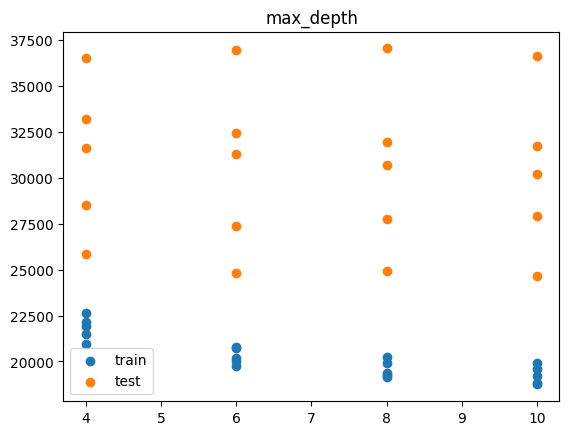

In [53]:
plot_result(result, "max_depth")

In [54]:
# learning_rate = 0.1
xgboost_param_dic = {
    "max_depth": 6,
    "learning_rate": 0.1,
    "colsample_bytree": 0.5,
    "n_estimators": 500,
    "early_stopping_rounds": 5,
    "verbose": False,
    "eval_metric": "rmse",
    "reg_lambda": 8,
    "min_child_weight": 100}
result = hp_tuning('learning_rate', 
                   [0.01,0.05,0.1,0.15,0.2], 
                   xgboost_param_dic, 
                   num_model_var, 
                   target, 
                   "xgboost",
                   df_train_engineered)

training learning_rate = 0.01
[0]	validation_0-rmse:173398
[1]	validation_0-rmse:171988
[2]	validation_0-rmse:170590
[3]	validation_0-rmse:169224
[4]	validation_0-rmse:167862
[5]	validation_0-rmse:166512
[6]	validation_0-rmse:165172
[7]	validation_0-rmse:163858
[8]	validation_0-rmse:162557
[9]	validation_0-rmse:161281
[10]	validation_0-rmse:160025
[11]	validation_0-rmse:158811
[12]	validation_0-rmse:157704
[13]	validation_0-rmse:156461
[14]	validation_0-rmse:155290
[15]	validation_0-rmse:154066
[16]	validation_0-rmse:152861
[17]	validation_0-rmse:151660
[18]	validation_0-rmse:150479
[19]	validation_0-rmse:149314
[20]	validation_0-rmse:148190
[21]	validation_0-rmse:147026
[22]	validation_0-rmse:145877
[23]	validation_0-rmse:144771
[24]	validation_0-rmse:143652
[25]	validation_0-rmse:142548
[26]	validation_0-rmse:141454
[27]	validation_0-rmse:140369
[28]	validation_0-rmse:139289
[29]	validation_0-rmse:138189
[30]	validation_0-rmse:137140
[31]	validation_0-rmse:136159
[32]	validation_0-rm

[262]	validation_0-rmse:48580.6
[263]	validation_0-rmse:48491.7
[264]	validation_0-rmse:48436.8
[265]	validation_0-rmse:48363.7
[266]	validation_0-rmse:48281.5
[267]	validation_0-rmse:48198.1
[268]	validation_0-rmse:48127.3
[269]	validation_0-rmse:48040.6
[270]	validation_0-rmse:47953.5
[271]	validation_0-rmse:47869.8
[272]	validation_0-rmse:47793.1
[273]	validation_0-rmse:47717.6
[274]	validation_0-rmse:47639.6
[275]	validation_0-rmse:47589.9
[276]	validation_0-rmse:47511.6
[277]	validation_0-rmse:47432.4
[278]	validation_0-rmse:47352.5
[279]	validation_0-rmse:47312.9
[280]	validation_0-rmse:47238.3
[281]	validation_0-rmse:47178.8
[282]	validation_0-rmse:47108.4
[283]	validation_0-rmse:47059
[284]	validation_0-rmse:46984.8
[285]	validation_0-rmse:46912.4
[286]	validation_0-rmse:46843.9
[287]	validation_0-rmse:46773.1
[288]	validation_0-rmse:46702.6
[289]	validation_0-rmse:46648.9
[290]	validation_0-rmse:46582.1
[291]	validation_0-rmse:46517.1
[292]	validation_0-rmse:46471.3
[293]	vali

[22]	validation_0-rmse:160895
[23]	validation_0-rmse:159744
[24]	validation_0-rmse:158570
[25]	validation_0-rmse:157394
[26]	validation_0-rmse:156276
[27]	validation_0-rmse:155134
[28]	validation_0-rmse:153986
[29]	validation_0-rmse:152852
[30]	validation_0-rmse:151775
[31]	validation_0-rmse:150768
[32]	validation_0-rmse:149674
[33]	validation_0-rmse:148589
[34]	validation_0-rmse:147620
[35]	validation_0-rmse:146645
[36]	validation_0-rmse:145588
[37]	validation_0-rmse:144629
[38]	validation_0-rmse:143690
[39]	validation_0-rmse:142768
[40]	validation_0-rmse:141766
[41]	validation_0-rmse:140886
[42]	validation_0-rmse:139987
[43]	validation_0-rmse:139079
[44]	validation_0-rmse:138117
[45]	validation_0-rmse:137157
[46]	validation_0-rmse:136210
[47]	validation_0-rmse:135406
[48]	validation_0-rmse:134494
[49]	validation_0-rmse:133611
[50]	validation_0-rmse:132701
[51]	validation_0-rmse:131801
[52]	validation_0-rmse:130971
[53]	validation_0-rmse:130183
[54]	validation_0-rmse:129396
[55]	valid

[285]	validation_0-rmse:62531
[286]	validation_0-rmse:62472.7
[287]	validation_0-rmse:62414.1
[288]	validation_0-rmse:62357.1
[289]	validation_0-rmse:62314.4
[290]	validation_0-rmse:62257.5
[291]	validation_0-rmse:62202.7
[292]	validation_0-rmse:62160.5
[293]	validation_0-rmse:62108
[294]	validation_0-rmse:62052.3
[295]	validation_0-rmse:61997.1
[296]	validation_0-rmse:61933.1
[297]	validation_0-rmse:61881.1
[298]	validation_0-rmse:61828.6
[299]	validation_0-rmse:61776.5
[300]	validation_0-rmse:61726.5
[301]	validation_0-rmse:61676.8
[302]	validation_0-rmse:61636.5
[303]	validation_0-rmse:61594.4
[304]	validation_0-rmse:61546.1
[305]	validation_0-rmse:61500.5
[306]	validation_0-rmse:61453.8
[307]	validation_0-rmse:61405.2
[308]	validation_0-rmse:61355.2
[309]	validation_0-rmse:61308.7
[310]	validation_0-rmse:61272
[311]	validation_0-rmse:61228.4
[312]	validation_0-rmse:61181.1
[313]	validation_0-rmse:61139.7
[314]	validation_0-rmse:61094.9
[315]	validation_0-rmse:61050.6
[316]	validati

[46]	validation_0-rmse:112026
[47]	validation_0-rmse:111094
[48]	validation_0-rmse:110123
[49]	validation_0-rmse:109161
[50]	validation_0-rmse:108200
[51]	validation_0-rmse:107303
[52]	validation_0-rmse:106433
[53]	validation_0-rmse:105544
[54]	validation_0-rmse:104605
[55]	validation_0-rmse:103687
[56]	validation_0-rmse:102773
[57]	validation_0-rmse:101931
[58]	validation_0-rmse:101139
[59]	validation_0-rmse:100293
[60]	validation_0-rmse:99436.5
[61]	validation_0-rmse:98641.6
[62]	validation_0-rmse:97787.1
[63]	validation_0-rmse:96965.5
[64]	validation_0-rmse:96161.8
[65]	validation_0-rmse:95375.2
[66]	validation_0-rmse:94583.6
[67]	validation_0-rmse:93816.4
[68]	validation_0-rmse:93064.4
[69]	validation_0-rmse:92384.4
[70]	validation_0-rmse:91699.4
[71]	validation_0-rmse:90898.7
[72]	validation_0-rmse:90170.1
[73]	validation_0-rmse:89410.4
[74]	validation_0-rmse:88646.2
[75]	validation_0-rmse:87965.5
[76]	validation_0-rmse:87219.9
[77]	validation_0-rmse:86481
[78]	validation_0-rmse:8

[306]	validation_0-rmse:33621.8
[307]	validation_0-rmse:33605.4
[308]	validation_0-rmse:33546.3
[309]	validation_0-rmse:33542.3
[310]	validation_0-rmse:33510.9
[311]	validation_0-rmse:33495.7
[312]	validation_0-rmse:33479.4
[313]	validation_0-rmse:33436.1
[314]	validation_0-rmse:33420.4
[315]	validation_0-rmse:33412.6
[316]	validation_0-rmse:33372.5
[317]	validation_0-rmse:33349
[318]	validation_0-rmse:33341.1
[319]	validation_0-rmse:33312.9
[320]	validation_0-rmse:33303.7
[321]	validation_0-rmse:33297.2
[322]	validation_0-rmse:33269.2
[323]	validation_0-rmse:33253.4
[324]	validation_0-rmse:33223.3
[325]	validation_0-rmse:33225
[326]	validation_0-rmse:33182.9
[327]	validation_0-rmse:33170.9
[328]	validation_0-rmse:33172.2
[329]	validation_0-rmse:33176.2
[330]	validation_0-rmse:33173.3
[331]	validation_0-rmse:33139.6
[332]	validation_0-rmse:33130.8
[333]	validation_0-rmse:33101.6
[334]	validation_0-rmse:33090.4
[335]	validation_0-rmse:33083.2
[336]	validation_0-rmse:33061.1
[337]	valida

[68]	validation_0-rmse:101348
[69]	validation_0-rmse:100640
[70]	validation_0-rmse:99966.8
[71]	validation_0-rmse:99215.3
[72]	validation_0-rmse:98493.5
[73]	validation_0-rmse:97780.1
[74]	validation_0-rmse:97068.5
[75]	validation_0-rmse:96427.1
[76]	validation_0-rmse:95696.9
[77]	validation_0-rmse:95006.9
[78]	validation_0-rmse:94359.4
[79]	validation_0-rmse:93675.4
[80]	validation_0-rmse:93034.2
[81]	validation_0-rmse:92386.4
[82]	validation_0-rmse:91732.6
[83]	validation_0-rmse:91092.7
[84]	validation_0-rmse:90453
[85]	validation_0-rmse:89815.9
[86]	validation_0-rmse:89195.7
[87]	validation_0-rmse:88605.5
[88]	validation_0-rmse:88016.5
[89]	validation_0-rmse:87400.3
[90]	validation_0-rmse:86851.1
[91]	validation_0-rmse:86246.3
[92]	validation_0-rmse:85656.3
[93]	validation_0-rmse:85066.9
[94]	validation_0-rmse:84499.4
[95]	validation_0-rmse:83903
[96]	validation_0-rmse:83349.1
[97]	validation_0-rmse:82792
[98]	validation_0-rmse:82264.8
[99]	validation_0-rmse:81721.8
[100]	validation

[327]	validation_0-rmse:39048.3
[328]	validation_0-rmse:39006.6
[329]	validation_0-rmse:38972.1
[330]	validation_0-rmse:38933.9
[331]	validation_0-rmse:38897.3
[332]	validation_0-rmse:38868
[333]	validation_0-rmse:38830.5
[334]	validation_0-rmse:38796.2
[335]	validation_0-rmse:38764.1
[336]	validation_0-rmse:38718.6
[337]	validation_0-rmse:38687
[338]	validation_0-rmse:38657.3
[339]	validation_0-rmse:38624.9
[340]	validation_0-rmse:38593.4
[341]	validation_0-rmse:38560
[342]	validation_0-rmse:38529.6
[343]	validation_0-rmse:38504.1
[344]	validation_0-rmse:38474.5
[345]	validation_0-rmse:38452.7
[346]	validation_0-rmse:38425.1
[347]	validation_0-rmse:38392.6
[348]	validation_0-rmse:38361.4
[349]	validation_0-rmse:38333.4
[350]	validation_0-rmse:38299.7
[351]	validation_0-rmse:38273.1
[352]	validation_0-rmse:38247.4
[353]	validation_0-rmse:38224.2
[354]	validation_0-rmse:38192.8
[355]	validation_0-rmse:38164.7
[356]	validation_0-rmse:38141.5
[357]	validation_0-rmse:38118.8
[358]	validati

[90]	validation_0-rmse:80348
[91]	validation_0-rmse:79818.6
[92]	validation_0-rmse:79296
[93]	validation_0-rmse:78777.9
[94]	validation_0-rmse:78282.5
[95]	validation_0-rmse:77777.1
[96]	validation_0-rmse:77280.2
[97]	validation_0-rmse:76785.5
[98]	validation_0-rmse:76303.4
[99]	validation_0-rmse:75819.2
[100]	validation_0-rmse:75342.3
[101]	validation_0-rmse:74867.3
[102]	validation_0-rmse:74400
[103]	validation_0-rmse:73948.5
[104]	validation_0-rmse:73492.3
[105]	validation_0-rmse:73033.7
[106]	validation_0-rmse:72584.9
[107]	validation_0-rmse:72161.9
[108]	validation_0-rmse:71721.8
[109]	validation_0-rmse:71291.6
[110]	validation_0-rmse:70863.9
[111]	validation_0-rmse:70460.9
[112]	validation_0-rmse:70070.2
[113]	validation_0-rmse:69666.6
[114]	validation_0-rmse:69293.5
[115]	validation_0-rmse:68905.7
[116]	validation_0-rmse:68514.8
[117]	validation_0-rmse:68148.5
[118]	validation_0-rmse:67769.4
[119]	validation_0-rmse:67391.4
[120]	validation_0-rmse:67032.2
[121]	validation_0-rmse:

[348]	validation_0-rmse:42927
[349]	validation_0-rmse:42915.4
[350]	validation_0-rmse:42909.2
[351]	validation_0-rmse:42897.7
[352]	validation_0-rmse:42879.2
[353]	validation_0-rmse:42873.8
[354]	validation_0-rmse:42854.8
[355]	validation_0-rmse:42838.5
[356]	validation_0-rmse:42832
[357]	validation_0-rmse:42825.4
[358]	validation_0-rmse:42813.2
[359]	validation_0-rmse:42801.2
[360]	validation_0-rmse:42790.3
[361]	validation_0-rmse:42782.9
[362]	validation_0-rmse:42761.3
[363]	validation_0-rmse:42749.7
[364]	validation_0-rmse:42737.8
[365]	validation_0-rmse:42721
[366]	validation_0-rmse:42703.3
[367]	validation_0-rmse:42692.5
[368]	validation_0-rmse:42670.3
[369]	validation_0-rmse:42660.6
[370]	validation_0-rmse:42652.5
[371]	validation_0-rmse:42636.6
[372]	validation_0-rmse:42625.9
[373]	validation_0-rmse:42618.9
[374]	validation_0-rmse:42607.6
[375]	validation_0-rmse:42601.7
[376]	validation_0-rmse:42594.4
[377]	validation_0-rmse:42578.5
[378]	validation_0-rmse:42562.7
[379]	validati

[108]	validation_0-rmse:40830.2
[109]	validation_0-rmse:40829.9
[110]	validation_0-rmse:40726.9
[111]	validation_0-rmse:40680.2
[112]	validation_0-rmse:40623.1
[113]	validation_0-rmse:40558.3
[114]	validation_0-rmse:40521.6
[115]	validation_0-rmse:40487
[116]	validation_0-rmse:40393.5
[117]	validation_0-rmse:40367.7
[118]	validation_0-rmse:40371.9
[119]	validation_0-rmse:40333.6
[120]	validation_0-rmse:40314.3
[121]	validation_0-rmse:40208.3
[122]	validation_0-rmse:40199.7
[123]	validation_0-rmse:40117.9
[124]	validation_0-rmse:40121.1
[125]	validation_0-rmse:40083
[126]	validation_0-rmse:40073.4
[127]	validation_0-rmse:40064
[128]	validation_0-rmse:40034.4
[129]	validation_0-rmse:39954.1
[130]	validation_0-rmse:39880.9
[131]	validation_0-rmse:39939.1
[132]	validation_0-rmse:39863.1
[133]	validation_0-rmse:39907
[134]	validation_0-rmse:39874.4
[135]	validation_0-rmse:39867.7
[136]	validation_0-rmse:39788.9
[137]	validation_0-rmse:39789.3
[138]	validation_0-rmse:39842.8
[139]	validation

[366]	validation_0-rmse:37320.7
[367]	validation_0-rmse:37308.4
[368]	validation_0-rmse:37314.8
[369]	validation_0-rmse:37335.8
[370]	validation_0-rmse:37321.3
[371]	validation_0-rmse:37291.1
[372]	validation_0-rmse:37294.7
[373]	validation_0-rmse:37275.3
[374]	validation_0-rmse:37265.8
[375]	validation_0-rmse:37278.2
[376]	validation_0-rmse:37255
[377]	validation_0-rmse:37235.7
[378]	validation_0-rmse:37231
[379]	validation_0-rmse:37212.2
[380]	validation_0-rmse:37214.2
[381]	validation_0-rmse:37199.2
[382]	validation_0-rmse:37199.7
[383]	validation_0-rmse:37187.2
[384]	validation_0-rmse:37159.1
[385]	validation_0-rmse:37148.5
[386]	validation_0-rmse:37171.9
[387]	validation_0-rmse:37211.4
[388]	validation_0-rmse:37162.8
[389]	validation_0-rmse:37136.8
[390]	validation_0-rmse:37167.8
[391]	validation_0-rmse:37116.3
[392]	validation_0-rmse:37095.2
[393]	validation_0-rmse:37100.7
[394]	validation_0-rmse:37138.2
[395]	validation_0-rmse:37119.3
[396]	validation_0-rmse:37060.5
[397]	valida

[128]	validation_0-rmse:53296.1
[129]	validation_0-rmse:53236.4
[130]	validation_0-rmse:53198.8
[131]	validation_0-rmse:53141.1
[132]	validation_0-rmse:53101.1
[133]	validation_0-rmse:52863.5
[134]	validation_0-rmse:52807.7
[135]	validation_0-rmse:52757.7
[136]	validation_0-rmse:52719.9
[137]	validation_0-rmse:52665.7
[138]	validation_0-rmse:52578.7
[139]	validation_0-rmse:52497.4
[140]	validation_0-rmse:52456.7
[141]	validation_0-rmse:52407.7
[142]	validation_0-rmse:52328.9
[143]	validation_0-rmse:52272
[144]	validation_0-rmse:52137.9
[145]	validation_0-rmse:52080.9
[146]	validation_0-rmse:52036.4
[147]	validation_0-rmse:51986.7
[148]	validation_0-rmse:51939.5
[149]	validation_0-rmse:51858.1
[150]	validation_0-rmse:51823.5
[151]	validation_0-rmse:51789.5
[152]	validation_0-rmse:51738.9
[153]	validation_0-rmse:51696.6
[154]	validation_0-rmse:51487.9
[155]	validation_0-rmse:51442.1
[156]	validation_0-rmse:51403.4
[157]	validation_0-rmse:51350.2
[158]	validation_0-rmse:51267.5
[159]	vali

[386]	validation_0-rmse:42873.6
[387]	validation_0-rmse:42838.2
[388]	validation_0-rmse:42789.6
[389]	validation_0-rmse:42771.5
[390]	validation_0-rmse:42742
[391]	validation_0-rmse:42722.2
[392]	validation_0-rmse:42706.6
[393]	validation_0-rmse:42646.7
[394]	validation_0-rmse:42617
[395]	validation_0-rmse:42597.6
[396]	validation_0-rmse:42547.5
[397]	validation_0-rmse:42519.9
[398]	validation_0-rmse:42498.3
[399]	validation_0-rmse:42471.1
[400]	validation_0-rmse:42446.7
[401]	validation_0-rmse:42422.6
[402]	validation_0-rmse:42407.8
[403]	validation_0-rmse:42367.2
[404]	validation_0-rmse:42329.3
[405]	validation_0-rmse:42304.8
[406]	validation_0-rmse:42289.3
[407]	validation_0-rmse:42266.9
[408]	validation_0-rmse:42227.7
[409]	validation_0-rmse:42211.8
[410]	validation_0-rmse:42172.7
[411]	validation_0-rmse:42134.2
[412]	validation_0-rmse:42105.2
[413]	validation_0-rmse:42086.1
[414]	validation_0-rmse:42064.3
[415]	validation_0-rmse:42014.8
[416]	validation_0-rmse:41984.7
[417]	valida

[148]	validation_0-rmse:33525.6
[149]	validation_0-rmse:33558.5
[150]	validation_0-rmse:33504.7
[151]	validation_0-rmse:33541.2
[152]	validation_0-rmse:33595.6
[153]	validation_0-rmse:33608
[154]	validation_0-rmse:33553.6
[155]	validation_0-rmse:33453.8
[156]	validation_0-rmse:33493.7
[157]	validation_0-rmse:33548.2
[158]	validation_0-rmse:33464.7
[159]	validation_0-rmse:33520.1
[160]	validation_0-rmse:33544.8
[161]	validation_0-rmse:33604.1
[162]	validation_0-rmse:33616.2
[163]	validation_0-rmse:33670.9
[164]	validation_0-rmse:33585.5
[165]	validation_0-rmse:33641.4
[166]	validation_0-rmse:33558.3
[167]	validation_0-rmse:33487.9
[168]	validation_0-rmse:33543.1
[169]	validation_0-rmse:33575
[170]	validation_0-rmse:33626.9
[171]	validation_0-rmse:33584.1
[172]	validation_0-rmse:33608.6
[173]	validation_0-rmse:33569.3
[174]	validation_0-rmse:33580.4
[175]	validation_0-rmse:33499.1
[176]	validation_0-rmse:33493.2
[177]	validation_0-rmse:33536.3
[178]	validation_0-rmse:33590.2
[179]	valida

[406]	validation_0-rmse:32208.1
[407]	validation_0-rmse:32231
[408]	validation_0-rmse:32217.7
[409]	validation_0-rmse:32193.7
[410]	validation_0-rmse:32203.6
[411]	validation_0-rmse:32182.5
[412]	validation_0-rmse:32155.9
[413]	validation_0-rmse:32157.2
[414]	validation_0-rmse:32180.1
[415]	validation_0-rmse:32155.4
[416]	validation_0-rmse:32143.2
[417]	validation_0-rmse:32171.6
[418]	validation_0-rmse:32136.4
[419]	validation_0-rmse:32134.8
[420]	validation_0-rmse:32116.3
[421]	validation_0-rmse:32128.1
[422]	validation_0-rmse:32100.7
[423]	validation_0-rmse:32116.5
[424]	validation_0-rmse:32092.4
[425]	validation_0-rmse:32074.3
[426]	validation_0-rmse:32053.7
[427]	validation_0-rmse:32075.4
[428]	validation_0-rmse:32100.8
[429]	validation_0-rmse:32104.2
[430]	validation_0-rmse:32052.4
[431]	validation_0-rmse:32075.4
[432]	validation_0-rmse:32033.8
[433]	validation_0-rmse:32011.7
[434]	validation_0-rmse:32034.5
[435]	validation_0-rmse:32008.8
[436]	validation_0-rmse:31999.6
[437]	vali

[168]	validation_0-rmse:33041.7
[169]	validation_0-rmse:33024.2
[170]	validation_0-rmse:32976.5
[171]	validation_0-rmse:32924
[172]	validation_0-rmse:32902.9
[173]	validation_0-rmse:32877.7
[174]	validation_0-rmse:32847.7
[175]	validation_0-rmse:32794.3
[176]	validation_0-rmse:32765.3
[177]	validation_0-rmse:32732
[178]	validation_0-rmse:32717.1
[179]	validation_0-rmse:32684.5
[180]	validation_0-rmse:32601.4
[181]	validation_0-rmse:32512.6
[182]	validation_0-rmse:32475.1
[183]	validation_0-rmse:32393.2
[184]	validation_0-rmse:32368.4
[185]	validation_0-rmse:32327.7
[186]	validation_0-rmse:32320.1
[187]	validation_0-rmse:32307.3
[188]	validation_0-rmse:32214.5
[189]	validation_0-rmse:32190
[190]	validation_0-rmse:32165.8
[191]	validation_0-rmse:32114.9
[192]	validation_0-rmse:32090
[193]	validation_0-rmse:32084.2
[194]	validation_0-rmse:32054.9
[195]	validation_0-rmse:32031.8
[196]	validation_0-rmse:32009
[197]	validation_0-rmse:31988.1
[198]	validation_0-rmse:31918.7
[199]	validation_0

[426]	validation_0-rmse:26816.4
[427]	validation_0-rmse:26823.3
[428]	validation_0-rmse:26820.8
[429]	validation_0-rmse:26800.6
[430]	validation_0-rmse:26806.6
[431]	validation_0-rmse:26784.2
[432]	validation_0-rmse:26779.1
[433]	validation_0-rmse:26773.5
[434]	validation_0-rmse:26779
[435]	validation_0-rmse:26753.1
[436]	validation_0-rmse:26737.5
[437]	validation_0-rmse:26696.9
[438]	validation_0-rmse:26679.7
[439]	validation_0-rmse:26673.8
[440]	validation_0-rmse:26667.3
[441]	validation_0-rmse:26646.4
[442]	validation_0-rmse:26631.4
[443]	validation_0-rmse:26620.9
[444]	validation_0-rmse:26625.2
[445]	validation_0-rmse:26638.3
[446]	validation_0-rmse:26640.4
[447]	validation_0-rmse:26627.9
[448]	validation_0-rmse:26628.4
[449]	validation_0-rmse:26613.8
[450]	validation_0-rmse:26615.1
[451]	validation_0-rmse:26597.5
[452]	validation_0-rmse:26608.1
[453]	validation_0-rmse:26580.7
[454]	validation_0-rmse:26571.6
[455]	validation_0-rmse:26551.9
[456]	validation_0-rmse:26530.2
[457]	vali

[187]	validation_0-rmse:40168.9
[188]	validation_0-rmse:40134.2
[189]	validation_0-rmse:40120
[190]	validation_0-rmse:40081.4
[191]	validation_0-rmse:40059.5
[192]	validation_0-rmse:40035.9
[193]	validation_0-rmse:40026.3
[194]	validation_0-rmse:39989
[195]	validation_0-rmse:39989.8
[196]	validation_0-rmse:39904.2
[197]	validation_0-rmse:39899.9
[198]	validation_0-rmse:39871.1
[199]	validation_0-rmse:39865.7
[200]	validation_0-rmse:39846.9
[201]	validation_0-rmse:39816.6
[202]	validation_0-rmse:39815.7
[203]	validation_0-rmse:39823.8
[204]	validation_0-rmse:39793.8
[205]	validation_0-rmse:39752.4
[206]	validation_0-rmse:39748.4
[207]	validation_0-rmse:39726.5
[208]	validation_0-rmse:39719.1
[209]	validation_0-rmse:39634.4
[210]	validation_0-rmse:39599.9
[211]	validation_0-rmse:39611.7
[212]	validation_0-rmse:39537.3
[213]	validation_0-rmse:39537.1
[214]	validation_0-rmse:39528.7
[215]	validation_0-rmse:39492.4
[216]	validation_0-rmse:39481.4
[217]	validation_0-rmse:39489
[218]	validati

[445]	validation_0-rmse:35808.6
[446]	validation_0-rmse:35804.5
[447]	validation_0-rmse:35806.7
[448]	validation_0-rmse:35787.1
[449]	validation_0-rmse:35764.9
[450]	validation_0-rmse:35737.6
[451]	validation_0-rmse:35738.5
[452]	validation_0-rmse:35736.9
[453]	validation_0-rmse:35709.8
[454]	validation_0-rmse:35701.9
[455]	validation_0-rmse:35702.4
[456]	validation_0-rmse:35685.4
[457]	validation_0-rmse:35666.2
[458]	validation_0-rmse:35664.8
[459]	validation_0-rmse:35629.5
[460]	validation_0-rmse:35630.5
[461]	validation_0-rmse:35604.2
[462]	validation_0-rmse:35593.8
[463]	validation_0-rmse:35592.9
[464]	validation_0-rmse:35579.8
[465]	validation_0-rmse:35574.2
[466]	validation_0-rmse:35558.8
[467]	validation_0-rmse:35549.5
[468]	validation_0-rmse:35535.9
[469]	validation_0-rmse:35539.6
[470]	validation_0-rmse:35538.7
[471]	validation_0-rmse:35521.4
[472]	validation_0-rmse:35519.1
[473]	validation_0-rmse:35491.9
[474]	validation_0-rmse:35484.9
[475]	validation_0-rmse:35472.3
[476]	va

[206]	validation_0-rmse:37330.2
[207]	validation_0-rmse:37319.6
[208]	validation_0-rmse:37269.5
[209]	validation_0-rmse:37250.6
[210]	validation_0-rmse:37161.8
[211]	validation_0-rmse:37201.8
[212]	validation_0-rmse:37195.8
[213]	validation_0-rmse:37190.4
[214]	validation_0-rmse:37268.8
[215]	validation_0-rmse:37246.4
[216]	validation_0-rmse:37235
[217]	validation_0-rmse:37202
[218]	validation_0-rmse:37248.3
[219]	validation_0-rmse:37300.8
[220]	validation_0-rmse:37264
[221]	validation_0-rmse:37232.9
[222]	validation_0-rmse:37279.4
[223]	validation_0-rmse:37246.3
[224]	validation_0-rmse:37174.2
[225]	validation_0-rmse:37170.8
[226]	validation_0-rmse:37233
[227]	validation_0-rmse:37157
[228]	validation_0-rmse:37210.4
[229]	validation_0-rmse:37175.9
[230]	validation_0-rmse:37213.6
[231]	validation_0-rmse:37177.1
[232]	validation_0-rmse:37236.6
[233]	validation_0-rmse:37214.6
[234]	validation_0-rmse:37173
[235]	validation_0-rmse:37246.3
[236]	validation_0-rmse:37201.2
[237]	validation_0-r

[464]	validation_0-rmse:36959.1
[465]	validation_0-rmse:36947.2
[466]	validation_0-rmse:36943.2
[467]	validation_0-rmse:36965.2
[468]	validation_0-rmse:36962.7
[469]	validation_0-rmse:36966
[470]	validation_0-rmse:36970
[471]	validation_0-rmse:36952.3
[472]	validation_0-rmse:36971.1
[473]	validation_0-rmse:36968.7
[474]	validation_0-rmse:36993.6
[475]	validation_0-rmse:36984.8
[476]	validation_0-rmse:37006
[477]	validation_0-rmse:36989.3
[478]	validation_0-rmse:37007.7
[479]	validation_0-rmse:37031.1
[480]	validation_0-rmse:37025.1
[481]	validation_0-rmse:37027.1
[482]	validation_0-rmse:37029.5
[483]	validation_0-rmse:37011.4
[484]	validation_0-rmse:36997.3
[485]	validation_0-rmse:36979.4
[486]	validation_0-rmse:36996.5
[487]	validation_0-rmse:36996.2
[488]	validation_0-rmse:37019.1
[489]	validation_0-rmse:36993.5
[490]	validation_0-rmse:36984.2
[491]	validation_0-rmse:36970.1
[492]	validation_0-rmse:36989.3
[493]	validation_0-rmse:36962.2
[494]	validation_0-rmse:36952.9
[495]	validati

[226]	validation_0-rmse:40445.2
[227]	validation_0-rmse:40408.4
[228]	validation_0-rmse:40365.4
[229]	validation_0-rmse:40332.7
[230]	validation_0-rmse:40279.8
[231]	validation_0-rmse:40239.1
[232]	validation_0-rmse:40184.3
[233]	validation_0-rmse:40146.4
[234]	validation_0-rmse:40111.7
[235]	validation_0-rmse:40057.7
[236]	validation_0-rmse:40024.8
[237]	validation_0-rmse:40007.7
[238]	validation_0-rmse:39950.5
[239]	validation_0-rmse:39937.5
[240]	validation_0-rmse:39863.9
[241]	validation_0-rmse:39833.1
[242]	validation_0-rmse:39780.3
[243]	validation_0-rmse:39735.5
[244]	validation_0-rmse:39701.7
[245]	validation_0-rmse:39667.1
[246]	validation_0-rmse:39634.4
[247]	validation_0-rmse:39595.5
[248]	validation_0-rmse:39539.9
[249]	validation_0-rmse:39588.9
[250]	validation_0-rmse:39558.3
[251]	validation_0-rmse:39515.2
[252]	validation_0-rmse:39464.1
[253]	validation_0-rmse:39396.4
[254]	validation_0-rmse:39353.9
[255]	validation_0-rmse:39326.6
[256]	validation_0-rmse:39276
[257]	vali

[484]	validation_0-rmse:32643.8
[485]	validation_0-rmse:32629.7
[486]	validation_0-rmse:32624.5
[487]	validation_0-rmse:32612.3
[488]	validation_0-rmse:32602.8
[489]	validation_0-rmse:32588.8
[490]	validation_0-rmse:32578.5
[491]	validation_0-rmse:32575.4
[492]	validation_0-rmse:32559.8
[493]	validation_0-rmse:32547.7
[494]	validation_0-rmse:32522.7
[495]	validation_0-rmse:32503.2
[496]	validation_0-rmse:32481.9
[497]	validation_0-rmse:32463.6
[498]	validation_0-rmse:32444.7
[499]	validation_0-rmse:32429.2
[0]	validation_0-rmse:154503
[1]	validation_0-rmse:140558
[2]	validation_0-rmse:127649
[3]	validation_0-rmse:116297
[4]	validation_0-rmse:106327
[5]	validation_0-rmse:97180.9
[6]	validation_0-rmse:89313.6
[7]	validation_0-rmse:81914.9
[8]	validation_0-rmse:75541.3
[9]	validation_0-rmse:70072.3
[10]	validation_0-rmse:65591.2
[11]	validation_0-rmse:61583.3
[12]	validation_0-rmse:57504.3
[13]	validation_0-rmse:54063.9
[14]	validation_0-rmse:51208
[15]	validation_0-rmse:48622.4
[16]	vali

[246]	validation_0-rmse:30879.3
[247]	validation_0-rmse:30901.1
[248]	validation_0-rmse:30887
[249]	validation_0-rmse:30870.4
[250]	validation_0-rmse:30877.5
[251]	validation_0-rmse:30893.7
[252]	validation_0-rmse:30849.8
[253]	validation_0-rmse:30728.3
[254]	validation_0-rmse:30729.7
[255]	validation_0-rmse:30684.9
[256]	validation_0-rmse:30663.9
[257]	validation_0-rmse:30707.3
[258]	validation_0-rmse:30733.4
[259]	validation_0-rmse:30680
[260]	validation_0-rmse:30668
[261]	validation_0-rmse:30591.3
[262]	validation_0-rmse:30631.6
[263]	validation_0-rmse:30640.3
[264]	validation_0-rmse:30590.9
[265]	validation_0-rmse:30588.3
[266]	validation_0-rmse:30585.2
[267]	validation_0-rmse:30566.1
[268]	validation_0-rmse:30588.2
[269]	validation_0-rmse:30555.1
[270]	validation_0-rmse:30518.5
[271]	validation_0-rmse:30560.5
[272]	validation_0-rmse:30568.4
[273]	validation_0-rmse:30553
[274]	validation_0-rmse:30539.7
[275]	validation_0-rmse:30539.8
[276]	validation_0-rmse:30529.6
[277]	validation

[4]	validation_0-rmse:114185
[5]	validation_0-rmse:105338
[6]	validation_0-rmse:97493.1
[7]	validation_0-rmse:90294.1
[8]	validation_0-rmse:83980.8
[9]	validation_0-rmse:78485.4
[10]	validation_0-rmse:73618.2
[11]	validation_0-rmse:69583.2
[12]	validation_0-rmse:65859.2
[13]	validation_0-rmse:62325.1
[14]	validation_0-rmse:59373.5
[15]	validation_0-rmse:56484.6
[16]	validation_0-rmse:53924.9
[17]	validation_0-rmse:51769.2
[18]	validation_0-rmse:49887.1
[19]	validation_0-rmse:48199.4
[20]	validation_0-rmse:46773.6
[21]	validation_0-rmse:45447.8
[22]	validation_0-rmse:44339.8
[23]	validation_0-rmse:43375.9
[24]	validation_0-rmse:42600.5
[25]	validation_0-rmse:41838.9
[26]	validation_0-rmse:41185.4
[27]	validation_0-rmse:40669.4
[28]	validation_0-rmse:40221.1
[29]	validation_0-rmse:39814.3
[30]	validation_0-rmse:39525.6
[31]	validation_0-rmse:39148.9
[32]	validation_0-rmse:38829
[33]	validation_0-rmse:38507.4
[34]	validation_0-rmse:38271.3
[35]	validation_0-rmse:38092.9
[36]	validation_0-

[265]	validation_0-rmse:26478.3
[266]	validation_0-rmse:26429.7
[267]	validation_0-rmse:26442.2
[268]	validation_0-rmse:26438
[269]	validation_0-rmse:26404.7
[270]	validation_0-rmse:26354.6
[271]	validation_0-rmse:26358.3
[272]	validation_0-rmse:26355.2
[273]	validation_0-rmse:26350.6
[274]	validation_0-rmse:26352.5
[275]	validation_0-rmse:26326.6
[276]	validation_0-rmse:26334.2
[277]	validation_0-rmse:26326.3
[278]	validation_0-rmse:26320.3
[279]	validation_0-rmse:26293.4
[280]	validation_0-rmse:26258.5
[281]	validation_0-rmse:26276.3
[282]	validation_0-rmse:26244.7
[283]	validation_0-rmse:26213.8
[284]	validation_0-rmse:26235.3
[285]	validation_0-rmse:26232.2
[286]	validation_0-rmse:26190.9
[287]	validation_0-rmse:26182.6
[288]	validation_0-rmse:26193.8
[289]	validation_0-rmse:26165.9
[290]	validation_0-rmse:26115.4
[291]	validation_0-rmse:26095
[292]	validation_0-rmse:26068.1
[293]	validation_0-rmse:26077.6
[294]	validation_0-rmse:26093.6
[295]	validation_0-rmse:26069.6
[296]	valida

[24]	validation_0-rmse:45695.4
[25]	validation_0-rmse:45340.2
[26]	validation_0-rmse:45054.5
[27]	validation_0-rmse:44687.5
[28]	validation_0-rmse:44407.8
[29]	validation_0-rmse:44259.1
[30]	validation_0-rmse:44147.6
[31]	validation_0-rmse:43955.1
[32]	validation_0-rmse:43840.2
[33]	validation_0-rmse:43712.4
[34]	validation_0-rmse:43530.9
[35]	validation_0-rmse:43328.5
[36]	validation_0-rmse:43306.6
[37]	validation_0-rmse:43176.7
[38]	validation_0-rmse:43133.7
[39]	validation_0-rmse:43060.6
[40]	validation_0-rmse:43026.2
[41]	validation_0-rmse:42944.1
[42]	validation_0-rmse:42900.8
[43]	validation_0-rmse:42834.4
[44]	validation_0-rmse:42787.5
[45]	validation_0-rmse:42717.6
[46]	validation_0-rmse:42736.4
[47]	validation_0-rmse:42702.6
[48]	validation_0-rmse:42592.8
[49]	validation_0-rmse:42522.3
[50]	validation_0-rmse:42474.7
[51]	validation_0-rmse:42436.6
[52]	validation_0-rmse:42383.1
[53]	validation_0-rmse:42318.1
[54]	validation_0-rmse:42291.8
[55]	validation_0-rmse:42196.9
[56]	val

[284]	validation_0-rmse:34288.1
[285]	validation_0-rmse:34257.6
[286]	validation_0-rmse:34239
[287]	validation_0-rmse:34222.6
[288]	validation_0-rmse:34208.5
[289]	validation_0-rmse:34187
[290]	validation_0-rmse:34128
[291]	validation_0-rmse:34124
[292]	validation_0-rmse:34133.8
[293]	validation_0-rmse:34104.1
[294]	validation_0-rmse:34080.9
[295]	validation_0-rmse:34071.2
[296]	validation_0-rmse:34040.6
[297]	validation_0-rmse:34012.7
[298]	validation_0-rmse:33952.6
[299]	validation_0-rmse:33944.5
[300]	validation_0-rmse:33941
[301]	validation_0-rmse:33925.6
[302]	validation_0-rmse:33915
[303]	validation_0-rmse:33919.9
[304]	validation_0-rmse:33902.8
[305]	validation_0-rmse:33883.8
[306]	validation_0-rmse:33859.8
[307]	validation_0-rmse:33861.5
[308]	validation_0-rmse:33853.1
[309]	validation_0-rmse:33826.8
[310]	validation_0-rmse:33821.4
[311]	validation_0-rmse:33792.8
[312]	validation_0-rmse:33793.1
[313]	validation_0-rmse:33788.9
[314]	validation_0-rmse:33764.3
[315]	validation_0-r

[43]	validation_0-rmse:40403.9
[44]	validation_0-rmse:40313.6
[45]	validation_0-rmse:40412.3
[46]	validation_0-rmse:40188.7
[47]	validation_0-rmse:40113.9
[48]	validation_0-rmse:39933.5
[49]	validation_0-rmse:39937.9
[50]	validation_0-rmse:40080.2
[51]	validation_0-rmse:39841.6
[52]	validation_0-rmse:39497
[53]	validation_0-rmse:39529.3
[54]	validation_0-rmse:39517.7
[55]	validation_0-rmse:39596
[56]	validation_0-rmse:39385
[57]	validation_0-rmse:39317.7
[58]	validation_0-rmse:39347
[59]	validation_0-rmse:39190.6
[60]	validation_0-rmse:39359.6
[61]	validation_0-rmse:39305.9
[62]	validation_0-rmse:39000.1
[63]	validation_0-rmse:39080.5
[64]	validation_0-rmse:39076.6
[65]	validation_0-rmse:38944.2
[66]	validation_0-rmse:38949.2
[67]	validation_0-rmse:39040.1
[68]	validation_0-rmse:38881.6
[69]	validation_0-rmse:38899.9
[70]	validation_0-rmse:38824.5
[71]	validation_0-rmse:38688.2
[72]	validation_0-rmse:38615.6
[73]	validation_0-rmse:38754.5
[74]	validation_0-rmse:38481.6
[75]	validation_

[304]	validation_0-rmse:36861.4
[305]	validation_0-rmse:36912.2
[306]	validation_0-rmse:36897.8
[307]	validation_0-rmse:36851.1
[308]	validation_0-rmse:36913.8
[309]	validation_0-rmse:36918.6
[310]	validation_0-rmse:36889
[311]	validation_0-rmse:36865.8
[312]	validation_0-rmse:36895.5
[313]	validation_0-rmse:36878.5
[314]	validation_0-rmse:36875
[315]	validation_0-rmse:36864.8
[316]	validation_0-rmse:36902
[317]	validation_0-rmse:36873.8
[318]	validation_0-rmse:36920
[319]	validation_0-rmse:36879.1
[320]	validation_0-rmse:36913.4
[321]	validation_0-rmse:36894.1
[322]	validation_0-rmse:36868.9
[323]	validation_0-rmse:36862.4
[324]	validation_0-rmse:36900.1
[325]	validation_0-rmse:36886.3
[326]	validation_0-rmse:36892.3
[327]	validation_0-rmse:36870.4
[328]	validation_0-rmse:36854.6
[329]	validation_0-rmse:36845.7
[330]	validation_0-rmse:36872.9
[331]	validation_0-rmse:36864.8
[332]	validation_0-rmse:36878.6
[333]	validation_0-rmse:36856.9
[334]	validation_0-rmse:36872.1
[335]	validation

[65]	validation_0-rmse:48142.8
[66]	validation_0-rmse:48018.2
[67]	validation_0-rmse:47874
[68]	validation_0-rmse:47765
[69]	validation_0-rmse:47636.1
[70]	validation_0-rmse:47495.4
[71]	validation_0-rmse:47398.4
[72]	validation_0-rmse:47323.3
[73]	validation_0-rmse:47215.4
[74]	validation_0-rmse:47077.7
[75]	validation_0-rmse:46941.4
[76]	validation_0-rmse:46706.2
[77]	validation_0-rmse:46593.6
[78]	validation_0-rmse:46483.4
[79]	validation_0-rmse:46336
[80]	validation_0-rmse:46257.5
[81]	validation_0-rmse:46079.1
[82]	validation_0-rmse:45982.3
[83]	validation_0-rmse:45875.5
[84]	validation_0-rmse:45790.9
[85]	validation_0-rmse:45704
[86]	validation_0-rmse:45619.7
[87]	validation_0-rmse:45552.1
[88]	validation_0-rmse:45488.8
[89]	validation_0-rmse:45345.6
[90]	validation_0-rmse:45269.7
[91]	validation_0-rmse:45178.1
[92]	validation_0-rmse:45100.9
[93]	validation_0-rmse:44993.1
[94]	validation_0-rmse:44924
[95]	validation_0-rmse:44710
[96]	validation_0-rmse:44560.1
[97]	validation_0-rm

[324]	validation_0-rmse:32777.4
[325]	validation_0-rmse:32762
[326]	validation_0-rmse:32738.9
[327]	validation_0-rmse:32704.7
[328]	validation_0-rmse:32652.9
[329]	validation_0-rmse:32645.6
[330]	validation_0-rmse:32605.1
[331]	validation_0-rmse:32579.9
[332]	validation_0-rmse:32556.4
[333]	validation_0-rmse:32527.8
[334]	validation_0-rmse:32508.9
[335]	validation_0-rmse:32471.1
[336]	validation_0-rmse:32443.3
[337]	validation_0-rmse:32427.3
[338]	validation_0-rmse:32410.1
[339]	validation_0-rmse:32391.6
[340]	validation_0-rmse:32350.5
[341]	validation_0-rmse:32332.1
[342]	validation_0-rmse:32296.8
[343]	validation_0-rmse:32281.6
[344]	validation_0-rmse:32260.4
[345]	validation_0-rmse:32245.8
[346]	validation_0-rmse:32222.1
[347]	validation_0-rmse:32208.2
[348]	validation_0-rmse:32189.9
[349]	validation_0-rmse:32146.3
[350]	validation_0-rmse:32133.5
[351]	validation_0-rmse:32113.4
[352]	validation_0-rmse:32104
[353]	validation_0-rmse:32160
[354]	validation_0-rmse:32065.6
[355]	validati

[86]	validation_0-rmse:33175.4
[87]	validation_0-rmse:33146.8
[88]	validation_0-rmse:32891.1
[89]	validation_0-rmse:32709.6
[90]	validation_0-rmse:32811
[91]	validation_0-rmse:32618
[92]	validation_0-rmse:32713.1
[93]	validation_0-rmse:32700.5
[94]	validation_0-rmse:32534.8
[95]	validation_0-rmse:32558.3
[96]	validation_0-rmse:32548.3
[97]	validation_0-rmse:32554.9
[98]	validation_0-rmse:32394.5
[99]	validation_0-rmse:32342.2
[100]	validation_0-rmse:32433.4
[101]	validation_0-rmse:32383.7
[102]	validation_0-rmse:32419.3
[103]	validation_0-rmse:32449.1
[104]	validation_0-rmse:32374.2
[105]	validation_0-rmse:32422.8
[106]	validation_0-rmse:32320.8
[107]	validation_0-rmse:32428.4
[108]	validation_0-rmse:32531.8
[109]	validation_0-rmse:32343.8
[110]	validation_0-rmse:32431.1
[111]	validation_0-rmse:32278.3
[112]	validation_0-rmse:32164.9
[113]	validation_0-rmse:31999.3
[114]	validation_0-rmse:32008.2
[115]	validation_0-rmse:31819
[116]	validation_0-rmse:31813.7
[117]	validation_0-rmse:3179

[344]	validation_0-rmse:27131.7
[345]	validation_0-rmse:27104.4
[346]	validation_0-rmse:27091.7
[347]	validation_0-rmse:27137
[348]	validation_0-rmse:27157.6
[349]	validation_0-rmse:27143.8
[350]	validation_0-rmse:27102.8
[351]	validation_0-rmse:27078.3
[352]	validation_0-rmse:27060
[353]	validation_0-rmse:27049.4
[354]	validation_0-rmse:26996.4
[355]	validation_0-rmse:27038.1
[356]	validation_0-rmse:26991.5
[357]	validation_0-rmse:26909.5
[358]	validation_0-rmse:26915.6
[359]	validation_0-rmse:26919.5
[360]	validation_0-rmse:26901.1
[361]	validation_0-rmse:26910.8
[362]	validation_0-rmse:26913.3
[363]	validation_0-rmse:26914.1
[364]	validation_0-rmse:26928.7
[365]	validation_0-rmse:26937.2
[366]	validation_0-rmse:26896.9
[367]	validation_0-rmse:26930.4
[368]	validation_0-rmse:26939.4
[369]	validation_0-rmse:26932.7
[370]	validation_0-rmse:26928.4
[371]	validation_0-rmse:26886.7
[372]	validation_0-rmse:26893
[373]	validation_0-rmse:26912.5
[374]	validation_0-rmse:26907.5
[375]	validati

[106]	validation_0-rmse:29135.9
[107]	validation_0-rmse:29074.6
[108]	validation_0-rmse:29067.2
[109]	validation_0-rmse:28926.6
[110]	validation_0-rmse:28929.8
[111]	validation_0-rmse:28819.7
[112]	validation_0-rmse:28713.7
[113]	validation_0-rmse:28702.7
[114]	validation_0-rmse:28638.2
[115]	validation_0-rmse:28660.5
[116]	validation_0-rmse:28586.3
[117]	validation_0-rmse:28584.1
[118]	validation_0-rmse:28503.8
[119]	validation_0-rmse:28417.6
[120]	validation_0-rmse:28409.9
[121]	validation_0-rmse:28338.1
[122]	validation_0-rmse:28353.3
[123]	validation_0-rmse:28237.9
[124]	validation_0-rmse:28152.7
[125]	validation_0-rmse:28126.9
[126]	validation_0-rmse:28048
[127]	validation_0-rmse:28070.1
[128]	validation_0-rmse:28055.5
[129]	validation_0-rmse:27993.6
[130]	validation_0-rmse:27950.4
[131]	validation_0-rmse:27942.2
[132]	validation_0-rmse:27860.9
[133]	validation_0-rmse:27893.1
[134]	validation_0-rmse:27827
[135]	validation_0-rmse:27797.8
[136]	validation_0-rmse:27801.1
[137]	valida

[364]	validation_0-rmse:24694
[365]	validation_0-rmse:24728.6
[366]	validation_0-rmse:24731.6
[367]	validation_0-rmse:24743
[368]	validation_0-rmse:24751.2
[369]	validation_0-rmse:24747.4
[370]	validation_0-rmse:24754.7
[371]	validation_0-rmse:24785.9
[372]	validation_0-rmse:24776
[373]	validation_0-rmse:24774.5
[374]	validation_0-rmse:24807.1
[375]	validation_0-rmse:24803.6
[376]	validation_0-rmse:24811.2
[377]	validation_0-rmse:24850.5
[378]	validation_0-rmse:24853.3
[379]	validation_0-rmse:24830.3
[380]	validation_0-rmse:24825.5
[381]	validation_0-rmse:24812.1
[382]	validation_0-rmse:24800.3
[383]	validation_0-rmse:24771.3
[384]	validation_0-rmse:24735.7
[385]	validation_0-rmse:24736.1
[386]	validation_0-rmse:24737.1
[387]	validation_0-rmse:24734.6
[388]	validation_0-rmse:24720.1
[389]	validation_0-rmse:24725.4
[390]	validation_0-rmse:24726.8
[391]	validation_0-rmse:24752.1
[392]	validation_0-rmse:24774.1
[393]	validation_0-rmse:24757.8
[394]	validation_0-rmse:24731.5
[395]	validati

[126]	validation_0-rmse:36482.4
[127]	validation_0-rmse:36414.9
[128]	validation_0-rmse:36404.3
[129]	validation_0-rmse:36347.2
[130]	validation_0-rmse:36340.2
[131]	validation_0-rmse:36323.7
[132]	validation_0-rmse:36303
[133]	validation_0-rmse:36105.8
[134]	validation_0-rmse:36095.5
[135]	validation_0-rmse:36039
[136]	validation_0-rmse:35978.2
[137]	validation_0-rmse:35914.3
[138]	validation_0-rmse:35892.4
[139]	validation_0-rmse:35907.1
[140]	validation_0-rmse:35828.4
[141]	validation_0-rmse:35822.3
[142]	validation_0-rmse:35749.3
[143]	validation_0-rmse:35756.4
[144]	validation_0-rmse:35712.7
[145]	validation_0-rmse:35700.8
[146]	validation_0-rmse:35634.6
[147]	validation_0-rmse:35572.2
[148]	validation_0-rmse:35571.2
[149]	validation_0-rmse:35528
[150]	validation_0-rmse:35508.5
[151]	validation_0-rmse:35496.1
[152]	validation_0-rmse:35443.3
[153]	validation_0-rmse:35381.6
[154]	validation_0-rmse:35377
[155]	validation_0-rmse:35222.3
[156]	validation_0-rmse:35159.2
[157]	validation

[384]	validation_0-rmse:30261.1
[385]	validation_0-rmse:30259.7
[386]	validation_0-rmse:30258.9
[387]	validation_0-rmse:30245.4
[388]	validation_0-rmse:30239.3
[389]	validation_0-rmse:30232
[390]	validation_0-rmse:30229.3
[391]	validation_0-rmse:30211.7
[392]	validation_0-rmse:30224.3
[393]	validation_0-rmse:30199.5
[394]	validation_0-rmse:30200.2
[395]	validation_0-rmse:30188.3
[396]	validation_0-rmse:30180.7
[397]	validation_0-rmse:30180.1
[398]	validation_0-rmse:30153.4
[399]	validation_0-rmse:30118.5
[400]	validation_0-rmse:30111.8
[401]	validation_0-rmse:30096.7
[402]	validation_0-rmse:30107.4
[403]	validation_0-rmse:30070.8
[404]	validation_0-rmse:30074.7
[405]	validation_0-rmse:30051.6
[406]	validation_0-rmse:30026.9
[407]	validation_0-rmse:30021
[408]	validation_0-rmse:30025.1
[409]	validation_0-rmse:30022.6
[410]	validation_0-rmse:30022.4
[411]	validation_0-rmse:29998.3
[412]	validation_0-rmse:29974.1
[413]	validation_0-rmse:29926.1
[414]	validation_0-rmse:29908.8
[415]	valida

[145]	validation_0-rmse:37409.7
[146]	validation_0-rmse:37431.2
[147]	validation_0-rmse:37456
[148]	validation_0-rmse:37514.1
[149]	validation_0-rmse:37489
[150]	validation_0-rmse:37552.5
[151]	validation_0-rmse:37611.3
[152]	validation_0-rmse:37509.7
[153]	validation_0-rmse:37532.6
[154]	validation_0-rmse:37578
[155]	validation_0-rmse:37542
[156]	validation_0-rmse:37589.2
[157]	validation_0-rmse:37553.2
[158]	validation_0-rmse:37426
[159]	validation_0-rmse:37403.8
[160]	validation_0-rmse:37401.5
[161]	validation_0-rmse:37401.9
[162]	validation_0-rmse:37373.4
[163]	validation_0-rmse:37386.3
[164]	validation_0-rmse:37400.5
[165]	validation_0-rmse:37379.2
[166]	validation_0-rmse:37363
[167]	validation_0-rmse:37350.9
[168]	validation_0-rmse:37417.1
[169]	validation_0-rmse:37361.3
[170]	validation_0-rmse:37373
[171]	validation_0-rmse:37363.2
[172]	validation_0-rmse:37422.4
[173]	validation_0-rmse:37498.3
[174]	validation_0-rmse:37464.1
[175]	validation_0-rmse:37501.9
[176]	validation_0-rms

[403]	validation_0-rmse:37103.5
[404]	validation_0-rmse:37113.3
[405]	validation_0-rmse:37090.8
[406]	validation_0-rmse:37103.9
[407]	validation_0-rmse:37122.5
[408]	validation_0-rmse:37180.5
[409]	validation_0-rmse:37166.2
[410]	validation_0-rmse:37172.6
[411]	validation_0-rmse:37211
[412]	validation_0-rmse:37196.6
[413]	validation_0-rmse:37209.1
[414]	validation_0-rmse:37214.7
[415]	validation_0-rmse:37201.9
[416]	validation_0-rmse:37208
[417]	validation_0-rmse:37175.9
[418]	validation_0-rmse:37167.1
[419]	validation_0-rmse:37183
[420]	validation_0-rmse:37163.7
[421]	validation_0-rmse:37137.5
[422]	validation_0-rmse:37131.1
[423]	validation_0-rmse:37150.9
[424]	validation_0-rmse:37167.9
[425]	validation_0-rmse:37161
[426]	validation_0-rmse:37150.5
[427]	validation_0-rmse:37156.3
[428]	validation_0-rmse:37174.9
[429]	validation_0-rmse:37198.6
[430]	validation_0-rmse:37222.6
[431]	validation_0-rmse:37207.7
[432]	validation_0-rmse:37215.9
[433]	validation_0-rmse:37215.4
[434]	validation

[165]	validation_0-rmse:35272.8
[166]	validation_0-rmse:35224.2
[167]	validation_0-rmse:35179.8
[168]	validation_0-rmse:35239.4
[169]	validation_0-rmse:35149.6
[170]	validation_0-rmse:35126.1
[171]	validation_0-rmse:35080.7
[172]	validation_0-rmse:35011.6
[173]	validation_0-rmse:34932
[174]	validation_0-rmse:34878
[175]	validation_0-rmse:34803.4
[176]	validation_0-rmse:34747.4
[177]	validation_0-rmse:34707.4
[178]	validation_0-rmse:34657.1
[179]	validation_0-rmse:34577.8
[180]	validation_0-rmse:34525.5
[181]	validation_0-rmse:34494.6
[182]	validation_0-rmse:34428.9
[183]	validation_0-rmse:34384.2
[184]	validation_0-rmse:34333.2
[185]	validation_0-rmse:34289.2
[186]	validation_0-rmse:34207.6
[187]	validation_0-rmse:34174.8
[188]	validation_0-rmse:34093.3
[189]	validation_0-rmse:34019.9
[190]	validation_0-rmse:33964.9
[191]	validation_0-rmse:33921.6
[192]	validation_0-rmse:33805.9
[193]	validation_0-rmse:33751.4
[194]	validation_0-rmse:33694.4
[195]	validation_0-rmse:33603.8
[196]	valida

[423]	validation_0-rmse:28226.3
[424]	validation_0-rmse:28241
[425]	validation_0-rmse:28266.8
[426]	validation_0-rmse:28262.1
[427]	validation_0-rmse:28260.1
[428]	validation_0-rmse:28260.7
[429]	validation_0-rmse:28257.8
[430]	validation_0-rmse:28256.4
[431]	validation_0-rmse:28244.4
[432]	validation_0-rmse:28234.5
[433]	validation_0-rmse:28233.7
[434]	validation_0-rmse:28226
[435]	validation_0-rmse:28202.4
[436]	validation_0-rmse:28233.8
[437]	validation_0-rmse:28227.1
[438]	validation_0-rmse:28219.3
[439]	validation_0-rmse:28221.5
[440]	validation_0-rmse:28222.2
[441]	validation_0-rmse:28214.9
[442]	validation_0-rmse:28206.7
[443]	validation_0-rmse:28191
[444]	validation_0-rmse:28180.6
[445]	validation_0-rmse:28175.4
[446]	validation_0-rmse:28142.5
[447]	validation_0-rmse:28137.4
[448]	validation_0-rmse:28116.5
[449]	validation_0-rmse:28107.5
[450]	validation_0-rmse:28095.7
[451]	validation_0-rmse:28088.1
[452]	validation_0-rmse:28106.3
[453]	validation_0-rmse:28094.3
[454]	validati

[185]	validation_0-rmse:30543.7
[186]	validation_0-rmse:30372.8
[187]	validation_0-rmse:30373
[188]	validation_0-rmse:30285.2
[189]	validation_0-rmse:30242.3
[190]	validation_0-rmse:30295.1
[191]	validation_0-rmse:30248.3
[192]	validation_0-rmse:30265.3
[193]	validation_0-rmse:30269.1
[194]	validation_0-rmse:30278.7
[195]	validation_0-rmse:30244.1
[196]	validation_0-rmse:30274.4
[197]	validation_0-rmse:30214.8
[198]	validation_0-rmse:30267.8
[199]	validation_0-rmse:30188.5
[200]	validation_0-rmse:30142.5
[201]	validation_0-rmse:30135.8
[202]	validation_0-rmse:30099.7
[203]	validation_0-rmse:30100.6
[204]	validation_0-rmse:30114.4
[205]	validation_0-rmse:30168.3
[206]	validation_0-rmse:30187.1
[207]	validation_0-rmse:30112.1
[208]	validation_0-rmse:30100
[209]	validation_0-rmse:30141.3
[210]	validation_0-rmse:30168.1
[211]	validation_0-rmse:30092.2
[212]	validation_0-rmse:30010.9
[213]	validation_0-rmse:30030.7
[214]	validation_0-rmse:30060.3
[215]	validation_0-rmse:30028.5
[216]	valida

[443]	validation_0-rmse:27613.4
[444]	validation_0-rmse:27590.4
[445]	validation_0-rmse:27539.7
[446]	validation_0-rmse:27561.6
[447]	validation_0-rmse:27565.5
[448]	validation_0-rmse:27598.3
[449]	validation_0-rmse:27589.7
[450]	validation_0-rmse:27570.4
[451]	validation_0-rmse:27555.5
[452]	validation_0-rmse:27553.5
[453]	validation_0-rmse:27567
[454]	validation_0-rmse:27565.7
[455]	validation_0-rmse:27554.5
[456]	validation_0-rmse:27560.8
[457]	validation_0-rmse:27573.2
[458]	validation_0-rmse:27572.5
[459]	validation_0-rmse:27532.2
[460]	validation_0-rmse:27552.7
[461]	validation_0-rmse:27551.4
[462]	validation_0-rmse:27517.3
[463]	validation_0-rmse:27532.8
[464]	validation_0-rmse:27534
[465]	validation_0-rmse:27556.6
[466]	validation_0-rmse:27546.6
[467]	validation_0-rmse:27545.5
[468]	validation_0-rmse:27562.7
[469]	validation_0-rmse:27559.8
[470]	validation_0-rmse:27546.5
[471]	validation_0-rmse:27547.1
[472]	validation_0-rmse:27525.2
[473]	validation_0-rmse:27513.2
[474]	valida

[205]	validation_0-rmse:25607.4
[206]	validation_0-rmse:25638.9
[207]	validation_0-rmse:25584.3
[208]	validation_0-rmse:25560.7
[209]	validation_0-rmse:25559.3
[210]	validation_0-rmse:25600.9
[211]	validation_0-rmse:25554.1
[212]	validation_0-rmse:25500.5
[213]	validation_0-rmse:25476.3
[214]	validation_0-rmse:25424
[215]	validation_0-rmse:25412.2
[216]	validation_0-rmse:25405.9
[217]	validation_0-rmse:25421.6
[218]	validation_0-rmse:25383.1
[219]	validation_0-rmse:25377.2
[220]	validation_0-rmse:25331.4
[221]	validation_0-rmse:25322.3
[222]	validation_0-rmse:25348.8
[223]	validation_0-rmse:25315.5
[224]	validation_0-rmse:25328.7
[225]	validation_0-rmse:25374.4
[226]	validation_0-rmse:25321.4
[227]	validation_0-rmse:25298.8
[228]	validation_0-rmse:25302.1
[229]	validation_0-rmse:25307.5
[230]	validation_0-rmse:25281.6
[231]	validation_0-rmse:25280.2
[232]	validation_0-rmse:25238
[233]	validation_0-rmse:25254.7
[234]	validation_0-rmse:25279.9
[235]	validation_0-rmse:25241.8
[236]	valida

[463]	validation_0-rmse:24679
[464]	validation_0-rmse:24727.3
[465]	validation_0-rmse:24736.7
[466]	validation_0-rmse:24691.3
[467]	validation_0-rmse:24662
[468]	validation_0-rmse:24659.3
[469]	validation_0-rmse:24656
[470]	validation_0-rmse:24637.5
[471]	validation_0-rmse:24622.1
[472]	validation_0-rmse:24610.9
[473]	validation_0-rmse:24607.7
[474]	validation_0-rmse:24619.7
[475]	validation_0-rmse:24648.6
[476]	validation_0-rmse:24647.7
[477]	validation_0-rmse:24660.7
[478]	validation_0-rmse:24665.7
[479]	validation_0-rmse:24671.7
[480]	validation_0-rmse:24670.7
[481]	validation_0-rmse:24664.4
[482]	validation_0-rmse:24647.6
[483]	validation_0-rmse:24655.8
[484]	validation_0-rmse:24651.6
[485]	validation_0-rmse:24683.9
[486]	validation_0-rmse:24671.3
[487]	validation_0-rmse:24656.6
[488]	validation_0-rmse:24665.6
[489]	validation_0-rmse:24640.9
[490]	validation_0-rmse:24647.5
[491]	validation_0-rmse:24639
[492]	validation_0-rmse:24635.9
[493]	validation_0-rmse:24633.8
[494]	validation

[224]	validation_0-rmse:31186
[225]	validation_0-rmse:31194.2
[226]	validation_0-rmse:31176.8
[227]	validation_0-rmse:31163.9
[228]	validation_0-rmse:31156
[229]	validation_0-rmse:31153.8
[230]	validation_0-rmse:31131.3
[231]	validation_0-rmse:31115
[232]	validation_0-rmse:31110.4
[233]	validation_0-rmse:31097.6
[234]	validation_0-rmse:31092.8
[235]	validation_0-rmse:31074.7
[236]	validation_0-rmse:31041
[237]	validation_0-rmse:31020.2
[238]	validation_0-rmse:31003.8
[239]	validation_0-rmse:30999.1
[240]	validation_0-rmse:30981.5
[241]	validation_0-rmse:30968.2
[242]	validation_0-rmse:30961.4
[243]	validation_0-rmse:30947.9
[244]	validation_0-rmse:30958
[245]	validation_0-rmse:30945
[246]	validation_0-rmse:30956.6
[247]	validation_0-rmse:30932.4
[248]	validation_0-rmse:30888.7
[249]	validation_0-rmse:30819.9
[250]	validation_0-rmse:30805.8
[251]	validation_0-rmse:30771.1
[252]	validation_0-rmse:30773.7
[253]	validation_0-rmse:30755.1
[254]	validation_0-rmse:30779.9
[255]	validation_0-r

[482]	validation_0-rmse:27553.6
[483]	validation_0-rmse:27545.2
[484]	validation_0-rmse:27536.5
[485]	validation_0-rmse:27517.8
[486]	validation_0-rmse:27513.1
[487]	validation_0-rmse:27511.9
[488]	validation_0-rmse:27506.4
[489]	validation_0-rmse:27489.9
[490]	validation_0-rmse:27478.9
[491]	validation_0-rmse:27470.3
[492]	validation_0-rmse:27471.2
[493]	validation_0-rmse:27468.7
[494]	validation_0-rmse:27466.4
[495]	validation_0-rmse:27449.1
[496]	validation_0-rmse:27444.9
[497]	validation_0-rmse:27442.6
[498]	validation_0-rmse:27427
[499]	validation_0-rmse:27415.5


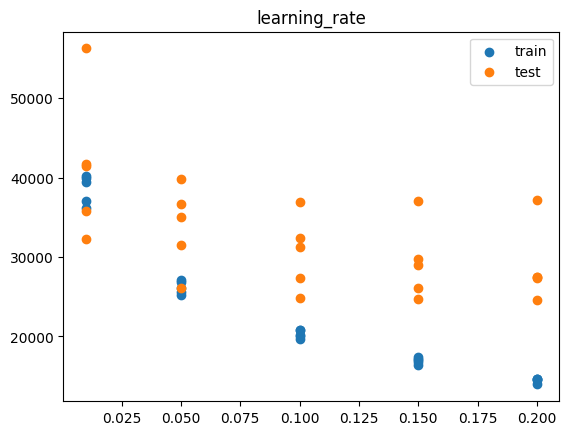

In [55]:
plot_result(result, "learning_rate")

from manual search, optimal parameters:

-    "max_depth": 6,
-    "learning_rate": 0.1,
-    "colsample_bytree": 0.5,
-    "n_estimators": 500,
-    "early_stopping_rounds": 5,
-    "reg_lambda": 8,
-    "min_child_weight": 100

In [68]:
# grid search ard the optimal parameters
from sklearn.model_selection import GridSearchCV

param_search = {
    'max_depth':[5,6,7],
    'min_child_weight':[80,100,120],
    'learning_rate':[0.09,0.1,0.11],
    'colsample_bytree':[0.5,0.6,0.7]
}
gsearch = GridSearchCV(estimator = XGBRegressor(n_estimators=500,
                                                early_stopping_rounds=10,
                                                eval_metric= 'rmse'), 
                       param_grid = param_search, 
                       scoring='neg_root_mean_squared_error',
                       n_jobs=4,
                       cv=5,
                       verbose=10)
gsearch.fit(df_train_engineered[num_model_var],df_train_engineered[target])
print (gsearch.grid_scores_, gsearch1.best_params_, gsearch1.best_score_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   58.9s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  2.8min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  4.4min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  5.5min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  6.6min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  7.8min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  9.6min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed: 11.1min
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed: 12.4min
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed: 13.9min
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed: 16.1min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 17.9min
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed: 20.4min
[Parallel(

AttributeError: 'GridSearchCV' object has no attribute 'grid_scores_'

In [72]:
print (gsearch.best_params_, gsearch.best_score_)

{'colsample_bytree': 0.7, 'learning_rate': 0.9, 'max_depth': 5, 'min_child_weight': 80} -31859.53799879962


In [73]:
xgboost_param_dic = {
    "max_depth": 5,
    "learning_rate": 0.1,
    "colsample_bytree": 0.7,
    "n_estimators": 500,
    "early_stopping_rounds": 5,
    "verbose": False,
    "eval_metric": "rmse",
    "reg_lambda": 8,
    "min_child_weight": 80,
    "early_stopping_rounds":10}

In [80]:
df_selected_xgboost = df_train_engineered[num_model_var+[target]]
kf = KFold(n_splits = 5, shuffle = True, random_state = 2)
kf_index = kf.split(df_selected_xgboost)
xgboost_final_result = kf_predict(kf_index, 
                                   xgboost_param_dic, 
                                   num_model_var, 
                                   target, 
                                   "xgboost", 
                                   df_selected_xgboost)

[0]	validation_0-rmse:58584.7
[1]	validation_0-rmse:49341.2
[2]	validation_0-rmse:45545.6
[3]	validation_0-rmse:44829.1
[4]	validation_0-rmse:42323
[5]	validation_0-rmse:40833.6
[6]	validation_0-rmse:41992.6
[7]	validation_0-rmse:40561.9
[8]	validation_0-rmse:39859.9
[9]	validation_0-rmse:40103.8
[10]	validation_0-rmse:39296.9
[11]	validation_0-rmse:39721
[12]	validation_0-rmse:39540.9
[13]	validation_0-rmse:40467.2
[14]	validation_0-rmse:40139
[15]	validation_0-rmse:39830
[16]	validation_0-rmse:39269.3
[17]	validation_0-rmse:39736.6
[18]	validation_0-rmse:39571
[19]	validation_0-rmse:39378.5
[20]	validation_0-rmse:39105.9
[21]	validation_0-rmse:39239.8
[22]	validation_0-rmse:39505.5
[23]	validation_0-rmse:39165.5
[24]	validation_0-rmse:39109.5
[25]	validation_0-rmse:38935.9
[26]	validation_0-rmse:39398.4
[27]	validation_0-rmse:39300
[28]	validation_0-rmse:38877.3
[29]	validation_0-rmse:38950.2
[30]	validation_0-rmse:38856.6
[31]	validation_0-rmse:38931.3
[32]	validation_0-rmse:39092.9

[261]	validation_0-rmse:39038.9
[262]	validation_0-rmse:39033.8
[263]	validation_0-rmse:39022.3
[264]	validation_0-rmse:39036.4
[265]	validation_0-rmse:39062.3
[266]	validation_0-rmse:39071.8
[267]	validation_0-rmse:39110.8
[268]	validation_0-rmse:39127.9
[269]	validation_0-rmse:39125.6
[270]	validation_0-rmse:39099.1
[271]	validation_0-rmse:39102.5
[272]	validation_0-rmse:39053.9
[273]	validation_0-rmse:39035.7
[274]	validation_0-rmse:39019.1
[275]	validation_0-rmse:39013
[276]	validation_0-rmse:39001.5
[277]	validation_0-rmse:38982.9
[278]	validation_0-rmse:38983
[279]	validation_0-rmse:38999.7
[280]	validation_0-rmse:39012.8
[281]	validation_0-rmse:39013.8
[282]	validation_0-rmse:39011.2
[283]	validation_0-rmse:39012.7
[284]	validation_0-rmse:39022.1
[285]	validation_0-rmse:39021.9
[286]	validation_0-rmse:39013.8
[287]	validation_0-rmse:38983.9
[288]	validation_0-rmse:38997.6
[289]	validation_0-rmse:39004.1
[290]	validation_0-rmse:38980.9
[291]	validation_0-rmse:38969.9
[292]	valida

[20]	validation_0-rmse:37172.5
[21]	validation_0-rmse:36648.9
[22]	validation_0-rmse:36418.8
[23]	validation_0-rmse:36414.6
[24]	validation_0-rmse:36197.6
[25]	validation_0-rmse:35887.6
[26]	validation_0-rmse:35413.1
[27]	validation_0-rmse:35700.2
[28]	validation_0-rmse:36015.7
[29]	validation_0-rmse:35894
[30]	validation_0-rmse:35535.1
[31]	validation_0-rmse:35081.5
[32]	validation_0-rmse:35159.3
[33]	validation_0-rmse:35362.5
[34]	validation_0-rmse:35251.1
[35]	validation_0-rmse:35248.6
[36]	validation_0-rmse:35176.9
[37]	validation_0-rmse:34986.3
[38]	validation_0-rmse:34635.7
[39]	validation_0-rmse:34898.5
[40]	validation_0-rmse:35135.3
[41]	validation_0-rmse:34738.9
[42]	validation_0-rmse:34525
[43]	validation_0-rmse:34893.6
[44]	validation_0-rmse:34735.5
[45]	validation_0-rmse:34782.1
[46]	validation_0-rmse:34434.1
[47]	validation_0-rmse:34423.1
[48]	validation_0-rmse:34259.5
[49]	validation_0-rmse:33863.4
[50]	validation_0-rmse:33950.9
[51]	validation_0-rmse:33529.9
[52]	validat

[281]	validation_0-rmse:28547.3
[282]	validation_0-rmse:28576.5
[283]	validation_0-rmse:28595.9
[284]	validation_0-rmse:28601.8
[285]	validation_0-rmse:28596.9
[286]	validation_0-rmse:28564.5
[287]	validation_0-rmse:28561
[288]	validation_0-rmse:28578.1
[289]	validation_0-rmse:28588.8
[290]	validation_0-rmse:28571
[291]	validation_0-rmse:28575.1
[292]	validation_0-rmse:28539.3
[293]	validation_0-rmse:28533.2
[294]	validation_0-rmse:28531.4
[295]	validation_0-rmse:28496.5
[296]	validation_0-rmse:28483.2
[297]	validation_0-rmse:28489.9
[298]	validation_0-rmse:28486.6
[299]	validation_0-rmse:28468.8
[300]	validation_0-rmse:28488.5
[301]	validation_0-rmse:28455.8
[302]	validation_0-rmse:28450.8
[303]	validation_0-rmse:28474.5
[304]	validation_0-rmse:28430.4
[305]	validation_0-rmse:28430
[306]	validation_0-rmse:28440.8
[307]	validation_0-rmse:28454.6
[308]	validation_0-rmse:28447.3
[309]	validation_0-rmse:28440.6
[310]	validation_0-rmse:28453.4
[311]	validation_0-rmse:28446.2
[312]	validati

[41]	validation_0-rmse:36445.6
[42]	validation_0-rmse:36372.2
[43]	validation_0-rmse:36633.7
[44]	validation_0-rmse:36403.8
[45]	validation_0-rmse:36023.2
[46]	validation_0-rmse:35914.3
[47]	validation_0-rmse:35733.5
[48]	validation_0-rmse:35973.3
[49]	validation_0-rmse:35864.9
[50]	validation_0-rmse:35714.6
[51]	validation_0-rmse:35302.9
[52]	validation_0-rmse:35355.9
[53]	validation_0-rmse:35457.8
[54]	validation_0-rmse:35487.5
[55]	validation_0-rmse:35316.3
[56]	validation_0-rmse:35431.5
[57]	validation_0-rmse:35363.1
[58]	validation_0-rmse:35356.3
[59]	validation_0-rmse:35446
[60]	validation_0-rmse:35386.7
[61]	validation_0-rmse:35349.5
[62]	validation_0-rmse:35239.9
[63]	validation_0-rmse:35158.2
[64]	validation_0-rmse:35011.9
[65]	validation_0-rmse:35122.1
[66]	validation_0-rmse:35146.7
[67]	validation_0-rmse:35341.5
[68]	validation_0-rmse:35375.1
[69]	validation_0-rmse:35333.5
[70]	validation_0-rmse:35318.5
[71]	validation_0-rmse:35442
[72]	validation_0-rmse:35339
[73]	validatio

[301]	validation_0-rmse:34948.3
[302]	validation_0-rmse:34923
[303]	validation_0-rmse:34942.5
[304]	validation_0-rmse:34967.1
[305]	validation_0-rmse:34966.8
[306]	validation_0-rmse:34953
[307]	validation_0-rmse:34943.4
[308]	validation_0-rmse:34936.4
[309]	validation_0-rmse:34943.8
[310]	validation_0-rmse:34934.2
[311]	validation_0-rmse:34926.2
[312]	validation_0-rmse:34929.7
[313]	validation_0-rmse:34902.8
[314]	validation_0-rmse:34914.8
[315]	validation_0-rmse:34931.2
[316]	validation_0-rmse:34933.2
[317]	validation_0-rmse:34925.7
[318]	validation_0-rmse:34934.6
[319]	validation_0-rmse:34938.9
[320]	validation_0-rmse:34938.7
[321]	validation_0-rmse:34938.9
[322]	validation_0-rmse:34970.7
[323]	validation_0-rmse:34991.6
[324]	validation_0-rmse:35000.2
[325]	validation_0-rmse:34996
[326]	validation_0-rmse:34987.9
[327]	validation_0-rmse:34952.5
[328]	validation_0-rmse:34956.2
[329]	validation_0-rmse:34951.2
[330]	validation_0-rmse:34961.3
[331]	validation_0-rmse:34928.3
[332]	validati

[62]	validation_0-rmse:30442.5
[63]	validation_0-rmse:30445
[64]	validation_0-rmse:30520.2
[65]	validation_0-rmse:30503.6
[66]	validation_0-rmse:30353.9
[67]	validation_0-rmse:30225.8
[68]	validation_0-rmse:30482
[69]	validation_0-rmse:30411.6
[70]	validation_0-rmse:30343.6
[71]	validation_0-rmse:30372
[72]	validation_0-rmse:30388.4
[73]	validation_0-rmse:30227.3
[74]	validation_0-rmse:30067.1
[75]	validation_0-rmse:30164.6
[76]	validation_0-rmse:30237.9
[77]	validation_0-rmse:29973.3
[78]	validation_0-rmse:30142
[79]	validation_0-rmse:30110.6
[80]	validation_0-rmse:30061.8
[81]	validation_0-rmse:29948.1
[82]	validation_0-rmse:29925.5
[83]	validation_0-rmse:29868
[84]	validation_0-rmse:29755.1
[85]	validation_0-rmse:29712.1
[86]	validation_0-rmse:29869.2
[87]	validation_0-rmse:30047
[88]	validation_0-rmse:29978.3
[89]	validation_0-rmse:29959
[90]	validation_0-rmse:30052.9
[91]	validation_0-rmse:30108.6
[92]	validation_0-rmse:30143.7
[93]	validation_0-rmse:30152.1
[94]	validation_0-rmse

[321]	validation_0-rmse:29873.6
[322]	validation_0-rmse:29877.8
[323]	validation_0-rmse:29885.1
[324]	validation_0-rmse:29868
[325]	validation_0-rmse:29829.6
[326]	validation_0-rmse:29819.3
[327]	validation_0-rmse:29833.8
[328]	validation_0-rmse:29814.7
[329]	validation_0-rmse:29815.3
[330]	validation_0-rmse:29829.4
[331]	validation_0-rmse:29835.4
[332]	validation_0-rmse:29837.6
[333]	validation_0-rmse:29836.3
[334]	validation_0-rmse:29843
[335]	validation_0-rmse:29850.8
[336]	validation_0-rmse:29836.3
[337]	validation_0-rmse:29841.5
[338]	validation_0-rmse:29819.9
[339]	validation_0-rmse:29808
[340]	validation_0-rmse:29841.6
[341]	validation_0-rmse:29837
[342]	validation_0-rmse:29840.3
[343]	validation_0-rmse:29822.7
[344]	validation_0-rmse:29817.1
[345]	validation_0-rmse:29824.4
[346]	validation_0-rmse:29835.5
[347]	validation_0-rmse:29824.5
[348]	validation_0-rmse:29808.2
[349]	validation_0-rmse:29812.9
[350]	validation_0-rmse:29822.2
[351]	validation_0-rmse:29835.2
[352]	validation

[82]	validation_0-rmse:33679.7
[83]	validation_0-rmse:33563
[84]	validation_0-rmse:33447.7
[85]	validation_0-rmse:33434.9
[86]	validation_0-rmse:33426.6
[87]	validation_0-rmse:33447.8
[88]	validation_0-rmse:33474.1
[89]	validation_0-rmse:33502.7
[90]	validation_0-rmse:33493.1
[91]	validation_0-rmse:33488.2
[92]	validation_0-rmse:33448
[93]	validation_0-rmse:33542.4
[94]	validation_0-rmse:33641.5
[95]	validation_0-rmse:33695.5
[96]	validation_0-rmse:33691.2
[97]	validation_0-rmse:33674.3
[98]	validation_0-rmse:33685.1
[99]	validation_0-rmse:33621.6
[100]	validation_0-rmse:33646.9
[101]	validation_0-rmse:33464.4
[102]	validation_0-rmse:33353.8
[103]	validation_0-rmse:33401.5
[104]	validation_0-rmse:33388.6
[105]	validation_0-rmse:33430.6
[106]	validation_0-rmse:33375.9
[107]	validation_0-rmse:33383.9
[108]	validation_0-rmse:33337.9
[109]	validation_0-rmse:33254.1
[110]	validation_0-rmse:33130.7
[111]	validation_0-rmse:33091.3
[112]	validation_0-rmse:33058.5
[113]	validation_0-rmse:33133.

[340]	validation_0-rmse:32460.5
[341]	validation_0-rmse:32468
[342]	validation_0-rmse:32464.9
[343]	validation_0-rmse:32453.9
[344]	validation_0-rmse:32476
[345]	validation_0-rmse:32479.4
[346]	validation_0-rmse:32482.7
[347]	validation_0-rmse:32474.5
[348]	validation_0-rmse:32475.2
[349]	validation_0-rmse:32466.7
[350]	validation_0-rmse:32455.7
[351]	validation_0-rmse:32461.4
[352]	validation_0-rmse:32464.8
[353]	validation_0-rmse:32504.3
[354]	validation_0-rmse:32493.2
[355]	validation_0-rmse:32507
[356]	validation_0-rmse:32505.2
[357]	validation_0-rmse:32497.6
[358]	validation_0-rmse:32489.1
[359]	validation_0-rmse:32488.7
[360]	validation_0-rmse:32475.5
[361]	validation_0-rmse:32478.5
[362]	validation_0-rmse:32442.4
[363]	validation_0-rmse:32436
[364]	validation_0-rmse:32441.4
[365]	validation_0-rmse:32433.9
[366]	validation_0-rmse:32440.7
[367]	validation_0-rmse:32457.5
[368]	validation_0-rmse:32440.7
[369]	validation_0-rmse:32440.5
[370]	validation_0-rmse:32449.6
[371]	validation

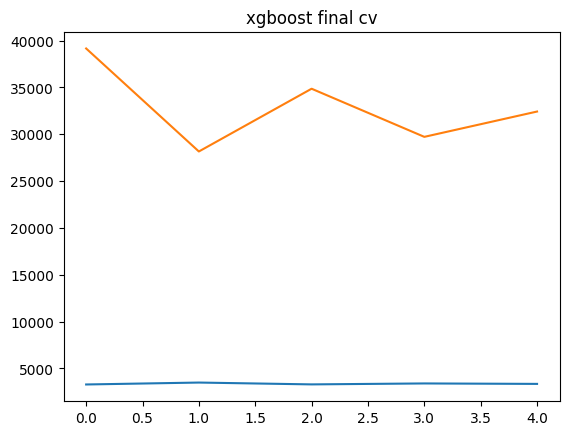

In [81]:
plt.plot(range(len(xgboost_final_result)), [i[0] for i in xgboost_final_result])
plt.plot(range(len(xgboost_final_result)), [i[1] for i in xgboost_final_result])
plt.title('xgboost final cv')
plt.show()

In [76]:
train_xgboost, test_xgboost = train_test_split(df_selected_xgboost, test_size = 0.2, random_state=2)
estimator = XGBRegressor(**xgboost_param_dic)
xgboost_model = SklearnRegressor(estimator, num_model_var, target)

xgboost_model.train(train_xgboost, test_xgboost)

[0]	validation_0-rmse:58584.7
[1]	validation_0-rmse:49341.2
[2]	validation_0-rmse:45545.6
[3]	validation_0-rmse:44829.1
[4]	validation_0-rmse:42323
[5]	validation_0-rmse:40833.6
[6]	validation_0-rmse:41992.6
[7]	validation_0-rmse:40561.9
[8]	validation_0-rmse:39859.9
[9]	validation_0-rmse:40103.8
[10]	validation_0-rmse:39296.9
[11]	validation_0-rmse:39721
[12]	validation_0-rmse:39540.9
[13]	validation_0-rmse:40467.2
[14]	validation_0-rmse:40139
[15]	validation_0-rmse:39830
[16]	validation_0-rmse:39269.3
[17]	validation_0-rmse:39736.6
[18]	validation_0-rmse:39571
[19]	validation_0-rmse:39378.5
[20]	validation_0-rmse:39105.9
[21]	validation_0-rmse:39239.8
[22]	validation_0-rmse:39505.5
[23]	validation_0-rmse:39165.5
[24]	validation_0-rmse:39109.5
[25]	validation_0-rmse:38935.9
[26]	validation_0-rmse:39398.4
[27]	validation_0-rmse:39300
[28]	validation_0-rmse:38877.3
[29]	validation_0-rmse:38950.2
[30]	validation_0-rmse:38856.6
[31]	validation_0-rmse:38931.3
[32]	validation_0-rmse:39092.9

[261]	validation_0-rmse:39038.9
[262]	validation_0-rmse:39033.8
[263]	validation_0-rmse:39022.3
[264]	validation_0-rmse:39036.4
[265]	validation_0-rmse:39062.3
[266]	validation_0-rmse:39071.8
[267]	validation_0-rmse:39110.8
[268]	validation_0-rmse:39127.9
[269]	validation_0-rmse:39125.6
[270]	validation_0-rmse:39099.1
[271]	validation_0-rmse:39102.5
[272]	validation_0-rmse:39053.9
[273]	validation_0-rmse:39035.7
[274]	validation_0-rmse:39019.1
[275]	validation_0-rmse:39013
[276]	validation_0-rmse:39001.5
[277]	validation_0-rmse:38982.9
[278]	validation_0-rmse:38983
[279]	validation_0-rmse:38999.7
[280]	validation_0-rmse:39012.8
[281]	validation_0-rmse:39013.8
[282]	validation_0-rmse:39011.2
[283]	validation_0-rmse:39012.7
[284]	validation_0-rmse:39022.1
[285]	validation_0-rmse:39021.9
[286]	validation_0-rmse:39013.8
[287]	validation_0-rmse:38983.9
[288]	validation_0-rmse:38997.6
[289]	validation_0-rmse:39004.1
[290]	validation_0-rmse:38980.9
[291]	validation_0-rmse:38969.9
[292]	valida

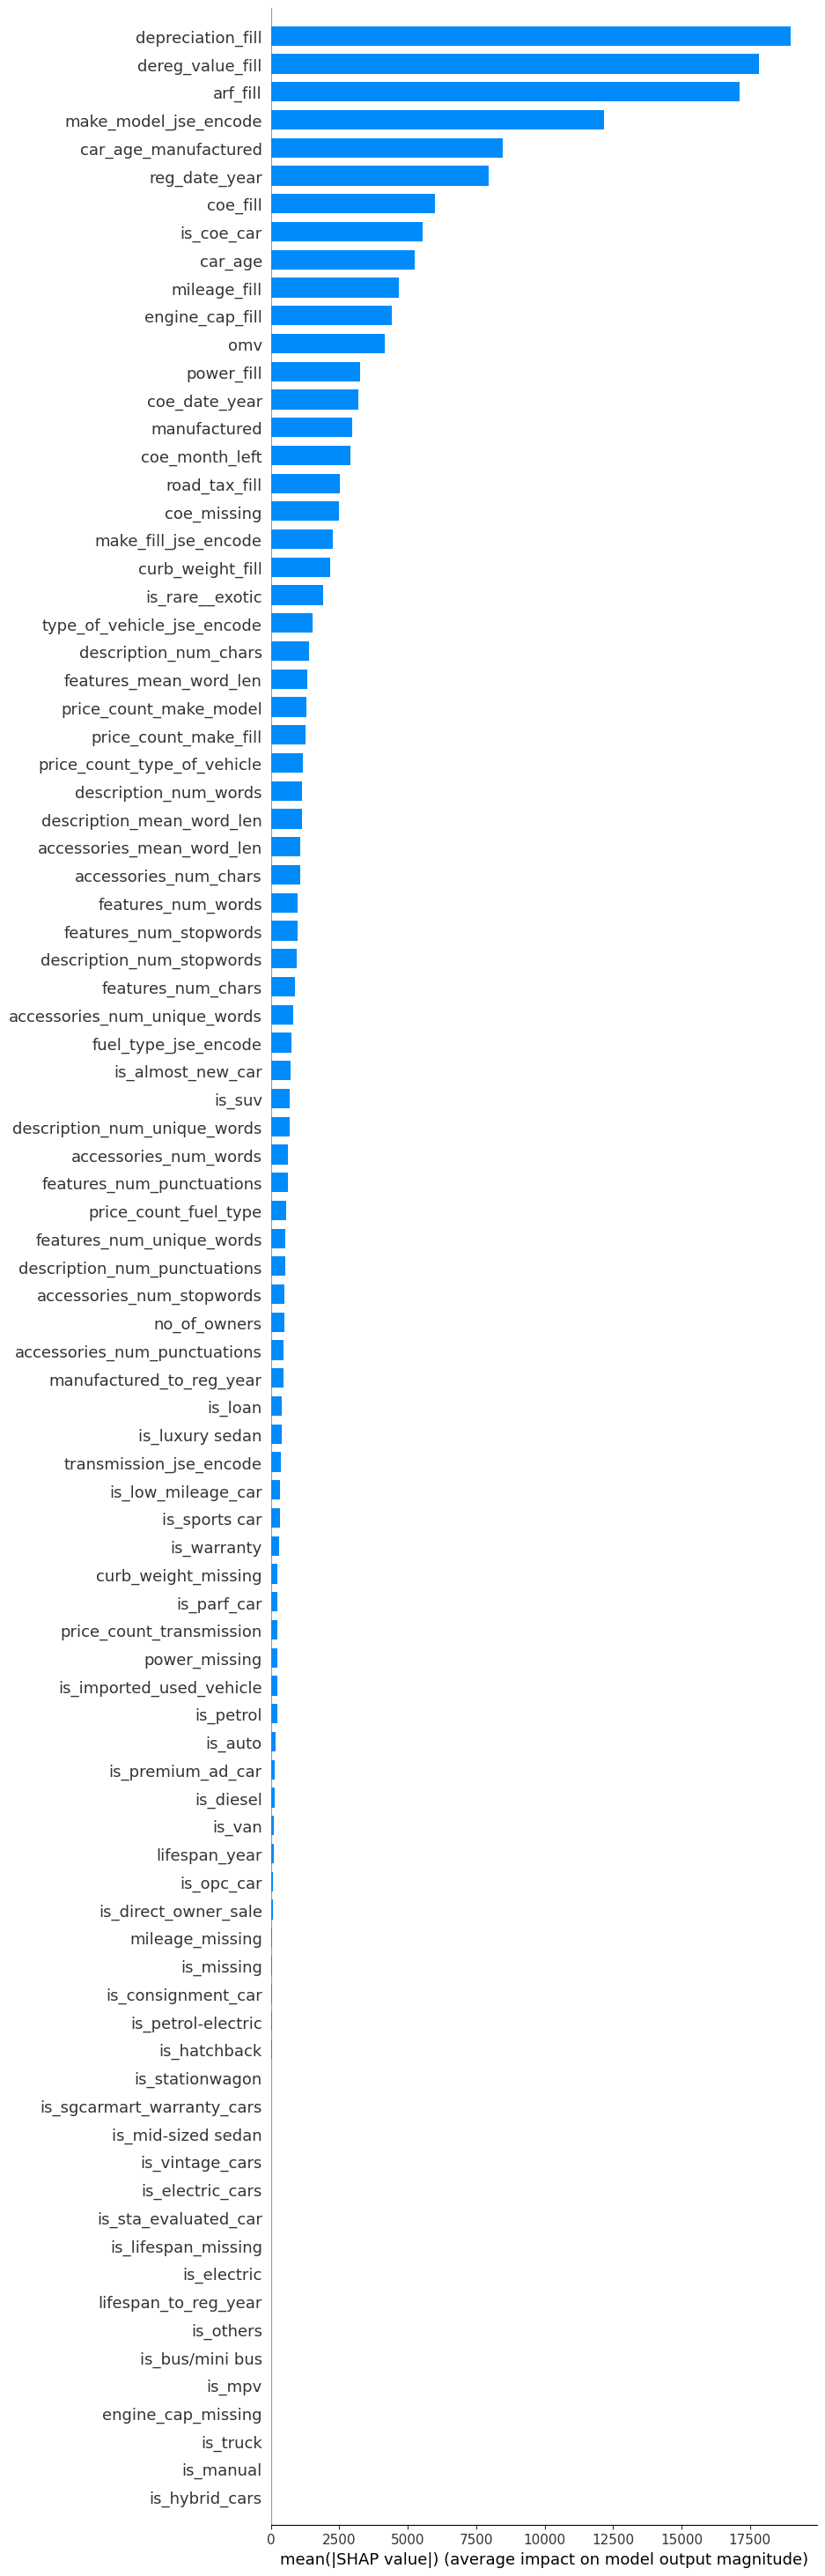

In [77]:
explainer = shap.TreeExplainer(xgboost_model.model)
shap_values= explainer.shap_values(test_xgboost[num_model_var])
shap.summary_plot(shap_values, 
                  test_xgboost[num_model_var], 
                  plot_type="bar", 
                  max_display=test[num_model_var].shape[1])

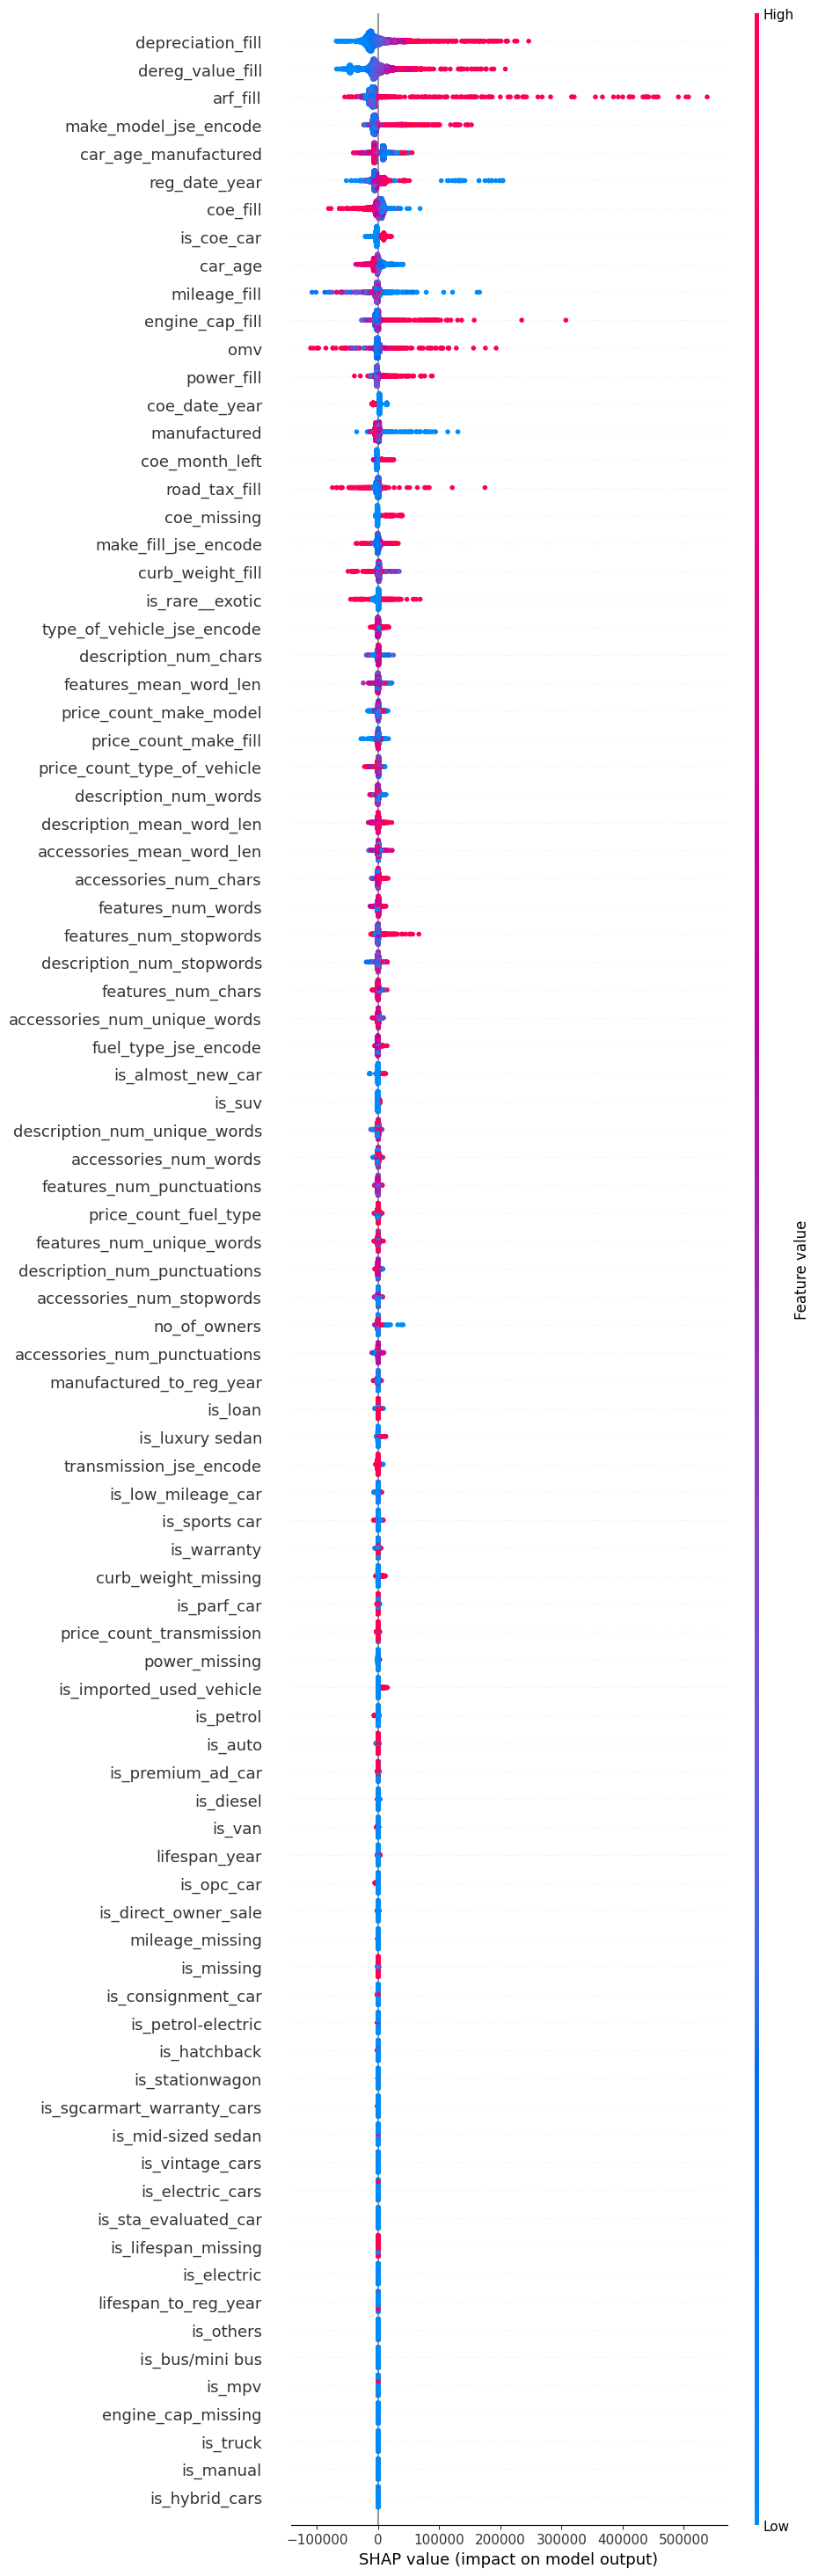

In [78]:
shap.summary_plot(shap_values, 
                  test_xgboost[num_model_var], 
                  max_display=test_xgboost[num_model_var].shape[1])

# Random Forest

## feature selection

In [185]:
rf_param_dic={}
rf_estimator = RandomForestRegressor(**rf_param_dic)
rf_model = SklearnRegressor(rf_estimator, num_model_var, target)
rf_model.train(df_train_engineered, stage="test")

In [190]:
rf_feature_importance_dic = {}
for feature in zip(num_model_var, rf_model.model.feature_importances_):
    rf_feature_importance_dic[feature[0]] = feature[1]
rf_feature_importance_sorted_col = sorted(rf_feature_importance_dic, 
                                      key=rf_feature_importance_dic.get, 
                                      reverse=True)
rf_feature_importance_sorted_val = sorted(rf_feature_importance_dic.values(), 
                                          reverse=True)

In [191]:
def train_top_x_features(x, feature_ls, df, param_dic):
    input_feature = feature_ls[:x]
    kf = KFold(n_splits = 5, shuffle = True, random_state = 2)
    kf_index = kf.split(df)
    rf_final_result = kf_predict(kf_index,
                                 param_dic, 
                                 input_feature,
                                 target,
                                 "random forest", 
                                 df)
    return rf_final_result

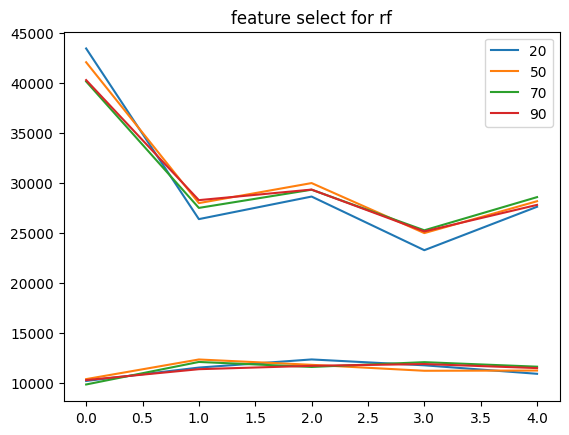

In [192]:
rf_param_dic = {}

no_features = [20,50,70,90]
result = {}
for x in no_features:
    curr_output = train_top_x_features(x, 
                                       rf_feature_importance_sorted_col, 
                                       df_train_engineered,
                                      rf_param_dic)
    result[x] = curr_output

clrs = sns.color_palette( n_colors=5)
for i,x in enumerate(no_features):
    plt.plot(range(len(result[x])), [i[0] for i in result[x]], c=clrs[i], label=x)
    plt.plot(range(len(result[x])), [i[1] for i in result[x]], c=clrs[i])

plt.legend()
plt.title(f'feature select for rf')
plt.show()

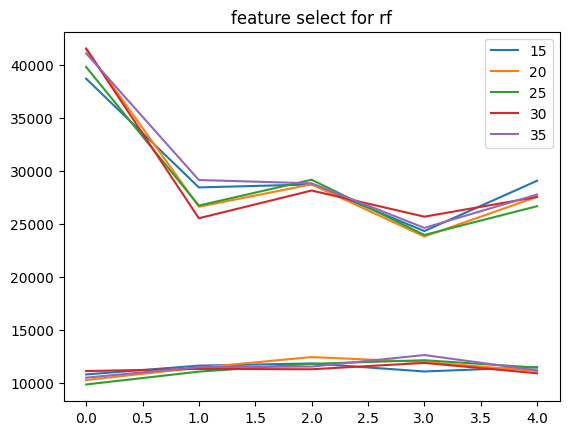

In [193]:
rf_param_dic = {}

no_features = [15,20,25,30,35]
result = {}
for x in no_features:
    curr_output = train_top_x_features(x, 
                                       rf_feature_importance_sorted_col, 
                                       df_train_engineered,
                                      rf_param_dic)
    result[x] = curr_output

clrs = sns.color_palette( n_colors=5)
for i,x in enumerate(no_features):
    plt.plot(range(len(result[x])), [i[0] for i in result[x]], c=clrs[i], label=x)
    plt.plot(range(len(result[x])), [i[1] for i in result[x]], c=clrs[i])

plt.legend()
plt.title(f'feature select for rf')
plt.show()

In [197]:
selected_features = rf_feature_importance_sorted_col[:30]

selected_features = ['arf_fill',
 'make_model_jse_encode',
 'dereg_value_fill',
 'is_rare__exotic',
 'mileage_fill',
 'depreciation_fill',
 'car_age',
 'reg_date_year',
 'car_age_manufactured',
 'omv',
 'engine_cap_fill',
 'power_fill',
 'coe_fill',
 'road_tax_fill',
 'manufactured',
 'curb_weight_fill',
 'no_of_owners',
 'description_mean_word_len',
 'make_fill_jse_encode',
 'is_imported_used_vehicle',
 'coe_month_left',
 'accessories_mean_word_len',
 'accessories_num_stopwords',
 'price_count_make_fill',
 'features_mean_word_len',
 'coe_date_year',
 'price_count_make_model',
 'features_num_stopwords',
 'manufactured_to_reg_year',
 'type_of_vehicle_jse_encode']

In [200]:
# n_estimators = 
rf_param_dic = {
    "n_estimators": 100,
    'n_jobs': 5}
n_estimators_result = hp_tuning('n_estimators', 
                   [50,100,300,400], 
                   rf_param_dic, 
                   selected_features, 
                   target, 
                   "random forest",
                   df_train_engineered)

training n_estimators = 50
training n_estimators = 100
training n_estimators = 300
training n_estimators = 400


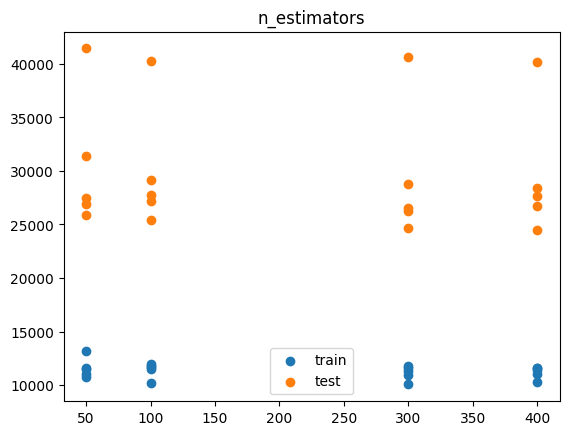

In [201]:
plot_result(n_estimators_result, "n_estimators")

In [218]:
# max_depth = 25
rf_param_dic = {
    "n_estimators": 300,
    'n_jobs': 5}
max_depth_result = hp_tuning('max_depth', 
                   [5,10,15,20,25,30], 
                   rf_param_dic, 
                   selected_features, 
                   target, 
                   "random forest",
                   df_train_engineered)

training max_depth = 5
training max_depth = 10
training max_depth = 15
training max_depth = 20
training max_depth = 25
training max_depth = 30


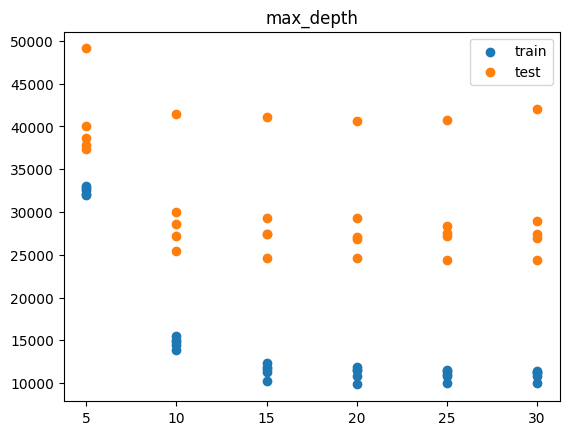

In [219]:
plot_result(max_depth_result, "max_depth")

In [220]:
rf_param_dic = {
    "n_estimators": 300,
    "max_depth": 25, 
    'n_jobs': 5}
mss_result = hp_tuning('min_samples_split', 
                   [2,10,50,100,200], 
                   rf_param_dic, 
                   selected_features, 
                   target, 
                   "random forest",
                   df_train_engineered)

training min_samples_split = 2
training min_samples_split = 10
training min_samples_split = 50
training min_samples_split = 100
training min_samples_split = 200


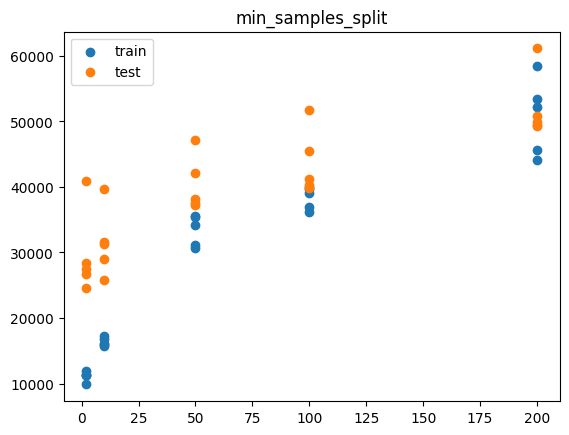

In [221]:
plot_result(mss_result, "min_samples_split")

In [223]:
rf_param_dic = {
    "n_estimators": 300,
    "max_depth": 25, 
    'n_jobs': 5}
mss_result2 = hp_tuning('min_samples_split', 
                   [2,5,10,15,20], 
                   rf_param_dic, 
                   selected_features, 
                   target, 
                   "random forest",
                   df_train_engineered)

training min_samples_split = 2
training min_samples_split = 5
training min_samples_split = 10
training min_samples_split = 15
training min_samples_split = 20


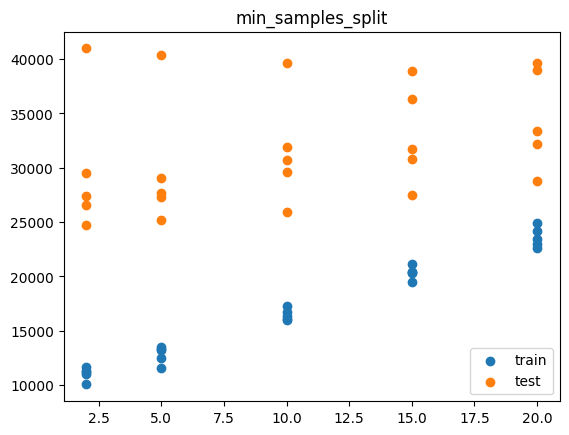

In [224]:
plot_result(mss_result2, "min_samples_split")

In [227]:
rf_param_dic = {
    "n_estimators": 300,
    "max_depth": 25,
    "min_samples_split": 10,
    'n_jobs': 5}
msl_result = hp_tuning('min_samples_leaf', 
                   [1,10,20,30,40,50], 
                   rf_param_dic, 
                   selected_features, 
                   target, 
                   "random forest",
                   df_train_engineered)

training min_samples_leaf = 1
training min_samples_leaf = 10
training min_samples_leaf = 20
training min_samples_leaf = 30
training min_samples_leaf = 40
training min_samples_leaf = 50


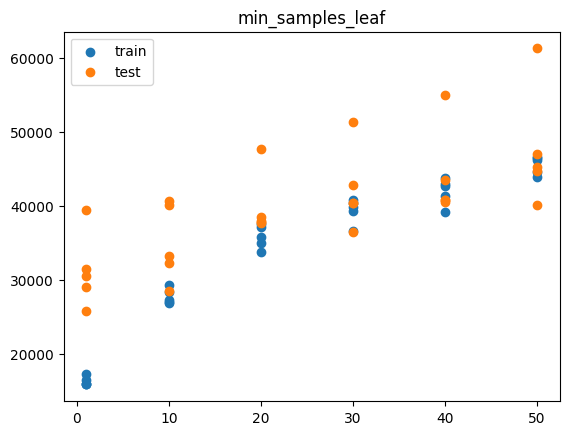

In [228]:
plot_result(msl_result, "min_samples_leaf")

In [229]:
rf_param_dic = {
    "n_estimators": 300,
    "max_depth": 25,
    "min_samples_split": 10,
    'n_jobs': 5}
result2_msf = hp_tuning('min_samples_leaf', 
                   [1,2,5,7,9], 
                   rf_param_dic, 
                   selected_features, 
                   target, 
                   "random forest",
                   df_train_engineered)

training min_samples_leaf = 1
training min_samples_leaf = 2
training min_samples_leaf = 5
training min_samples_leaf = 7
training min_samples_leaf = 9


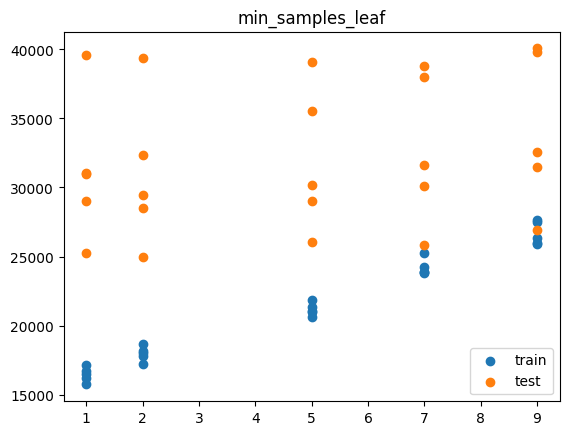

In [230]:
#10
plot_result(result2_msf, "min_samples_leaf")

In [231]:
rf_param_dic = {
    "n_estimators": 300,
    "max_depth": 25,
    "min_samples_split": 10,
    "min_samples_leaf": 5,
    'n_jobs': 5}
mf_result = hp_tuning('max_features', 
                   ["auto", "sqrt", "log2"], 
                   rf_param_dic, 
                   selected_features, 
                   target, 
                   "random forest",
                   df_train_engineered)

training max_features = auto
training max_features = sqrt
training max_features = log2


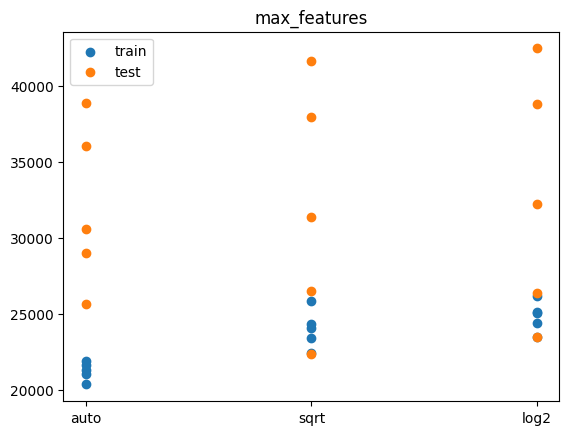

In [232]:
plot_result(mf_result, "max_features")

In [233]:
# grid search ard the optimal parameters
from sklearn.model_selection import GridSearchCV

param_search = {
    'n_estimators':[300,350],
    'max_depth':[20,22,25],
    'min_samples_split':[2,8,10,12,15],
    'min_samples_leaf':[2,5,6,7]
}
gsearch = GridSearchCV(estimator = RandomForestRegressor(n_jobs=3), 
                       param_grid = param_search, 
                       scoring='neg_root_mean_squared_error',
                       n_jobs=4,
                       cv=5,
                       verbose=10)
gsearch.fit(df_train_engineered[selected_features],df_train_engineered[target])
print (gsearch.best_params_, gsearch.best_score_)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   49.9s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  4.0min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  6.6min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  8.2min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed: 10.5min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed: 12.6min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed: 15.2min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed: 18.7min
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed: 21.7min
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed: 25.0min
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed: 27.9min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 30.7min
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed: 33.8min
[Parallel(

{'max_depth': 22, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 350} -28471.09753264514


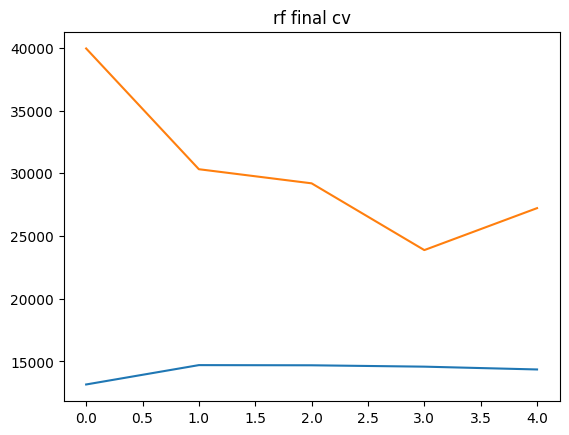

In [234]:
rf_param_dic = {
    'max_depth': 22, 
    'min_samples_leaf': 2, 
    'min_samples_split': 2, 
    'n_estimators': 350}
df_selected_rf = df_train_engineered[num_model_var+[target]]
kf = KFold(n_splits = 5, shuffle = True, random_state = 2)
kf_index = kf.split(df_selected_rf)
rf_final_result = kf_predict(kf_index,
                             rf_param_dic, 
                             selected_features,
                             target,
                             "random forest", 
                             df_selected_rf)

plt.plot(range(len(rf_final_result)), [i[0] for i in rf_final_result])
plt.plot(range(len(rf_final_result)), [i[1] for i in rf_final_result])
plt.title('rf final cv')
plt.show()

In [247]:
df_selected_rf = df_train_engineered[num_model_var+[target]]
kf = KFold(n_splits = 5, shuffle = True, random_state = 2)
kf_index = kf.split(df_selected_rf)
rf_final_result_full = kf_predict(kf_index,
                             rf_param_dic, 
                             num_model_var,
                             target,
                             "random forest", 
                             df_train_engineered)

In [250]:
df_selected_rf = df_train_engineered[num_model_var+[target]]
kf = KFold(n_splits = 5, shuffle = True, random_state = 2)
kf_index = kf.split(df_selected_rf)
rf_final_result_default = kf_predict(kf_index,
                             {}, 
                             selected_features,
                             target,
                             "random forest", 
                             df_train_engineered)

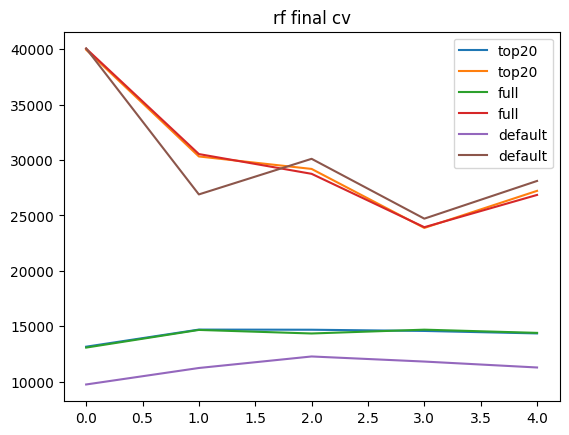

In [251]:
plt.plot(range(len(rf_final_result)), [i[0] for i in rf_final_result], label='top20')
plt.plot(range(len(rf_final_result)), [i[1] for i in rf_final_result], label='top20')
plt.plot(range(len(rf_final_result_full)), [i[0] for i in rf_final_result_full], label='full')
plt.plot(range(len(rf_final_result_full)), [i[1] for i in rf_final_result_full], label='full')
plt.plot(range(len(rf_final_result_default)), [i[0] for i in rf_final_result_default], label='default')
plt.plot(range(len(rf_final_result_default)), [i[1] for i in rf_final_result_default], label='default')
plt.legend()
plt.title('rf final cv')
plt.show()

In [10]:
rf_param_dic = {
    'max_depth': 22, 
    'min_samples_leaf': 2, 
    'min_samples_split': 2, 
    'n_estimators': 350}
rf_estimator = RandomForestRegressor(**rf_param_dic)

rf_model = SklearnRegressor(rf_estimator, selected_features, target)
rf_model.train(df_train_engineered, stage="test")

In [11]:
y_pred = rf_model.predict(df_test_engineered[selected_features])
df_predict = pd.DataFrame({"Predicted": y_pred})
df_predict.to_csv("../data/processed/predict_yy_rf_top20.csv", index_label = "Id")

# Compare different models

In [158]:
rf_param_dic = {
    'max_depth': 22, 
    'min_samples_leaf': 2, 
    'min_samples_split': 2, 
    'n_estimators': 350}
kf = KFold(n_splits = 5, shuffle = True, random_state = 2)
kf_index = kf.split(df_train_engineered)
rf_final_result = kf_predict(kf_index,
                             rf_param_dic, 
                             selected_features,
                             target,
                             "random forest", 
                             df_train_engineered)

In [159]:
xgboost_param_dic = {
    "max_depth": 5,
    "learning_rate": 0.1,
    "colsample_bytree": 0.7,
    "n_estimators": 1000,
    "early_stopping_rounds": 5,
    "verbose": False,
    "eval_metric": "rmse",
    "reg_lambda": 8,
    "min_child_weight": 80,
    "early_stopping_rounds":10}
#kf = KFold(n_splits = 5, shuffle = True, random_state = 2)
kf_index = kf.split(df_train_engineered)
xgboost_final_result = kf_predict(kf_index, 
                                   xgboost_param_dic, 
                                   num_model_var, 
                                   target, 
                                   "xgboost", 
                                   df_train_engineered)

[0]	validation_0-rmse:159912
[1]	validation_0-rmse:146092
[2]	validation_0-rmse:133618
[3]	validation_0-rmse:122301
[4]	validation_0-rmse:112407
[5]	validation_0-rmse:103222
[6]	validation_0-rmse:94940
[7]	validation_0-rmse:87617.7
[8]	validation_0-rmse:81145.9
[9]	validation_0-rmse:75765.4
[10]	validation_0-rmse:70890.3
[11]	validation_0-rmse:66654.5
[12]	validation_0-rmse:63006.3
[13]	validation_0-rmse:59317.3
[14]	validation_0-rmse:56504.5
[15]	validation_0-rmse:53832.9
[16]	validation_0-rmse:51238.6
[17]	validation_0-rmse:49000.6
[18]	validation_0-rmse:47078.4
[19]	validation_0-rmse:45432.3
[20]	validation_0-rmse:44023.5
[21]	validation_0-rmse:42781
[22]	validation_0-rmse:41661.1
[23]	validation_0-rmse:40753.3
[24]	validation_0-rmse:40038
[25]	validation_0-rmse:39303.8
[26]	validation_0-rmse:38624.3
[27]	validation_0-rmse:38124.9
[28]	validation_0-rmse:37443.4
[29]	validation_0-rmse:37013.9
[30]	validation_0-rmse:36639.3
[31]	validation_0-rmse:36179.9
[32]	validation_0-rmse:35778.4

[262]	validation_0-rmse:24569.5
[263]	validation_0-rmse:24552.6
[264]	validation_0-rmse:24521.4
[265]	validation_0-rmse:24482.9
[266]	validation_0-rmse:24454.1
[267]	validation_0-rmse:24426.5
[268]	validation_0-rmse:24405.8
[269]	validation_0-rmse:24400.6
[270]	validation_0-rmse:24364.2
[271]	validation_0-rmse:24325.4
[272]	validation_0-rmse:24284.5
[273]	validation_0-rmse:24273.5
[274]	validation_0-rmse:24249
[275]	validation_0-rmse:24239.9
[276]	validation_0-rmse:24228
[277]	validation_0-rmse:24234.7
[278]	validation_0-rmse:24205.7
[279]	validation_0-rmse:24228.2
[280]	validation_0-rmse:24220.1
[281]	validation_0-rmse:24205.2
[282]	validation_0-rmse:24205.5
[283]	validation_0-rmse:24184.3
[284]	validation_0-rmse:24175.4
[285]	validation_0-rmse:24134.4
[286]	validation_0-rmse:24151.4
[287]	validation_0-rmse:24133.4
[288]	validation_0-rmse:24123
[289]	validation_0-rmse:24106.2
[290]	validation_0-rmse:24072.2
[291]	validation_0-rmse:24062.2
[292]	validation_0-rmse:24037
[293]	validation

[520]	validation_0-rmse:22300.3
[521]	validation_0-rmse:22287.1
[522]	validation_0-rmse:22280
[523]	validation_0-rmse:22267.7
[524]	validation_0-rmse:22271
[525]	validation_0-rmse:22261.1
[526]	validation_0-rmse:22279
[527]	validation_0-rmse:22281.5
[528]	validation_0-rmse:22302.2
[529]	validation_0-rmse:22287.7
[530]	validation_0-rmse:22290.2
[531]	validation_0-rmse:22284.5
[532]	validation_0-rmse:22255
[533]	validation_0-rmse:22254
[534]	validation_0-rmse:22242.6
[535]	validation_0-rmse:22251.5
[536]	validation_0-rmse:22229.1
[537]	validation_0-rmse:22211.4
[538]	validation_0-rmse:22218.6
[539]	validation_0-rmse:22197.5
[540]	validation_0-rmse:22195.8
[541]	validation_0-rmse:22196.3
[542]	validation_0-rmse:22191.9
[543]	validation_0-rmse:22191.6
[544]	validation_0-rmse:22190.9
[545]	validation_0-rmse:22195.1
[546]	validation_0-rmse:22195.8
[547]	validation_0-rmse:22190.2
[548]	validation_0-rmse:22175.3
[549]	validation_0-rmse:22178.5
[550]	validation_0-rmse:22171.4
[551]	validation_0

[778]	validation_0-rmse:21507.4
[779]	validation_0-rmse:21501
[780]	validation_0-rmse:21499.7
[781]	validation_0-rmse:21495.1
[782]	validation_0-rmse:21488.5
[783]	validation_0-rmse:21484.9
[784]	validation_0-rmse:21452.7
[785]	validation_0-rmse:21445.1
[786]	validation_0-rmse:21446.9
[787]	validation_0-rmse:21435.1
[788]	validation_0-rmse:21422.3
[789]	validation_0-rmse:21427
[790]	validation_0-rmse:21402.8
[791]	validation_0-rmse:21409.8
[792]	validation_0-rmse:21415.1
[793]	validation_0-rmse:21411.8
[794]	validation_0-rmse:21405.5
[795]	validation_0-rmse:21402.5
[796]	validation_0-rmse:21405.9
[797]	validation_0-rmse:21397.7
[798]	validation_0-rmse:21387.6
[799]	validation_0-rmse:21388.5
[800]	validation_0-rmse:21382.1
[801]	validation_0-rmse:21373.1
[802]	validation_0-rmse:21367.8
[803]	validation_0-rmse:21356
[804]	validation_0-rmse:21353.4
[805]	validation_0-rmse:21358.7
[806]	validation_0-rmse:21361.9
[807]	validation_0-rmse:21362.7
[808]	validation_0-rmse:21372.2
[809]	validati

[39]	validation_0-rmse:36667.9
[40]	validation_0-rmse:36420.8
[41]	validation_0-rmse:36187.5
[42]	validation_0-rmse:36061.9
[43]	validation_0-rmse:35888.1
[44]	validation_0-rmse:35706.6
[45]	validation_0-rmse:35477.8
[46]	validation_0-rmse:35290.4
[47]	validation_0-rmse:35201.2
[48]	validation_0-rmse:35079.3
[49]	validation_0-rmse:34993.3
[50]	validation_0-rmse:34833.9
[51]	validation_0-rmse:34727
[52]	validation_0-rmse:34625.5
[53]	validation_0-rmse:34487.8
[54]	validation_0-rmse:34425.8
[55]	validation_0-rmse:34321.4
[56]	validation_0-rmse:34235.1
[57]	validation_0-rmse:34147.3
[58]	validation_0-rmse:34089.2
[59]	validation_0-rmse:34006.5
[60]	validation_0-rmse:33928.9
[61]	validation_0-rmse:33884.6
[62]	validation_0-rmse:33817.1
[63]	validation_0-rmse:33755.8
[64]	validation_0-rmse:33551.3
[65]	validation_0-rmse:33510
[66]	validation_0-rmse:33448.6
[67]	validation_0-rmse:33255.5
[68]	validation_0-rmse:33071.8
[69]	validation_0-rmse:33028.3
[70]	validation_0-rmse:32934.5
[71]	validat

[299]	validation_0-rmse:27595.4
[300]	validation_0-rmse:27579.5
[301]	validation_0-rmse:27550.2
[302]	validation_0-rmse:27537
[303]	validation_0-rmse:27541.6
[304]	validation_0-rmse:27489.2
[305]	validation_0-rmse:27479.8
[306]	validation_0-rmse:27486.6
[307]	validation_0-rmse:27479.6
[308]	validation_0-rmse:27472.5
[309]	validation_0-rmse:27487.8
[310]	validation_0-rmse:27465.1
[311]	validation_0-rmse:27415.7
[312]	validation_0-rmse:27414.1
[313]	validation_0-rmse:27420.1
[314]	validation_0-rmse:27417.6
[315]	validation_0-rmse:27411.9
[316]	validation_0-rmse:27430.4
[317]	validation_0-rmse:27433.3
[318]	validation_0-rmse:27403.8
[319]	validation_0-rmse:27403.4
[320]	validation_0-rmse:27414.2
[321]	validation_0-rmse:27431.3
[322]	validation_0-rmse:27409
[323]	validation_0-rmse:27421.3
[324]	validation_0-rmse:27390.8
[325]	validation_0-rmse:27397.9
[326]	validation_0-rmse:27369.4
[327]	validation_0-rmse:27333.1
[328]	validation_0-rmse:27321.6
[329]	validation_0-rmse:27329.8
[330]	valida

[557]	validation_0-rmse:25995.8
[558]	validation_0-rmse:25986
[559]	validation_0-rmse:25992.2
[560]	validation_0-rmse:25974
[561]	validation_0-rmse:25967.4
[562]	validation_0-rmse:25961.2
[563]	validation_0-rmse:25955.1
[564]	validation_0-rmse:25928.3
[565]	validation_0-rmse:25933.6
[566]	validation_0-rmse:25925.6
[567]	validation_0-rmse:25914.1
[568]	validation_0-rmse:25893.7
[569]	validation_0-rmse:25893
[570]	validation_0-rmse:25904.8
[571]	validation_0-rmse:25902.3
[572]	validation_0-rmse:25905.5
[573]	validation_0-rmse:25898.2
[574]	validation_0-rmse:25899.5
[575]	validation_0-rmse:25888.9
[576]	validation_0-rmse:25874
[577]	validation_0-rmse:25864.5
[578]	validation_0-rmse:25843
[579]	validation_0-rmse:25830.5
[580]	validation_0-rmse:25833.7
[581]	validation_0-rmse:25836.6
[582]	validation_0-rmse:25841.7
[583]	validation_0-rmse:25820.6
[584]	validation_0-rmse:25821.7
[585]	validation_0-rmse:25799.6
[586]	validation_0-rmse:25796.3
[587]	validation_0-rmse:25783.3
[588]	validation_0

[815]	validation_0-rmse:24975.5
[816]	validation_0-rmse:24969.1
[817]	validation_0-rmse:24959.9
[818]	validation_0-rmse:24968.1
[819]	validation_0-rmse:24968.6
[820]	validation_0-rmse:24973.2
[821]	validation_0-rmse:24965.1
[822]	validation_0-rmse:24963.7
[823]	validation_0-rmse:24960.2
[824]	validation_0-rmse:24948.9
[825]	validation_0-rmse:24937
[826]	validation_0-rmse:24941.5
[827]	validation_0-rmse:24928
[828]	validation_0-rmse:24921.7
[829]	validation_0-rmse:24932.6
[830]	validation_0-rmse:24922.1
[831]	validation_0-rmse:24909.8
[832]	validation_0-rmse:24906.4
[833]	validation_0-rmse:24900
[834]	validation_0-rmse:24899.7
[835]	validation_0-rmse:24895.2
[836]	validation_0-rmse:24885.2
[837]	validation_0-rmse:24878.4
[838]	validation_0-rmse:24870.4
[839]	validation_0-rmse:24869.5
[840]	validation_0-rmse:24867.7
[841]	validation_0-rmse:24867.1
[842]	validation_0-rmse:24858
[843]	validation_0-rmse:24858.2
[844]	validation_0-rmse:24854.6
[845]	validation_0-rmse:24847.8
[846]	validation

[77]	validation_0-rmse:33035.4
[78]	validation_0-rmse:32944
[79]	validation_0-rmse:32886.6
[80]	validation_0-rmse:32867.9
[81]	validation_0-rmse:32813.9
[82]	validation_0-rmse:32703
[83]	validation_0-rmse:32642.9
[84]	validation_0-rmse:32615
[85]	validation_0-rmse:32478.1
[86]	validation_0-rmse:32451.5
[87]	validation_0-rmse:32373.6
[88]	validation_0-rmse:32367
[89]	validation_0-rmse:32325.2
[90]	validation_0-rmse:32319.6
[91]	validation_0-rmse:32272.7
[92]	validation_0-rmse:32222.1
[93]	validation_0-rmse:32141.1
[94]	validation_0-rmse:32062.7
[95]	validation_0-rmse:32057.4
[96]	validation_0-rmse:32029.9
[97]	validation_0-rmse:32000.6
[98]	validation_0-rmse:31911
[99]	validation_0-rmse:31921.7
[100]	validation_0-rmse:31900.8
[101]	validation_0-rmse:31857.6
[102]	validation_0-rmse:31716.4
[103]	validation_0-rmse:31674.3
[104]	validation_0-rmse:31675.2
[105]	validation_0-rmse:31654.9
[106]	validation_0-rmse:31622.4
[107]	validation_0-rmse:31569.4
[108]	validation_0-rmse:31452.8
[109]	val

[336]	validation_0-rmse:27807.5
[337]	validation_0-rmse:27827.6
[338]	validation_0-rmse:27831.1
[339]	validation_0-rmse:27846.2
[340]	validation_0-rmse:27844.9
[341]	validation_0-rmse:27842.2
[342]	validation_0-rmse:27835
[343]	validation_0-rmse:27832.4
[344]	validation_0-rmse:27831
[345]	validation_0-rmse:27773.1
[346]	validation_0-rmse:27737.8
[347]	validation_0-rmse:27740.8
[348]	validation_0-rmse:27739.3
[349]	validation_0-rmse:27727.3
[350]	validation_0-rmse:27704.7
[351]	validation_0-rmse:27690.7
[352]	validation_0-rmse:27672.9
[353]	validation_0-rmse:27672.5
[354]	validation_0-rmse:27635.3
[355]	validation_0-rmse:27617.7
[356]	validation_0-rmse:27607.2
[357]	validation_0-rmse:27602.9
[358]	validation_0-rmse:27606.1
[359]	validation_0-rmse:27609.2
[360]	validation_0-rmse:27605.1
[361]	validation_0-rmse:27598.4
[362]	validation_0-rmse:27598.7
[363]	validation_0-rmse:27570.6
[364]	validation_0-rmse:27561.5
[365]	validation_0-rmse:27562.4
[366]	validation_0-rmse:27581.7
[367]	valida

[594]	validation_0-rmse:25457.5
[595]	validation_0-rmse:25422.1
[596]	validation_0-rmse:25410.2
[597]	validation_0-rmse:25414.8
[598]	validation_0-rmse:25417.9
[599]	validation_0-rmse:25431.6
[600]	validation_0-rmse:25433.5
[601]	validation_0-rmse:25430.8
[602]	validation_0-rmse:25427.4
[603]	validation_0-rmse:25428.2
[604]	validation_0-rmse:25409.3
[605]	validation_0-rmse:25411.7
[606]	validation_0-rmse:25404.9
[607]	validation_0-rmse:25409.3
[608]	validation_0-rmse:25403.8
[609]	validation_0-rmse:25403.2
[610]	validation_0-rmse:25401.7
[611]	validation_0-rmse:25396
[612]	validation_0-rmse:25397.1
[613]	validation_0-rmse:25393.7
[614]	validation_0-rmse:25400.5
[615]	validation_0-rmse:25394.8
[616]	validation_0-rmse:25386.4
[617]	validation_0-rmse:25383.7
[618]	validation_0-rmse:25385.2
[619]	validation_0-rmse:25387.7
[620]	validation_0-rmse:25387.7
[621]	validation_0-rmse:25376.8
[622]	validation_0-rmse:25380.2
[623]	validation_0-rmse:25371.7
[624]	validation_0-rmse:25368.2
[625]	vali

[852]	validation_0-rmse:24649.5
[853]	validation_0-rmse:24650.2
[854]	validation_0-rmse:24653.3
[855]	validation_0-rmse:24633.8
[856]	validation_0-rmse:24640.2
[857]	validation_0-rmse:24637.6
[858]	validation_0-rmse:24631.5
[859]	validation_0-rmse:24624.5
[860]	validation_0-rmse:24602.1
[861]	validation_0-rmse:24603.2
[862]	validation_0-rmse:24584
[863]	validation_0-rmse:24589.2
[864]	validation_0-rmse:24594.6
[865]	validation_0-rmse:24581.1
[866]	validation_0-rmse:24582.2
[867]	validation_0-rmse:24590.4
[868]	validation_0-rmse:24575.6
[869]	validation_0-rmse:24560.2
[870]	validation_0-rmse:24562.1
[871]	validation_0-rmse:24562
[872]	validation_0-rmse:24563.1
[873]	validation_0-rmse:24577.2
[874]	validation_0-rmse:24579.2
[875]	validation_0-rmse:24577.8
[876]	validation_0-rmse:24582.1
[877]	validation_0-rmse:24584
[878]	validation_0-rmse:24584.4
[879]	validation_0-rmse:24583
[880]	validation_0-rmse:24579.9
[881]	validation_0-rmse:24576.2
[882]	validation_0-rmse:24570.4
[883]	validation

[114]	validation_0-rmse:33967.1
[115]	validation_0-rmse:33941.8
[116]	validation_0-rmse:33782.3
[117]	validation_0-rmse:33710.5
[118]	validation_0-rmse:33652.2
[119]	validation_0-rmse:33551
[120]	validation_0-rmse:33547.3
[121]	validation_0-rmse:33542.4
[122]	validation_0-rmse:33485.2
[123]	validation_0-rmse:33482.2
[124]	validation_0-rmse:33467.9
[125]	validation_0-rmse:33386.6
[126]	validation_0-rmse:33338.9
[127]	validation_0-rmse:33314.1
[128]	validation_0-rmse:33260.7
[129]	validation_0-rmse:33272.3
[130]	validation_0-rmse:33229.8
[131]	validation_0-rmse:33186.6
[132]	validation_0-rmse:33167.4
[133]	validation_0-rmse:33102.2
[134]	validation_0-rmse:33072.4
[135]	validation_0-rmse:33027.3
[136]	validation_0-rmse:32995.5
[137]	validation_0-rmse:32947.9
[138]	validation_0-rmse:32898.6
[139]	validation_0-rmse:32884.5
[140]	validation_0-rmse:32854.8
[141]	validation_0-rmse:32682.7
[142]	validation_0-rmse:32649.3
[143]	validation_0-rmse:32588.3
[144]	validation_0-rmse:32564.2
[145]	vali

[372]	validation_0-rmse:28684.3
[373]	validation_0-rmse:28668.1
[374]	validation_0-rmse:28635.5
[375]	validation_0-rmse:28640.4
[376]	validation_0-rmse:28634.6
[377]	validation_0-rmse:28625.3
[378]	validation_0-rmse:28622.4
[379]	validation_0-rmse:28627.7
[380]	validation_0-rmse:28639.6
[381]	validation_0-rmse:28632.6
[382]	validation_0-rmse:28612.2
[383]	validation_0-rmse:28579.4
[384]	validation_0-rmse:28573.5
[385]	validation_0-rmse:28565.3
[386]	validation_0-rmse:28563.3
[387]	validation_0-rmse:28529.5
[388]	validation_0-rmse:28528
[389]	validation_0-rmse:28524.5
[390]	validation_0-rmse:28547.9
[391]	validation_0-rmse:28523.3
[392]	validation_0-rmse:28506.4
[393]	validation_0-rmse:28504.1
[394]	validation_0-rmse:28497.9
[395]	validation_0-rmse:28486.5
[396]	validation_0-rmse:28472.3
[397]	validation_0-rmse:28424.7
[398]	validation_0-rmse:28381.7
[399]	validation_0-rmse:28377
[400]	validation_0-rmse:28363
[401]	validation_0-rmse:28353.2
[402]	validation_0-rmse:28354.7
[403]	validati

[630]	validation_0-rmse:26939.5
[631]	validation_0-rmse:26923.7
[632]	validation_0-rmse:26917.4
[633]	validation_0-rmse:26908.3
[634]	validation_0-rmse:26912.7
[635]	validation_0-rmse:26914.7
[636]	validation_0-rmse:26903.5
[637]	validation_0-rmse:26910.2
[638]	validation_0-rmse:26913
[639]	validation_0-rmse:26904.7
[640]	validation_0-rmse:26897.5
[641]	validation_0-rmse:26894.1
[642]	validation_0-rmse:26888.6
[643]	validation_0-rmse:26887.4
[644]	validation_0-rmse:26885.4
[645]	validation_0-rmse:26882.2
[646]	validation_0-rmse:26878.2
[647]	validation_0-rmse:26873.1
[648]	validation_0-rmse:26864.4
[649]	validation_0-rmse:26853.6
[650]	validation_0-rmse:26862.1
[651]	validation_0-rmse:26862.1
[652]	validation_0-rmse:26862.7
[653]	validation_0-rmse:26860
[654]	validation_0-rmse:26852.3
[655]	validation_0-rmse:26846.3
[656]	validation_0-rmse:26835
[657]	validation_0-rmse:26825.2
[658]	validation_0-rmse:26826.1
[659]	validation_0-rmse:26825.1
[660]	validation_0-rmse:26827.5
[661]	validati

[888]	validation_0-rmse:26131.8
[889]	validation_0-rmse:26126.8
[890]	validation_0-rmse:26123.9
[891]	validation_0-rmse:26118
[892]	validation_0-rmse:26113.6
[893]	validation_0-rmse:26114.2
[894]	validation_0-rmse:26106.9
[895]	validation_0-rmse:26106.5
[896]	validation_0-rmse:26107.1
[897]	validation_0-rmse:26101.2
[898]	validation_0-rmse:26094.7
[899]	validation_0-rmse:26090
[900]	validation_0-rmse:26086.1
[901]	validation_0-rmse:26075.5
[902]	validation_0-rmse:26089.6
[903]	validation_0-rmse:26075.5
[904]	validation_0-rmse:26069.1
[905]	validation_0-rmse:26068.2
[906]	validation_0-rmse:26073.4
[907]	validation_0-rmse:26067.9
[908]	validation_0-rmse:26062.5
[909]	validation_0-rmse:26057.5
[910]	validation_0-rmse:26057.7
[911]	validation_0-rmse:26055
[912]	validation_0-rmse:26055.8
[913]	validation_0-rmse:26060.9
[914]	validation_0-rmse:26064.1
[915]	validation_0-rmse:26060.6
[916]	validation_0-rmse:26051
[917]	validation_0-rmse:26045.1
[918]	validation_0-rmse:26042.9
[919]	validation

[150]	validation_0-rmse:42369.3
[151]	validation_0-rmse:42341
[152]	validation_0-rmse:42259.7
[153]	validation_0-rmse:42251.2
[154]	validation_0-rmse:42065.3
[155]	validation_0-rmse:42053.2
[156]	validation_0-rmse:42036.2
[157]	validation_0-rmse:42020.6
[158]	validation_0-rmse:42006.9
[159]	validation_0-rmse:41926.6
[160]	validation_0-rmse:41887.2
[161]	validation_0-rmse:41788.5
[162]	validation_0-rmse:41736.9
[163]	validation_0-rmse:41612.3
[164]	validation_0-rmse:41537.5
[165]	validation_0-rmse:41432.1
[166]	validation_0-rmse:41359.9
[167]	validation_0-rmse:41232.9
[168]	validation_0-rmse:41184.9
[169]	validation_0-rmse:41087.4
[170]	validation_0-rmse:41072.7
[171]	validation_0-rmse:41013.7
[172]	validation_0-rmse:41008.4
[173]	validation_0-rmse:41000.5
[174]	validation_0-rmse:40952
[175]	validation_0-rmse:40880.4
[176]	validation_0-rmse:40826.4
[177]	validation_0-rmse:40734
[178]	validation_0-rmse:40705.7
[179]	validation_0-rmse:40581.9
[180]	validation_0-rmse:40516.8
[181]	validati

[408]	validation_0-rmse:36143.6
[409]	validation_0-rmse:36116
[410]	validation_0-rmse:36104.9
[411]	validation_0-rmse:36106.4
[412]	validation_0-rmse:36049.2
[413]	validation_0-rmse:36051.4
[414]	validation_0-rmse:36058.2
[415]	validation_0-rmse:36042.9
[416]	validation_0-rmse:36041.6
[417]	validation_0-rmse:36011.2
[418]	validation_0-rmse:35986.9
[419]	validation_0-rmse:35982.9
[420]	validation_0-rmse:35970.8
[421]	validation_0-rmse:35931.3
[422]	validation_0-rmse:35923.9
[423]	validation_0-rmse:35910.6
[424]	validation_0-rmse:35896.4
[425]	validation_0-rmse:35868.9
[426]	validation_0-rmse:35864.8
[427]	validation_0-rmse:35853.7
[428]	validation_0-rmse:35788.1
[429]	validation_0-rmse:35791
[430]	validation_0-rmse:35785.4
[431]	validation_0-rmse:35771.6
[432]	validation_0-rmse:35765.3
[433]	validation_0-rmse:35755.1
[434]	validation_0-rmse:35752.1
[435]	validation_0-rmse:35743.1
[436]	validation_0-rmse:35738.9
[437]	validation_0-rmse:35711.7
[438]	validation_0-rmse:35686.6
[439]	valida

[666]	validation_0-rmse:33995.4
[667]	validation_0-rmse:33978.2
[668]	validation_0-rmse:33975.5
[669]	validation_0-rmse:33952.2
[670]	validation_0-rmse:33958.5
[671]	validation_0-rmse:33966.8
[672]	validation_0-rmse:33970.2
[673]	validation_0-rmse:33967.5
[674]	validation_0-rmse:33958.7
[675]	validation_0-rmse:33965.3
[676]	validation_0-rmse:33943.7
[677]	validation_0-rmse:33934.6
[678]	validation_0-rmse:33940.7
[679]	validation_0-rmse:33943.3
[680]	validation_0-rmse:33941.8
[681]	validation_0-rmse:33949.5
[682]	validation_0-rmse:33964.7
[683]	validation_0-rmse:33961.9
[684]	validation_0-rmse:33933.3
[685]	validation_0-rmse:33939.1
[686]	validation_0-rmse:33948.1
[687]	validation_0-rmse:33940.3
[688]	validation_0-rmse:33938.4
[689]	validation_0-rmse:33938.2
[690]	validation_0-rmse:33930.9
[691]	validation_0-rmse:33923.7
[692]	validation_0-rmse:33901.1
[693]	validation_0-rmse:33893.6
[694]	validation_0-rmse:33878
[695]	validation_0-rmse:33858.4
[696]	validation_0-rmse:33836.1
[697]	vali

[924]	validation_0-rmse:33278.6
[925]	validation_0-rmse:33282.8
[926]	validation_0-rmse:33270.3
[927]	validation_0-rmse:33270.2
[928]	validation_0-rmse:33272.7
[929]	validation_0-rmse:33267.7
[930]	validation_0-rmse:33264.5
[931]	validation_0-rmse:33262.2
[932]	validation_0-rmse:33258.1
[933]	validation_0-rmse:33245.9
[934]	validation_0-rmse:33245.9
[935]	validation_0-rmse:33250.9
[936]	validation_0-rmse:33231.9
[937]	validation_0-rmse:33228
[938]	validation_0-rmse:33228.7
[939]	validation_0-rmse:33232.6
[940]	validation_0-rmse:33230.2
[941]	validation_0-rmse:33234.1
[942]	validation_0-rmse:33229.9
[943]	validation_0-rmse:33229.5
[944]	validation_0-rmse:33224.3
[945]	validation_0-rmse:33211.2
[946]	validation_0-rmse:33191.8
[947]	validation_0-rmse:33171.4
[948]	validation_0-rmse:33174.7
[949]	validation_0-rmse:33171.8
[950]	validation_0-rmse:33174
[951]	validation_0-rmse:33180.2
[952]	validation_0-rmse:33173.1
[953]	validation_0-rmse:33175.9
[954]	validation_0-rmse:33174.2
[955]	valida

In [28]:
xgboost_final_result

[(11462.297308107984, 34045.23299238888),
 (12778.33553275688, 25648.650829058242),
 (12687.850406055864, 26374.152234964473),
 (12589.997303406948, 23980.346298126322),
 (11745.784571859045, 27324.52001952224)]

In [160]:
xgboost_final_result

[(12185.48403772892, 21031.18776183074),
 (11849.90757829048, 24392.569809789908),
 (12814.640964758219, 24171.93343948396),
 (11722.975212263585, 25808.178500529146),
 (12405.07846851052, 33023.62908950673)]

In [161]:
catboost_features = num_features + cat_features
catboost_features_with_target = catboost_features + [target]
df_selected_catboost = df_train_engineered[catboost_features_with_target]
cat_features_loc = [df_selected_catboost.columns.get_loc(col) for col in cat_features]

In [162]:
catboost_params_dic = {
"iterations": 360,
"random_state": 10,
"loss_function": "RMSE",
"eval_metric": "RMSE",
"verbose": True,
"early_stopping_rounds": 15,
"l2_leaf_reg":10,
"random_strength":20, 
"depth":6,
"learning_rate": 0.08
}
catboost_estimator = CatBoostRegressor(**catboost_params_dic)
kf_index = kf.split(df_train_engineered)
catboost_final_result = kf_predict(kf_index,
                                     catboost_params_dic, 
                                     catboost_features,
                                     target,
                                     "catboost", 
                                     df_train_engineered,
                                      cat_features_loc)

0:	learn: 129470.8138975	test: 126933.7059695	best: 126933.7059695 (0)	total: 35.7ms	remaining: 12.8s
1:	learn: 124258.5934823	test: 121867.5714308	best: 121867.5714308 (1)	total: 54.5ms	remaining: 9.75s
2:	learn: 119335.7976315	test: 116535.4210737	best: 116535.4210737 (2)	total: 77.8ms	remaining: 9.26s
3:	learn: 114722.3397318	test: 111678.6069619	best: 111678.6069619 (3)	total: 90.1ms	remaining: 8.02s
4:	learn: 110787.2684550	test: 107519.9720958	best: 107519.9720958 (4)	total: 108ms	remaining: 7.66s
5:	learn: 106974.5099973	test: 103413.6504443	best: 103413.6504443 (5)	total: 120ms	remaining: 7.09s
6:	learn: 102215.0593563	test: 98849.1525150	best: 98849.1525150 (6)	total: 134ms	remaining: 6.75s
7:	learn: 99385.3068036	test: 95775.4335454	best: 95775.4335454 (7)	total: 142ms	remaining: 6.23s
8:	learn: 96497.3227850	test: 93015.0240020	best: 93015.0240020 (8)	total: 155ms	remaining: 6.03s
9:	learn: 93540.6234037	test: 89772.8848286	best: 89772.8848286 (9)	total: 165ms	remaining: 5.7

88:	learn: 36764.4194868	test: 35467.1260163	best: 35467.1260163 (88)	total: 849ms	remaining: 2.58s
89:	learn: 36616.8428900	test: 35454.4780500	best: 35454.4780500 (89)	total: 858ms	remaining: 2.57s
90:	learn: 36611.8763526	test: 35450.6286063	best: 35450.6286063 (90)	total: 868ms	remaining: 2.57s
91:	learn: 36457.9024315	test: 35234.7704007	best: 35234.7704007 (91)	total: 874ms	remaining: 2.55s
92:	learn: 36385.3020470	test: 35163.8038365	best: 35163.8038365 (92)	total: 882ms	remaining: 2.53s
93:	learn: 36084.8058502	test: 34814.4094831	best: 34814.4094831 (93)	total: 890ms	remaining: 2.52s
94:	learn: 36012.9251349	test: 34740.4139614	best: 34740.4139614 (94)	total: 902ms	remaining: 2.52s
95:	learn: 35979.0257571	test: 34700.2678919	best: 34700.2678919 (95)	total: 906ms	remaining: 2.49s
96:	learn: 35786.1321437	test: 34505.3211491	best: 34505.3211491 (96)	total: 915ms	remaining: 2.48s
97:	learn: 35706.1802803	test: 34423.5329045	best: 34423.5329045 (97)	total: 922ms	remaining: 2.46s


186:	learn: 26355.6417232	test: 29591.0876533	best: 29591.0876533 (186)	total: 1.65s	remaining: 1.52s
187:	learn: 26289.2681593	test: 29590.4440626	best: 29590.4440626 (187)	total: 1.65s	remaining: 1.51s
188:	learn: 26212.4207991	test: 29578.4800068	best: 29578.4800068 (188)	total: 1.66s	remaining: 1.5s
189:	learn: 26133.5852532	test: 29540.5547913	best: 29540.5547913 (189)	total: 1.67s	remaining: 1.49s
190:	learn: 25986.4850929	test: 29418.5668797	best: 29418.5668797 (190)	total: 1.68s	remaining: 1.49s
191:	learn: 25913.5114379	test: 29383.2004659	best: 29383.2004659 (191)	total: 1.69s	remaining: 1.48s
192:	learn: 25781.4883327	test: 29292.5301660	best: 29292.5301660 (192)	total: 1.7s	remaining: 1.47s
193:	learn: 25563.1561685	test: 29079.6689622	best: 29079.6689622 (193)	total: 1.7s	remaining: 1.46s
194:	learn: 25428.4124162	test: 29015.2364464	best: 29015.2364464 (194)	total: 1.71s	remaining: 1.45s
195:	learn: 25283.0535651	test: 28960.2831745	best: 28960.2831745 (195)	total: 1.72s	

289:	learn: 19986.8190011	test: 25676.5171174	best: 25673.4254687 (285)	total: 2.44s	remaining: 590ms
290:	learn: 19984.9577356	test: 25676.2592805	best: 25673.4254687 (285)	total: 2.45s	remaining: 581ms
291:	learn: 19914.3014217	test: 25621.8651718	best: 25621.8651718 (291)	total: 2.46s	remaining: 573ms
292:	learn: 19912.8052855	test: 25622.8776644	best: 25621.8651718 (291)	total: 2.46s	remaining: 564ms
293:	learn: 19832.3722450	test: 25567.6830573	best: 25567.6830573 (293)	total: 2.47s	remaining: 555ms
294:	learn: 19793.3803020	test: 25560.1810281	best: 25560.1810281 (294)	total: 2.48s	remaining: 547ms
295:	learn: 19768.2660657	test: 25554.2789651	best: 25554.2789651 (295)	total: 2.49s	remaining: 539ms
296:	learn: 19736.1253110	test: 25561.4407837	best: 25554.2789651 (295)	total: 2.5s	remaining: 530ms
297:	learn: 19658.2886845	test: 25520.7718308	best: 25520.7718308 (297)	total: 2.51s	remaining: 521ms
298:	learn: 19656.7884881	test: 25521.8418147	best: 25520.7718308 (297)	total: 2.51

24:	learn: 64578.6119312	test: 63190.4868315	best: 63190.4868315 (24)	total: 209ms	remaining: 2.8s
25:	learn: 63899.5675938	test: 62478.0990041	best: 62478.0990041 (25)	total: 212ms	remaining: 2.73s
26:	learn: 62385.1477686	test: 60864.6525517	best: 60864.6525517 (26)	total: 221ms	remaining: 2.72s
27:	learn: 61708.8775340	test: 60182.6669001	best: 60182.6669001 (27)	total: 229ms	remaining: 2.72s
28:	learn: 60912.3744496	test: 59357.7065381	best: 59357.7065381 (28)	total: 241ms	remaining: 2.75s
29:	learn: 60358.2612664	test: 58771.9782796	best: 58771.9782796 (29)	total: 249ms	remaining: 2.74s
30:	learn: 59113.5293500	test: 57431.6434314	best: 57431.6434314 (30)	total: 259ms	remaining: 2.75s
31:	learn: 57940.2511555	test: 56077.3836979	best: 56077.3836979 (31)	total: 267ms	remaining: 2.74s
32:	learn: 56720.3370225	test: 54794.9590240	best: 54794.9590240 (32)	total: 277ms	remaining: 2.74s
33:	learn: 55669.2804357	test: 53703.1967660	best: 53703.1967660 (33)	total: 286ms	remaining: 2.74s
3

115:	learn: 35966.6977981	test: 34851.7862382	best: 34851.7862382 (115)	total: 1s	remaining: 2.11s
116:	learn: 35861.0569354	test: 34738.7291756	best: 34738.7291756 (116)	total: 1.01s	remaining: 2.1s
117:	learn: 35744.3589010	test: 34661.2069422	best: 34661.2069422 (117)	total: 1.02s	remaining: 2.09s
118:	learn: 35603.6691289	test: 34535.3857304	best: 34535.3857304 (118)	total: 1.03s	remaining: 2.09s
119:	learn: 35501.3481604	test: 34410.3238694	best: 34410.3238694 (119)	total: 1.04s	remaining: 2.08s
120:	learn: 35263.1489155	test: 34315.8321419	best: 34315.8321419 (120)	total: 1.05s	remaining: 2.07s
121:	learn: 35120.8838912	test: 34225.8050686	best: 34225.8050686 (121)	total: 1.06s	remaining: 2.06s
122:	learn: 34986.5561723	test: 34182.8372169	best: 34182.8372169 (122)	total: 1.07s	remaining: 2.06s
123:	learn: 34898.3455311	test: 34152.1255784	best: 34152.1255784 (123)	total: 1.08s	remaining: 2.05s
124:	learn: 34688.3314231	test: 34155.2073229	best: 34152.1255784 (123)	total: 1.09s	r

215:	learn: 24244.8188057	test: 29342.9925844	best: 29341.1922125 (213)	total: 2.01s	remaining: 1.34s
216:	learn: 24156.0260789	test: 29302.9771000	best: 29302.9771000 (216)	total: 2.02s	remaining: 1.33s
217:	learn: 24020.4702039	test: 29193.4713873	best: 29193.4713873 (217)	total: 2.03s	remaining: 1.32s
218:	learn: 24010.7583715	test: 29194.2478950	best: 29193.4713873 (217)	total: 2.04s	remaining: 1.31s
219:	learn: 23843.8211437	test: 29085.2577597	best: 29085.2577597 (219)	total: 2.05s	remaining: 1.3s
220:	learn: 23838.1982463	test: 29085.1042621	best: 29085.1042621 (220)	total: 2.06s	remaining: 1.3s
221:	learn: 23832.6911830	test: 29085.4164271	best: 29085.1042621 (220)	total: 2.07s	remaining: 1.29s
222:	learn: 23823.3495314	test: 29086.5015512	best: 29085.1042621 (220)	total: 2.08s	remaining: 1.28s
223:	learn: 23817.9199327	test: 29085.9215999	best: 29085.1042621 (220)	total: 2.09s	remaining: 1.27s
224:	learn: 23808.1829631	test: 29083.9751964	best: 29083.9751964 (224)	total: 2.1s	

300:	learn: 20229.5815491	test: 27299.5838165	best: 27299.5838165 (300)	total: 2.81s	remaining: 551ms
301:	learn: 20223.7558532	test: 27298.1778276	best: 27298.1778276 (301)	total: 2.82s	remaining: 542ms
302:	learn: 20135.6272431	test: 27238.4154463	best: 27238.4154463 (302)	total: 2.83s	remaining: 533ms
303:	learn: 20129.8949983	test: 27238.3439280	best: 27238.3439280 (303)	total: 2.84s	remaining: 524ms
304:	learn: 20056.7081336	test: 27185.8093875	best: 27185.8093875 (304)	total: 2.85s	remaining: 514ms
305:	learn: 20033.9012034	test: 27181.1187540	best: 27181.1187540 (305)	total: 2.86s	remaining: 505ms
306:	learn: 19975.6523114	test: 27131.9546132	best: 27131.9546132 (306)	total: 2.87s	remaining: 496ms
307:	learn: 19931.8071591	test: 27120.7911050	best: 27120.7911050 (307)	total: 2.88s	remaining: 487ms
308:	learn: 19855.5866336	test: 27076.2870692	best: 27076.2870692 (308)	total: 2.89s	remaining: 478ms
309:	learn: 19849.9018240	test: 27076.1668135	best: 27076.1668135 (309)	total: 2.9

38:	learn: 52905.3105958	test: 47420.0496935	best: 47420.0496935 (38)	total: 404ms	remaining: 3.32s
39:	learn: 52188.1554928	test: 46681.1916740	best: 46681.1916740 (39)	total: 411ms	remaining: 3.29s
40:	learn: 51523.2321088	test: 45933.3411588	best: 45933.3411588 (40)	total: 421ms	remaining: 3.28s
41:	learn: 51229.0219953	test: 45657.1934795	best: 45657.1934795 (41)	total: 433ms	remaining: 3.28s
42:	learn: 50429.4895115	test: 44936.4257928	best: 44936.4257928 (42)	total: 446ms	remaining: 3.29s
43:	learn: 50281.4667376	test: 44857.2320302	best: 44857.2320302 (43)	total: 453ms	remaining: 3.25s
44:	learn: 49684.7220430	test: 44174.4563683	best: 44174.4563683 (44)	total: 465ms	remaining: 3.26s
45:	learn: 49364.5059912	test: 44013.6588266	best: 44013.6588266 (45)	total: 473ms	remaining: 3.23s
46:	learn: 48861.4512418	test: 43620.2259208	best: 43620.2259208 (46)	total: 484ms	remaining: 3.22s
47:	learn: 48444.5547773	test: 43222.8238576	best: 43222.8238576 (47)	total: 495ms	remaining: 3.22s


137:	learn: 32342.2546112	test: 31065.1785469	best: 31062.2428005 (136)	total: 1.41s	remaining: 2.26s
138:	learn: 32133.1872673	test: 30919.0873443	best: 30919.0873443 (138)	total: 1.42s	remaining: 2.26s
139:	learn: 31993.2376112	test: 30927.1065085	best: 30919.0873443 (138)	total: 1.43s	remaining: 2.25s
140:	learn: 31808.7271217	test: 30864.2007209	best: 30864.2007209 (140)	total: 1.44s	remaining: 2.24s
141:	learn: 31723.8771195	test: 30866.5589285	best: 30864.2007209 (140)	total: 1.45s	remaining: 2.23s
142:	learn: 31537.7642334	test: 30853.2213888	best: 30853.2213888 (142)	total: 1.46s	remaining: 2.22s
143:	learn: 31433.1142510	test: 30846.2950320	best: 30846.2950320 (143)	total: 1.47s	remaining: 2.21s
144:	learn: 31280.8070365	test: 30773.0572873	best: 30773.0572873 (144)	total: 1.48s	remaining: 2.2s
145:	learn: 31135.4199912	test: 30749.5423405	best: 30749.5423405 (145)	total: 1.49s	remaining: 2.19s
146:	learn: 30982.0302405	test: 30684.8830796	best: 30684.8830796 (146)	total: 1.5s

228:	learn: 21913.6446012	test: 26303.2259219	best: 26303.2259219 (228)	total: 2.42s	remaining: 1.38s
229:	learn: 21900.9939154	test: 26299.6370879	best: 26299.6370879 (229)	total: 2.43s	remaining: 1.37s
230:	learn: 21876.6920031	test: 26296.2796614	best: 26296.2796614 (230)	total: 2.44s	remaining: 1.36s
231:	learn: 21841.8447226	test: 26294.6264465	best: 26294.6264465 (231)	total: 2.45s	remaining: 1.35s
232:	learn: 21828.4559999	test: 26280.7168862	best: 26280.7168862 (232)	total: 2.46s	remaining: 1.34s
233:	learn: 21747.1390051	test: 26284.2959660	best: 26280.7168862 (232)	total: 2.47s	remaining: 1.33s
234:	learn: 21712.2234534	test: 26262.3840220	best: 26262.3840220 (234)	total: 2.49s	remaining: 1.32s
235:	learn: 21621.2462875	test: 26199.6204733	best: 26199.6204733 (235)	total: 2.5s	remaining: 1.31s
236:	learn: 21601.0602481	test: 26185.7918253	best: 26185.7918253 (236)	total: 2.51s	remaining: 1.3s
237:	learn: 21490.5352669	test: 26149.7717039	best: 26149.7717039 (237)	total: 2.52s

320:	learn: 17655.8381615	test: 24259.5813382	best: 24259.5813382 (320)	total: 3.43s	remaining: 417ms
321:	learn: 17617.9637976	test: 24258.8297886	best: 24258.8297886 (321)	total: 3.44s	remaining: 406ms
322:	learn: 17613.7247358	test: 24258.4248159	best: 24258.4248159 (322)	total: 3.45s	remaining: 396ms
323:	learn: 17607.9792881	test: 24257.9359671	best: 24257.9359671 (323)	total: 3.46s	remaining: 385ms
324:	learn: 17597.0245075	test: 24252.6309660	best: 24252.6309660 (324)	total: 3.48s	remaining: 375ms
325:	learn: 17528.4621754	test: 24223.3325505	best: 24223.3325505 (325)	total: 3.49s	remaining: 364ms
326:	learn: 17507.0294976	test: 24226.3894805	best: 24223.3325505 (325)	total: 3.5s	remaining: 353ms
327:	learn: 17501.4305982	test: 24225.5782057	best: 24223.3325505 (325)	total: 3.51s	remaining: 343ms
328:	learn: 17498.6328484	test: 24227.2738602	best: 24223.3325505 (325)	total: 3.52s	remaining: 332ms
329:	learn: 17445.2307744	test: 24192.4079244	best: 24192.4079244 (329)	total: 3.53

55:	learn: 42754.1726914	test: 45559.2041739	best: 45559.2041739 (55)	total: 617ms	remaining: 3.35s
56:	learn: 42516.9140663	test: 45381.1456027	best: 45381.1456027 (56)	total: 628ms	remaining: 3.33s
57:	learn: 42371.2200159	test: 45263.8098757	best: 45263.8098757 (57)	total: 639ms	remaining: 3.33s
58:	learn: 42120.9140917	test: 45069.1954267	best: 45069.1954267 (58)	total: 650ms	remaining: 3.32s
59:	learn: 41836.2263790	test: 44848.0445607	best: 44848.0445607 (59)	total: 660ms	remaining: 3.3s
60:	learn: 41430.3294186	test: 44618.1021674	best: 44618.1021674 (60)	total: 668ms	remaining: 3.27s
61:	learn: 41047.2259107	test: 44267.4123900	best: 44267.4123900 (61)	total: 679ms	remaining: 3.26s
62:	learn: 40995.7780987	test: 44239.2332413	best: 44239.2332413 (62)	total: 693ms	remaining: 3.27s
63:	learn: 40757.2459093	test: 44119.1967181	best: 44119.1967181 (63)	total: 702ms	remaining: 3.25s
64:	learn: 40395.1454991	test: 43872.4043976	best: 43872.4043976 (64)	total: 714ms	remaining: 3.24s
6

149:	learn: 29826.2938640	test: 36108.8331634	best: 36108.8331634 (149)	total: 1.63s	remaining: 2.28s
150:	learn: 29729.0520237	test: 36035.7522592	best: 36035.7522592 (150)	total: 1.64s	remaining: 2.27s
151:	learn: 29495.2022740	test: 35877.7284718	best: 35877.7284718 (151)	total: 1.65s	remaining: 2.26s
152:	learn: 29435.4699577	test: 35843.9847390	best: 35843.9847390 (152)	total: 1.66s	remaining: 2.25s
153:	learn: 29217.6112115	test: 35717.3279751	best: 35717.3279751 (153)	total: 1.67s	remaining: 2.23s
154:	learn: 29156.3794496	test: 35714.7182164	best: 35714.7182164 (154)	total: 1.68s	remaining: 2.23s
155:	learn: 29081.7303095	test: 35662.1174942	best: 35662.1174942 (155)	total: 1.7s	remaining: 2.22s
156:	learn: 29006.0782420	test: 35578.5303994	best: 35578.5303994 (156)	total: 1.71s	remaining: 2.21s
157:	learn: 28849.5546758	test: 35477.9679933	best: 35477.9679933 (157)	total: 1.72s	remaining: 2.2s
158:	learn: 28655.2011628	test: 35333.7842361	best: 35333.7842361 (158)	total: 1.73s

238:	learn: 21314.5218776	test: 31001.0706711	best: 31001.0706711 (238)	total: 2.65s	remaining: 1.34s
239:	learn: 21234.2122780	test: 30945.4708519	best: 30945.4708519 (239)	total: 2.67s	remaining: 1.33s
240:	learn: 21218.3021304	test: 30947.5413872	best: 30945.4708519 (239)	total: 2.68s	remaining: 1.32s
241:	learn: 21124.6200282	test: 30897.0045936	best: 30897.0045936 (241)	total: 2.69s	remaining: 1.31s
242:	learn: 20998.5486599	test: 30817.5526356	best: 30817.5526356 (242)	total: 2.7s	remaining: 1.3s
243:	learn: 20962.4648784	test: 30787.9051978	best: 30787.9051978 (243)	total: 2.71s	remaining: 1.29s
244:	learn: 20949.6078604	test: 30788.9456943	best: 30787.9051978 (243)	total: 2.72s	remaining: 1.28s
245:	learn: 20931.6789809	test: 30792.5646379	best: 30787.9051978 (243)	total: 2.73s	remaining: 1.27s
246:	learn: 20894.4628566	test: 30758.6023708	best: 30758.6023708 (246)	total: 2.75s	remaining: 1.26s
247:	learn: 20882.2540745	test: 30759.8074800	best: 30758.6023708 (246)	total: 2.76s

326:	learn: 16914.5212445	test: 28579.4939906	best: 28579.4939906 (326)	total: 3.66s	remaining: 369ms
327:	learn: 16895.9838812	test: 28565.3585812	best: 28565.3585812 (327)	total: 3.67s	remaining: 358ms
328:	learn: 16846.6469296	test: 28557.9204726	best: 28557.9204726 (328)	total: 3.68s	remaining: 347ms
329:	learn: 16797.8744340	test: 28512.7087773	best: 28512.7087773 (329)	total: 3.69s	remaining: 336ms
330:	learn: 16756.4451912	test: 28504.2358493	best: 28504.2358493 (330)	total: 3.71s	remaining: 325ms
331:	learn: 16727.5975754	test: 28481.0943338	best: 28481.0943338 (331)	total: 3.71s	remaining: 313ms
332:	learn: 16697.0069247	test: 28463.4968599	best: 28463.4968599 (332)	total: 3.73s	remaining: 302ms
333:	learn: 16668.6551640	test: 28457.0388332	best: 28457.0388332 (333)	total: 3.74s	remaining: 291ms
334:	learn: 16615.6128963	test: 28431.1703003	best: 28431.1703003 (334)	total: 3.75s	remaining: 280ms
335:	learn: 16582.5351772	test: 28407.8815301	best: 28407.8815301 (335)	total: 3.7

51:	learn: 43765.1822928	test: 56844.5918482	best: 56844.5918482 (51)	total: 610ms	remaining: 3.61s
52:	learn: 43627.9452678	test: 56727.1381227	best: 56727.1381227 (52)	total: 624ms	remaining: 3.62s
53:	learn: 43262.8644681	test: 56399.7515830	best: 56399.7515830 (53)	total: 638ms	remaining: 3.62s
54:	learn: 43035.1003704	test: 55968.4600770	best: 55968.4600770 (54)	total: 652ms	remaining: 3.62s
55:	learn: 42785.3100987	test: 55749.3415762	best: 55749.3415762 (55)	total: 664ms	remaining: 3.6s
56:	learn: 42504.6029715	test: 55233.2477935	best: 55233.2477935 (56)	total: 677ms	remaining: 3.6s
57:	learn: 42335.0341281	test: 55079.4587048	best: 55079.4587048 (57)	total: 689ms	remaining: 3.59s
58:	learn: 41954.4554157	test: 54606.7101457	best: 54606.7101457 (58)	total: 701ms	remaining: 3.58s
59:	learn: 41763.0891185	test: 54353.4013391	best: 54353.4013391 (59)	total: 714ms	remaining: 3.57s
60:	learn: 41720.7720024	test: 54317.5063614	best: 54317.5063614 (60)	total: 727ms	remaining: 3.56s
61

138:	learn: 31564.7272936	test: 43323.8304215	best: 43323.8304215 (138)	total: 1.63s	remaining: 2.59s
139:	learn: 31381.2492640	test: 43146.5843959	best: 43146.5843959 (139)	total: 1.64s	remaining: 2.58s
140:	learn: 31157.6322743	test: 42945.3433133	best: 42945.3433133 (140)	total: 1.65s	remaining: 2.57s
141:	learn: 31090.8517255	test: 42843.6766809	best: 42843.6766809 (141)	total: 1.66s	remaining: 2.55s
142:	learn: 30915.3126279	test: 42746.6301623	best: 42746.6301623 (142)	total: 1.68s	remaining: 2.54s
143:	learn: 30778.4804941	test: 42625.8262600	best: 42625.8262600 (143)	total: 1.69s	remaining: 2.53s
144:	learn: 30622.9577263	test: 42561.2839380	best: 42561.2839380 (144)	total: 1.7s	remaining: 2.53s
145:	learn: 30355.3498289	test: 42414.9421657	best: 42414.9421657 (145)	total: 1.72s	remaining: 2.51s
146:	learn: 30299.7806874	test: 42298.7031156	best: 42298.7031156 (146)	total: 1.73s	remaining: 2.51s
147:	learn: 30203.0547836	test: 42255.2408134	best: 42255.2408134 (147)	total: 1.74

223:	learn: 25141.3504139	test: 39160.9079284	best: 39160.9079284 (223)	total: 2.64s	remaining: 1.6s
224:	learn: 25109.7245096	test: 39121.9811424	best: 39121.9811424 (224)	total: 2.65s	remaining: 1.59s
225:	learn: 25030.1718559	test: 39056.6314791	best: 39056.6314791 (225)	total: 2.66s	remaining: 1.58s
226:	learn: 24913.3201838	test: 38970.2465848	best: 38970.2465848 (226)	total: 2.68s	remaining: 1.57s
227:	learn: 24792.8730718	test: 38897.3050469	best: 38897.3050469 (227)	total: 2.69s	remaining: 1.56s
228:	learn: 24787.8308269	test: 38897.0047164	best: 38897.0047164 (228)	total: 2.7s	remaining: 1.55s
229:	learn: 24685.7638744	test: 38864.3580222	best: 38864.3580222 (229)	total: 2.71s	remaining: 1.53s
230:	learn: 24568.8298456	test: 38779.7536148	best: 38779.7536148 (230)	total: 2.73s	remaining: 1.52s
231:	learn: 24562.8749587	test: 38779.6019175	best: 38779.6019175 (231)	total: 2.74s	remaining: 1.51s
232:	learn: 24557.7852187	test: 38779.3550900	best: 38779.3550900 (232)	total: 2.75s

305:	learn: 21284.1605990	test: 36770.3569802	best: 36770.3569802 (305)	total: 3.63s	remaining: 640ms
306:	learn: 21212.3888288	test: 36731.4705149	best: 36731.4705149 (306)	total: 3.65s	remaining: 630ms
307:	learn: 21194.5251621	test: 36731.4773171	best: 36731.4705149 (306)	total: 3.66s	remaining: 618ms
308:	learn: 21126.3401393	test: 36695.8681062	best: 36695.8681062 (308)	total: 3.67s	remaining: 606ms
309:	learn: 21064.1824751	test: 36632.5625693	best: 36632.5625693 (309)	total: 3.69s	remaining: 595ms
310:	learn: 21061.0820362	test: 36632.7015902	best: 36632.5625693 (309)	total: 3.7s	remaining: 583ms
311:	learn: 20983.8063380	test: 36583.5083602	best: 36583.5083602 (311)	total: 3.71s	remaining: 571ms
312:	learn: 20939.2244017	test: 36589.5519912	best: 36583.5083602 (311)	total: 3.72s	remaining: 559ms
313:	learn: 20935.8104359	test: 36588.1567659	best: 36583.5083602 (311)	total: 3.73s	remaining: 547ms
314:	learn: 20846.5678324	test: 36520.7592301	best: 36520.7592301 (314)	total: 3.75

In [30]:
catboost_final_result

[(17995.003282811973, 34317.873414366026),
 (18611.75252775806, 27209.903571462128),
 (18921.399209255113, 26669.451857702334),
 (18009.03923547696, 25232.392623282984),
 (17182.10367251364, 27436.524300599212)]

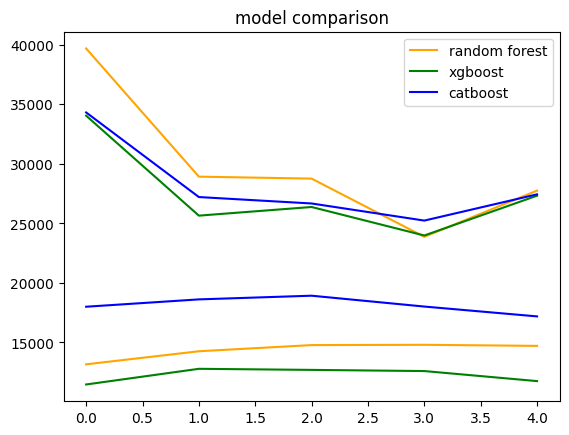

In [33]:
plt.plot(range(len(rf_final_result)), [i[0] for i in rf_final_result], c='orange', label='random forest')
plt.plot(range(len(rf_final_result)), [i[1] for i in rf_final_result], c='orange')
plt.plot(range(len(xgboost_final_result)), [i[0] for i in xgboost_final_result], c='green', label='xgboost')
plt.plot(range(len(xgboost_final_result)), [i[1] for i in xgboost_final_result], c='green')
plt.plot(range(len(catboost_final_result)), [i[0] for i in catboost_final_result], c='blue', label='catboost')
plt.plot(range(len(catboost_final_result)), [i[1] for i in catboost_final_result], c='blue')
plt.legend()
plt.title('model comparison')
plt.show()

In [163]:
catboost_final_result

[(18388.267746811547, 24719.064663299716),
 (18499.461516531952, 26514.70666944357),
 (16880.039508780992, 23856.79252965792),
 (15875.505536761904, 27923.412537213564),
 (19542.204497100083, 35095.05745006362)]

In [168]:
df_train_engineered[df_train_engineered['fuel_type']== 'missing'][['make_model', 'fuel_type']]['make_model'].unique()

array(['volkswagen scirocco', 'honda airwave', 'bmw x4',
       'mitsubishi lancer', 'bmw 740li', 'honda jazz', 'volkswagen jetta',
       'nissan x-trail', 'mercedes-benz c180', 'honda hr-v', 'bmw 316i',
       'mercedes-benz 250', 'alfa romeo giulia', 'nissan qashqai',
       'kia cerato', 'toyota wish', 'bmw 420i', 'mercedes-benz s300l',
       'mercedes-benz cla200', 'bmw x3', 'maserati granturismo',
       'honda n-box', 'bmw 528i', 'hyundai elantra', 'mitsubishi eclipse',
       'rolls-royce ghost', 'hyundai avante', 'hyundai santa',
       'ferrari f612s', 'mclaren 720s', 'bentley continental',
       'nissan almera', 'mclaren 570s', 'mercedes-benz clc180k',
       'subaru levorg', 'subaru legacy', 'toyota picnic', 'mclaren 12c',
       'audi q2', 'porsche 911', 'kia rio', 'subaru xv',
       'volkswagen tiguan', 'nissan pulsar', 'mercedes-benz coupe',
       'mazda 2', 'peugeot 308', 'mitsubishi attrage', 'kia stonic',
       'bmw 535i', 'mitsubishi outlander', 'lamborghini gal

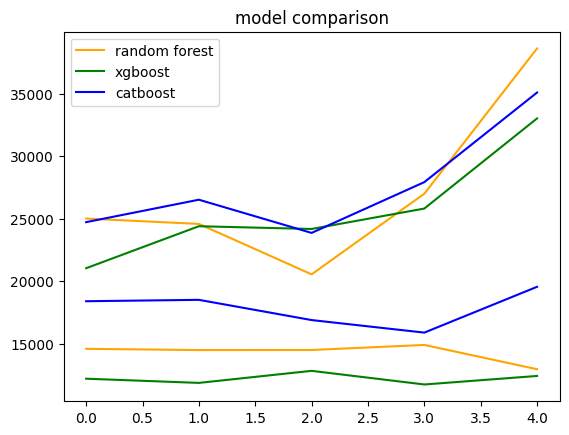

In [164]:
plt.plot(range(len(rf_final_result)), [i[0] for i in rf_final_result], c='orange', label='random forest')
plt.plot(range(len(rf_final_result)), [i[1] for i in rf_final_result], c='orange')
plt.plot(range(len(xgboost_final_result)), [i[0] for i in xgboost_final_result], c='green', label='xgboost')
plt.plot(range(len(xgboost_final_result)), [i[1] for i in xgboost_final_result], c='green')
plt.plot(range(len(catboost_final_result)), [i[0] for i in catboost_final_result], c='blue', label='catboost')
plt.plot(range(len(catboost_final_result)), [i[1] for i in catboost_final_result], c='blue')
plt.legend()
plt.title('model comparison')
plt.show()

# Generate output

In [ ]:
rf_param_dic = {
    'max_depth': 22, 
    'min_samples_leaf': 2, 
    'min_samples_split': 2, 
    'n_estimators': 350}
rf_estimator = RandomForestRegressor(**rf_param_dic)

rf_model = SklearnRegressor(rf_estimator, selected_features, target)
rf_model.train(df_train_engineered, stage="test")

y_pred = rf_model.predict(df_test_engineered[selected_features])
df_predict = pd.DataFrame({"Predicted": y_pred})
df_predict.to_csv("../data/processed/predict_yy_rf_top20.csv", index_label = "Id")

In [34]:
xgboost_param_dic = {
    "max_depth": 5,
    "learning_rate": 0.1,
    "colsample_bytree": 0.7,
    "n_estimators": 1000,
    "early_stopping_rounds": 5,
    "verbose": False,
    "eval_metric": "rmse",
    "reg_lambda": 8,
    "min_child_weight": 80,
    "early_stopping_rounds":10}
xgboost_estimator = XGBRegressor(**xgboost_param_dic)

xgboost_model = SklearnRegressor(xgboost_estimator, num_model_var, target)
xgboost_model.train(df_train_engineered, stage="test")

y_pred = xgboost_model.predict(df_test_engineered[num_model_var])
df_predict = pd.DataFrame({"Predicted": y_pred})
df_predict.to_csv("../data/processed/predicted_xgboost.csv", index_label = "Id")

In [21]:
params = {
"iterations": 360,
"random_state": 10,
"loss_function": "RMSE",
"eval_metric": "RMSE",
"verbose": True,
"early_stopping_rounds": 15,
"l2_leaf_reg":10,
"random_strength":20, 
"depth":6,
"learning_rate": 0.08
}
catboost_estimator = CatBoostRegressor(**params)
catboost_model = CategoricalBoostRegressor(catboost_estimator, features, target, cat_features_loc)
catboost_model.train(train[features_with_target], stage="test")

0:	learn: 127564.6820940	total: 10.8ms	remaining: 3.87s
1:	learn: 123044.0165289	total: 19.3ms	remaining: 3.45s
2:	learn: 118670.8444319	total: 30.2ms	remaining: 3.6s
3:	learn: 113462.2331823	total: 37.9ms	remaining: 3.38s
4:	learn: 109836.9848633	total: 46.5ms	remaining: 3.3s
5:	learn: 105881.7059161	total: 54.7ms	remaining: 3.23s
6:	learn: 102841.1079753	total: 64ms	remaining: 3.23s
7:	learn: 100378.1823023	total: 70.7ms	remaining: 3.11s
8:	learn: 96170.2569435	total: 78.3ms	remaining: 3.06s
9:	learn: 92698.8165685	total: 83.5ms	remaining: 2.92s
10:	learn: 90001.1161698	total: 91.9ms	remaining: 2.92s
11:	learn: 87176.5039888	total: 99.5ms	remaining: 2.89s
12:	learn: 84589.0765670	total: 108ms	remaining: 2.87s
13:	learn: 81811.2311417	total: 114ms	remaining: 2.83s
14:	learn: 79705.7289256	total: 123ms	remaining: 2.83s
15:	learn: 78137.7016832	total: 130ms	remaining: 2.8s
16:	learn: 76139.6404864	total: 139ms	remaining: 2.8s
17:	learn: 74583.2647922	total: 145ms	remaining: 2.75s
18:	le

155:	learn: 29996.9652727	total: 1.19s	remaining: 1.56s
156:	learn: 29930.2162361	total: 1.2s	remaining: 1.55s
157:	learn: 29782.8881777	total: 1.21s	remaining: 1.55s
158:	learn: 29544.6828965	total: 1.22s	remaining: 1.54s
159:	learn: 29469.6997713	total: 1.23s	remaining: 1.54s
160:	learn: 29404.3000128	total: 1.24s	remaining: 1.53s
161:	learn: 29345.8547982	total: 1.25s	remaining: 1.52s
162:	learn: 29287.2493271	total: 1.25s	remaining: 1.52s
163:	learn: 29072.2187891	total: 1.26s	remaining: 1.51s
164:	learn: 28971.2923743	total: 1.27s	remaining: 1.5s
165:	learn: 28916.4033484	total: 1.28s	remaining: 1.5s
166:	learn: 28856.5940445	total: 1.29s	remaining: 1.49s
167:	learn: 28635.8702848	total: 1.3s	remaining: 1.48s
168:	learn: 28378.3501037	total: 1.3s	remaining: 1.48s
169:	learn: 28313.5060453	total: 1.31s	remaining: 1.47s
170:	learn: 28249.9849198	total: 1.32s	remaining: 1.46s
171:	learn: 28184.4400109	total: 1.33s	remaining: 1.46s
172:	learn: 28098.6292993	total: 1.34s	remaining: 1.4

308:	learn: 19495.3928892	total: 2.38s	remaining: 393ms
309:	learn: 19488.2052547	total: 2.39s	remaining: 385ms
310:	learn: 19427.9191326	total: 2.4s	remaining: 378ms
311:	learn: 19420.8612659	total: 2.4s	remaining: 370ms
312:	learn: 19413.9095018	total: 2.41s	remaining: 362ms
313:	learn: 19336.1079578	total: 2.42s	remaining: 354ms
314:	learn: 19280.4742877	total: 2.42s	remaining: 346ms
315:	learn: 19187.4474252	total: 2.43s	remaining: 339ms
316:	learn: 19138.4920637	total: 2.44s	remaining: 331ms
317:	learn: 19062.9899598	total: 2.45s	remaining: 324ms
318:	learn: 19010.8912421	total: 2.46s	remaining: 316ms
319:	learn: 18986.7987811	total: 2.47s	remaining: 309ms
320:	learn: 18945.3601868	total: 2.48s	remaining: 301ms
321:	learn: 18867.7784136	total: 2.49s	remaining: 294ms
322:	learn: 18807.4018489	total: 2.5s	remaining: 286ms
323:	learn: 18804.2477149	total: 2.5s	remaining: 278ms
324:	learn: 18750.6194329	total: 2.51s	remaining: 270ms
325:	learn: 18727.1642437	total: 2.52s	remaining: 26

In [79]:
df_rf = pd.read_csv("../data/processed/predict_rf.csv")
df_xgboost = pd.read_csv("../data/processed/predict_xgboost.csv")
df_catboost = pd.read_csv("../data/processed/predict_catboost.csv")

In [81]:
df_combine = pd.DataFrame({"Predicted": (df_rf["Predicted"] + df_xgboost["Predicted"] + df_catboost["Predicted"])/3})
df_combine.to_csv("../data/processed/predict_combined.csv", index_label = "Id")